# Kaggle RSNA Intracranial Hemorrhage Detection example

In [1]:
from functools import reduce
import os
import pickle
import random

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from features import CNNFeatureExtractor

In [2]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
import xgboost
from xgboost import XGBClassifier

In [3]:
RANDOM_SEED = 2020
DEBUG_MODE = True

DATA_BASE_PATH = '/data/'
PNG_DIR = 'png_256/'
NUM_SUBJ_PER_SPLIT = 50

IMG_DIR = DATA_BASE_PATH + PNG_DIR + "train"
SAVE_DIR = DATA_BASE_PATH + "png_256_resnet50features/" + str(NUM_SUBJ_PER_SPLIT) + "_subj_per_split/"

## Load the image feature datasets

In [4]:
with open(SAVE_DIR + "features_train.npy", "rb") as f:
    X_train = np.load(f)
    img_names_train = np.load(f)
    
with open(SAVE_DIR + "features_test.npy", "rb") as f:
    X_test = np.load(f)
    img_names_test = np.load(f)

with open(SAVE_DIR + "features_lockbox.npy", "rb") as f:
    X_lockbox = np.load(f)
    img_names_lockbox = np.load(f)

## Load the image labels

In [5]:
labels_df = pd.read_csv(DATA_BASE_PATH + PNG_DIR + 'pivot_df.csv')
del labels_df['Unnamed: 0']
labels_df = labels_df.set_index('filename')

In [6]:
labels_train_df = labels_df.loc[[os.path.basename(f) for f in img_names_train]]
labels_test_df = labels_df.loc[[os.path.basename(f) for f in img_names_test]]
labels_lockbox_df = labels_df.loc[[os.path.basename(f) for f in img_names_lockbox]]

labels_test_df

any  epidural  intraparenchymal  intraventricular  \
filename                                                              
ID_4166af295.png    0         0                 0                 0   
ID_f428bb3e7.png    0         0                 0                 0   
ID_8513fb5cc.png    0         0                 0                 0   
ID_3d2d45403.png    1         0                 0                 0   
ID_f66deaba0.png    0         0                 0                 0   
...               ...       ...               ...               ...   
ID_d0a1e36c4.png    0         0                 0                 0   
ID_791b3c7a8.png    0         0                 0                 0   
ID_5b6ef0304.png    0         0                 0                 0   
ID_35e51829e.png    0         0                 0                 0   
ID_3a93b98a5.png    0         0                 0                 0   

                  subarachnoid  subdural  
filename                                  
ID_4166af295.png             0         0  
ID_f428bb3e7.png             0         0  
ID_8513fb5cc.png             0         0  
ID_3d2d45403.png             0         1  
ID_f66deaba0.png             0         0  
...                        ...       ...  
ID_d0a1e36c4.png             0         0  
ID_791b3c7a8.png             0         0  
ID_5b6ef0304.png             0         0  
ID_35e51829e.png             0         0  
ID_3a93b98a5.png             0         0  

[198381 rows x 6 columns]

In [7]:
y_train = labels_train_df["any"].values
y_test = labels_test_df["any"].values
y_lockbox = labels_lockbox_df["any"].values
y_train

array([0, 0, 0, ..., 0, 0, 0])

Final data matrices and label vectors:

In [8]:
print(X_train.shape, X_test.shape, X_lockbox.shape,
      y_train.shape, y_test.shape, y_lockbox.shape)

(198543, 2048) (198381, 2048) (355878, 2048) (198543,) (198381,) (355878,)


## Fit a logistic regression classifier on the training data

Feature standardization prior to logistic regression

In [9]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_lockbox_scaled = scaler.transform(X_lockbox)

### First fit a model without regularization

In [38]:
logit_model = LogisticRegression(
    penalty="none", solver="lbfgs", random_state=RANDOM_SEED, max_iter=10000
)
logit_model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=2020, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

* Accuracy on the training data:

In [39]:
logit_model.score(X_train_scaled, y_train)

0.8786358622565389

* Accuracy on the test data:

In [40]:
logit_model.score(X_test_scaled, y_test)

0.8643368064481982

* Accuracy on the lockbox data:

In [41]:
logit_model.score(X_lockbox_scaled, y_lockbox)

0.8618318637285811

* AUC of training data:

In [44]:
y_train_pred = logit_model.predict_proba(X_train_scaled)
roc_auc_score(y_train, y_train_pred[:,1])

0.8541853840351695

* AUC on test data:

In [45]:
y_test_pred = logit_model.predict_proba(X_test_scaled)
roc_auc_score(y_test, y_test_pred[:,1])

0.8218309351702637

* AUC on lockbox data:

In [46]:
y_lockbox_pred = logit_model.predict_proba(X_lockbox_scaled)
roc_auc_score(y_lockbox, y_lockbox_pred[:,1])

0.8176589777160388

### Fit an (L1, L2)-regularized model with penalty parameter chosen via cross-validation

Choosing the regularization parameter for logistic regression

With feature standardization

**This takes multiple days to run:**

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

c_values = np.logspace(-3, 2, 10)
l1_ratios = np.linspace(0, 1, 5)

logit_searcher = LogisticRegressionCV(
    Cs=c_values, l1_ratios=l1_ratios, penalty="elasticnet", solver="saga",
    cv=skf, verbose=1, n_jobs=4, max_iter=10000, scoring="roc_auc", refit=True
)
logit_searcher.fit(X_train_scaled, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 804 epochs took 2225 seconds
convergence after 771 epochs took 2527 seconds
convergence after 694 epochs took 2594 seconds
convergence after 849 epochs took 2664 seconds
convergence after 834 epochs took 3110 seconds
convergence after 1405 epochs took 3885 seconds
convergence after 1375 epochs took 5718 seconds
convergence after 1585 epochs took 7153 seconds
convergence after 1985 epochs took 5484 seconds
convergence after 1825 epochs took 5042 seconds
convergence after 2941 epochs took 13178 seconds
convergence after 1075 epochs took 2970 seconds
convergence after 2664 epochs took 10403 seconds
convergence after 381 epochs took 1052 seconds
convergence after 118 epochs took 326 seconds
convergence after 34 epochs took 94 seconds
convergence after 10 epochs took 28 seconds
convergence after 2 epochs took 6 seconds
convergence after 2979 epochs took 12873 seconds
convergence after 809 epochs took 2443 seconds
convergence after 878 epochs took 2903 seconds
convergence a

convergence after 40 epochs took 134 seconds
convergence after 12 epochs took 39 seconds
convergence after 3 epochs took 10 seconds
convergence after 2674 epochs took 11590 seconds
convergence after 833 epochs took 2297 seconds
convergence after 1285 epochs took 5005 seconds
convergence after 537 epochs took 2018 seconds
convergence after 169 epochs took 606 seconds
convergence after 48 epochs took 164 seconds
convergence after 1383 epochs took 3814 seconds
convergence after 14 epochs took 46 seconds
convergence after 3 epochs took 9 seconds
convergence after 1456 epochs took 5883 seconds
convergence after 680 epochs took 2525 seconds
convergence after 626 epochs took 2380 seconds
convergence after 198 epochs took 714 seconds
convergence after 57 epochs took 195 seconds
convergence after 15 epochs took 49 seconds
convergence after 5 epochs took 16 seconds
convergence after 1728 epochs took 4768 seconds
convergence after 2793 epochs took 12355 seconds
convergence after 766 epochs took 2

[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 3793.0min finished


LogisticRegressionCV(Cs=array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=2020, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                     max_iter=10000, multi_class='warn', n_jobs=4,
                     penalty='elasticnet', random_state=None, refit=True,
                     scoring='roc_auc', solver='saga', tol=0.0001, verbose=1)

Save the model:

In [12]:
# save the model to disk
pickle.dump(logit_searcher, open('elastic_net.sav', 'wb'))

Load the model from disk:

In [13]:
# load the model from disk
elastic_net = pickle.load(open('elastic_net.sav', 'rb'))

In [28]:
logit_searcher.scores_[1].shape

(5, 10, 5)

Text(0, 0.5, 'Mean CV-accuracy')

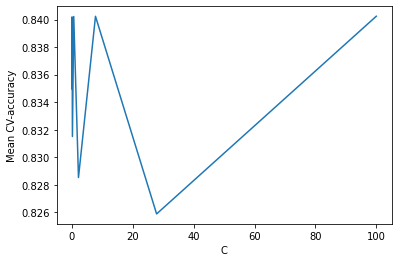

In [26]:
plt.plot(c_values, np.mean(elastic_net.scores_[1], axis=(0, 2)))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy')

Text(0, 0.5, 'Mean CV-accuracy')

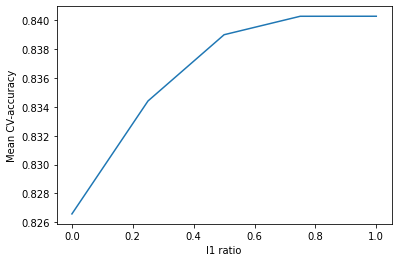

In [29]:
plt.plot(l1_ratios, np.mean(elastic_net.scores_[1], axis=(0, 1)))
plt.xlabel('l1 ratio')
plt.ylabel('Mean CV-accuracy')

In [37]:
optim_c = elastic_net.C_[0]
optim_l1 = elastic_net.l1_ratio_[0]

print(optim_c, optim_l1)

0.046415888336127795 0.5


* AUC of training data:

In [46]:
y_train_pred = elastic_net.predict_proba(X_train_scaled)
roc_auc_score(y_train, y_train_pred[:,1])

0.8532523657343789

* AUC on test data:

In [47]:
y_test_pred = elastic_net.predict_proba(X_test_scaled)
roc_auc_score(y_test, y_test_pred[:,1])

0.8239129163928107

* AUC on lockbox data:

In [48]:
y_lockbox_pred = elastic_net.predict_proba(X_lockbox_scaled)
roc_auc_score(y_lockbox, y_lockbox_pred[:,1])

0.8197871767956038

## XGBoost

We will perform a random search sampling from the following parameter grid.

In [22]:
param_grid = {
    'max_depth': np.arange(3, 11),
    'min_child_weight': np.arange(1, 20),
    'gamma': np.arange(0.0, 4.0, 0.005),
    'learning_rate': np.arange(0.0005, 0.3, 0.0005),
    'subsample': np.arange(0.5, 1.0, 0.01),
    'colsample_bytree': np.arange(0.5, 1.0, 0.01)
}

In [23]:
model = XGBClassifier()

In [24]:
kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
grid_search = RandomizedSearchCV(
    model, param_grid, scoring="roc_auc", n_iter=10, cv=kfold
)
grid_result = grid_search.fit(X_train, y_train)

In [25]:
print(
    "Best AUC: {}, using {}"
    .format(grid_result.best_score_, grid_result.best_params_)
)
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]

Best AUC: 0.8716620094755869, using {'subsample': 0.8900000000000003, 'min_child_weight': 15, 'max_depth': 8, 'learning_rate': 0.20400000000000001, 'gamma': 1.595, 'colsample_bytree': 0.9500000000000004}


Tuning regularization parameters:

In [43]:
param_grid = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
param_grid.update({k: [v] for k,v in grid_result.best_params_.items()})
print(param_grid)

{'reg_alpha': [1e-05, 0.01, 0.1, 1, 100], 'subsample': [0.8900000000000003], 'min_child_weight': [15], 'max_depth': [8], 'learning_rate': [0.20400000000000001], 'gamma': [1.595], 'colsample_bytree': [0.9500000000000004]}


In [44]:
grid_search_2 = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid = param_grid,
    scoring='roc_auc',
    cv=10
)

t = time.time()
grid_search_2.fit(X_train, y_train)
print("Time total in seconds: {}".format(time.time() - t))

Time total in seconds: 12594.913989782333


In [47]:
print(
    "Best AUC: {}, using {}"
    .format(grid_search_2.best_score_, grid_search_2.best_params_)
)

Best AUC: 0.8734510388014725, using {'colsample_bytree': 0.9500000000000004, 'gamma': 1.595, 'learning_rate': 0.20400000000000001, 'max_depth': 8, 'min_child_weight': 15, 'reg_alpha': 1, 'subsample': 0.8900000000000003}


In [48]:
param_grid = {
 'reg_alpha':[0.1, 0.5, 1, 2, 5]
}
param_grid.update({k: [v] for k,v in grid_result.best_params_.items()})
print(param_grid)

{'reg_alpha': [0.1, 0.5, 1, 2, 5], 'subsample': [0.8900000000000003], 'min_child_weight': [15], 'max_depth': [8], 'learning_rate': [0.20400000000000001], 'gamma': [1.595], 'colsample_bytree': [0.9500000000000004]}


In [49]:
grid_search_3 = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid = param_grid,
    scoring='roc_auc',
    cv=10
)

t = time.time()
grid_search_3.fit(X_train, y_train)
print("Time total in seconds: {}".format(time.time() - t))

Time total in seconds: 12467.330779075623


In [50]:
print(
    "Best AUC: {}, using {}"
    .format(grid_search_3.best_score_, grid_search_3.best_params_)
)

Best AUC: 0.8770985168840159, using {'colsample_bytree': 0.9500000000000004, 'gamma': 1.595, 'learning_rate': 0.20400000000000001, 'max_depth': 8, 'min_child_weight': 15, 'reg_alpha': 5, 'subsample': 0.8900000000000003}


In [51]:
param_grid = {
 'reg_alpha':[5, 10, 20]
}
param_grid.update({k: [v] for k,v in grid_result.best_params_.items()})
print(param_grid)

{'reg_alpha': [5, 10, 20], 'subsample': [0.8900000000000003], 'min_child_weight': [15], 'max_depth': [8], 'learning_rate': [0.20400000000000001], 'gamma': [1.595], 'colsample_bytree': [0.9500000000000004]}


In [52]:
grid_search_3 = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid = param_grid,
    scoring='roc_auc',
    cv=10
)

t = time.time()
grid_search_3.fit(X_train, y_train)
print("Time total in seconds: {}".format(time.time() - t))

Time total in seconds: 7745.576098442078


In [54]:
print(
    "Best AUC: {}, using {}"
    .format(grid_search_3.best_score_, grid_search_3.best_params_)
)

Best AUC: 0.8777019950995326, using {'colsample_bytree': 0.9500000000000004, 'gamma': 1.595, 'learning_rate': 0.20400000000000001, 'max_depth': 8, 'min_child_weight': 15, 'reg_alpha': 10, 'subsample': 0.8900000000000003}


Lower the learning rate and add more boosting rounds:

In [8]:
param_grid = {
    'colsample_bytree': [0.9500000000000004],
    'gamma': [1.595],
    'learning_rate': [0.01, 0.1],
    'max_depth': [8],
    'min_child_weight': [15],
    'reg_alpha': [10],
    'subsample': [0.8900000000000003],
    'n_estimators': [1000, 5000],
    #'n_jobs': [8],
    'verbosity': [2],
    'random_state': [RANDOM_SEED]
}

In [ ]:
grid_search_4 = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid = param_grid,
    scoring='roc_auc',
    cv=10
)

t = time.time()
grid_search_4.fit(X_train, y_train)
print("Time total in seconds: {}".format(time.time() - t))

[03:54:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=8
[03:54:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 2 pruned nodes, max_depth=8
[03:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 10 pruned nodes, max_depth=8
[03:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 6 pruned nodes, max_depth=8
[03:54:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 8 pruned nodes, max_depth=8
[03:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 6 pruned nodes, max_depth=8
[03:54:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 6 pruned nodes, max_depth=8
[03:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 6 pruned nodes, max_depth=8
[03:54:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 2

[03:56:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 4 pruned nodes, max_depth=8
[03:56:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 2 pruned nodes, max_depth=8
[03:56:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 4 pruned nodes, max_depth=8
[03:56:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 6 pruned nodes, max_depth=8
[03:56:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 2 pruned nodes, max_depth=8
[03:56:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=8
[03:56:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 10 pruned nodes, max_depth=8
[03:56:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 16 pruned nodes, max_depth=8
[03:57:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 

[03:59:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 16 pruned nodes, max_depth=8
[03:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 8 pruned nodes, max_depth=8
[03:59:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 12 pruned nodes, max_depth=8
[03:59:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 8 pruned nodes, max_depth=8
[03:59:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 6 pruned nodes, max_depth=8
[03:59:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 8 pruned nodes, max_depth=8
[03:59:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 14 pruned nodes, max_depth=8
[03:59:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 12 pruned nodes, max_depth=8
[03:59:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes

[04:02:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 6 pruned nodes, max_depth=8
[04:02:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 12 pruned nodes, max_depth=8
[04:02:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 10 pruned nodes, max_depth=8
[04:02:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 18 pruned nodes, max_depth=8
[04:02:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 8 pruned nodes, max_depth=8
[04:02:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 6 pruned nodes, max_depth=8
[04:02:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 10 pruned nodes, max_depth=8
[04:02:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 18 pruned nodes, max_depth=8
[04:02:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra node

[04:05:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 12 pruned nodes, max_depth=8
[04:05:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 14 pruned nodes, max_depth=8
[04:05:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 4 pruned nodes, max_depth=8
[04:05:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 14 pruned nodes, max_depth=8
[04:05:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 6 pruned nodes, max_depth=8
[04:05:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 10 pruned nodes, max_depth=8
[04:05:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 16 pruned nodes, max_depth=8
[04:05:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 16 pruned nodes, max_depth=8
[04:05:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nod

[04:07:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 12 pruned nodes, max_depth=8
[04:07:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 8 pruned nodes, max_depth=8
[04:08:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 10 pruned nodes, max_depth=8
[04:08:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 10 pruned nodes, max_depth=8
[04:08:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 16 pruned nodes, max_depth=8
[04:08:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 16 pruned nodes, max_depth=8
[04:08:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 6 pruned nodes, max_depth=8
[04:08:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 8 pruned nodes, max_depth=8
[04:08:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra node

[04:10:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 16 pruned nodes, max_depth=8
[04:10:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 10 pruned nodes, max_depth=8
[04:10:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 12 pruned nodes, max_depth=8
[04:10:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 12 pruned nodes, max_depth=8
[04:10:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 12 pruned nodes, max_depth=8
[04:11:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 4 pruned nodes, max_depth=8
[04:11:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 12 pruned nodes, max_depth=8
[04:11:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 8 pruned nodes, max_depth=8
[04:11:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nod

[04:13:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 18 pruned nodes, max_depth=8
[04:13:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 18 pruned nodes, max_depth=8
[04:13:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 14 pruned nodes, max_depth=8
[04:13:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 14 pruned nodes, max_depth=8
[04:13:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 16 pruned nodes, max_depth=8
[04:13:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 18 pruned nodes, max_depth=8
[04:13:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 8 pruned nodes, max_depth=8
[04:13:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 8 pruned nodes, max_depth=8
[04:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nod

[04:16:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 16 pruned nodes, max_depth=8
[04:16:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 10 pruned nodes, max_depth=8
[04:16:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 24 pruned nodes, max_depth=8
[04:16:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 16 pruned nodes, max_depth=8
[04:16:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 14 pruned nodes, max_depth=8
[04:16:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 4 pruned nodes, max_depth=8
[04:16:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 10 pruned nodes, max_depth=8
[04:16:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 8 pruned nodes, max_depth=8
[04:16:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes

[04:19:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 12 pruned nodes, max_depth=8
[04:19:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 22 pruned nodes, max_depth=8
[04:19:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 10 pruned nodes, max_depth=8
[04:19:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 10 pruned nodes, max_depth=8
[04:19:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 14 pruned nodes, max_depth=8
[04:19:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 20 pruned nodes, max_depth=8
[04:19:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 4 pruned nodes, max_depth=8
[04:19:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 6 pruned nodes, max_depth=8
[04:19:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nod

[04:22:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 8 pruned nodes, max_depth=8
[04:22:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 14 pruned nodes, max_depth=8
[04:22:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 12 pruned nodes, max_depth=8
[04:22:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 24 pruned nodes, max_depth=8
[04:22:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 20 pruned nodes, max_depth=8
[04:22:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 16 pruned nodes, max_depth=8
[04:22:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 10 pruned nodes, max_depth=8
[04:22:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 26 pruned nodes, max_depth=8
[04:22:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nod

[04:25:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 14 pruned nodes, max_depth=8
[04:25:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 10 pruned nodes, max_depth=8
[04:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 30 pruned nodes, max_depth=8
[04:25:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 8 pruned nodes, max_depth=8
[04:25:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 14 pruned nodes, max_depth=8
[04:25:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 18 pruned nodes, max_depth=8
[04:25:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 22 pruned nodes, max_depth=8
[04:25:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 22 pruned nodes, max_depth=8
[04:25:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra no

[04:28:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 18 pruned nodes, max_depth=8
[04:28:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 20 pruned nodes, max_depth=8
[04:28:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 12 pruned nodes, max_depth=8
[04:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 18 pruned nodes, max_depth=8
[04:28:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 14 pruned nodes, max_depth=8
[04:28:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 20 pruned nodes, max_depth=8
[04:28:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 10 pruned nodes, max_depth=8
[04:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 22 pruned nodes, max_depth=8
[04:28:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra no

[04:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 12 pruned nodes, max_depth=8
[04:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 10 pruned nodes, max_depth=8
[04:31:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 24 pruned nodes, max_depth=8
[04:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 18 pruned nodes, max_depth=8
[04:31:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 16 pruned nodes, max_depth=8
[04:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 16 pruned nodes, max_depth=8
[04:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 8 pruned nodes, max_depth=8
[04:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 14 pruned nodes, max_depth=8
[04:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra no

[04:34:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 2 pruned nodes, max_depth=8
[04:34:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 4 pruned nodes, max_depth=8
[04:34:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 4 pruned nodes, max_depth=8
[04:34:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 4 pruned nodes, max_depth=8
[04:34:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 4 pruned nodes, max_depth=8
[04:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=8
[04:34:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 6 pruned nodes, max_depth=8
[04:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 6 pruned nodes, max_depth=8
[04:34:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 

[04:37:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 6 pruned nodes, max_depth=8
[04:37:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 22 pruned nodes, max_depth=8
[04:37:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 2 pruned nodes, max_depth=8
[04:37:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 18 pruned nodes, max_depth=8
[04:37:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 16 pruned nodes, max_depth=8
[04:37:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 4 pruned nodes, max_depth=8
[04:37:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 4 pruned nodes, max_depth=8
[04:37:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 10 pruned nodes, max_depth=8
[04:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes

[04:39:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 6 pruned nodes, max_depth=8
[04:39:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 6 pruned nodes, max_depth=8
[04:39:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 16 pruned nodes, max_depth=8
[04:39:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 8 pruned nodes, max_depth=8
[04:40:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 14 pruned nodes, max_depth=8
[04:40:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 14 pruned nodes, max_depth=8
[04:40:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 8 pruned nodes, max_depth=8
[04:40:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 6 pruned nodes, max_depth=8
[04:40:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes,

[04:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 6 pruned nodes, max_depth=8
[04:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 14 pruned nodes, max_depth=8
[04:42:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 8 pruned nodes, max_depth=8
[04:42:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 12 pruned nodes, max_depth=8
[04:42:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 20 pruned nodes, max_depth=8
[04:42:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 8 pruned nodes, max_depth=8
[04:42:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 14 pruned nodes, max_depth=8
[04:42:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 18 pruned nodes, max_depth=8
[04:42:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra node

[04:45:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 18 pruned nodes, max_depth=8
[04:45:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 12 pruned nodes, max_depth=8
[04:45:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 10 pruned nodes, max_depth=8
[04:45:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 12 pruned nodes, max_depth=8
[04:45:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 16 pruned nodes, max_depth=8
[04:45:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 14 pruned nodes, max_depth=8
[04:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 12 pruned nodes, max_depth=8
[04:45:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 6 pruned nodes, max_depth=8
[04:45:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra no

[04:48:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 16 pruned nodes, max_depth=8
[04:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 18 pruned nodes, max_depth=8
[04:48:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 14 pruned nodes, max_depth=8
[04:48:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 8 pruned nodes, max_depth=8
[04:48:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 14 pruned nodes, max_depth=8
[04:48:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 10 pruned nodes, max_depth=8
[04:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 18 pruned nodes, max_depth=8
[04:48:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 10 pruned nodes, max_depth=8
[04:48:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra no

[04:51:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 12 pruned nodes, max_depth=8
[04:51:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 16 pruned nodes, max_depth=8
[04:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 14 pruned nodes, max_depth=8
[04:51:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 16 pruned nodes, max_depth=8
[04:51:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 4 pruned nodes, max_depth=8
[04:51:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 12 pruned nodes, max_depth=8
[04:51:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 8 pruned nodes, max_depth=8
[04:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 12 pruned nodes, max_depth=8
[04:51:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nod

[04:54:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 8 pruned nodes, max_depth=8
[04:54:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 8 pruned nodes, max_depth=8
[04:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 16 pruned nodes, max_depth=8
[04:54:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 20 pruned nodes, max_depth=8
[04:54:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 10 pruned nodes, max_depth=8
[04:54:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 12 pruned nodes, max_depth=8
[04:54:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 14 pruned nodes, max_depth=8
[04:54:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 14 pruned nodes, max_depth=8
[04:54:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nod

[04:57:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 20 pruned nodes, max_depth=8
[04:57:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 8 pruned nodes, max_depth=8
[04:57:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 16 pruned nodes, max_depth=8
[04:57:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 18 pruned nodes, max_depth=8
[04:57:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 6 pruned nodes, max_depth=8
[04:57:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 10 pruned nodes, max_depth=8
[04:57:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 10 pruned nodes, max_depth=8
[04:57:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 18 pruned nodes, max_depth=8
[04:57:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nod

[04:59:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 4 pruned nodes, max_depth=8
[05:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 298 extra nodes, 16 pruned nodes, max_depth=8
[05:00:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 14 pruned nodes, max_depth=8
[05:00:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 4 pruned nodes, max_depth=8
[05:00:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 18 pruned nodes, max_depth=8
[05:00:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 6 pruned nodes, max_depth=8
[05:00:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 14 pruned nodes, max_depth=8
[05:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 14 pruned nodes, max_depth=8
[05:00:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra node

[05:02:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 10 pruned nodes, max_depth=8
[05:02:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 30 pruned nodes, max_depth=8
[05:03:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 16 pruned nodes, max_depth=8
[05:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 26 pruned nodes, max_depth=8
[05:03:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 12 pruned nodes, max_depth=8
[05:03:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 14 pruned nodes, max_depth=8
[05:03:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 18 pruned nodes, max_depth=8
[05:03:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 4 pruned nodes, max_depth=8
[05:03:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nod

[05:05:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 8 pruned nodes, max_depth=8
[05:05:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 18 pruned nodes, max_depth=8
[05:05:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 16 pruned nodes, max_depth=8
[05:05:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 16 pruned nodes, max_depth=8
[05:06:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 4 pruned nodes, max_depth=8
[05:06:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 16 pruned nodes, max_depth=8
[05:06:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 18 pruned nodes, max_depth=8
[05:06:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 20 pruned nodes, max_depth=8
[05:06:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nod

[05:08:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 18 pruned nodes, max_depth=8
[05:08:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 18 pruned nodes, max_depth=8
[05:08:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 22 pruned nodes, max_depth=8
[05:08:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 14 pruned nodes, max_depth=8
[05:08:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 14 pruned nodes, max_depth=8
[05:09:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 16 pruned nodes, max_depth=8
[05:09:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 22 pruned nodes, max_depth=8
[05:09:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 30 pruned nodes, max_depth=8
[05:09:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra n

[05:11:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 16 pruned nodes, max_depth=8
[05:11:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 16 pruned nodes, max_depth=8
[05:11:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 18 pruned nodes, max_depth=8
[05:11:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 14 pruned nodes, max_depth=8
[05:11:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 16 pruned nodes, max_depth=8
[05:11:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 16 pruned nodes, max_depth=8
[05:12:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 18 pruned nodes, max_depth=8
[05:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 24 pruned nodes, max_depth=8
[05:12:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra n

[05:14:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 4 pruned nodes, max_depth=8
[05:14:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 4 pruned nodes, max_depth=8
[05:14:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 6 pruned nodes, max_depth=8
[05:14:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 4 pruned nodes, max_depth=8
[05:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=8
[05:14:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 4 pruned nodes, max_depth=8
[05:15:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 8 pruned nodes, max_depth=8
[05:15:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[05:15:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 8

[05:17:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 8 pruned nodes, max_depth=8
[05:17:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 8 pruned nodes, max_depth=8
[05:17:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 6 pruned nodes, max_depth=8
[05:17:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 8 pruned nodes, max_depth=8
[05:17:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 8 pruned nodes, max_depth=8
[05:17:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 4 pruned nodes, max_depth=8
[05:17:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 8 pruned nodes, max_depth=8
[05:17:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 8 pruned nodes, max_depth=8
[05:17:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 12

[05:20:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[05:20:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 10 pruned nodes, max_depth=8
[05:20:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 16 pruned nodes, max_depth=8
[05:20:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 8 pruned nodes, max_depth=8
[05:20:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 6 pruned nodes, max_depth=8
[05:20:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 6 pruned nodes, max_depth=8
[05:20:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 6 pruned nodes, max_depth=8
[05:20:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 8 pruned nodes, max_depth=8
[05:20:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes,

[05:23:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 14 pruned nodes, max_depth=8
[05:23:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 8 pruned nodes, max_depth=8
[05:23:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 20 pruned nodes, max_depth=8
[05:23:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 8 pruned nodes, max_depth=8
[05:23:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 16 pruned nodes, max_depth=8
[05:23:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 10 pruned nodes, max_depth=8
[05:23:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 14 pruned nodes, max_depth=8
[05:23:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 18 pruned nodes, max_depth=8
[05:23:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nod

[05:25:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 14 pruned nodes, max_depth=8
[05:25:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 10 pruned nodes, max_depth=8
[05:25:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 12 pruned nodes, max_depth=8
[05:26:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 8 pruned nodes, max_depth=8
[05:26:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 12 pruned nodes, max_depth=8
[05:26:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 10 pruned nodes, max_depth=8
[05:26:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 14 pruned nodes, max_depth=8
[05:26:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[05:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra no

[05:28:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 12 pruned nodes, max_depth=8
[05:28:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 16 pruned nodes, max_depth=8
[05:28:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 14 pruned nodes, max_depth=8
[05:28:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 4 pruned nodes, max_depth=8
[05:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 14 pruned nodes, max_depth=8
[05:28:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 18 pruned nodes, max_depth=8
[05:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[05:29:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 24 pruned nodes, max_depth=8
[05:29:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra no

[05:31:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 14 pruned nodes, max_depth=8
[05:31:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 12 pruned nodes, max_depth=8
[05:31:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 8 pruned nodes, max_depth=8
[05:31:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 24 pruned nodes, max_depth=8
[05:31:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 8 pruned nodes, max_depth=8
[05:31:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 6 pruned nodes, max_depth=8
[05:31:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 8 pruned nodes, max_depth=8
[05:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 16 pruned nodes, max_depth=8
[05:31:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes

[05:34:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 12 pruned nodes, max_depth=8
[05:34:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 4 pruned nodes, max_depth=8
[05:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 12 pruned nodes, max_depth=8
[05:34:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 10 pruned nodes, max_depth=8
[05:34:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 12 pruned nodes, max_depth=8
[05:34:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 16 pruned nodes, max_depth=8
[05:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 2 pruned nodes, max_depth=8
[05:34:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 16 pruned nodes, max_depth=8
[05:34:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nod

[05:37:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 12 pruned nodes, max_depth=8
[05:37:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 20 pruned nodes, max_depth=8
[05:37:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 2 pruned nodes, max_depth=8
[05:37:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 28 pruned nodes, max_depth=8
[05:37:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 14 pruned nodes, max_depth=8
[05:37:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 22 pruned nodes, max_depth=8
[05:37:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 14 pruned nodes, max_depth=8
[05:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 14 pruned nodes, max_depth=8
[05:37:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra no

[05:40:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 26 pruned nodes, max_depth=8
[05:40:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 8 pruned nodes, max_depth=8
[05:40:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 8 pruned nodes, max_depth=8
[05:40:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 22 pruned nodes, max_depth=8
[05:40:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 20 pruned nodes, max_depth=8
[05:40:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 10 pruned nodes, max_depth=8
[05:40:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 28 pruned nodes, max_depth=8
[05:40:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 12 pruned nodes, max_depth=8
[05:40:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nod

[05:43:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 8 pruned nodes, max_depth=8
[05:43:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 14 pruned nodes, max_depth=8
[05:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 18 pruned nodes, max_depth=8
[05:43:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 16 pruned nodes, max_depth=8
[05:43:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 20 pruned nodes, max_depth=8
[05:43:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 8 pruned nodes, max_depth=8
[05:43:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 6 pruned nodes, max_depth=8
[05:43:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 10 pruned nodes, max_depth=8
[05:43:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes

[05:46:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 10 pruned nodes, max_depth=8
[05:46:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 24 pruned nodes, max_depth=8
[05:46:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 10 pruned nodes, max_depth=8
[05:46:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 20 pruned nodes, max_depth=8
[05:46:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 10 pruned nodes, max_depth=8
[05:46:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 10 pruned nodes, max_depth=8
[05:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 18 pruned nodes, max_depth=8
[05:46:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 4 pruned nodes, max_depth=8
[05:46:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra node

[05:49:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 8 pruned nodes, max_depth=8
[05:49:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 20 pruned nodes, max_depth=8
[05:49:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 2 pruned nodes, max_depth=8
[05:49:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 30 pruned nodes, max_depth=8
[05:49:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 18 pruned nodes, max_depth=8
[05:49:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 18 pruned nodes, max_depth=8
[05:49:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 16 pruned nodes, max_depth=8
[05:49:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 26 pruned nodes, max_depth=8
[05:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nod

[05:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 16 pruned nodes, max_depth=8
[05:52:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 24 pruned nodes, max_depth=8
[05:52:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 14 pruned nodes, max_depth=8
[05:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 376 extra nodes, 26 pruned nodes, max_depth=8
[05:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 12 pruned nodes, max_depth=8
[05:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 10 pruned nodes, max_depth=8
[05:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 16 pruned nodes, max_depth=8
[05:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 6 pruned nodes, max_depth=8
[05:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nod

[05:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 2 pruned nodes, max_depth=8
[05:55:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 4 pruned nodes, max_depth=8
[05:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=8
[05:55:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 10 pruned nodes, max_depth=8
[05:55:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 2 pruned nodes, max_depth=8
[05:55:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 14 pruned nodes, max_depth=8
[05:55:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 10 pruned nodes, max_depth=8
[05:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 2 pruned nodes, max_depth=8
[05:55:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes,

[05:57:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 6 pruned nodes, max_depth=8
[05:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 8 pruned nodes, max_depth=8
[05:57:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 10 pruned nodes, max_depth=8
[05:57:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 8 pruned nodes, max_depth=8
[05:58:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 10 pruned nodes, max_depth=8
[05:58:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 4 pruned nodes, max_depth=8
[05:58:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 10 pruned nodes, max_depth=8
[05:58:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 10 pruned nodes, max_depth=8
[05:58:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes

[06:00:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 10 pruned nodes, max_depth=8
[06:00:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 10 pruned nodes, max_depth=8
[06:00:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 4 pruned nodes, max_depth=8
[06:00:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 6 pruned nodes, max_depth=8
[06:00:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[06:00:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 10 pruned nodes, max_depth=8
[06:00:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 12 pruned nodes, max_depth=8
[06:00:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 6 pruned nodes, max_depth=8
[06:00:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra node

[06:03:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 16 pruned nodes, max_depth=8
[06:03:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 8 pruned nodes, max_depth=8
[06:03:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 14 pruned nodes, max_depth=8
[06:03:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 12 pruned nodes, max_depth=8
[06:03:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 12 pruned nodes, max_depth=8
[06:03:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 10 pruned nodes, max_depth=8
[06:03:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 14 pruned nodes, max_depth=8
[06:03:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 6 pruned nodes, max_depth=8
[06:03:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nod

[06:06:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 16 pruned nodes, max_depth=8
[06:06:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 22 pruned nodes, max_depth=8
[06:06:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 10 pruned nodes, max_depth=8
[06:06:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 14 pruned nodes, max_depth=8
[06:06:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 10 pruned nodes, max_depth=8
[06:06:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 8 pruned nodes, max_depth=8
[06:06:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 10 pruned nodes, max_depth=8
[06:06:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 14 pruned nodes, max_depth=8
[06:06:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra no

[06:09:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 18 pruned nodes, max_depth=8
[06:09:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 14 pruned nodes, max_depth=8
[06:09:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 14 pruned nodes, max_depth=8
[06:09:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 6 pruned nodes, max_depth=8
[06:09:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 12 pruned nodes, max_depth=8
[06:09:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 8 pruned nodes, max_depth=8
[06:09:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 4 pruned nodes, max_depth=8
[06:09:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 6 pruned nodes, max_depth=8
[06:09:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes

[06:11:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 8 pruned nodes, max_depth=8
[06:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[06:12:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 16 pruned nodes, max_depth=8
[06:12:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 6 pruned nodes, max_depth=8
[06:12:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 8 pruned nodes, max_depth=8
[06:12:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 6 pruned nodes, max_depth=8
[06:12:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 16 pruned nodes, max_depth=8
[06:12:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 2 pruned nodes, max_depth=8
[06:12:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes,

[06:14:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 22 pruned nodes, max_depth=8
[06:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 12 pruned nodes, max_depth=8
[06:14:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 14 pruned nodes, max_depth=8
[06:15:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 10 pruned nodes, max_depth=8
[06:15:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 14 pruned nodes, max_depth=8
[06:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 16 pruned nodes, max_depth=8
[06:15:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 8 pruned nodes, max_depth=8
[06:15:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 18 pruned nodes, max_depth=8
[06:15:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra no

[06:17:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 16 pruned nodes, max_depth=8
[06:17:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 10 pruned nodes, max_depth=8
[06:17:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 16 pruned nodes, max_depth=8
[06:17:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 12 pruned nodes, max_depth=8
[06:17:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 12 pruned nodes, max_depth=8
[06:18:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 24 pruned nodes, max_depth=8
[06:18:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 12 pruned nodes, max_depth=8
[06:18:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 6 pruned nodes, max_depth=8
[06:18:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra no

[06:20:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 18 pruned nodes, max_depth=8
[06:20:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 6 pruned nodes, max_depth=8
[06:20:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 16 pruned nodes, max_depth=8
[06:20:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 10 pruned nodes, max_depth=8
[06:20:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 16 pruned nodes, max_depth=8
[06:20:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 10 pruned nodes, max_depth=8
[06:20:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 14 pruned nodes, max_depth=8
[06:21:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 20 pruned nodes, max_depth=8
[06:21:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra no

[06:23:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 12 pruned nodes, max_depth=8
[06:23:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 22 pruned nodes, max_depth=8
[06:23:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 10 pruned nodes, max_depth=8
[06:23:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 12 pruned nodes, max_depth=8
[06:23:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 10 pruned nodes, max_depth=8
[06:23:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 20 pruned nodes, max_depth=8
[06:23:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 20 pruned nodes, max_depth=8
[06:23:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 10 pruned nodes, max_depth=8
[06:23:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra no

[06:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 14 pruned nodes, max_depth=8
[06:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 16 pruned nodes, max_depth=8
[06:26:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 10 pruned nodes, max_depth=8
[06:26:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 16 pruned nodes, max_depth=8
[06:26:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 14 pruned nodes, max_depth=8
[06:26:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 22 pruned nodes, max_depth=8
[06:26:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 14 pruned nodes, max_depth=8
[06:26:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 24 pruned nodes, max_depth=8
[06:26:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra n

[06:29:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 34 pruned nodes, max_depth=8
[06:29:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 14 pruned nodes, max_depth=8
[06:29:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 12 pruned nodes, max_depth=8
[06:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 16 pruned nodes, max_depth=8
[06:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[06:29:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 18 pruned nodes, max_depth=8
[06:29:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 14 pruned nodes, max_depth=8
[06:29:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 30 pruned nodes, max_depth=8
[06:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra n

[06:32:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 16 pruned nodes, max_depth=8
[06:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 16 pruned nodes, max_depth=8
[06:32:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 20 pruned nodes, max_depth=8
[06:32:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 10 pruned nodes, max_depth=8
[06:32:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 20 pruned nodes, max_depth=8
[06:32:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 14 pruned nodes, max_depth=8
[06:32:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 22 pruned nodes, max_depth=8
[06:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 12 pruned nodes, max_depth=8
[06:32:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra n

[06:35:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 8 pruned nodes, max_depth=8
[06:35:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 12 pruned nodes, max_depth=8
[06:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 8 pruned nodes, max_depth=8
[06:35:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 2 pruned nodes, max_depth=8
[06:35:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 4 pruned nodes, max_depth=8
[06:35:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 12 pruned nodes, max_depth=8
[06:35:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 10 pruned nodes, max_depth=8
[06:35:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 4 pruned nodes, max_depth=8
[06:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes,

[06:38:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 10 pruned nodes, max_depth=8
[06:38:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 4 pruned nodes, max_depth=8
[06:38:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 10 pruned nodes, max_depth=8
[06:38:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 8 pruned nodes, max_depth=8
[06:38:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 8 pruned nodes, max_depth=8
[06:38:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 6 pruned nodes, max_depth=8
[06:38:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 14 pruned nodes, max_depth=8
[06:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 8 pruned nodes, max_depth=8
[06:38:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes,

[06:40:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 12 pruned nodes, max_depth=8
[06:40:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 12 pruned nodes, max_depth=8
[06:40:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[06:41:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 14 pruned nodes, max_depth=8
[06:41:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 16 pruned nodes, max_depth=8
[06:41:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 12 pruned nodes, max_depth=8
[06:41:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 10 pruned nodes, max_depth=8
[06:41:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 8 pruned nodes, max_depth=8
[06:41:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra no

[06:43:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 16 pruned nodes, max_depth=8
[06:43:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 10 pruned nodes, max_depth=8
[06:43:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 8 pruned nodes, max_depth=8
[06:43:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 8 pruned nodes, max_depth=8
[06:43:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 12 pruned nodes, max_depth=8
[06:43:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 4 pruned nodes, max_depth=8
[06:43:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 12 pruned nodes, max_depth=8
[06:43:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 14 pruned nodes, max_depth=8
[06:43:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra node

[06:46:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 6 pruned nodes, max_depth=8
[06:46:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 12 pruned nodes, max_depth=8
[06:46:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 10 pruned nodes, max_depth=8
[06:46:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 10 pruned nodes, max_depth=8
[06:46:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 10 pruned nodes, max_depth=8
[06:46:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 10 pruned nodes, max_depth=8
[06:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 10 pruned nodes, max_depth=8
[06:46:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 12 pruned nodes, max_depth=8
[06:46:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra no

[06:49:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 6 pruned nodes, max_depth=8
[06:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 8 pruned nodes, max_depth=8
[06:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 12 pruned nodes, max_depth=8
[06:49:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 16 pruned nodes, max_depth=8
[06:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 12 pruned nodes, max_depth=8
[06:49:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 12 pruned nodes, max_depth=8
[06:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 18 pruned nodes, max_depth=8
[06:49:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 6 pruned nodes, max_depth=8
[06:49:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra node

[06:52:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 14 pruned nodes, max_depth=8
[06:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 14 pruned nodes, max_depth=8
[06:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 12 pruned nodes, max_depth=8
[06:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 14 pruned nodes, max_depth=8
[06:52:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 8 pruned nodes, max_depth=8
[06:52:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 14 pruned nodes, max_depth=8
[06:52:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 12 pruned nodes, max_depth=8
[06:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 6 pruned nodes, max_depth=8
[06:52:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nod

[06:55:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 12 pruned nodes, max_depth=8
[06:55:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 4 pruned nodes, max_depth=8
[06:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 12 pruned nodes, max_depth=8
[06:55:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 14 pruned nodes, max_depth=8
[06:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 12 pruned nodes, max_depth=8
[06:55:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 18 pruned nodes, max_depth=8
[06:55:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 8 pruned nodes, max_depth=8
[06:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 26 pruned nodes, max_depth=8
[06:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nod

[06:58:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 22 pruned nodes, max_depth=8
[06:58:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 8 pruned nodes, max_depth=8
[06:58:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 18 pruned nodes, max_depth=8
[06:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 14 pruned nodes, max_depth=8
[06:58:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 14 pruned nodes, max_depth=8
[06:58:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 20 pruned nodes, max_depth=8
[06:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 6 pruned nodes, max_depth=8
[06:58:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 16 pruned nodes, max_depth=8
[06:58:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nod

[07:00:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 12 pruned nodes, max_depth=8
[07:01:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 30 pruned nodes, max_depth=8
[07:01:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 4 pruned nodes, max_depth=8
[07:01:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 12 pruned nodes, max_depth=8
[07:01:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 12 pruned nodes, max_depth=8
[07:01:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 18 pruned nodes, max_depth=8
[07:01:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 8 pruned nodes, max_depth=8
[07:01:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 14 pruned nodes, max_depth=8
[07:01:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra node

[07:03:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 6 pruned nodes, max_depth=8
[07:03:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 10 pruned nodes, max_depth=8
[07:04:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 22 pruned nodes, max_depth=8
[07:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 24 pruned nodes, max_depth=8
[07:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 14 pruned nodes, max_depth=8
[07:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 22 pruned nodes, max_depth=8
[07:04:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 26 pruned nodes, max_depth=8
[07:04:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 16 pruned nodes, max_depth=8
[07:04:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra no

[07:06:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 12 pruned nodes, max_depth=8
[07:06:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 12 pruned nodes, max_depth=8
[07:06:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 14 pruned nodes, max_depth=8
[07:06:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 18 pruned nodes, max_depth=8
[07:07:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 16 pruned nodes, max_depth=8
[07:07:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 32 pruned nodes, max_depth=8
[07:07:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 26 pruned nodes, max_depth=8
[07:07:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 12 pruned nodes, max_depth=8
[07:07:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra n

[07:09:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 20 pruned nodes, max_depth=8
[07:09:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 10 pruned nodes, max_depth=8
[07:09:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 28 pruned nodes, max_depth=8
[07:09:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 12 pruned nodes, max_depth=8
[07:09:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 6 pruned nodes, max_depth=8
[07:10:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 8 pruned nodes, max_depth=8
[07:10:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 42 pruned nodes, max_depth=8
[07:10:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 10 pruned nodes, max_depth=8
[07:10:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nod

[07:12:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 6 pruned nodes, max_depth=8
[07:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 24 pruned nodes, max_depth=8
[07:12:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 32 pruned nodes, max_depth=8
[07:12:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 6 pruned nodes, max_depth=8
[07:12:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 22 pruned nodes, max_depth=8
[07:12:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 12 pruned nodes, max_depth=8
[07:12:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 8 pruned nodes, max_depth=8
[07:13:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 14 pruned nodes, max_depth=8
[07:13:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes

[07:15:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 8 pruned nodes, max_depth=8
[07:15:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 4 pruned nodes, max_depth=8
[07:15:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 2 pruned nodes, max_depth=8
[07:15:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 16 pruned nodes, max_depth=8
[07:15:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 6 pruned nodes, max_depth=8
[07:15:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 6 pruned nodes, max_depth=8
[07:15:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 4 pruned nodes, max_depth=8
[07:15:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 4 pruned nodes, max_depth=8
[07:15:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 6

[07:18:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 2 pruned nodes, max_depth=8
[07:18:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 4 pruned nodes, max_depth=8
[07:18:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 12 pruned nodes, max_depth=8
[07:18:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 4 pruned nodes, max_depth=8
[07:18:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 10 pruned nodes, max_depth=8
[07:18:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 12 pruned nodes, max_depth=8
[07:18:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 4 pruned nodes, max_depth=8
[07:18:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 16 pruned nodes, max_depth=8
[07:18:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes

[07:21:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 12 pruned nodes, max_depth=8
[07:21:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 12 pruned nodes, max_depth=8
[07:21:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 22 pruned nodes, max_depth=8
[07:21:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 14 pruned nodes, max_depth=8
[07:21:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 10 pruned nodes, max_depth=8
[07:21:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 14 pruned nodes, max_depth=8
[07:21:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 6 pruned nodes, max_depth=8
[07:21:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 16 pruned nodes, max_depth=8
[07:21:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra no

[07:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 8 pruned nodes, max_depth=8
[07:24:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 6 pruned nodes, max_depth=8
[07:24:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 18 pruned nodes, max_depth=8
[07:24:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 6 pruned nodes, max_depth=8
[07:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 6 pruned nodes, max_depth=8
[07:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 14 pruned nodes, max_depth=8
[07:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 22 pruned nodes, max_depth=8
[07:24:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 12 pruned nodes, max_depth=8
[07:24:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes

[07:26:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 6 pruned nodes, max_depth=8
[07:26:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 12 pruned nodes, max_depth=8
[07:26:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 8 pruned nodes, max_depth=8
[07:26:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 10 pruned nodes, max_depth=8
[07:27:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 8 pruned nodes, max_depth=8
[07:27:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 26 pruned nodes, max_depth=8
[07:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 16 pruned nodes, max_depth=8
[07:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 6 pruned nodes, max_depth=8
[07:27:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes

[07:29:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 6 pruned nodes, max_depth=8
[07:29:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[07:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 12 pruned nodes, max_depth=8
[07:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 8 pruned nodes, max_depth=8
[07:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 10 pruned nodes, max_depth=8
[07:29:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 12 pruned nodes, max_depth=8
[07:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 8 pruned nodes, max_depth=8
[07:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 10 pruned nodes, max_depth=8
[07:30:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra node

[07:32:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 10 pruned nodes, max_depth=8
[07:32:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 10 pruned nodes, max_depth=8
[07:32:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 12 pruned nodes, max_depth=8
[07:32:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 4 pruned nodes, max_depth=8
[07:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 8 pruned nodes, max_depth=8
[07:32:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 16 pruned nodes, max_depth=8
[07:32:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 12 pruned nodes, max_depth=8
[07:32:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 12 pruned nodes, max_depth=8
[07:32:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nod

[07:35:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 20 pruned nodes, max_depth=8
[07:35:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 18 pruned nodes, max_depth=8
[07:35:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 8 pruned nodes, max_depth=8
[07:35:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 8 pruned nodes, max_depth=8
[07:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 4 pruned nodes, max_depth=8
[07:35:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 10 pruned nodes, max_depth=8
[07:35:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 12 pruned nodes, max_depth=8
[07:35:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 8 pruned nodes, max_depth=8
[07:35:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes

[07:38:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 12 pruned nodes, max_depth=8
[07:38:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 12 pruned nodes, max_depth=8
[07:38:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 10 pruned nodes, max_depth=8
[07:38:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 4 pruned nodes, max_depth=8
[07:38:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 32 pruned nodes, max_depth=8
[07:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 6 pruned nodes, max_depth=8
[07:38:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 8 pruned nodes, max_depth=8
[07:38:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 14 pruned nodes, max_depth=8
[07:38:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra node

[07:41:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 12 pruned nodes, max_depth=8
[07:41:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 12 pruned nodes, max_depth=8
[07:41:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 12 pruned nodes, max_depth=8
[07:41:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 30 pruned nodes, max_depth=8
[07:41:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 6 pruned nodes, max_depth=8
[07:41:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 4 pruned nodes, max_depth=8
[07:41:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 10 pruned nodes, max_depth=8
[07:41:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 14 pruned nodes, max_depth=8
[07:41:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nod

[07:44:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 30 pruned nodes, max_depth=8
[07:44:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 12 pruned nodes, max_depth=8
[07:44:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 6 pruned nodes, max_depth=8
[07:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 6 pruned nodes, max_depth=8
[07:44:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 8 pruned nodes, max_depth=8
[07:44:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 18 pruned nodes, max_depth=8
[07:44:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 12 pruned nodes, max_depth=8
[07:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 20 pruned nodes, max_depth=8
[07:44:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra node

[07:47:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 14 pruned nodes, max_depth=8
[07:47:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 14 pruned nodes, max_depth=8
[07:47:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 18 pruned nodes, max_depth=8
[07:47:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 22 pruned nodes, max_depth=8
[07:47:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 26 pruned nodes, max_depth=8
[07:47:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 10 pruned nodes, max_depth=8
[07:47:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 14 pruned nodes, max_depth=8
[07:47:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 4 pruned nodes, max_depth=8
[07:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra node

[07:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 20 pruned nodes, max_depth=8
[07:50:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 18 pruned nodes, max_depth=8
[07:50:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 4 pruned nodes, max_depth=8
[07:50:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 10 pruned nodes, max_depth=8
[07:50:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 10 pruned nodes, max_depth=8
[07:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 26 pruned nodes, max_depth=8
[07:50:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 8 pruned nodes, max_depth=8
[07:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 16 pruned nodes, max_depth=8
[07:50:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nod

[07:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 10 pruned nodes, max_depth=8
[07:53:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 12 pruned nodes, max_depth=8
[07:53:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 32 pruned nodes, max_depth=8
[07:53:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 16 pruned nodes, max_depth=8
[07:53:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 8 pruned nodes, max_depth=8
[07:53:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 22 pruned nodes, max_depth=8
[07:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 22 pruned nodes, max_depth=8
[07:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 6 pruned nodes, max_depth=8
[07:53:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nod

[07:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 4 pruned nodes, max_depth=8
[07:56:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 6 pruned nodes, max_depth=8
[07:56:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 14 pruned nodes, max_depth=8
[07:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 8 pruned nodes, max_depth=8
[07:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 8 pruned nodes, max_depth=8
[07:56:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 8 pruned nodes, max_depth=8
[07:56:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 6 pruned nodes, max_depth=8
[07:56:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 12 pruned nodes, max_depth=8
[07:56:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 

[07:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 8 pruned nodes, max_depth=8
[07:58:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 14 pruned nodes, max_depth=8
[07:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 4 pruned nodes, max_depth=8
[07:58:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 22 pruned nodes, max_depth=8
[07:58:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 4 pruned nodes, max_depth=8
[07:58:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 12 pruned nodes, max_depth=8
[07:59:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[07:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 6 pruned nodes, max_depth=8
[07:59:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes

[08:01:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 8 pruned nodes, max_depth=8
[08:01:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[08:01:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 10 pruned nodes, max_depth=8
[08:01:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 2 pruned nodes, max_depth=8
[08:01:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 8 pruned nodes, max_depth=8
[08:01:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 6 pruned nodes, max_depth=8
[08:01:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 16 pruned nodes, max_depth=8
[08:01:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 8 pruned nodes, max_depth=8
[08:01:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes,

[08:04:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 2 pruned nodes, max_depth=8
[08:04:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 12 pruned nodes, max_depth=8
[08:04:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 6 pruned nodes, max_depth=8
[08:04:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 8 pruned nodes, max_depth=8
[08:04:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 8 pruned nodes, max_depth=8
[08:04:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 14 pruned nodes, max_depth=8
[08:04:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 24 pruned nodes, max_depth=8
[08:04:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 10 pruned nodes, max_depth=8
[08:04:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes

[08:07:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 4 pruned nodes, max_depth=8
[08:07:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 18 pruned nodes, max_depth=8
[08:07:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 4 pruned nodes, max_depth=8
[08:07:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 8 pruned nodes, max_depth=8
[08:07:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 16 pruned nodes, max_depth=8
[08:07:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 10 pruned nodes, max_depth=8
[08:07:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 4 pruned nodes, max_depth=8
[08:07:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 8 pruned nodes, max_depth=8
[08:07:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes,

[08:10:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 14 pruned nodes, max_depth=8
[08:10:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 20 pruned nodes, max_depth=8
[08:10:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 2 pruned nodes, max_depth=8
[08:10:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 8 pruned nodes, max_depth=8
[08:10:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 10 pruned nodes, max_depth=8
[08:10:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 2 pruned nodes, max_depth=8
[08:10:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 10 pruned nodes, max_depth=8
[08:10:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 14 pruned nodes, max_depth=8
[08:10:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra node

[08:12:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 16 pruned nodes, max_depth=8
[08:12:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 14 pruned nodes, max_depth=8
[08:13:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 12 pruned nodes, max_depth=8
[08:13:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 8 pruned nodes, max_depth=8
[08:13:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 8 pruned nodes, max_depth=8
[08:13:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 10 pruned nodes, max_depth=8
[08:13:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 10 pruned nodes, max_depth=8
[08:13:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 18 pruned nodes, max_depth=8
[08:13:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nod

[08:15:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 24 pruned nodes, max_depth=8
[08:15:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 10 pruned nodes, max_depth=8
[08:15:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 14 pruned nodes, max_depth=8
[08:15:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 10 pruned nodes, max_depth=8
[08:15:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 8 pruned nodes, max_depth=8
[08:16:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[08:16:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 2 pruned nodes, max_depth=8
[08:16:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 16 pruned nodes, max_depth=8
[08:16:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes

[08:18:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 18 pruned nodes, max_depth=8
[08:18:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 12 pruned nodes, max_depth=8
[08:18:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 12 pruned nodes, max_depth=8
[08:18:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 20 pruned nodes, max_depth=8
[08:18:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 6 pruned nodes, max_depth=8
[08:18:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 8 pruned nodes, max_depth=8
[08:19:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 22 pruned nodes, max_depth=8
[08:19:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 8 pruned nodes, max_depth=8
[08:19:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra node

[08:21:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 14 pruned nodes, max_depth=8
[08:21:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 8 pruned nodes, max_depth=8
[08:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 10 pruned nodes, max_depth=8
[08:21:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 10 pruned nodes, max_depth=8
[08:21:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 16 pruned nodes, max_depth=8
[08:21:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 20 pruned nodes, max_depth=8
[08:21:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 12 pruned nodes, max_depth=8
[08:21:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 20 pruned nodes, max_depth=8
[08:22:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra no

[08:24:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 8 pruned nodes, max_depth=8
[08:24:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 20 pruned nodes, max_depth=8
[08:24:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 10 pruned nodes, max_depth=8
[08:24:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 30 pruned nodes, max_depth=8
[08:24:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 20 pruned nodes, max_depth=8
[08:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 6 pruned nodes, max_depth=8
[08:24:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 12 pruned nodes, max_depth=8
[08:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 18 pruned nodes, max_depth=8
[08:24:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nod

[08:27:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 14 pruned nodes, max_depth=8
[08:27:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 20 pruned nodes, max_depth=8
[08:27:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 14 pruned nodes, max_depth=8
[08:27:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 2 pruned nodes, max_depth=8
[08:27:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 22 pruned nodes, max_depth=8
[08:27:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 16 pruned nodes, max_depth=8
[08:27:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 24 pruned nodes, max_depth=8
[08:27:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 10 pruned nodes, max_depth=8
[08:27:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra no

[08:30:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 4 pruned nodes, max_depth=8
[08:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 30 pruned nodes, max_depth=8
[08:30:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 8 pruned nodes, max_depth=8
[08:30:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 24 pruned nodes, max_depth=8
[08:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 24 pruned nodes, max_depth=8
[08:30:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 18 pruned nodes, max_depth=8
[08:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 18 pruned nodes, max_depth=8
[08:30:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 16 pruned nodes, max_depth=8
[08:30:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes

[08:33:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 22 pruned nodes, max_depth=8
[08:33:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 34 pruned nodes, max_depth=8
[08:33:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 12 pruned nodes, max_depth=8
[08:33:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 6 pruned nodes, max_depth=8
[08:33:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 32 pruned nodes, max_depth=8
[08:33:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 28 pruned nodes, max_depth=8
[08:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 32 pruned nodes, max_depth=8
[08:33:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 30 pruned nodes, max_depth=8
[08:33:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra no

[08:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 6 pruned nodes, max_depth=8
[08:36:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 2 pruned nodes, max_depth=8
[08:36:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[08:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 14 pruned nodes, max_depth=8
[08:36:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 4 pruned nodes, max_depth=8
[08:36:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 6 pruned nodes, max_depth=8
[08:36:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 4 pruned nodes, max_depth=8
[08:36:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 8 pruned nodes, max_depth=8
[08:36:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 

[08:39:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 12 pruned nodes, max_depth=8
[08:39:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 6 pruned nodes, max_depth=8
[08:39:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 14 pruned nodes, max_depth=8
[08:39:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 6 pruned nodes, max_depth=8
[08:39:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 6 pruned nodes, max_depth=8
[08:39:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 6 pruned nodes, max_depth=8
[08:39:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 10 pruned nodes, max_depth=8
[08:39:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 8 pruned nodes, max_depth=8
[08:39:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes,

[08:41:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 10 pruned nodes, max_depth=8
[08:41:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 18 pruned nodes, max_depth=8
[08:41:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 12 pruned nodes, max_depth=8
[08:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 18 pruned nodes, max_depth=8
[08:42:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 10 pruned nodes, max_depth=8
[08:42:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 4 pruned nodes, max_depth=8
[08:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[08:42:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 4 pruned nodes, max_depth=8
[08:42:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nod

[08:44:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 6 pruned nodes, max_depth=8
[08:44:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 12 pruned nodes, max_depth=8
[08:44:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 6 pruned nodes, max_depth=8
[08:44:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 6 pruned nodes, max_depth=8
[08:44:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 26 pruned nodes, max_depth=8
[08:44:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 14 pruned nodes, max_depth=8
[08:44:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 24 pruned nodes, max_depth=8
[08:44:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 14 pruned nodes, max_depth=8
[08:44:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra node

[08:47:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 6 pruned nodes, max_depth=8
[08:47:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 8 pruned nodes, max_depth=8
[08:47:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 10 pruned nodes, max_depth=8
[08:47:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 2 pruned nodes, max_depth=8
[08:47:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 12 pruned nodes, max_depth=8
[08:47:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 14 pruned nodes, max_depth=8
[08:47:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 10 pruned nodes, max_depth=8
[08:47:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 12 pruned nodes, max_depth=8
[08:47:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra node

[08:50:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 10 pruned nodes, max_depth=8
[08:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 8 pruned nodes, max_depth=8
[08:50:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 8 pruned nodes, max_depth=8
[08:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 8 pruned nodes, max_depth=8
[08:50:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 12 pruned nodes, max_depth=8
[08:50:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 10 pruned nodes, max_depth=8
[08:50:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 8 pruned nodes, max_depth=8
[08:50:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 16 pruned nodes, max_depth=8
[08:50:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes

[08:53:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 14 pruned nodes, max_depth=8
[08:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 8 pruned nodes, max_depth=8
[08:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 16 pruned nodes, max_depth=8
[08:53:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 12 pruned nodes, max_depth=8
[08:53:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 12 pruned nodes, max_depth=8
[08:53:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 12 pruned nodes, max_depth=8
[08:53:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 16 pruned nodes, max_depth=8
[08:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 16 pruned nodes, max_depth=8
[08:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra no

[08:56:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 20 pruned nodes, max_depth=8
[08:56:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 14 pruned nodes, max_depth=8
[08:56:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 20 pruned nodes, max_depth=8
[08:56:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 16 pruned nodes, max_depth=8
[08:56:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 16 pruned nodes, max_depth=8
[08:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 26 pruned nodes, max_depth=8
[08:56:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 6 pruned nodes, max_depth=8
[08:56:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 14 pruned nodes, max_depth=8
[08:56:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra no

[08:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 6 pruned nodes, max_depth=8
[08:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 16 pruned nodes, max_depth=8
[08:59:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 14 pruned nodes, max_depth=8
[08:59:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 10 pruned nodes, max_depth=8
[08:59:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 20 pruned nodes, max_depth=8
[08:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 8 pruned nodes, max_depth=8
[08:59:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 18 pruned nodes, max_depth=8
[08:59:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 14 pruned nodes, max_depth=8
[08:59:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra node

[09:02:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 6 pruned nodes, max_depth=8
[09:02:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 16 pruned nodes, max_depth=8
[09:02:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 16 pruned nodes, max_depth=8
[09:02:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 12 pruned nodes, max_depth=8
[09:02:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 14 pruned nodes, max_depth=8
[09:02:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 10 pruned nodes, max_depth=8
[09:02:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 34 pruned nodes, max_depth=8
[09:02:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 16 pruned nodes, max_depth=8
[09:02:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra no

[09:04:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 28 pruned nodes, max_depth=8
[09:05:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 6 pruned nodes, max_depth=8
[09:05:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 10 pruned nodes, max_depth=8
[09:05:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 10 pruned nodes, max_depth=8
[09:05:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 12 pruned nodes, max_depth=8
[09:05:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 4 pruned nodes, max_depth=8
[09:05:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 8 pruned nodes, max_depth=8
[09:05:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 20 pruned nodes, max_depth=8
[09:05:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes

[09:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 12 pruned nodes, max_depth=8
[09:07:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 16 pruned nodes, max_depth=8
[09:07:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 8 pruned nodes, max_depth=8
[09:08:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 34 pruned nodes, max_depth=8
[09:08:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 14 pruned nodes, max_depth=8
[09:08:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 16 pruned nodes, max_depth=8
[09:08:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 14 pruned nodes, max_depth=8
[09:08:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 12 pruned nodes, max_depth=8
[09:08:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra no

[09:10:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 6 pruned nodes, max_depth=8
[09:10:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 12 pruned nodes, max_depth=8
[09:10:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 14 pruned nodes, max_depth=8
[09:10:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 14 pruned nodes, max_depth=8
[09:11:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 16 pruned nodes, max_depth=8
[09:11:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 34 pruned nodes, max_depth=8
[09:11:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 32 pruned nodes, max_depth=8
[09:11:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 2 pruned nodes, max_depth=8
[09:11:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra node

[09:13:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 20 pruned nodes, max_depth=8
[09:13:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 16 pruned nodes, max_depth=8
[09:13:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 12 pruned nodes, max_depth=8
[09:13:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 14 pruned nodes, max_depth=8
[09:13:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 36 pruned nodes, max_depth=8
[09:13:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 6 pruned nodes, max_depth=8
[09:14:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 16 pruned nodes, max_depth=8
[09:14:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 12 pruned nodes, max_depth=8
[09:14:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra no

[09:16:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 10 pruned nodes, max_depth=8
[09:16:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 6 pruned nodes, max_depth=8
[09:16:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 6 pruned nodes, max_depth=8
[09:16:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 6 pruned nodes, max_depth=8
[09:16:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 10 pruned nodes, max_depth=8
[09:16:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 6 pruned nodes, max_depth=8
[09:16:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 8 pruned nodes, max_depth=8
[09:16:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 8 pruned nodes, max_depth=8
[09:16:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 

[09:19:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 6 pruned nodes, max_depth=8
[09:19:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 12 pruned nodes, max_depth=8
[09:19:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 12 pruned nodes, max_depth=8
[09:19:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 20 pruned nodes, max_depth=8
[09:19:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 20 pruned nodes, max_depth=8
[09:19:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 10 pruned nodes, max_depth=8
[09:19:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 8 pruned nodes, max_depth=8
[09:19:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 10 pruned nodes, max_depth=8
[09:19:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nod

[09:22:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 12 pruned nodes, max_depth=8
[09:22:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 12 pruned nodes, max_depth=8
[09:22:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 14 pruned nodes, max_depth=8
[09:22:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 12 pruned nodes, max_depth=8
[09:22:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 4 pruned nodes, max_depth=8
[09:22:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 16 pruned nodes, max_depth=8
[09:22:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 12 pruned nodes, max_depth=8
[09:22:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 14 pruned nodes, max_depth=8
[09:22:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra no

[09:25:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 14 pruned nodes, max_depth=8
[09:25:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 8 pruned nodes, max_depth=8
[09:25:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 10 pruned nodes, max_depth=8
[09:25:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 12 pruned nodes, max_depth=8
[09:25:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 12 pruned nodes, max_depth=8
[09:25:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 20 pruned nodes, max_depth=8
[09:25:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 20 pruned nodes, max_depth=8
[09:25:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 20 pruned nodes, max_depth=8
[09:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra no

[09:27:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 8 pruned nodes, max_depth=8
[09:27:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 10 pruned nodes, max_depth=8
[09:27:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 6 pruned nodes, max_depth=8
[09:28:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 20 pruned nodes, max_depth=8
[09:28:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 10 pruned nodes, max_depth=8
[09:28:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 12 pruned nodes, max_depth=8
[09:28:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 10 pruned nodes, max_depth=8
[09:28:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 16 pruned nodes, max_depth=8
[09:28:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nod

[09:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 4 pruned nodes, max_depth=8
[09:30:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 8 pruned nodes, max_depth=8
[09:30:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 16 pruned nodes, max_depth=8
[09:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 6 pruned nodes, max_depth=8
[09:30:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 14 pruned nodes, max_depth=8
[09:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 10 pruned nodes, max_depth=8
[09:31:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 8 pruned nodes, max_depth=8
[09:31:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 14 pruned nodes, max_depth=8
[09:31:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes

[09:33:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 16 pruned nodes, max_depth=8
[09:33:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 10 pruned nodes, max_depth=8
[09:33:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 6 pruned nodes, max_depth=8
[09:33:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 8 pruned nodes, max_depth=8
[09:33:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 8 pruned nodes, max_depth=8
[09:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 16 pruned nodes, max_depth=8
[09:33:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 14 pruned nodes, max_depth=8
[09:33:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 20 pruned nodes, max_depth=8
[09:33:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes

[09:36:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 2 pruned nodes, max_depth=8
[09:36:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 14 pruned nodes, max_depth=8
[09:36:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 12 pruned nodes, max_depth=8
[09:36:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 8 pruned nodes, max_depth=8
[09:36:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 28 pruned nodes, max_depth=8
[09:36:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 4 pruned nodes, max_depth=8
[09:36:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 14 pruned nodes, max_depth=8
[09:36:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 2 pruned nodes, max_depth=8
[09:36:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 

[09:39:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 20 pruned nodes, max_depth=8
[09:39:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 2 pruned nodes, max_depth=8
[09:39:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 16 pruned nodes, max_depth=8
[09:39:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 26 pruned nodes, max_depth=8
[09:39:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 4 pruned nodes, max_depth=8
[09:39:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 18 pruned nodes, max_depth=8
[09:39:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 16 pruned nodes, max_depth=8
[09:39:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 20 pruned nodes, max_depth=8
[09:39:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra node

[09:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 8 pruned nodes, max_depth=8
[09:42:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 8 pruned nodes, max_depth=8
[09:42:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 22 pruned nodes, max_depth=8
[09:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 4 pruned nodes, max_depth=8
[09:42:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 18 pruned nodes, max_depth=8
[09:42:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 10 pruned nodes, max_depth=8
[09:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 22 pruned nodes, max_depth=8
[09:42:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 8 pruned nodes, max_depth=8
[09:42:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes,

[09:45:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 16 pruned nodes, max_depth=8
[09:45:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 14 pruned nodes, max_depth=8
[09:45:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 2 pruned nodes, max_depth=8
[09:45:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 14 pruned nodes, max_depth=8
[09:45:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 16 pruned nodes, max_depth=8
[09:45:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 10 pruned nodes, max_depth=8
[09:45:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 20 pruned nodes, max_depth=8
[09:45:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 20 pruned nodes, max_depth=8
[09:45:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra no

[09:48:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 16 pruned nodes, max_depth=8
[09:48:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 10 pruned nodes, max_depth=8
[09:48:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 14 pruned nodes, max_depth=8
[09:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 16 pruned nodes, max_depth=8
[09:48:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 8 pruned nodes, max_depth=8
[09:48:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 34 pruned nodes, max_depth=8
[09:48:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 32 pruned nodes, max_depth=8
[09:48:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 38 pruned nodes, max_depth=8
[09:48:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra no

[09:51:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 18 pruned nodes, max_depth=8
[09:51:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 14 pruned nodes, max_depth=8
[09:51:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 26 pruned nodes, max_depth=8
[09:51:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 12 pruned nodes, max_depth=8
[09:51:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 6 pruned nodes, max_depth=8
[09:51:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 24 pruned nodes, max_depth=8
[09:51:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 26 pruned nodes, max_depth=8
[09:51:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 2 pruned nodes, max_depth=8
[09:51:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra node

[09:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 2 pruned nodes, max_depth=8
[09:54:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 4 pruned nodes, max_depth=8
[09:54:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 14 pruned nodes, max_depth=8
[09:54:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 2 pruned nodes, max_depth=8
[09:54:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 2 pruned nodes, max_depth=8
[09:54:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 4 pruned nodes, max_depth=8
[09:54:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 8 pruned nodes, max_depth=8
[09:54:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 2 pruned nodes, max_depth=8
[09:54:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 8

[09:56:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 10 pruned nodes, max_depth=8
[09:57:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 14 pruned nodes, max_depth=8
[09:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 4 pruned nodes, max_depth=8
[09:57:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 6 pruned nodes, max_depth=8
[09:57:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 4 pruned nodes, max_depth=8
[09:57:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 6 pruned nodes, max_depth=8
[09:57:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 4 pruned nodes, max_depth=8
[09:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 10 pruned nodes, max_depth=8
[09:57:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes,

[09:59:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 8 pruned nodes, max_depth=8
[09:59:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 12 pruned nodes, max_depth=8
[09:59:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 8 pruned nodes, max_depth=8
[09:59:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 6 pruned nodes, max_depth=8
[09:59:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 6 pruned nodes, max_depth=8
[09:59:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 12 pruned nodes, max_depth=8
[09:59:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 10 pruned nodes, max_depth=8
[10:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 16 pruned nodes, max_depth=8
[10:00:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes

[10:02:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 2 pruned nodes, max_depth=8
[10:02:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 8 pruned nodes, max_depth=8
[10:02:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 16 pruned nodes, max_depth=8
[10:02:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 10 pruned nodes, max_depth=8
[10:02:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 10 pruned nodes, max_depth=8
[10:02:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 12 pruned nodes, max_depth=8
[10:02:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 14 pruned nodes, max_depth=8
[10:02:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 10 pruned nodes, max_depth=8
[10:02:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nod

[10:05:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 6 pruned nodes, max_depth=8
[10:05:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 6 pruned nodes, max_depth=8
[10:05:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 10 pruned nodes, max_depth=8
[10:05:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 8 pruned nodes, max_depth=8
[10:05:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 10 pruned nodes, max_depth=8
[10:05:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 8 pruned nodes, max_depth=8
[10:05:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 14 pruned nodes, max_depth=8
[10:05:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 16 pruned nodes, max_depth=8
[10:05:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes

[10:08:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 30 pruned nodes, max_depth=8
[10:08:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 8 pruned nodes, max_depth=8
[10:08:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 18 pruned nodes, max_depth=8
[10:08:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 8 pruned nodes, max_depth=8
[10:08:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 6 pruned nodes, max_depth=8
[10:08:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 6 pruned nodes, max_depth=8
[10:08:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 18 pruned nodes, max_depth=8
[10:08:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 16 pruned nodes, max_depth=8
[10:08:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes

[10:11:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 10 pruned nodes, max_depth=8
[10:11:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 10 pruned nodes, max_depth=8
[10:11:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 18 pruned nodes, max_depth=8
[10:11:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 10 pruned nodes, max_depth=8
[10:11:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 22 pruned nodes, max_depth=8
[10:11:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 8 pruned nodes, max_depth=8
[10:11:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 10 pruned nodes, max_depth=8
[10:11:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 6 pruned nodes, max_depth=8
[10:11:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nod

[10:13:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 6 pruned nodes, max_depth=8
[10:13:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 8 pruned nodes, max_depth=8
[10:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 12 pruned nodes, max_depth=8
[10:14:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 20 pruned nodes, max_depth=8
[10:14:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 10 pruned nodes, max_depth=8
[10:14:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 12 pruned nodes, max_depth=8
[10:14:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 10 pruned nodes, max_depth=8
[10:14:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 14 pruned nodes, max_depth=8
[10:14:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nod

[10:16:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 12 pruned nodes, max_depth=8
[10:16:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 24 pruned nodes, max_depth=8
[10:16:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 16 pruned nodes, max_depth=8
[10:17:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 12 pruned nodes, max_depth=8
[10:17:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 26 pruned nodes, max_depth=8
[10:17:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 6 pruned nodes, max_depth=8
[10:17:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 2 pruned nodes, max_depth=8
[10:17:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 12 pruned nodes, max_depth=8
[10:17:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nod

[10:19:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 14 pruned nodes, max_depth=8
[10:19:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 10 pruned nodes, max_depth=8
[10:19:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 6 pruned nodes, max_depth=8
[10:19:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 18 pruned nodes, max_depth=8
[10:19:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 24 pruned nodes, max_depth=8
[10:20:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 8 pruned nodes, max_depth=8
[10:20:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 22 pruned nodes, max_depth=8
[10:20:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 10 pruned nodes, max_depth=8
[10:20:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra node

[10:22:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 18 pruned nodes, max_depth=8
[10:22:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 24 pruned nodes, max_depth=8
[10:22:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 10 pruned nodes, max_depth=8
[10:22:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 368 extra nodes, 16 pruned nodes, max_depth=8
[10:22:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 14 pruned nodes, max_depth=8
[10:22:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 22 pruned nodes, max_depth=8
[10:22:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 18 pruned nodes, max_depth=8
[10:23:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 18 pruned nodes, max_depth=8
[10:23:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

[10:25:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 12 pruned nodes, max_depth=8
[10:25:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 14 pruned nodes, max_depth=8
[10:25:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 34 pruned nodes, max_depth=8
[10:25:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 28 pruned nodes, max_depth=8
[10:25:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 12 pruned nodes, max_depth=8
[10:25:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 18 pruned nodes, max_depth=8
[10:25:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 16 pruned nodes, max_depth=8
[10:25:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 12 pruned nodes, max_depth=8
[10:26:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra n

[10:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 22 pruned nodes, max_depth=8
[10:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 16 pruned nodes, max_depth=8
[10:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 20 pruned nodes, max_depth=8
[10:28:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 6 pruned nodes, max_depth=8
[10:28:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 14 pruned nodes, max_depth=8
[10:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 20 pruned nodes, max_depth=8
[10:28:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 22 pruned nodes, max_depth=8
[10:28:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 16 pruned nodes, max_depth=8
[10:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra no

[10:31:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 18 pruned nodes, max_depth=8
[10:31:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 12 pruned nodes, max_depth=8
[10:31:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 18 pruned nodes, max_depth=8
[10:31:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 22 pruned nodes, max_depth=8
[10:31:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 24 pruned nodes, max_depth=8
[10:31:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 14 pruned nodes, max_depth=8
[10:31:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 2 pruned nodes, max_depth=8
[10:31:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 12 pruned nodes, max_depth=8
[10:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra no

[10:34:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 2 pruned nodes, max_depth=8
[10:34:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 2 pruned nodes, max_depth=8
[10:34:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 2 pruned nodes, max_depth=8
[10:34:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=8
[10:34:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 2 pruned nodes, max_depth=8
[10:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 10 pruned nodes, max_depth=8
[10:34:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 6 pruned nodes, max_depth=8
[10:34:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 14 pruned nodes, max_depth=8
[10:34:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 

[10:37:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 4 pruned nodes, max_depth=8
[10:37:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 8 pruned nodes, max_depth=8
[10:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 4 pruned nodes, max_depth=8
[10:37:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 6 pruned nodes, max_depth=8
[10:37:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 6 pruned nodes, max_depth=8
[10:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 10 pruned nodes, max_depth=8
[10:37:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 12 pruned nodes, max_depth=8
[10:37:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 4 pruned nodes, max_depth=8
[10:37:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 

[10:40:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 8 pruned nodes, max_depth=8
[10:40:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 14 pruned nodes, max_depth=8
[10:40:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 12 pruned nodes, max_depth=8
[10:40:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 12 pruned nodes, max_depth=8
[10:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 10 pruned nodes, max_depth=8
[10:40:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 8 pruned nodes, max_depth=8
[10:40:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 2 pruned nodes, max_depth=8
[10:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 14 pruned nodes, max_depth=8
[10:40:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra node

[10:42:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 8 pruned nodes, max_depth=8
[10:42:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 14 pruned nodes, max_depth=8
[10:42:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 12 pruned nodes, max_depth=8
[10:43:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 14 pruned nodes, max_depth=8
[10:43:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 12 pruned nodes, max_depth=8
[10:43:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 12 pruned nodes, max_depth=8
[10:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 8 pruned nodes, max_depth=8
[10:43:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 6 pruned nodes, max_depth=8
[10:43:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra node

[10:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 10 pruned nodes, max_depth=8
[10:45:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 12 pruned nodes, max_depth=8
[10:45:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 22 pruned nodes, max_depth=8
[10:45:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 4 pruned nodes, max_depth=8
[10:45:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 20 pruned nodes, max_depth=8
[10:45:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 14 pruned nodes, max_depth=8
[10:45:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 22 pruned nodes, max_depth=8
[10:45:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 10 pruned nodes, max_depth=8
[10:46:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra no

[10:48:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 6 pruned nodes, max_depth=8
[10:48:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 14 pruned nodes, max_depth=8
[10:48:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 14 pruned nodes, max_depth=8
[10:48:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 8 pruned nodes, max_depth=8
[10:48:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 20 pruned nodes, max_depth=8
[10:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 16 pruned nodes, max_depth=8
[10:48:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 10 pruned nodes, max_depth=8
[10:48:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 14 pruned nodes, max_depth=8
[10:48:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nod

[10:51:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 8 pruned nodes, max_depth=8
[10:51:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 16 pruned nodes, max_depth=8
[10:51:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 12 pruned nodes, max_depth=8
[10:51:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 12 pruned nodes, max_depth=8
[10:51:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 6 pruned nodes, max_depth=8
[10:51:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 10 pruned nodes, max_depth=8
[10:51:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 14 pruned nodes, max_depth=8
[10:51:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 4 pruned nodes, max_depth=8
[10:51:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra node

[10:54:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 20 pruned nodes, max_depth=8
[10:54:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 14 pruned nodes, max_depth=8
[10:54:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 10 pruned nodes, max_depth=8
[10:54:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 10 pruned nodes, max_depth=8
[10:54:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 10 pruned nodes, max_depth=8
[10:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 12 pruned nodes, max_depth=8
[10:54:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 14 pruned nodes, max_depth=8
[10:54:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 16 pruned nodes, max_depth=8
[10:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra n

[10:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 6 pruned nodes, max_depth=8
[10:57:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 4 pruned nodes, max_depth=8
[10:57:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 14 pruned nodes, max_depth=8
[10:57:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 22 pruned nodes, max_depth=8
[10:57:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 8 pruned nodes, max_depth=8
[10:57:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 6 pruned nodes, max_depth=8
[10:57:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 12 pruned nodes, max_depth=8
[10:57:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 22 pruned nodes, max_depth=8
[10:57:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes,

[11:00:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[11:00:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 8 pruned nodes, max_depth=8
[11:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 14 pruned nodes, max_depth=8
[11:00:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 14 pruned nodes, max_depth=8
[11:00:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 8 pruned nodes, max_depth=8
[11:00:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 10 pruned nodes, max_depth=8
[11:00:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 26 pruned nodes, max_depth=8
[11:00:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 4 pruned nodes, max_depth=8
[11:00:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes

[11:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 12 pruned nodes, max_depth=8
[11:03:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 12 pruned nodes, max_depth=8
[11:03:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 8 pruned nodes, max_depth=8
[11:03:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 26 pruned nodes, max_depth=8
[11:03:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 16 pruned nodes, max_depth=8
[11:03:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 18 pruned nodes, max_depth=8
[11:03:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 12 pruned nodes, max_depth=8
[11:03:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 10 pruned nodes, max_depth=8
[11:03:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nod

[11:06:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 4 pruned nodes, max_depth=8
[11:06:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 12 pruned nodes, max_depth=8
[11:06:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 328 extra nodes, 20 pruned nodes, max_depth=8
[11:06:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 24 pruned nodes, max_depth=8
[11:06:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 24 pruned nodes, max_depth=8
[11:06:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 14 pruned nodes, max_depth=8
[11:06:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[11:06:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 28 pruned nodes, max_depth=8
[11:06:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra no

[11:08:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 8 pruned nodes, max_depth=8
[11:09:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 10 pruned nodes, max_depth=8
[11:09:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 32 pruned nodes, max_depth=8
[11:09:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 14 pruned nodes, max_depth=8
[11:09:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 12 pruned nodes, max_depth=8
[11:09:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 10 pruned nodes, max_depth=8
[11:09:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 16 pruned nodes, max_depth=8
[11:09:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 12 pruned nodes, max_depth=8
[11:09:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra no

[11:11:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 18 pruned nodes, max_depth=8
[11:11:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 28 pruned nodes, max_depth=8
[11:12:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 18 pruned nodes, max_depth=8
[11:12:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 18 pruned nodes, max_depth=8
[11:12:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 14 pruned nodes, max_depth=8
[11:12:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 8 pruned nodes, max_depth=8
[11:12:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 8 pruned nodes, max_depth=8
[11:12:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 8 pruned nodes, max_depth=8
[11:12:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes

[11:14:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 10 pruned nodes, max_depth=8
[11:14:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 18 pruned nodes, max_depth=8
[11:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 20 pruned nodes, max_depth=8
[11:14:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 8 pruned nodes, max_depth=8
[11:15:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 12 pruned nodes, max_depth=8
[11:15:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 32 pruned nodes, max_depth=8
[11:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 18 pruned nodes, max_depth=8
[11:15:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 4 pruned nodes, max_depth=8
[11:15:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nod

[11:17:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 34 pruned nodes, max_depth=8
[11:17:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 22 pruned nodes, max_depth=8
[11:17:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 12 pruned nodes, max_depth=8
[11:17:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 14 pruned nodes, max_depth=8
[11:17:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 20 pruned nodes, max_depth=8
[11:17:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 8 pruned nodes, max_depth=8
[11:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 10 pruned nodes, max_depth=8
[11:18:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 16 pruned nodes, max_depth=8
[11:18:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra node

[11:20:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 22 pruned nodes, max_depth=8
[11:20:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 14 pruned nodes, max_depth=8
[11:20:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 8 pruned nodes, max_depth=8
[11:20:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 24 pruned nodes, max_depth=8
[11:20:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 26 pruned nodes, max_depth=8
[11:20:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 22 pruned nodes, max_depth=8
[11:20:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 10 pruned nodes, max_depth=8
[11:21:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 28 pruned nodes, max_depth=8
[11:21:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nod

[11:23:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 26 pruned nodes, max_depth=8
[11:23:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 28 pruned nodes, max_depth=8
[11:23:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 18 pruned nodes, max_depth=8
[11:23:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 26 pruned nodes, max_depth=8
[11:23:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 18 pruned nodes, max_depth=8
[11:23:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 34 pruned nodes, max_depth=8
[11:23:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 18 pruned nodes, max_depth=8
[11:23:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 8 pruned nodes, max_depth=8
[11:23:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra no

[11:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 18 pruned nodes, max_depth=8
[11:26:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 22 pruned nodes, max_depth=8
[11:26:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 28 pruned nodes, max_depth=8
[11:26:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 12 pruned nodes, max_depth=8
[11:26:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 28 pruned nodes, max_depth=8
[11:26:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 26 pruned nodes, max_depth=8
[11:26:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 36 pruned nodes, max_depth=8
[11:26:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 30 pruned nodes, max_depth=8
[11:26:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra n

[11:29:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 22 pruned nodes, max_depth=8
[11:29:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 30 pruned nodes, max_depth=8
[11:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 24 pruned nodes, max_depth=8
[11:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 20 pruned nodes, max_depth=8
[11:29:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 22 pruned nodes, max_depth=8
[11:29:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 26 pruned nodes, max_depth=8
[11:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 18 pruned nodes, max_depth=8
[11:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 12 pruned nodes, max_depth=8
[11:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra no

[11:32:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 10 pruned nodes, max_depth=8
[11:32:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 16 pruned nodes, max_depth=8
[11:32:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 14 pruned nodes, max_depth=8
[11:32:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 14 pruned nodes, max_depth=8
[11:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 24 pruned nodes, max_depth=8
[11:32:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 8 pruned nodes, max_depth=8
[11:32:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 30 pruned nodes, max_depth=8
[11:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 18 pruned nodes, max_depth=8
[11:32:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra no

[11:35:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 26 pruned nodes, max_depth=8
[11:35:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 28 pruned nodes, max_depth=8
[11:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 12 pruned nodes, max_depth=8
[11:35:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 28 pruned nodes, max_depth=8
[11:35:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 20 pruned nodes, max_depth=8
[11:35:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 24 pruned nodes, max_depth=8
[11:35:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 26 pruned nodes, max_depth=8
[11:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 16 pruned nodes, max_depth=8
[11:35:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra n

[11:38:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 32 pruned nodes, max_depth=8
[11:38:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 18 pruned nodes, max_depth=8
[11:38:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 18 pruned nodes, max_depth=8
[11:38:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 30 pruned nodes, max_depth=8
[11:38:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 28 pruned nodes, max_depth=8
[11:38:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 26 pruned nodes, max_depth=8
[11:38:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 18 pruned nodes, max_depth=8
[11:38:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 24 pruned nodes, max_depth=8
[11:38:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra no

[11:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 10 pruned nodes, max_depth=8
[11:41:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 38 pruned nodes, max_depth=8
[11:41:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 14 pruned nodes, max_depth=8
[11:41:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 10 pruned nodes, max_depth=8
[11:41:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 20 pruned nodes, max_depth=8
[11:41:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 16 pruned nodes, max_depth=8
[11:41:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 36 pruned nodes, max_depth=8
[11:41:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 8 pruned nodes, max_depth=8
[11:41:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nod

[11:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 54 pruned nodes, max_depth=8
[11:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 40 pruned nodes, max_depth=8
[11:44:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 28 pruned nodes, max_depth=8
[11:44:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 10 pruned nodes, max_depth=8
[11:44:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 32 pruned nodes, max_depth=8
[11:44:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 18 pruned nodes, max_depth=8
[11:44:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 36 pruned nodes, max_depth=8
[11:44:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 36 pruned nodes, max_depth=8
[11:44:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra n

[11:47:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 20 pruned nodes, max_depth=8
[11:47:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 18 pruned nodes, max_depth=8
[11:47:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 26 pruned nodes, max_depth=8
[11:47:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 24 pruned nodes, max_depth=8
[11:47:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 10 pruned nodes, max_depth=8
[11:47:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 14 pruned nodes, max_depth=8
[11:47:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 22 pruned nodes, max_depth=8
[11:47:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 16 pruned nodes, max_depth=8
[11:47:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra n

[11:50:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 30 pruned nodes, max_depth=8
[11:50:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 20 pruned nodes, max_depth=8
[11:50:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 18 pruned nodes, max_depth=8
[11:50:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 28 pruned nodes, max_depth=8
[11:50:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 38 pruned nodes, max_depth=8
[11:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 30 pruned nodes, max_depth=8
[11:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 28 pruned nodes, max_depth=8
[11:50:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 22 pruned nodes, max_depth=8
[11:50:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra n

[11:53:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 12 pruned nodes, max_depth=8
[11:53:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 30 pruned nodes, max_depth=8
[11:53:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 22 pruned nodes, max_depth=8
[11:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 26 pruned nodes, max_depth=8
[11:53:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 26 pruned nodes, max_depth=8
[11:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 44 pruned nodes, max_depth=8
[11:53:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 18 pruned nodes, max_depth=8
[11:53:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 26 pruned nodes, max_depth=8
[11:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra n

[11:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 30 pruned nodes, max_depth=8
[11:56:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 18 pruned nodes, max_depth=8
[11:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 50 pruned nodes, max_depth=8
[11:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 20 pruned nodes, max_depth=8
[11:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 32 pruned nodes, max_depth=8
[11:56:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 328 extra nodes, 42 pruned nodes, max_depth=8
[11:56:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 34 pruned nodes, max_depth=8
[11:56:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 32 pruned nodes, max_depth=8
[11:56:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra n

[11:58:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 38 pruned nodes, max_depth=8
[11:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 24 pruned nodes, max_depth=8
[11:59:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 20 pruned nodes, max_depth=8
[11:59:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 328 extra nodes, 44 pruned nodes, max_depth=8
[11:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 22 pruned nodes, max_depth=8
[11:59:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 38 pruned nodes, max_depth=8
[11:59:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 52 pruned nodes, max_depth=8
[11:59:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 44 pruned nodes, max_depth=8
[11:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra n

[12:01:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 12 pruned nodes, max_depth=8
[12:01:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 38 pruned nodes, max_depth=8
[12:01:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 34 pruned nodes, max_depth=8
[12:02:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 30 pruned nodes, max_depth=8
[12:02:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 36 pruned nodes, max_depth=8
[12:02:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 40 pruned nodes, max_depth=8
[12:02:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 42 pruned nodes, max_depth=8
[12:02:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 26 pruned nodes, max_depth=8
[12:02:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 314 extra no

[12:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 22 pruned nodes, max_depth=8
[12:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 24 pruned nodes, max_depth=8
[12:04:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 30 pruned nodes, max_depth=8
[12:04:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 50 pruned nodes, max_depth=8
[12:04:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 14 pruned nodes, max_depth=8
[12:05:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 26 pruned nodes, max_depth=8
[12:05:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 24 pruned nodes, max_depth=8
[12:05:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 48 pruned nodes, max_depth=8
[12:05:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra n

[12:07:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 26 pruned nodes, max_depth=8
[12:07:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 42 pruned nodes, max_depth=8
[12:07:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 60 pruned nodes, max_depth=8
[12:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 26 pruned nodes, max_depth=8
[12:07:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 46 pruned nodes, max_depth=8
[12:07:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 40 pruned nodes, max_depth=8
[12:08:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 40 pruned nodes, max_depth=8
[12:08:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 42 pruned nodes, max_depth=8
[12:08:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra n

[12:10:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 18 pruned nodes, max_depth=8
[12:10:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 30 pruned nodes, max_depth=8
[12:10:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 36 pruned nodes, max_depth=8
[12:10:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 42 pruned nodes, max_depth=8
[12:10:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 40 pruned nodes, max_depth=8
[12:10:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 44 pruned nodes, max_depth=8
[12:10:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 22 pruned nodes, max_depth=8
[12:11:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 38 pruned nodes, max_depth=8
[12:11:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra n

[12:13:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 58 pruned nodes, max_depth=8
[12:13:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 52 pruned nodes, max_depth=8
[12:13:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 52 pruned nodes, max_depth=8
[12:13:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 52 pruned nodes, max_depth=8
[12:13:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 22 pruned nodes, max_depth=8
[12:13:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 32 pruned nodes, max_depth=8
[12:13:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 52 pruned nodes, max_depth=8
[12:13:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 22 pruned nodes, max_depth=8
[12:14:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra n

[12:16:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 24 pruned nodes, max_depth=8
[12:16:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 62 pruned nodes, max_depth=8
[12:16:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 28 pruned nodes, max_depth=8
[12:16:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 30 pruned nodes, max_depth=8
[12:16:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 46 pruned nodes, max_depth=8
[12:16:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 22 pruned nodes, max_depth=8
[12:16:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 36 pruned nodes, max_depth=8
[12:16:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 50 pruned nodes, max_depth=8
[12:16:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra no

[12:19:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 58 pruned nodes, max_depth=8
[12:19:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 20 pruned nodes, max_depth=8
[12:19:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 46 pruned nodes, max_depth=8
[12:19:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 58 pruned nodes, max_depth=8
[12:19:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 58 pruned nodes, max_depth=8
[12:19:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 34 pruned nodes, max_depth=8
[12:19:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 12 pruned nodes, max_depth=8
[12:19:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 62 pruned nodes, max_depth=8
[12:19:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra n

[12:22:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 56 pruned nodes, max_depth=8
[12:22:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 36 pruned nodes, max_depth=8
[12:22:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 22 pruned nodes, max_depth=8
[12:22:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 34 pruned nodes, max_depth=8
[12:22:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 28 pruned nodes, max_depth=8
[12:22:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 20 pruned nodes, max_depth=8
[12:22:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 22 pruned nodes, max_depth=8
[12:22:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 48 pruned nodes, max_depth=8
[12:22:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra n

[12:25:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 26 pruned nodes, max_depth=8
[12:25:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 26 pruned nodes, max_depth=8
[12:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 20 pruned nodes, max_depth=8
[12:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 44 pruned nodes, max_depth=8
[12:25:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 50 pruned nodes, max_depth=8
[12:25:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 20 pruned nodes, max_depth=8
[12:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 66 pruned nodes, max_depth=8
[12:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 24 pruned nodes, max_depth=8
[12:25:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra n

[12:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 24 pruned nodes, max_depth=8
[12:28:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 42 pruned nodes, max_depth=8
[12:28:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 60 pruned nodes, max_depth=8
[12:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 28 pruned nodes, max_depth=8
[12:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 30 pruned nodes, max_depth=8
[12:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 24 pruned nodes, max_depth=8
[12:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 16 pruned nodes, max_depth=8
[12:28:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 34 pruned nodes, max_depth=8
[12:28:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra n

[12:31:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 48 pruned nodes, max_depth=8
[12:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 44 pruned nodes, max_depth=8
[12:31:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 58 pruned nodes, max_depth=8
[12:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 26 pruned nodes, max_depth=8
[12:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 34 pruned nodes, max_depth=8
[12:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 48 pruned nodes, max_depth=8
[12:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 30 pruned nodes, max_depth=8
[12:31:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 26 pruned nodes, max_depth=8
[12:31:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra n

[12:34:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 34 pruned nodes, max_depth=8
[12:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 32 pruned nodes, max_depth=8
[12:34:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 50 pruned nodes, max_depth=8
[12:34:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 50 pruned nodes, max_depth=8
[12:34:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 28 pruned nodes, max_depth=8
[12:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 76 pruned nodes, max_depth=8
[12:34:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 36 pruned nodes, max_depth=8
[12:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 22 pruned nodes, max_depth=8
[12:34:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra n

[12:37:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 62 pruned nodes, max_depth=8
[12:37:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 46 pruned nodes, max_depth=8
[12:37:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 26 pruned nodes, max_depth=8
[12:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 48 pruned nodes, max_depth=8
[12:37:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 24 pruned nodes, max_depth=8
[12:37:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 26 pruned nodes, max_depth=8
[12:37:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 44 pruned nodes, max_depth=8
[12:37:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 50 pruned nodes, max_depth=8
[12:37:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra n

[12:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 18 pruned nodes, max_depth=8
[12:40:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 38 pruned nodes, max_depth=8
[12:40:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 44 pruned nodes, max_depth=8
[12:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 64 pruned nodes, max_depth=8
[12:40:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 18 pruned nodes, max_depth=8
[12:40:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 44 pruned nodes, max_depth=8
[12:40:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 32 pruned nodes, max_depth=8
[12:40:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 40 pruned nodes, max_depth=8
[12:40:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra n

[12:43:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 14 pruned nodes, max_depth=8
[12:43:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 38 pruned nodes, max_depth=8
[12:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 64 pruned nodes, max_depth=8
[12:43:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 20 pruned nodes, max_depth=8
[12:43:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 56 pruned nodes, max_depth=8
[12:43:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 32 pruned nodes, max_depth=8
[12:43:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 44 pruned nodes, max_depth=8
[12:43:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 34 pruned nodes, max_depth=8
[12:43:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra no

[12:46:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 26 pruned nodes, max_depth=8
[12:46:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 48 pruned nodes, max_depth=8
[12:46:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 50 pruned nodes, max_depth=8
[12:46:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 60 pruned nodes, max_depth=8
[12:46:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 30 pruned nodes, max_depth=8
[12:46:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 68 pruned nodes, max_depth=8
[12:46:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 34 pruned nodes, max_depth=8
[12:46:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 60 pruned nodes, max_depth=8
[12:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra n

[12:49:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 46 pruned nodes, max_depth=8
[12:49:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 62 pruned nodes, max_depth=8
[12:49:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 44 pruned nodes, max_depth=8
[12:49:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 28 pruned nodes, max_depth=8
[12:49:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 52 pruned nodes, max_depth=8
[12:49:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 34 pruned nodes, max_depth=8
[12:49:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 26 pruned nodes, max_depth=8
[12:49:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 50 pruned nodes, max_depth=8
[12:49:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra n

[12:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 42 pruned nodes, max_depth=8
[12:52:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 34 pruned nodes, max_depth=8
[12:52:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 44 pruned nodes, max_depth=8
[12:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 40 pruned nodes, max_depth=8
[12:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 58 pruned nodes, max_depth=8
[12:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 44 pruned nodes, max_depth=8
[12:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 54 pruned nodes, max_depth=8
[12:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 42 pruned nodes, max_depth=8
[12:52:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra n

[12:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 24 pruned nodes, max_depth=8
[12:55:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 56 pruned nodes, max_depth=8
[12:55:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 36 pruned nodes, max_depth=8
[12:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 22 pruned nodes, max_depth=8
[12:55:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 78 pruned nodes, max_depth=8
[12:55:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 60 pruned nodes, max_depth=8
[12:55:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 52 pruned nodes, max_depth=8
[12:55:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 22 pruned nodes, max_depth=8
[12:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra no

[12:58:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 48 pruned nodes, max_depth=8
[12:58:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 18 pruned nodes, max_depth=8
[12:58:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 66 pruned nodes, max_depth=8
[12:58:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 64 pruned nodes, max_depth=8
[12:58:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 60 pruned nodes, max_depth=8
[12:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 32 pruned nodes, max_depth=8
[12:58:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 48 pruned nodes, max_depth=8
[12:58:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 58 pruned nodes, max_depth=8
[12:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra no

[13:00:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 16 pruned nodes, max_depth=8
[13:01:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 56 pruned nodes, max_depth=8
[13:01:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 30 pruned nodes, max_depth=8
[13:01:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 26 pruned nodes, max_depth=8
[13:01:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 56 pruned nodes, max_depth=8
[13:01:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 48 pruned nodes, max_depth=8
[13:01:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 72 pruned nodes, max_depth=8
[13:01:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 56 pruned nodes, max_depth=8
[13:01:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra n

[13:03:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 30 pruned nodes, max_depth=8
[13:03:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 42 pruned nodes, max_depth=8
[13:04:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 36 pruned nodes, max_depth=8
[13:04:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 40 pruned nodes, max_depth=8
[13:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 100 pruned nodes, max_depth=8
[13:04:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 60 pruned nodes, max_depth=8
[13:04:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 36 pruned nodes, max_depth=8
[13:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 74 pruned nodes, max_depth=8
[13:04:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra 

[13:06:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 56 pruned nodes, max_depth=8
[13:06:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 42 pruned nodes, max_depth=8
[13:06:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 32 pruned nodes, max_depth=8
[13:07:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 72 pruned nodes, max_depth=8
[13:07:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 60 pruned nodes, max_depth=8
[13:07:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 54 pruned nodes, max_depth=8
[13:07:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 92 pruned nodes, max_depth=8
[13:07:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 52 pruned nodes, max_depth=8
[13:07:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra n

[13:09:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 38 pruned nodes, max_depth=8
[13:09:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 74 pruned nodes, max_depth=8
[13:09:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 68 pruned nodes, max_depth=8
[13:09:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 52 pruned nodes, max_depth=8
[13:10:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 70 pruned nodes, max_depth=8
[13:10:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 32 pruned nodes, max_depth=8
[13:10:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 62 pruned nodes, max_depth=8
[13:10:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 26 pruned nodes, max_depth=8
[13:10:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra n

[13:12:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 36 pruned nodes, max_depth=8
[13:12:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 72 pruned nodes, max_depth=8
[13:12:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 52 pruned nodes, max_depth=8
[13:12:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 60 pruned nodes, max_depth=8
[13:12:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 46 pruned nodes, max_depth=8
[13:13:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 62 pruned nodes, max_depth=8
[13:13:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 82 pruned nodes, max_depth=8
[13:13:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 40 pruned nodes, max_depth=8
[13:13:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra n

[13:15:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 64 pruned nodes, max_depth=8
[13:15:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 60 pruned nodes, max_depth=8
[13:15:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 76 pruned nodes, max_depth=8
[13:15:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 44 pruned nodes, max_depth=8
[13:15:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 36 pruned nodes, max_depth=8
[13:15:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 72 pruned nodes, max_depth=8
[13:16:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 62 pruned nodes, max_depth=8
[13:16:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 38 pruned nodes, max_depth=8
[13:16:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra n

[13:18:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 54 pruned nodes, max_depth=8
[13:18:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 32 pruned nodes, max_depth=8
[13:18:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 52 pruned nodes, max_depth=8
[13:18:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 40 pruned nodes, max_depth=8
[13:18:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 40 pruned nodes, max_depth=8
[13:18:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 38 pruned nodes, max_depth=8
[13:18:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 34 pruned nodes, max_depth=8
[13:19:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 66 pruned nodes, max_depth=8
[13:19:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra n

[13:21:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 52 pruned nodes, max_depth=8
[13:21:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 72 pruned nodes, max_depth=8
[13:21:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 34 pruned nodes, max_depth=8
[13:21:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 86 pruned nodes, max_depth=8
[13:21:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 26 pruned nodes, max_depth=8
[13:21:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 72 pruned nodes, max_depth=8
[13:21:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 74 pruned nodes, max_depth=8
[13:22:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 58 pruned nodes, max_depth=8
[13:22:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra n

[13:24:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 92 pruned nodes, max_depth=8
[13:24:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 82 pruned nodes, max_depth=8
[13:24:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 38 pruned nodes, max_depth=8
[13:24:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 56 pruned nodes, max_depth=8
[13:24:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 48 pruned nodes, max_depth=8
[13:24:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 60 pruned nodes, max_depth=8
[13:24:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 46 pruned nodes, max_depth=8
[13:24:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 80 pruned nodes, max_depth=8
[13:25:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra n

[13:27:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 58 pruned nodes, max_depth=8
[13:27:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 54 pruned nodes, max_depth=8
[13:27:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 64 pruned nodes, max_depth=8
[13:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 34 pruned nodes, max_depth=8
[13:27:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 36 pruned nodes, max_depth=8
[13:27:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 84 pruned nodes, max_depth=8
[13:27:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 26 pruned nodes, max_depth=8
[13:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 64 pruned nodes, max_depth=8
[13:27:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra n

[13:30:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 88 pruned nodes, max_depth=8
[13:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 56 pruned nodes, max_depth=8
[13:30:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 60 pruned nodes, max_depth=8
[13:30:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 50 pruned nodes, max_depth=8
[13:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 58 pruned nodes, max_depth=8
[13:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 66 pruned nodes, max_depth=8
[13:30:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 38 pruned nodes, max_depth=8
[13:30:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 92 pruned nodes, max_depth=8
[13:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra n

[13:33:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 22 pruned nodes, max_depth=8
[13:33:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 60 pruned nodes, max_depth=8
[13:33:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 46 pruned nodes, max_depth=8
[13:33:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 86 pruned nodes, max_depth=8
[13:33:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 56 pruned nodes, max_depth=8
[13:33:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 58 pruned nodes, max_depth=8
[13:33:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 112 pruned nodes, max_depth=8
[13:33:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 86 pruned nodes, max_depth=8
[13:33:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra no

[13:36:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 46 pruned nodes, max_depth=8
[13:36:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 80 pruned nodes, max_depth=8
[13:36:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 48 pruned nodes, max_depth=8
[13:36:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 60 pruned nodes, max_depth=8
[13:36:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 76 pruned nodes, max_depth=8
[13:36:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 80 pruned nodes, max_depth=8
[13:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 58 pruned nodes, max_depth=8
[13:36:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 60 pruned nodes, max_depth=8
[13:36:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra no

[13:39:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 36 pruned nodes, max_depth=8
[13:39:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 60 pruned nodes, max_depth=8
[13:39:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 32 pruned nodes, max_depth=8
[13:39:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 72 pruned nodes, max_depth=8
[13:39:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 44 pruned nodes, max_depth=8
[13:39:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 84 pruned nodes, max_depth=8
[13:39:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 42 pruned nodes, max_depth=8
[13:39:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 60 pruned nodes, max_depth=8
[13:39:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra n

[13:42:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 78 pruned nodes, max_depth=8
[13:42:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 70 pruned nodes, max_depth=8
[13:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 64 pruned nodes, max_depth=8
[13:42:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 44 pruned nodes, max_depth=8
[13:42:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 70 pruned nodes, max_depth=8
[13:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 80 pruned nodes, max_depth=8
[13:42:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 48 pruned nodes, max_depth=8
[13:42:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 62 pruned nodes, max_depth=8
[13:42:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra n

[13:45:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 68 pruned nodes, max_depth=8
[13:45:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 64 pruned nodes, max_depth=8
[13:45:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 58 pruned nodes, max_depth=8
[13:45:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 48 pruned nodes, max_depth=8
[13:45:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 70 pruned nodes, max_depth=8
[13:45:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 74 pruned nodes, max_depth=8
[13:45:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 72 pruned nodes, max_depth=8
[13:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 70 pruned nodes, max_depth=8
[13:45:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra n

[13:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 44 pruned nodes, max_depth=8
[13:48:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 72 pruned nodes, max_depth=8
[13:48:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 62 pruned nodes, max_depth=8
[13:48:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 48 pruned nodes, max_depth=8
[13:48:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 52 pruned nodes, max_depth=8
[13:48:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 98 pruned nodes, max_depth=8
[13:48:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 80 pruned nodes, max_depth=8
[13:48:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 64 pruned nodes, max_depth=8
[13:48:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra no

[13:51:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 82 pruned nodes, max_depth=8
[13:51:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 72 pruned nodes, max_depth=8
[13:51:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 64 pruned nodes, max_depth=8
[13:51:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 44 pruned nodes, max_depth=8
[13:51:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 34 pruned nodes, max_depth=8
[13:51:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 68 pruned nodes, max_depth=8
[13:51:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 58 pruned nodes, max_depth=8
[13:51:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 48 pruned nodes, max_depth=8
[13:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra n

[13:54:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 88 pruned nodes, max_depth=8
[13:54:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 80 pruned nodes, max_depth=8
[13:54:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 76 pruned nodes, max_depth=8
[13:54:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 60 pruned nodes, max_depth=8
[13:54:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 92 pruned nodes, max_depth=8
[13:54:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 102 pruned nodes, max_depth=8
[13:54:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 74 pruned nodes, max_depth=8
[13:54:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 58 pruned nodes, max_depth=8
[13:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra 

[13:57:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 68 pruned nodes, max_depth=8
[13:57:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 66 pruned nodes, max_depth=8
[13:57:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 98 pruned nodes, max_depth=8
[13:57:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 94 pruned nodes, max_depth=8
[13:57:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 58 pruned nodes, max_depth=8
[13:57:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 48 pruned nodes, max_depth=8
[13:57:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 94 pruned nodes, max_depth=8
[13:57:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 106 pruned nodes, max_depth=8
[13:57:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra 

[14:00:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 10 pruned nodes, max_depth=8
[14:00:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 2 pruned nodes, max_depth=8
[14:00:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 6 pruned nodes, max_depth=8
[14:00:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 6 pruned nodes, max_depth=8
[14:00:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 6 pruned nodes, max_depth=8
[14:00:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 16 pruned nodes, max_depth=8
[14:00:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 6 pruned nodes, max_depth=8
[14:00:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 10 pruned nodes, max_depth=8
[14:00:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes,

[14:03:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 6 pruned nodes, max_depth=8
[14:03:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 10 pruned nodes, max_depth=8
[14:03:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 2 pruned nodes, max_depth=8
[14:03:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 2 pruned nodes, max_depth=8
[14:03:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 10 pruned nodes, max_depth=8
[14:03:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 6 pruned nodes, max_depth=8
[14:03:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 4 pruned nodes, max_depth=8
[14:03:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 10 pruned nodes, max_depth=8
[14:03:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes,

[14:05:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 8 pruned nodes, max_depth=8
[14:05:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 10 pruned nodes, max_depth=8
[14:05:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 4 pruned nodes, max_depth=8
[14:05:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 16 pruned nodes, max_depth=8
[14:05:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 2 pruned nodes, max_depth=8
[14:05:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 12 pruned nodes, max_depth=8
[14:06:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 12 pruned nodes, max_depth=8
[14:06:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 4 pruned nodes, max_depth=8
[14:06:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes

[14:08:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[14:08:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 24 pruned nodes, max_depth=8
[14:08:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 14 pruned nodes, max_depth=8
[14:08:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 12 pruned nodes, max_depth=8
[14:08:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 6 pruned nodes, max_depth=8
[14:08:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 12 pruned nodes, max_depth=8
[14:08:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 2 pruned nodes, max_depth=8
[14:08:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 16 pruned nodes, max_depth=8
[14:08:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nod

[14:11:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 14 pruned nodes, max_depth=8
[14:11:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 14 pruned nodes, max_depth=8
[14:11:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 16 pruned nodes, max_depth=8
[14:11:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 10 pruned nodes, max_depth=8
[14:11:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 18 pruned nodes, max_depth=8
[14:11:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 24 pruned nodes, max_depth=8
[14:11:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 16 pruned nodes, max_depth=8
[14:11:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 12 pruned nodes, max_depth=8
[14:11:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra n

[14:14:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 18 pruned nodes, max_depth=8
[14:14:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 22 pruned nodes, max_depth=8
[14:14:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 18 pruned nodes, max_depth=8
[14:14:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 4 pruned nodes, max_depth=8
[14:14:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 10 pruned nodes, max_depth=8
[14:14:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 4 pruned nodes, max_depth=8
[14:14:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 16 pruned nodes, max_depth=8
[14:14:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 6 pruned nodes, max_depth=8
[14:14:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra node

[14:17:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 8 pruned nodes, max_depth=8
[14:17:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 10 pruned nodes, max_depth=8
[14:17:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 8 pruned nodes, max_depth=8
[14:17:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 8 pruned nodes, max_depth=8
[14:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 18 pruned nodes, max_depth=8
[14:17:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 4 pruned nodes, max_depth=8
[14:17:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 10 pruned nodes, max_depth=8
[14:17:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 8 pruned nodes, max_depth=8
[14:17:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes,

[14:20:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 2 pruned nodes, max_depth=8
[14:20:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 28 pruned nodes, max_depth=8
[14:20:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 14 pruned nodes, max_depth=8
[14:20:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 14 pruned nodes, max_depth=8
[14:20:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 8 pruned nodes, max_depth=8
[14:20:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 22 pruned nodes, max_depth=8
[14:20:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 12 pruned nodes, max_depth=8
[14:20:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 20 pruned nodes, max_depth=8
[14:20:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nod

[14:22:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 8 pruned nodes, max_depth=8
[14:23:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 8 pruned nodes, max_depth=8
[14:23:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 14 pruned nodes, max_depth=8
[14:23:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 12 pruned nodes, max_depth=8
[14:23:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 22 pruned nodes, max_depth=8
[14:23:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 10 pruned nodes, max_depth=8
[14:23:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 30 pruned nodes, max_depth=8
[14:23:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 24 pruned nodes, max_depth=8
[14:23:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra node

[14:25:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 10 pruned nodes, max_depth=8
[14:25:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 8 pruned nodes, max_depth=8
[14:26:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 16 pruned nodes, max_depth=8
[14:26:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 14 pruned nodes, max_depth=8
[14:26:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 4 pruned nodes, max_depth=8
[14:26:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 10 pruned nodes, max_depth=8
[14:26:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 12 pruned nodes, max_depth=8
[14:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 18 pruned nodes, max_depth=8
[14:26:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes

[14:28:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 6 pruned nodes, max_depth=8
[14:28:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 22 pruned nodes, max_depth=8
[14:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 10 pruned nodes, max_depth=8
[14:28:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 26 pruned nodes, max_depth=8
[14:29:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 10 pruned nodes, max_depth=8
[14:29:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 12 pruned nodes, max_depth=8
[14:29:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 2 pruned nodes, max_depth=8
[14:29:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 12 pruned nodes, max_depth=8
[14:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes

[14:31:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 12 pruned nodes, max_depth=8
[14:31:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 10 pruned nodes, max_depth=8
[14:31:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 8 pruned nodes, max_depth=8
[14:31:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 14 pruned nodes, max_depth=8
[14:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 10 pruned nodes, max_depth=8
[14:31:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 20 pruned nodes, max_depth=8
[14:32:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 10 pruned nodes, max_depth=8
[14:32:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 4 pruned nodes, max_depth=8
[14:32:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nod

[14:34:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 10 pruned nodes, max_depth=8
[14:34:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 12 pruned nodes, max_depth=8
[14:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 30 pruned nodes, max_depth=8
[14:34:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 18 pruned nodes, max_depth=8
[14:34:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 16 pruned nodes, max_depth=8
[14:34:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 4 pruned nodes, max_depth=8
[14:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 12 pruned nodes, max_depth=8
[14:34:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 6 pruned nodes, max_depth=8
[14:35:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes

[14:37:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 24 pruned nodes, max_depth=8
[14:37:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 18 pruned nodes, max_depth=8
[14:37:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 12 pruned nodes, max_depth=8
[14:37:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 10 pruned nodes, max_depth=8
[14:37:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 26 pruned nodes, max_depth=8
[14:37:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 12 pruned nodes, max_depth=8
[14:37:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 18 pruned nodes, max_depth=8
[14:37:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 6 pruned nodes, max_depth=8
[14:37:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra node

[14:40:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 28 pruned nodes, max_depth=8
[14:40:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 24 pruned nodes, max_depth=8
[14:40:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 28 pruned nodes, max_depth=8
[14:40:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 32 pruned nodes, max_depth=8
[14:40:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 12 pruned nodes, max_depth=8
[14:40:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 30 pruned nodes, max_depth=8
[14:40:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 18 pruned nodes, max_depth=8
[14:40:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 18 pruned nodes, max_depth=8
[14:40:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra n

[14:43:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 10 pruned nodes, max_depth=8
[14:43:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 22 pruned nodes, max_depth=8
[14:43:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 24 pruned nodes, max_depth=8
[14:43:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 12 pruned nodes, max_depth=8
[14:43:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 22 pruned nodes, max_depth=8
[14:43:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 24 pruned nodes, max_depth=8
[14:43:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 14 pruned nodes, max_depth=8
[14:43:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 12 pruned nodes, max_depth=8
[14:43:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra n

[14:46:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 26 pruned nodes, max_depth=8
[14:46:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 16 pruned nodes, max_depth=8
[14:46:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 20 pruned nodes, max_depth=8
[14:46:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 26 pruned nodes, max_depth=8
[14:46:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 14 pruned nodes, max_depth=8
[14:46:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 24 pruned nodes, max_depth=8
[14:46:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 18 pruned nodes, max_depth=8
[14:46:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 36 pruned nodes, max_depth=8
[14:47:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra n

[14:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 28 pruned nodes, max_depth=8
[14:49:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 12 pruned nodes, max_depth=8
[14:49:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 16 pruned nodes, max_depth=8
[14:49:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 36 pruned nodes, max_depth=8
[14:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 38 pruned nodes, max_depth=8
[14:49:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 28 pruned nodes, max_depth=8
[14:49:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 20 pruned nodes, max_depth=8
[14:50:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 12 pruned nodes, max_depth=8
[14:50:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra n

[14:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 24 pruned nodes, max_depth=8
[14:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 18 pruned nodes, max_depth=8
[14:52:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 28 pruned nodes, max_depth=8
[14:52:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 10 pruned nodes, max_depth=8
[14:52:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 14 pruned nodes, max_depth=8
[14:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 28 pruned nodes, max_depth=8
[14:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 12 pruned nodes, max_depth=8
[14:52:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 22 pruned nodes, max_depth=8
[14:53:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra n

[14:55:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 20 pruned nodes, max_depth=8
[14:55:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 16 pruned nodes, max_depth=8
[14:55:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 18 pruned nodes, max_depth=8
[14:55:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 14 pruned nodes, max_depth=8
[14:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 18 pruned nodes, max_depth=8
[14:55:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 44 pruned nodes, max_depth=8
[14:55:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 26 pruned nodes, max_depth=8
[14:55:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 32 pruned nodes, max_depth=8
[14:55:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra n

[14:58:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 32 pruned nodes, max_depth=8
[14:58:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 40 pruned nodes, max_depth=8
[14:58:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 14 pruned nodes, max_depth=8
[14:58:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 16 pruned nodes, max_depth=8
[14:58:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 26 pruned nodes, max_depth=8
[14:58:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 34 pruned nodes, max_depth=8
[14:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 14 pruned nodes, max_depth=8
[14:58:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 30 pruned nodes, max_depth=8
[14:58:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra n

[15:01:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 30 pruned nodes, max_depth=8
[15:01:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 30 pruned nodes, max_depth=8
[15:01:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 20 pruned nodes, max_depth=8
[15:01:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 28 pruned nodes, max_depth=8
[15:01:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 34 pruned nodes, max_depth=8
[15:01:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 26 pruned nodes, max_depth=8
[15:01:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 36 pruned nodes, max_depth=8
[15:01:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 22 pruned nodes, max_depth=8
[15:01:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra n

[15:04:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 18 pruned nodes, max_depth=8
[15:04:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 12 pruned nodes, max_depth=8
[15:04:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 18 pruned nodes, max_depth=8
[15:04:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 24 pruned nodes, max_depth=8
[15:04:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 36 pruned nodes, max_depth=8
[15:04:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 18 pruned nodes, max_depth=8
[15:04:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 30 pruned nodes, max_depth=8
[15:04:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 18 pruned nodes, max_depth=8
[15:04:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra n

[15:07:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 20 pruned nodes, max_depth=8
[15:07:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 18 pruned nodes, max_depth=8
[15:07:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 38 pruned nodes, max_depth=8
[15:07:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 28 pruned nodes, max_depth=8
[15:07:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 8 pruned nodes, max_depth=8
[15:07:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 22 pruned nodes, max_depth=8
[15:07:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 22 pruned nodes, max_depth=8
[15:07:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 28 pruned nodes, max_depth=8
[15:07:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra no

[15:10:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 20 pruned nodes, max_depth=8
[15:10:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 40 pruned nodes, max_depth=8
[15:10:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 30 pruned nodes, max_depth=8
[15:10:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 24 pruned nodes, max_depth=8
[15:10:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 22 pruned nodes, max_depth=8
[15:10:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 26 pruned nodes, max_depth=8
[15:10:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 36 pruned nodes, max_depth=8
[15:10:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 38 pruned nodes, max_depth=8
[15:10:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra n

[15:13:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 36 pruned nodes, max_depth=8
[15:13:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 18 pruned nodes, max_depth=8
[15:13:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 30 pruned nodes, max_depth=8
[15:13:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 18 pruned nodes, max_depth=8
[15:13:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 26 pruned nodes, max_depth=8
[15:13:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 28 pruned nodes, max_depth=8
[15:13:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 44 pruned nodes, max_depth=8
[15:13:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 38 pruned nodes, max_depth=8
[15:13:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra no

[15:16:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 22 pruned nodes, max_depth=8
[15:16:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 10 pruned nodes, max_depth=8
[15:16:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 24 pruned nodes, max_depth=8
[15:16:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 38 pruned nodes, max_depth=8
[15:16:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 28 pruned nodes, max_depth=8
[15:16:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 14 pruned nodes, max_depth=8
[15:16:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 32 pruned nodes, max_depth=8
[15:16:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 20 pruned nodes, max_depth=8
[15:16:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra n

[15:19:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 314 extra nodes, 42 pruned nodes, max_depth=8
[15:19:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 12 pruned nodes, max_depth=8
[15:19:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 24 pruned nodes, max_depth=8
[15:19:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 44 pruned nodes, max_depth=8
[15:19:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 34 pruned nodes, max_depth=8
[15:19:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 30 pruned nodes, max_depth=8
[15:19:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 12 pruned nodes, max_depth=8
[15:19:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 24 pruned nodes, max_depth=8
[15:19:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra n

[15:22:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 30 pruned nodes, max_depth=8
[15:22:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 34 pruned nodes, max_depth=8
[15:22:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 22 pruned nodes, max_depth=8
[15:22:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 8 pruned nodes, max_depth=8
[15:22:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 28 pruned nodes, max_depth=8
[15:22:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 24 pruned nodes, max_depth=8
[15:22:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 16 pruned nodes, max_depth=8
[15:22:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 16 pruned nodes, max_depth=8
[15:22:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nod

[15:25:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 46 pruned nodes, max_depth=8
[15:25:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 14 pruned nodes, max_depth=8
[15:25:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 12 pruned nodes, max_depth=8
[15:25:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 26 pruned nodes, max_depth=8
[15:25:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 26 pruned nodes, max_depth=8
[15:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 30 pruned nodes, max_depth=8
[15:25:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 30 pruned nodes, max_depth=8
[15:25:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 52 pruned nodes, max_depth=8
[15:25:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra n

[15:28:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 32 pruned nodes, max_depth=8
[15:28:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 28 pruned nodes, max_depth=8
[15:28:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 28 pruned nodes, max_depth=8
[15:28:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 46 pruned nodes, max_depth=8
[15:28:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 16 pruned nodes, max_depth=8
[15:28:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 12 pruned nodes, max_depth=8
[15:28:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 46 pruned nodes, max_depth=8
[15:28:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 30 pruned nodes, max_depth=8
[15:28:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra n

[15:31:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 46 pruned nodes, max_depth=8
[15:31:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 32 pruned nodes, max_depth=8
[15:31:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 58 pruned nodes, max_depth=8
[15:31:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 18 pruned nodes, max_depth=8
[15:31:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 22 pruned nodes, max_depth=8
[15:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 18 pruned nodes, max_depth=8
[15:31:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 48 pruned nodes, max_depth=8
[15:31:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 28 pruned nodes, max_depth=8
[15:31:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra n

[15:34:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 48 pruned nodes, max_depth=8
[15:34:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 62 pruned nodes, max_depth=8
[15:34:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 34 pruned nodes, max_depth=8
[15:34:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 26 pruned nodes, max_depth=8
[15:34:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 40 pruned nodes, max_depth=8
[15:34:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 34 pruned nodes, max_depth=8
[15:34:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 38 pruned nodes, max_depth=8
[15:34:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 52 pruned nodes, max_depth=8
[15:34:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra n

[15:36:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 24 pruned nodes, max_depth=8
[15:36:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 36 pruned nodes, max_depth=8
[15:37:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 42 pruned nodes, max_depth=8
[15:37:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 18 pruned nodes, max_depth=8
[15:37:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 48 pruned nodes, max_depth=8
[15:37:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 14 pruned nodes, max_depth=8
[15:37:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 38 pruned nodes, max_depth=8
[15:37:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 22 pruned nodes, max_depth=8
[15:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra no

[15:39:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 18 pruned nodes, max_depth=8
[15:39:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 48 pruned nodes, max_depth=8
[15:39:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 14 pruned nodes, max_depth=8
[15:40:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 50 pruned nodes, max_depth=8
[15:40:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 24 pruned nodes, max_depth=8
[15:40:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 8 pruned nodes, max_depth=8
[15:40:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 14 pruned nodes, max_depth=8
[15:40:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 314 extra nodes, 48 pruned nodes, max_depth=8
[15:40:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nod

[15:42:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 34 pruned nodes, max_depth=8
[15:42:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 46 pruned nodes, max_depth=8
[15:42:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 34 pruned nodes, max_depth=8
[15:42:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 36 pruned nodes, max_depth=8
[15:43:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 48 pruned nodes, max_depth=8
[15:43:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 22 pruned nodes, max_depth=8
[15:43:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 42 pruned nodes, max_depth=8
[15:43:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 32 pruned nodes, max_depth=8
[15:43:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra n

[15:45:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 26 pruned nodes, max_depth=8
[15:45:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 24 pruned nodes, max_depth=8
[15:45:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 24 pruned nodes, max_depth=8
[15:45:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 28 pruned nodes, max_depth=8
[15:45:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 28 pruned nodes, max_depth=8
[15:46:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 46 pruned nodes, max_depth=8
[15:46:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 28 pruned nodes, max_depth=8
[15:46:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 44 pruned nodes, max_depth=8
[15:46:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra n

[15:48:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 34 pruned nodes, max_depth=8
[15:48:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 20 pruned nodes, max_depth=8
[15:48:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 18 pruned nodes, max_depth=8
[15:48:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 68 pruned nodes, max_depth=8
[15:48:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 42 pruned nodes, max_depth=8
[15:48:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 30 pruned nodes, max_depth=8
[15:48:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 32 pruned nodes, max_depth=8
[15:49:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 26 pruned nodes, max_depth=8
[15:49:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nod

[15:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 64 pruned nodes, max_depth=8
[15:51:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 62 pruned nodes, max_depth=8
[15:51:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 34 pruned nodes, max_depth=8
[15:51:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 36 pruned nodes, max_depth=8
[15:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 24 pruned nodes, max_depth=8
[15:51:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 32 pruned nodes, max_depth=8
[15:51:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 34 pruned nodes, max_depth=8
[15:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 36 pruned nodes, max_depth=8
[15:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra n

[15:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 44 pruned nodes, max_depth=8
[15:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 40 pruned nodes, max_depth=8
[15:54:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 22 pruned nodes, max_depth=8
[15:54:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 46 pruned nodes, max_depth=8
[15:54:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 60 pruned nodes, max_depth=8
[15:54:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 72 pruned nodes, max_depth=8
[15:54:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 30 pruned nodes, max_depth=8
[15:54:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 44 pruned nodes, max_depth=8
[15:54:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra n

[15:57:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 36 pruned nodes, max_depth=8
[15:57:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 58 pruned nodes, max_depth=8
[15:57:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 40 pruned nodes, max_depth=8
[15:57:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 24 pruned nodes, max_depth=8
[15:57:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 64 pruned nodes, max_depth=8
[15:57:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 44 pruned nodes, max_depth=8
[15:57:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 14 pruned nodes, max_depth=8
[15:57:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 54 pruned nodes, max_depth=8
[15:57:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra n

[16:00:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 36 pruned nodes, max_depth=8
[16:00:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 42 pruned nodes, max_depth=8
[16:00:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 20 pruned nodes, max_depth=8
[16:00:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 18 pruned nodes, max_depth=8
[16:00:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 38 pruned nodes, max_depth=8
[16:00:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 28 pruned nodes, max_depth=8
[16:00:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 30 pruned nodes, max_depth=8
[16:00:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 20 pruned nodes, max_depth=8
[16:00:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nod

[16:03:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 50 pruned nodes, max_depth=8
[16:03:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 42 pruned nodes, max_depth=8
[16:03:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 14 pruned nodes, max_depth=8
[16:03:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 58 pruned nodes, max_depth=8
[16:03:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 20 pruned nodes, max_depth=8
[16:03:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 46 pruned nodes, max_depth=8
[16:03:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 74 pruned nodes, max_depth=8
[16:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 34 pruned nodes, max_depth=8
[16:03:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra no

[16:06:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 58 pruned nodes, max_depth=8
[16:06:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 54 pruned nodes, max_depth=8
[16:06:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 46 pruned nodes, max_depth=8
[16:06:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 38 pruned nodes, max_depth=8
[16:06:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 22 pruned nodes, max_depth=8
[16:06:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 74 pruned nodes, max_depth=8
[16:06:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 50 pruned nodes, max_depth=8
[16:06:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 52 pruned nodes, max_depth=8
[16:06:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra no

[16:09:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 26 pruned nodes, max_depth=8
[16:09:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 26 pruned nodes, max_depth=8
[16:09:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 50 pruned nodes, max_depth=8
[16:09:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 16 pruned nodes, max_depth=8
[16:09:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 40 pruned nodes, max_depth=8
[16:09:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 38 pruned nodes, max_depth=8
[16:09:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 46 pruned nodes, max_depth=8
[16:09:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 56 pruned nodes, max_depth=8
[16:09:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra n

[16:12:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 38 pruned nodes, max_depth=8
[16:12:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 38 pruned nodes, max_depth=8
[16:12:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 24 pruned nodes, max_depth=8
[16:12:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 36 pruned nodes, max_depth=8
[16:12:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 26 pruned nodes, max_depth=8
[16:12:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 50 pruned nodes, max_depth=8
[16:12:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 32 pruned nodes, max_depth=8
[16:12:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 42 pruned nodes, max_depth=8
[16:12:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra no

[16:15:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 32 pruned nodes, max_depth=8
[16:15:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 32 pruned nodes, max_depth=8
[16:15:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 54 pruned nodes, max_depth=8
[16:15:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 46 pruned nodes, max_depth=8
[16:15:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 52 pruned nodes, max_depth=8
[16:15:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 34 pruned nodes, max_depth=8
[16:15:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 32 pruned nodes, max_depth=8
[16:15:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 36 pruned nodes, max_depth=8
[16:15:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra n

[16:18:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 46 pruned nodes, max_depth=8
[16:18:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 42 pruned nodes, max_depth=8
[16:18:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 60 pruned nodes, max_depth=8
[16:18:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 22 pruned nodes, max_depth=8
[16:18:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 40 pruned nodes, max_depth=8
[16:18:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 28 pruned nodes, max_depth=8
[16:18:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 52 pruned nodes, max_depth=8
[16:18:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 48 pruned nodes, max_depth=8
[16:18:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra n

[16:21:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 22 pruned nodes, max_depth=8
[16:21:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 38 pruned nodes, max_depth=8
[16:21:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 24 pruned nodes, max_depth=8
[16:21:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 34 pruned nodes, max_depth=8
[16:21:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 64 pruned nodes, max_depth=8
[16:21:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 68 pruned nodes, max_depth=8
[16:21:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 54 pruned nodes, max_depth=8
[16:21:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 52 pruned nodes, max_depth=8
[16:21:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra no

[16:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 36 pruned nodes, max_depth=8
[16:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 52 pruned nodes, max_depth=8
[16:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 44 pruned nodes, max_depth=8
[16:24:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 56 pruned nodes, max_depth=8
[16:24:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 64 pruned nodes, max_depth=8
[16:24:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 56 pruned nodes, max_depth=8
[16:24:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 64 pruned nodes, max_depth=8
[16:24:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 74 pruned nodes, max_depth=8
[16:24:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra no

[16:27:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 54 pruned nodes, max_depth=8
[16:27:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 44 pruned nodes, max_depth=8
[16:27:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 26 pruned nodes, max_depth=8
[16:27:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 60 pruned nodes, max_depth=8
[16:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 60 pruned nodes, max_depth=8
[16:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 50 pruned nodes, max_depth=8
[16:27:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 40 pruned nodes, max_depth=8
[16:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 30 pruned nodes, max_depth=8
[16:27:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra n

[16:30:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 52 pruned nodes, max_depth=8
[16:30:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 28 pruned nodes, max_depth=8
[16:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 58 pruned nodes, max_depth=8
[16:30:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 66 pruned nodes, max_depth=8
[16:30:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 60 pruned nodes, max_depth=8
[16:30:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 54 pruned nodes, max_depth=8
[16:30:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 40 pruned nodes, max_depth=8
[16:30:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 32 pruned nodes, max_depth=8
[16:30:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra n

[16:33:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 22 pruned nodes, max_depth=8
[16:33:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 42 pruned nodes, max_depth=8
[16:33:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 44 pruned nodes, max_depth=8
[16:33:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 54 pruned nodes, max_depth=8
[16:33:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 52 pruned nodes, max_depth=8
[16:33:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 60 pruned nodes, max_depth=8
[16:33:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 38 pruned nodes, max_depth=8
[16:33:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 70 pruned nodes, max_depth=8
[16:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra no

[16:36:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 60 pruned nodes, max_depth=8
[16:36:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 52 pruned nodes, max_depth=8
[16:36:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 60 pruned nodes, max_depth=8
[16:36:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 58 pruned nodes, max_depth=8
[16:36:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 78 pruned nodes, max_depth=8
[16:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 68 pruned nodes, max_depth=8
[16:36:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 54 pruned nodes, max_depth=8
[16:36:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 60 pruned nodes, max_depth=8
[16:36:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra n

[16:39:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 44 pruned nodes, max_depth=8
[16:39:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 22 pruned nodes, max_depth=8
[16:39:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 58 pruned nodes, max_depth=8
[16:39:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 66 pruned nodes, max_depth=8
[16:39:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 56 pruned nodes, max_depth=8
[16:39:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 26 pruned nodes, max_depth=8
[16:39:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 68 pruned nodes, max_depth=8
[16:39:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 36 pruned nodes, max_depth=8
[16:39:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra n

[16:41:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 82 pruned nodes, max_depth=8
[16:42:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 70 pruned nodes, max_depth=8
[16:42:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 76 pruned nodes, max_depth=8
[16:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 54 pruned nodes, max_depth=8
[16:42:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 48 pruned nodes, max_depth=8
[16:42:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 36 pruned nodes, max_depth=8
[16:42:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 44 pruned nodes, max_depth=8
[16:42:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 84 pruned nodes, max_depth=8
[16:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra n

[16:44:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 44 pruned nodes, max_depth=8
[16:44:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 74 pruned nodes, max_depth=8
[16:45:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 54 pruned nodes, max_depth=8
[16:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 32 pruned nodes, max_depth=8
[16:45:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 82 pruned nodes, max_depth=8
[16:45:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 60 pruned nodes, max_depth=8
[16:45:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 50 pruned nodes, max_depth=8
[16:45:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 34 pruned nodes, max_depth=8
[16:45:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra no

[16:47:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 22 pruned nodes, max_depth=8
[16:47:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 58 pruned nodes, max_depth=8
[16:47:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 74 pruned nodes, max_depth=8
[16:48:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 42 pruned nodes, max_depth=8
[16:48:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 44 pruned nodes, max_depth=8
[16:48:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 32 pruned nodes, max_depth=8
[16:48:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 88 pruned nodes, max_depth=8
[16:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 40 pruned nodes, max_depth=8
[16:48:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra no

[16:50:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 46 pruned nodes, max_depth=8
[16:50:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 86 pruned nodes, max_depth=8
[16:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 22 pruned nodes, max_depth=8
[16:50:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 78 pruned nodes, max_depth=8
[16:51:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 62 pruned nodes, max_depth=8
[16:51:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 34 pruned nodes, max_depth=8
[16:51:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 66 pruned nodes, max_depth=8
[16:51:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 26 pruned nodes, max_depth=8
[16:51:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra no

[16:53:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 70 pruned nodes, max_depth=8
[16:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 104 pruned nodes, max_depth=8
[16:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 84 pruned nodes, max_depth=8
[16:53:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 48 pruned nodes, max_depth=8
[16:53:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 70 pruned nodes, max_depth=8
[16:54:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 64 pruned nodes, max_depth=8
[16:54:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 58 pruned nodes, max_depth=8
[16:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 72 pruned nodes, max_depth=8
[16:54:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra 

[16:56:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 38 pruned nodes, max_depth=8
[16:56:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 40 pruned nodes, max_depth=8
[16:56:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 58 pruned nodes, max_depth=8
[16:56:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 60 pruned nodes, max_depth=8
[16:56:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 36 pruned nodes, max_depth=8
[16:56:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 22 pruned nodes, max_depth=8
[16:57:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 56 pruned nodes, max_depth=8
[16:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 24 pruned nodes, max_depth=8
[16:57:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra no

[16:59:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 80 pruned nodes, max_depth=8
[16:59:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 74 pruned nodes, max_depth=8
[16:59:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 82 pruned nodes, max_depth=8
[16:59:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 88 pruned nodes, max_depth=8
[16:59:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 22 pruned nodes, max_depth=8
[16:59:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 28 pruned nodes, max_depth=8
[16:59:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 80 pruned nodes, max_depth=8
[17:00:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 44 pruned nodes, max_depth=8
[17:00:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra no

[17:02:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 72 pruned nodes, max_depth=8
[17:02:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 94 pruned nodes, max_depth=8
[17:02:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 44 pruned nodes, max_depth=8
[17:02:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 74 pruned nodes, max_depth=8
[17:02:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 48 pruned nodes, max_depth=8
[17:02:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 58 pruned nodes, max_depth=8
[17:02:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 66 pruned nodes, max_depth=8
[17:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 88 pruned nodes, max_depth=8
[17:03:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra n

[17:05:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 50 pruned nodes, max_depth=8
[17:05:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 68 pruned nodes, max_depth=8
[17:05:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 68 pruned nodes, max_depth=8
[17:05:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 26 pruned nodes, max_depth=8
[17:05:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 66 pruned nodes, max_depth=8
[17:05:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 32 pruned nodes, max_depth=8
[17:05:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 90 pruned nodes, max_depth=8
[17:05:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 36 pruned nodes, max_depth=8
[17:05:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nod

[17:08:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 66 pruned nodes, max_depth=8
[17:08:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 92 pruned nodes, max_depth=8
[17:08:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 70 pruned nodes, max_depth=8
[17:08:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 30 pruned nodes, max_depth=8
[17:08:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 56 pruned nodes, max_depth=8
[17:08:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 82 pruned nodes, max_depth=8
[17:08:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 46 pruned nodes, max_depth=8
[17:08:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 66 pruned nodes, max_depth=8
[17:08:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra n

[17:11:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 54 pruned nodes, max_depth=8
[17:11:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 58 pruned nodes, max_depth=8
[17:11:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 50 pruned nodes, max_depth=8
[17:11:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 84 pruned nodes, max_depth=8
[17:11:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 66 pruned nodes, max_depth=8
[17:11:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 56 pruned nodes, max_depth=8
[17:11:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 60 pruned nodes, max_depth=8
[17:11:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 78 pruned nodes, max_depth=8
[17:11:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra no

[17:14:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 94 pruned nodes, max_depth=8
[17:14:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 62 pruned nodes, max_depth=8
[17:14:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 52 pruned nodes, max_depth=8
[17:14:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 50 pruned nodes, max_depth=8
[17:14:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 66 pruned nodes, max_depth=8
[17:14:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 68 pruned nodes, max_depth=8
[17:14:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 86 pruned nodes, max_depth=8
[17:14:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 66 pruned nodes, max_depth=8
[17:14:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

[17:17:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 72 pruned nodes, max_depth=8
[17:17:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 56 pruned nodes, max_depth=8
[17:17:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 76 pruned nodes, max_depth=8
[17:17:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 82 pruned nodes, max_depth=8
[17:17:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 50 pruned nodes, max_depth=8
[17:17:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 58 pruned nodes, max_depth=8
[17:17:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 58 pruned nodes, max_depth=8
[17:17:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 58 pruned nodes, max_depth=8
[17:17:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra n

[17:20:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 82 pruned nodes, max_depth=8
[17:20:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 74 pruned nodes, max_depth=8
[17:20:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 44 pruned nodes, max_depth=8
[17:20:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 24 pruned nodes, max_depth=8
[17:20:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 84 pruned nodes, max_depth=8
[17:20:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 62 pruned nodes, max_depth=8
[17:20:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 42 pruned nodes, max_depth=8
[17:20:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 54 pruned nodes, max_depth=8
[17:20:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nod

[17:23:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 4 pruned nodes, max_depth=8
[17:23:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 4 pruned nodes, max_depth=8
[17:23:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 6 pruned nodes, max_depth=8
[17:23:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 4 pruned nodes, max_depth=8
[17:23:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=8
[17:23:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 4 pruned nodes, max_depth=8
[17:23:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 8 pruned nodes, max_depth=8
[17:23:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[17:23:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 8

[17:26:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 8 pruned nodes, max_depth=8
[17:26:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 8 pruned nodes, max_depth=8
[17:26:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 6 pruned nodes, max_depth=8
[17:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 8 pruned nodes, max_depth=8
[17:26:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 8 pruned nodes, max_depth=8
[17:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 4 pruned nodes, max_depth=8
[17:26:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 8 pruned nodes, max_depth=8
[17:26:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 8 pruned nodes, max_depth=8
[17:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 12

[17:29:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[17:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 10 pruned nodes, max_depth=8
[17:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 16 pruned nodes, max_depth=8
[17:29:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 8 pruned nodes, max_depth=8
[17:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 6 pruned nodes, max_depth=8
[17:29:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 6 pruned nodes, max_depth=8
[17:29:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 6 pruned nodes, max_depth=8
[17:29:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 8 pruned nodes, max_depth=8
[17:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes,

[17:31:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 14 pruned nodes, max_depth=8
[17:31:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 8 pruned nodes, max_depth=8
[17:32:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 20 pruned nodes, max_depth=8
[17:32:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 8 pruned nodes, max_depth=8
[17:32:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 16 pruned nodes, max_depth=8
[17:32:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 10 pruned nodes, max_depth=8
[17:32:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 14 pruned nodes, max_depth=8
[17:32:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 18 pruned nodes, max_depth=8
[17:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nod

[17:34:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 14 pruned nodes, max_depth=8
[17:34:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 10 pruned nodes, max_depth=8
[17:34:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 12 pruned nodes, max_depth=8
[17:34:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 8 pruned nodes, max_depth=8
[17:34:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 12 pruned nodes, max_depth=8
[17:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 10 pruned nodes, max_depth=8
[17:35:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 14 pruned nodes, max_depth=8
[17:35:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[17:35:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra no

[17:37:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 12 pruned nodes, max_depth=8
[17:37:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 16 pruned nodes, max_depth=8
[17:37:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 14 pruned nodes, max_depth=8
[17:37:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 4 pruned nodes, max_depth=8
[17:37:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 14 pruned nodes, max_depth=8
[17:37:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 18 pruned nodes, max_depth=8
[17:37:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[17:37:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 24 pruned nodes, max_depth=8
[17:37:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra no

[17:40:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 14 pruned nodes, max_depth=8
[17:40:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 12 pruned nodes, max_depth=8
[17:40:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 8 pruned nodes, max_depth=8
[17:40:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 24 pruned nodes, max_depth=8
[17:40:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 8 pruned nodes, max_depth=8
[17:40:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 6 pruned nodes, max_depth=8
[17:40:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 8 pruned nodes, max_depth=8
[17:40:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 16 pruned nodes, max_depth=8
[17:40:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes

[17:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 12 pruned nodes, max_depth=8
[17:43:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 4 pruned nodes, max_depth=8
[17:43:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 12 pruned nodes, max_depth=8
[17:43:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 10 pruned nodes, max_depth=8
[17:43:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 12 pruned nodes, max_depth=8
[17:43:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 16 pruned nodes, max_depth=8
[17:43:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 2 pruned nodes, max_depth=8
[17:43:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 16 pruned nodes, max_depth=8
[17:43:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nod

[17:46:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 12 pruned nodes, max_depth=8
[17:46:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 20 pruned nodes, max_depth=8
[17:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 2 pruned nodes, max_depth=8
[17:46:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 28 pruned nodes, max_depth=8
[17:46:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 14 pruned nodes, max_depth=8
[17:46:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 22 pruned nodes, max_depth=8
[17:46:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 14 pruned nodes, max_depth=8
[17:46:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 14 pruned nodes, max_depth=8
[17:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra no

[17:49:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 26 pruned nodes, max_depth=8
[17:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 8 pruned nodes, max_depth=8
[17:49:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 8 pruned nodes, max_depth=8
[17:49:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 22 pruned nodes, max_depth=8
[17:49:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 20 pruned nodes, max_depth=8
[17:49:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 10 pruned nodes, max_depth=8
[17:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 28 pruned nodes, max_depth=8
[17:49:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 12 pruned nodes, max_depth=8
[17:49:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nod

[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 8 pruned nodes, max_depth=8
[17:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 14 pruned nodes, max_depth=8
[17:52:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 18 pruned nodes, max_depth=8
[17:52:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 16 pruned nodes, max_depth=8
[17:52:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 20 pruned nodes, max_depth=8
[17:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 8 pruned nodes, max_depth=8
[17:52:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 6 pruned nodes, max_depth=8
[17:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 10 pruned nodes, max_depth=8
[17:52:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes

[17:55:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 10 pruned nodes, max_depth=8
[17:55:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 24 pruned nodes, max_depth=8
[17:55:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 10 pruned nodes, max_depth=8
[17:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 20 pruned nodes, max_depth=8
[17:55:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 10 pruned nodes, max_depth=8
[17:55:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 10 pruned nodes, max_depth=8
[17:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 18 pruned nodes, max_depth=8
[17:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 4 pruned nodes, max_depth=8
[17:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra node

[17:58:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 8 pruned nodes, max_depth=8
[17:58:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 20 pruned nodes, max_depth=8
[17:58:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 2 pruned nodes, max_depth=8
[17:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 30 pruned nodes, max_depth=8
[17:58:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 18 pruned nodes, max_depth=8
[17:58:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 18 pruned nodes, max_depth=8
[17:58:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 16 pruned nodes, max_depth=8
[17:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 26 pruned nodes, max_depth=8
[17:58:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nod

[18:01:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 16 pruned nodes, max_depth=8
[18:01:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 24 pruned nodes, max_depth=8
[18:01:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 14 pruned nodes, max_depth=8
[18:01:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 376 extra nodes, 26 pruned nodes, max_depth=8
[18:01:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 12 pruned nodes, max_depth=8
[18:01:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 10 pruned nodes, max_depth=8
[18:01:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 16 pruned nodes, max_depth=8
[18:01:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 6 pruned nodes, max_depth=8
[18:01:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nod

[18:04:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 16 pruned nodes, max_depth=8
[18:04:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 18 pruned nodes, max_depth=8
[18:04:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 12 pruned nodes, max_depth=8
[18:04:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 24 pruned nodes, max_depth=8
[18:04:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 14 pruned nodes, max_depth=8
[18:04:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 8 pruned nodes, max_depth=8
[18:04:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 16 pruned nodes, max_depth=8
[18:04:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 18 pruned nodes, max_depth=8
[18:04:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra no

[18:07:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 22 pruned nodes, max_depth=8
[18:07:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 10 pruned nodes, max_depth=8
[18:07:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 30 pruned nodes, max_depth=8
[18:07:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 40 pruned nodes, max_depth=8
[18:07:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 18 pruned nodes, max_depth=8
[18:07:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 22 pruned nodes, max_depth=8
[18:07:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 22 pruned nodes, max_depth=8
[18:07:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 16 pruned nodes, max_depth=8
[18:07:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra no

[18:09:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 16 pruned nodes, max_depth=8
[18:09:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 24 pruned nodes, max_depth=8
[18:10:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 20 pruned nodes, max_depth=8
[18:10:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 14 pruned nodes, max_depth=8
[18:10:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 16 pruned nodes, max_depth=8
[18:10:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 20 pruned nodes, max_depth=8
[18:10:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 26 pruned nodes, max_depth=8
[18:10:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 18 pruned nodes, max_depth=8
[18:10:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra no

[18:12:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 22 pruned nodes, max_depth=8
[18:12:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 16 pruned nodes, max_depth=8
[18:12:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 20 pruned nodes, max_depth=8
[18:13:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 12 pruned nodes, max_depth=8
[18:13:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 48 pruned nodes, max_depth=8
[18:13:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 12 pruned nodes, max_depth=8
[18:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 12 pruned nodes, max_depth=8
[18:13:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 22 pruned nodes, max_depth=8
[18:13:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra no

[18:15:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 12 pruned nodes, max_depth=8
[18:15:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 16 pruned nodes, max_depth=8
[18:15:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 330 extra nodes, 28 pruned nodes, max_depth=8
[18:15:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 38 pruned nodes, max_depth=8
[18:16:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 8 pruned nodes, max_depth=8
[18:16:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 38 pruned nodes, max_depth=8
[18:16:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 298 extra nodes, 22 pruned nodes, max_depth=8
[18:16:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 16 pruned nodes, max_depth=8
[18:16:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra no

[18:18:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 16 pruned nodes, max_depth=8
[18:18:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 10 pruned nodes, max_depth=8
[18:18:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 20 pruned nodes, max_depth=8
[18:18:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 22 pruned nodes, max_depth=8
[18:18:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 30 pruned nodes, max_depth=8
[18:18:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 20 pruned nodes, max_depth=8
[18:19:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 10 pruned nodes, max_depth=8
[18:19:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 12 pruned nodes, max_depth=8
[18:19:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra n

[18:21:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 16 pruned nodes, max_depth=8
[18:21:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 26 pruned nodes, max_depth=8
[18:21:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 26 pruned nodes, max_depth=8
[18:21:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 28 pruned nodes, max_depth=8
[18:21:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 34 pruned nodes, max_depth=8
[18:21:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[18:21:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 26 pruned nodes, max_depth=8
[18:22:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 20 pruned nodes, max_depth=8
[18:22:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra n

[18:24:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 26 pruned nodes, max_depth=8
[18:24:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 30 pruned nodes, max_depth=8
[18:24:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 14 pruned nodes, max_depth=8
[18:24:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 20 pruned nodes, max_depth=8
[18:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 18 pruned nodes, max_depth=8
[18:24:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 28 pruned nodes, max_depth=8
[18:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 20 pruned nodes, max_depth=8
[18:24:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 24 pruned nodes, max_depth=8
[18:25:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra n

[18:27:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 34 pruned nodes, max_depth=8
[18:27:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 298 extra nodes, 36 pruned nodes, max_depth=8
[18:27:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 16 pruned nodes, max_depth=8
[18:27:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 20 pruned nodes, max_depth=8
[18:27:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 44 pruned nodes, max_depth=8
[18:27:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 42 pruned nodes, max_depth=8
[18:27:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 22 pruned nodes, max_depth=8
[18:27:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 34 pruned nodes, max_depth=8
[18:27:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra n

[18:30:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 18 pruned nodes, max_depth=8
[18:30:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 26 pruned nodes, max_depth=8
[18:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 18 pruned nodes, max_depth=8
[18:30:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 30 pruned nodes, max_depth=8
[18:30:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 42 pruned nodes, max_depth=8
[18:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 8 pruned nodes, max_depth=8
[18:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 20 pruned nodes, max_depth=8
[18:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 22 pruned nodes, max_depth=8
[18:30:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra no

[18:33:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 10 pruned nodes, max_depth=8
[18:33:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 20 pruned nodes, max_depth=8
[18:33:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 36 pruned nodes, max_depth=8
[18:33:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 18 pruned nodes, max_depth=8
[18:33:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 34 pruned nodes, max_depth=8
[18:33:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 30 pruned nodes, max_depth=8
[18:33:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 22 pruned nodes, max_depth=8
[18:33:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 10 pruned nodes, max_depth=8
[18:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra n

[18:36:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 38 pruned nodes, max_depth=8
[18:36:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 30 pruned nodes, max_depth=8
[18:36:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 32 pruned nodes, max_depth=8
[18:36:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 30 pruned nodes, max_depth=8
[18:36:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 10 pruned nodes, max_depth=8
[18:36:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 36 pruned nodes, max_depth=8
[18:36:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 20 pruned nodes, max_depth=8
[18:36:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 18 pruned nodes, max_depth=8
[18:36:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra n

[18:39:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 46 pruned nodes, max_depth=8
[18:39:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 14 pruned nodes, max_depth=8
[18:39:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 18 pruned nodes, max_depth=8
[18:39:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 24 pruned nodes, max_depth=8
[18:39:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 26 pruned nodes, max_depth=8
[18:39:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 34 pruned nodes, max_depth=8
[18:39:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 38 pruned nodes, max_depth=8
[18:39:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 18 pruned nodes, max_depth=8
[18:39:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra n

[18:42:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 36 pruned nodes, max_depth=8
[18:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 40 pruned nodes, max_depth=8
[18:42:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 24 pruned nodes, max_depth=8
[18:42:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 22 pruned nodes, max_depth=8
[18:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 26 pruned nodes, max_depth=8
[18:42:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 20 pruned nodes, max_depth=8
[18:42:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 28 pruned nodes, max_depth=8
[18:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 20 pruned nodes, max_depth=8
[18:42:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra n

[18:45:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 26 pruned nodes, max_depth=8
[18:45:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 32 pruned nodes, max_depth=8
[18:45:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 44 pruned nodes, max_depth=8
[18:45:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 34 pruned nodes, max_depth=8
[18:45:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 46 pruned nodes, max_depth=8
[18:45:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 42 pruned nodes, max_depth=8
[18:45:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 18 pruned nodes, max_depth=8
[18:45:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 14 pruned nodes, max_depth=8
[18:45:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra n

[18:48:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 26 pruned nodes, max_depth=8
[18:48:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 30 pruned nodes, max_depth=8
[18:48:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 22 pruned nodes, max_depth=8
[18:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 46 pruned nodes, max_depth=8
[18:48:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 34 pruned nodes, max_depth=8
[18:48:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 28 pruned nodes, max_depth=8
[18:48:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 24 pruned nodes, max_depth=8
[18:48:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 22 pruned nodes, max_depth=8
[18:48:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra n

[18:51:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 28 pruned nodes, max_depth=8
[18:51:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 32 pruned nodes, max_depth=8
[18:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 24 pruned nodes, max_depth=8
[18:51:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 26 pruned nodes, max_depth=8
[18:51:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 28 pruned nodes, max_depth=8
[18:51:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 46 pruned nodes, max_depth=8
[18:51:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 28 pruned nodes, max_depth=8
[18:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 34 pruned nodes, max_depth=8
[18:51:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra no

[18:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 40 pruned nodes, max_depth=8
[18:54:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 40 pruned nodes, max_depth=8
[18:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 26 pruned nodes, max_depth=8
[18:54:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 14 pruned nodes, max_depth=8
[18:54:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 20 pruned nodes, max_depth=8
[18:54:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 28 pruned nodes, max_depth=8
[18:54:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 50 pruned nodes, max_depth=8
[18:54:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 30 pruned nodes, max_depth=8
[18:54:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra n

[18:57:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 16 pruned nodes, max_depth=8
[18:57:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 36 pruned nodes, max_depth=8
[18:57:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 62 pruned nodes, max_depth=8
[18:57:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 38 pruned nodes, max_depth=8
[18:57:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 20 pruned nodes, max_depth=8
[18:57:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 30 pruned nodes, max_depth=8
[18:57:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 70 pruned nodes, max_depth=8
[18:57:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 26 pruned nodes, max_depth=8
[18:57:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra no

[19:00:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 52 pruned nodes, max_depth=8
[19:00:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 46 pruned nodes, max_depth=8
[19:00:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 22 pruned nodes, max_depth=8
[19:00:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 48 pruned nodes, max_depth=8
[19:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 32 pruned nodes, max_depth=8
[19:00:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 12 pruned nodes, max_depth=8
[19:00:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 42 pruned nodes, max_depth=8
[19:00:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 24 pruned nodes, max_depth=8
[19:00:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra no

[19:03:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 36 pruned nodes, max_depth=8
[19:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 32 pruned nodes, max_depth=8
[19:03:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 38 pruned nodes, max_depth=8
[19:03:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 32 pruned nodes, max_depth=8
[19:03:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 36 pruned nodes, max_depth=8
[19:03:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 38 pruned nodes, max_depth=8
[19:03:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 22 pruned nodes, max_depth=8
[19:03:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 30 pruned nodes, max_depth=8
[19:03:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 336 extra n

[19:06:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 18 pruned nodes, max_depth=8
[19:06:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 50 pruned nodes, max_depth=8
[19:06:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 32 pruned nodes, max_depth=8
[19:06:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 62 pruned nodes, max_depth=8
[19:06:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 20 pruned nodes, max_depth=8
[19:06:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 36 pruned nodes, max_depth=8
[19:06:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 30 pruned nodes, max_depth=8
[19:06:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 36 pruned nodes, max_depth=8
[19:06:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra n

[19:09:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 26 pruned nodes, max_depth=8
[19:09:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 48 pruned nodes, max_depth=8
[19:09:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 56 pruned nodes, max_depth=8
[19:09:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 42 pruned nodes, max_depth=8
[19:09:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 38 pruned nodes, max_depth=8
[19:09:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 52 pruned nodes, max_depth=8
[19:09:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 46 pruned nodes, max_depth=8
[19:09:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 40 pruned nodes, max_depth=8
[19:09:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra n

[19:11:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 46 pruned nodes, max_depth=8
[19:12:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 22 pruned nodes, max_depth=8
[19:12:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 48 pruned nodes, max_depth=8
[19:12:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 34 pruned nodes, max_depth=8
[19:12:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 52 pruned nodes, max_depth=8
[19:12:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 22 pruned nodes, max_depth=8
[19:12:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 46 pruned nodes, max_depth=8
[19:12:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 28 pruned nodes, max_depth=8
[19:12:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra node

[19:14:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 56 pruned nodes, max_depth=8
[19:14:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 52 pruned nodes, max_depth=8
[19:15:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 46 pruned nodes, max_depth=8
[19:15:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 38 pruned nodes, max_depth=8
[19:15:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 34 pruned nodes, max_depth=8
[19:15:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 46 pruned nodes, max_depth=8
[19:15:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 14 pruned nodes, max_depth=8
[19:15:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 48 pruned nodes, max_depth=8
[19:15:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra n

[19:17:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 36 pruned nodes, max_depth=8
[19:17:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 42 pruned nodes, max_depth=8
[19:17:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 18 pruned nodes, max_depth=8
[19:17:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 30 pruned nodes, max_depth=8
[19:18:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 30 pruned nodes, max_depth=8
[19:18:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 38 pruned nodes, max_depth=8
[19:18:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 64 pruned nodes, max_depth=8
[19:18:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 48 pruned nodes, max_depth=8
[19:18:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra n

[19:20:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 52 pruned nodes, max_depth=8
[19:20:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 20 pruned nodes, max_depth=8
[19:20:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 26 pruned nodes, max_depth=8
[19:20:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 62 pruned nodes, max_depth=8
[19:21:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 28 pruned nodes, max_depth=8
[19:21:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 44 pruned nodes, max_depth=8
[19:21:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 38 pruned nodes, max_depth=8
[19:21:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 72 pruned nodes, max_depth=8
[19:21:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra n

[19:23:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 46 pruned nodes, max_depth=8
[19:23:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 30 pruned nodes, max_depth=8
[19:23:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 30 pruned nodes, max_depth=8
[19:23:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 22 pruned nodes, max_depth=8
[19:23:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 32 pruned nodes, max_depth=8
[19:24:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 70 pruned nodes, max_depth=8
[19:24:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 46 pruned nodes, max_depth=8
[19:24:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 38 pruned nodes, max_depth=8
[19:24:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra n

[19:26:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 20 pruned nodes, max_depth=8
[19:26:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 20 pruned nodes, max_depth=8
[19:26:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 28 pruned nodes, max_depth=8
[19:26:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 54 pruned nodes, max_depth=8
[19:26:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 62 pruned nodes, max_depth=8
[19:26:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 46 pruned nodes, max_depth=8
[19:27:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 44 pruned nodes, max_depth=8
[19:27:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 62 pruned nodes, max_depth=8
[19:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra no

[19:29:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 42 pruned nodes, max_depth=8
[19:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 38 pruned nodes, max_depth=8
[19:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 36 pruned nodes, max_depth=8
[19:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 52 pruned nodes, max_depth=8
[19:29:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 22 pruned nodes, max_depth=8
[19:29:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 30 pruned nodes, max_depth=8
[19:29:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 36 pruned nodes, max_depth=8
[19:30:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 42 pruned nodes, max_depth=8
[19:30:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra n

[19:32:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 40 pruned nodes, max_depth=8
[19:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 40 pruned nodes, max_depth=8
[19:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 42 pruned nodes, max_depth=8
[19:32:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 22 pruned nodes, max_depth=8
[19:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 50 pruned nodes, max_depth=8
[19:32:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 66 pruned nodes, max_depth=8
[19:32:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 60 pruned nodes, max_depth=8
[19:32:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 38 pruned nodes, max_depth=8
[19:33:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra no

[19:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 62 pruned nodes, max_depth=8
[19:35:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 44 pruned nodes, max_depth=8
[19:35:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 54 pruned nodes, max_depth=8
[19:35:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 26 pruned nodes, max_depth=8
[19:35:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 50 pruned nodes, max_depth=8
[19:35:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 84 pruned nodes, max_depth=8
[19:35:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 76 pruned nodes, max_depth=8
[19:35:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 72 pruned nodes, max_depth=8
[19:36:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra n

[19:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 22 pruned nodes, max_depth=8
[19:38:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 62 pruned nodes, max_depth=8
[19:38:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 36 pruned nodes, max_depth=8
[19:38:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 40 pruned nodes, max_depth=8
[19:38:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 56 pruned nodes, max_depth=8
[19:38:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 62 pruned nodes, max_depth=8
[19:38:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 40 pruned nodes, max_depth=8
[19:38:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 34 pruned nodes, max_depth=8
[19:38:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra n

[19:41:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 50 pruned nodes, max_depth=8
[19:41:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 50 pruned nodes, max_depth=8
[19:41:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 56 pruned nodes, max_depth=8
[19:41:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 48 pruned nodes, max_depth=8
[19:41:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 38 pruned nodes, max_depth=8
[19:41:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 50 pruned nodes, max_depth=8
[19:41:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 98 pruned nodes, max_depth=8
[19:41:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 14 pruned nodes, max_depth=8
[19:41:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra n

[19:44:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 84 pruned nodes, max_depth=8
[19:44:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 36 pruned nodes, max_depth=8
[19:44:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 62 pruned nodes, max_depth=8
[19:44:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 42 pruned nodes, max_depth=8
[19:44:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 64 pruned nodes, max_depth=8
[19:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 62 pruned nodes, max_depth=8
[19:44:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 52 pruned nodes, max_depth=8
[19:44:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 76 pruned nodes, max_depth=8
[19:44:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra n

[19:47:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 44 pruned nodes, max_depth=8
[19:47:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 30 pruned nodes, max_depth=8
[19:47:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 36 pruned nodes, max_depth=8
[19:47:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 36 pruned nodes, max_depth=8
[19:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 64 pruned nodes, max_depth=8
[19:47:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 48 pruned nodes, max_depth=8
[19:47:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 48 pruned nodes, max_depth=8
[19:47:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 70 pruned nodes, max_depth=8
[19:47:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra n

[19:50:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 68 pruned nodes, max_depth=8
[19:50:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 38 pruned nodes, max_depth=8
[19:50:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 46 pruned nodes, max_depth=8
[19:50:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 38 pruned nodes, max_depth=8
[19:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 46 pruned nodes, max_depth=8
[19:50:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 60 pruned nodes, max_depth=8
[19:50:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 52 pruned nodes, max_depth=8
[19:50:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 44 pruned nodes, max_depth=8
[19:50:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

[19:56:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 58 pruned nodes, max_depth=8
[19:56:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 36 pruned nodes, max_depth=8
[19:56:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 44 pruned nodes, max_depth=8
[19:56:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 56 pruned nodes, max_depth=8
[19:56:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 28 pruned nodes, max_depth=8
[19:56:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 94 pruned nodes, max_depth=8
[19:56:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 78 pruned nodes, max_depth=8
[19:56:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 26 pruned nodes, max_depth=8
[19:56:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra no

[19:59:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 38 pruned nodes, max_depth=8
[19:59:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 32 pruned nodes, max_depth=8
[19:59:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 58 pruned nodes, max_depth=8
[19:59:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 42 pruned nodes, max_depth=8
[19:59:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 76 pruned nodes, max_depth=8
[19:59:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 32 pruned nodes, max_depth=8
[19:59:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 32 pruned nodes, max_depth=8
[19:59:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 56 pruned nodes, max_depth=8
[19:59:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

[20:02:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 64 pruned nodes, max_depth=8
[20:02:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 40 pruned nodes, max_depth=8
[20:02:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 74 pruned nodes, max_depth=8
[20:02:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 64 pruned nodes, max_depth=8
[20:02:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 36 pruned nodes, max_depth=8
[20:02:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 52 pruned nodes, max_depth=8
[20:02:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 80 pruned nodes, max_depth=8
[20:02:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 48 pruned nodes, max_depth=8
[20:02:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra n

[20:05:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 66 pruned nodes, max_depth=8
[20:05:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 90 pruned nodes, max_depth=8
[20:05:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 52 pruned nodes, max_depth=8
[20:05:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 30 pruned nodes, max_depth=8
[20:05:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 50 pruned nodes, max_depth=8
[20:05:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 34 pruned nodes, max_depth=8
[20:05:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 86 pruned nodes, max_depth=8
[20:05:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 74 pruned nodes, max_depth=8
[20:05:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra n

[20:08:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 52 pruned nodes, max_depth=8
[20:08:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 66 pruned nodes, max_depth=8
[20:08:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 22 pruned nodes, max_depth=8
[20:08:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 44 pruned nodes, max_depth=8
[20:08:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 62 pruned nodes, max_depth=8
[20:08:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 46 pruned nodes, max_depth=8
[20:08:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 84 pruned nodes, max_depth=8
[20:08:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 52 pruned nodes, max_depth=8
[20:08:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra no

[20:11:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 74 pruned nodes, max_depth=8
[20:11:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 84 pruned nodes, max_depth=8
[20:11:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 52 pruned nodes, max_depth=8
[20:11:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 48 pruned nodes, max_depth=8
[20:11:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 58 pruned nodes, max_depth=8
[20:11:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 84 pruned nodes, max_depth=8
[20:11:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 54 pruned nodes, max_depth=8
[20:11:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 66 pruned nodes, max_depth=8
[20:11:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra n

[20:14:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 54 pruned nodes, max_depth=8
[20:14:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 26 pruned nodes, max_depth=8
[20:14:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 28 pruned nodes, max_depth=8
[20:14:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 24 pruned nodes, max_depth=8
[20:14:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 46 pruned nodes, max_depth=8
[20:14:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 58 pruned nodes, max_depth=8
[20:14:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 70 pruned nodes, max_depth=8
[20:14:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 68 pruned nodes, max_depth=8
[20:14:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra no

[20:17:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 44 pruned nodes, max_depth=8
[20:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 46 pruned nodes, max_depth=8
[20:17:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 42 pruned nodes, max_depth=8
[20:17:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 66 pruned nodes, max_depth=8
[20:17:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 80 pruned nodes, max_depth=8
[20:17:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 60 pruned nodes, max_depth=8
[20:17:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 70 pruned nodes, max_depth=8
[20:17:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 90 pruned nodes, max_depth=8
[20:17:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra no

[20:20:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 64 pruned nodes, max_depth=8
[20:20:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 100 pruned nodes, max_depth=8
[20:20:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 54 pruned nodes, max_depth=8
[20:20:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 52 pruned nodes, max_depth=8
[20:20:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 74 pruned nodes, max_depth=8
[20:20:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 58 pruned nodes, max_depth=8
[20:20:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 54 pruned nodes, max_depth=8
[20:20:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 58 pruned nodes, max_depth=8
[20:20:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra 

[20:23:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 22 pruned nodes, max_depth=8
[20:23:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 58 pruned nodes, max_depth=8
[20:23:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 46 pruned nodes, max_depth=8
[20:23:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 34 pruned nodes, max_depth=8
[20:23:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 56 pruned nodes, max_depth=8
[20:23:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 80 pruned nodes, max_depth=8
[20:23:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 56 pruned nodes, max_depth=8
[20:23:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 40 pruned nodes, max_depth=8
[20:23:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra no

[20:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 76 pruned nodes, max_depth=8
[20:26:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 66 pruned nodes, max_depth=8
[20:26:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 72 pruned nodes, max_depth=8
[20:26:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 84 pruned nodes, max_depth=8
[20:26:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 60 pruned nodes, max_depth=8
[20:26:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 78 pruned nodes, max_depth=8
[20:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 48 pruned nodes, max_depth=8
[20:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 86 pruned nodes, max_depth=8
[20:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra n

[20:29:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 74 pruned nodes, max_depth=8
[20:29:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 88 pruned nodes, max_depth=8
[20:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 62 pruned nodes, max_depth=8
[20:29:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 60 pruned nodes, max_depth=8
[20:29:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 64 pruned nodes, max_depth=8
[20:29:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 80 pruned nodes, max_depth=8
[20:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 70 pruned nodes, max_depth=8
[20:29:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 56 pruned nodes, max_depth=8
[20:29:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra n

[20:32:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 68 pruned nodes, max_depth=8
[20:32:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 54 pruned nodes, max_depth=8
[20:32:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 60 pruned nodes, max_depth=8
[20:32:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 60 pruned nodes, max_depth=8
[20:32:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 64 pruned nodes, max_depth=8
[20:32:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 72 pruned nodes, max_depth=8
[20:32:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 58 pruned nodes, max_depth=8
[20:32:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 64 pruned nodes, max_depth=8
[20:32:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra n

[20:35:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 42 pruned nodes, max_depth=8
[20:35:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 68 pruned nodes, max_depth=8
[20:35:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 48 pruned nodes, max_depth=8
[20:35:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 50 pruned nodes, max_depth=8
[20:35:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 48 pruned nodes, max_depth=8
[20:35:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 42 pruned nodes, max_depth=8
[20:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 46 pruned nodes, max_depth=8
[20:35:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 38 pruned nodes, max_depth=8
[20:35:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra no

[20:38:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 102 pruned nodes, max_depth=8
[20:38:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 106 pruned nodes, max_depth=8
[20:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 44 pruned nodes, max_depth=8
[20:38:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 66 pruned nodes, max_depth=8
[20:38:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 68 pruned nodes, max_depth=8
[20:38:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 82 pruned nodes, max_depth=8
[20:38:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 26 pruned nodes, max_depth=8
[20:38:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 76 pruned nodes, max_depth=8
[20:38:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra

[20:41:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 78 pruned nodes, max_depth=8
[20:41:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 64 pruned nodes, max_depth=8
[20:41:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 60 pruned nodes, max_depth=8
[20:41:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 44 pruned nodes, max_depth=8
[20:41:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 78 pruned nodes, max_depth=8
[20:41:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 88 pruned nodes, max_depth=8
[20:41:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 36 pruned nodes, max_depth=8
[20:41:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 86 pruned nodes, max_depth=8
[20:41:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra no

[20:44:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 28 pruned nodes, max_depth=8
[20:44:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 26 pruned nodes, max_depth=8
[20:44:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 66 pruned nodes, max_depth=8
[20:44:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 82 pruned nodes, max_depth=8
[20:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 72 pruned nodes, max_depth=8
[20:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 80 pruned nodes, max_depth=8
[20:44:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 58 pruned nodes, max_depth=8
[20:44:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 102 pruned nodes, max_depth=8
[20:44:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra n

[20:47:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 78 pruned nodes, max_depth=8
[20:47:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 42 pruned nodes, max_depth=8
[20:47:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 98 pruned nodes, max_depth=8
[20:47:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 104 pruned nodes, max_depth=8
[20:47:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 94 pruned nodes, max_depth=8
[20:47:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 66 pruned nodes, max_depth=8
[20:47:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 28 pruned nodes, max_depth=8
[20:47:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 68 pruned nodes, max_depth=8
[20:47:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra 

[20:49:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 6 pruned nodes, max_depth=8
[20:50:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 6 pruned nodes, max_depth=8
[20:50:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 2 pruned nodes, max_depth=8
[20:50:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 4 pruned nodes, max_depth=8
[20:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 4 pruned nodes, max_depth=8
[20:50:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 6 pruned nodes, max_depth=8
[20:50:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 4 pruned nodes, max_depth=8
[20:50:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 8 pruned nodes, max_depth=8
[20:50:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 16

[20:52:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 10 pruned nodes, max_depth=8
[20:52:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 8 pruned nodes, max_depth=8
[20:52:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 4 pruned nodes, max_depth=8
[20:52:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 10 pruned nodes, max_depth=8
[20:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 12 pruned nodes, max_depth=8
[20:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 12 pruned nodes, max_depth=8
[20:52:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 14 pruned nodes, max_depth=8
[20:53:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 10 pruned nodes, max_depth=8
[20:53:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nod

[20:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 8 pruned nodes, max_depth=8
[20:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 10 pruned nodes, max_depth=8
[20:55:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 4 pruned nodes, max_depth=8
[20:55:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 14 pruned nodes, max_depth=8
[20:55:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 16 pruned nodes, max_depth=8
[20:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 16 pruned nodes, max_depth=8
[20:55:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 10 pruned nodes, max_depth=8
[20:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 8 pruned nodes, max_depth=8
[20:55:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra node

[20:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 12 pruned nodes, max_depth=8
[20:58:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 8 pruned nodes, max_depth=8
[20:58:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 14 pruned nodes, max_depth=8
[20:58:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 14 pruned nodes, max_depth=8
[20:58:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 14 pruned nodes, max_depth=8
[20:58:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 20 pruned nodes, max_depth=8
[20:58:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 20 pruned nodes, max_depth=8
[20:58:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 8 pruned nodes, max_depth=8
[20:58:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nod

[21:01:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 14 pruned nodes, max_depth=8
[21:01:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 18 pruned nodes, max_depth=8
[21:01:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 10 pruned nodes, max_depth=8
[21:01:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 14 pruned nodes, max_depth=8
[21:01:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 16 pruned nodes, max_depth=8
[21:01:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 10 pruned nodes, max_depth=8
[21:01:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 10 pruned nodes, max_depth=8
[21:01:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 6 pruned nodes, max_depth=8
[21:01:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra no

[21:04:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 10 pruned nodes, max_depth=8
[21:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 4 pruned nodes, max_depth=8
[21:04:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 8 pruned nodes, max_depth=8
[21:04:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 14 pruned nodes, max_depth=8
[21:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 20 pruned nodes, max_depth=8
[21:04:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 10 pruned nodes, max_depth=8
[21:04:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 6 pruned nodes, max_depth=8
[21:04:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 4 pruned nodes, max_depth=8
[21:04:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes

[21:06:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 12 pruned nodes, max_depth=8
[21:06:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 10 pruned nodes, max_depth=8
[21:07:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 6 pruned nodes, max_depth=8
[21:07:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 14 pruned nodes, max_depth=8
[21:07:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 6 pruned nodes, max_depth=8
[21:07:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 26 pruned nodes, max_depth=8
[21:07:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 22 pruned nodes, max_depth=8
[21:07:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 22 pruned nodes, max_depth=8
[21:07:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nod

[21:09:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 10 pruned nodes, max_depth=8
[21:09:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 10 pruned nodes, max_depth=8
[21:09:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 10 pruned nodes, max_depth=8
[21:09:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 28 pruned nodes, max_depth=8
[21:10:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 16 pruned nodes, max_depth=8
[21:10:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 8 pruned nodes, max_depth=8
[21:10:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 16 pruned nodes, max_depth=8
[21:10:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 4 pruned nodes, max_depth=8
[21:10:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes,

[21:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 6 pruned nodes, max_depth=8
[21:12:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 14 pruned nodes, max_depth=8
[21:12:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 16 pruned nodes, max_depth=8
[21:12:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 10 pruned nodes, max_depth=8
[21:12:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 12 pruned nodes, max_depth=8
[21:12:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 6 pruned nodes, max_depth=8
[21:13:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 6 pruned nodes, max_depth=8
[21:13:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 8 pruned nodes, max_depth=8
[21:13:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes,

[21:15:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 2 pruned nodes, max_depth=8
[21:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 20 pruned nodes, max_depth=8
[21:15:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 12 pruned nodes, max_depth=8
[21:15:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 8 pruned nodes, max_depth=8
[21:15:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 22 pruned nodes, max_depth=8
[21:15:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 16 pruned nodes, max_depth=8
[21:15:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 12 pruned nodes, max_depth=8
[21:15:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 2 pruned nodes, max_depth=8
[21:16:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes

[21:18:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 14 pruned nodes, max_depth=8
[21:18:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 26 pruned nodes, max_depth=8
[21:18:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 16 pruned nodes, max_depth=8
[21:18:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 18 pruned nodes, max_depth=8
[21:18:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 32 pruned nodes, max_depth=8
[21:18:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 30 pruned nodes, max_depth=8
[21:18:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 24 pruned nodes, max_depth=8
[21:18:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 4 pruned nodes, max_depth=8
[21:18:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra no

[21:21:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 20 pruned nodes, max_depth=8
[21:21:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 12 pruned nodes, max_depth=8
[21:21:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 30 pruned nodes, max_depth=8
[21:21:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 16 pruned nodes, max_depth=8
[21:21:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 4 pruned nodes, max_depth=8
[21:21:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 10 pruned nodes, max_depth=8
[21:21:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 12 pruned nodes, max_depth=8
[21:21:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 8 pruned nodes, max_depth=8
[21:21:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nod

[21:24:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 18 pruned nodes, max_depth=8
[21:24:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 24 pruned nodes, max_depth=8
[21:24:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 2 pruned nodes, max_depth=8
[21:24:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 12 pruned nodes, max_depth=8
[21:24:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 6 pruned nodes, max_depth=8
[21:24:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 18 pruned nodes, max_depth=8
[21:24:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 16 pruned nodes, max_depth=8
[21:24:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 16 pruned nodes, max_depth=8
[21:24:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra node

[21:27:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 18 pruned nodes, max_depth=8
[21:27:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 14 pruned nodes, max_depth=8
[21:27:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 12 pruned nodes, max_depth=8
[21:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 16 pruned nodes, max_depth=8
[21:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 18 pruned nodes, max_depth=8
[21:27:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 8 pruned nodes, max_depth=8
[21:27:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 18 pruned nodes, max_depth=8
[21:27:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 16 pruned nodes, max_depth=8
[21:27:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra no

[21:30:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 24 pruned nodes, max_depth=8
[21:30:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 14 pruned nodes, max_depth=8
[21:30:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 16 pruned nodes, max_depth=8
[21:30:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 16 pruned nodes, max_depth=8
[21:30:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 12 pruned nodes, max_depth=8
[21:30:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 14 pruned nodes, max_depth=8
[21:30:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 328 extra nodes, 24 pruned nodes, max_depth=8
[21:30:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 18 pruned nodes, max_depth=8
[21:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra no

[21:33:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 20 pruned nodes, max_depth=8
[21:33:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 30 pruned nodes, max_depth=8
[21:33:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 20 pruned nodes, max_depth=8
[21:33:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 22 pruned nodes, max_depth=8
[21:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 16 pruned nodes, max_depth=8
[21:33:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 22 pruned nodes, max_depth=8
[21:33:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 32 pruned nodes, max_depth=8
[21:33:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 10 pruned nodes, max_depth=8
[21:33:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra n

[21:36:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 30 pruned nodes, max_depth=8
[21:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 20 pruned nodes, max_depth=8
[21:36:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 18 pruned nodes, max_depth=8
[21:36:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 18 pruned nodes, max_depth=8
[21:36:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 20 pruned nodes, max_depth=8
[21:36:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 10 pruned nodes, max_depth=8
[21:36:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 16 pruned nodes, max_depth=8
[21:36:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 16 pruned nodes, max_depth=8
[21:36:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra no

[21:39:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 22 pruned nodes, max_depth=8
[21:39:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 26 pruned nodes, max_depth=8
[21:39:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 22 pruned nodes, max_depth=8
[21:39:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 18 pruned nodes, max_depth=8
[21:39:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 10 pruned nodes, max_depth=8
[21:39:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 16 pruned nodes, max_depth=8
[21:39:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 24 pruned nodes, max_depth=8
[21:39:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 18 pruned nodes, max_depth=8
[21:39:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra n

[21:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 8 pruned nodes, max_depth=8
[21:42:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 34 pruned nodes, max_depth=8
[21:42:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 16 pruned nodes, max_depth=8
[21:42:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 20 pruned nodes, max_depth=8
[21:42:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 22 pruned nodes, max_depth=8
[21:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 38 pruned nodes, max_depth=8
[21:42:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 44 pruned nodes, max_depth=8
[21:42:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 16 pruned nodes, max_depth=8
[21:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra no

[21:45:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 34 pruned nodes, max_depth=8
[21:45:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 20 pruned nodes, max_depth=8
[21:45:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 24 pruned nodes, max_depth=8
[21:45:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 8 pruned nodes, max_depth=8
[21:45:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 28 pruned nodes, max_depth=8
[21:45:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 26 pruned nodes, max_depth=8
[21:45:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 18 pruned nodes, max_depth=8
[21:45:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 18 pruned nodes, max_depth=8
[21:45:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra no

[21:47:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 18 pruned nodes, max_depth=8
[21:48:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 26 pruned nodes, max_depth=8
[21:48:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 28 pruned nodes, max_depth=8
[21:48:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 20 pruned nodes, max_depth=8
[21:48:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 26 pruned nodes, max_depth=8
[21:48:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 24 pruned nodes, max_depth=8
[21:48:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 30 pruned nodes, max_depth=8
[21:48:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 36 pruned nodes, max_depth=8
[21:48:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra n

[21:50:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 52 pruned nodes, max_depth=8
[21:50:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 22 pruned nodes, max_depth=8
[21:51:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 24 pruned nodes, max_depth=8
[21:51:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 14 pruned nodes, max_depth=8
[21:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 20 pruned nodes, max_depth=8
[21:51:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 36 pruned nodes, max_depth=8
[21:51:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 22 pruned nodes, max_depth=8
[21:51:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 18 pruned nodes, max_depth=8
[21:51:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra no

[21:53:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 24 pruned nodes, max_depth=8
[21:53:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 26 pruned nodes, max_depth=8
[21:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 298 extra nodes, 40 pruned nodes, max_depth=8
[21:54:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 20 pruned nodes, max_depth=8
[21:54:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 24 pruned nodes, max_depth=8
[21:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 16 pruned nodes, max_depth=8
[21:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 10 pruned nodes, max_depth=8
[21:54:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 34 pruned nodes, max_depth=8
[21:54:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra n

[21:56:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 12 pruned nodes, max_depth=8
[21:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 28 pruned nodes, max_depth=8
[21:56:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 20 pruned nodes, max_depth=8
[21:56:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 28 pruned nodes, max_depth=8
[21:56:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 20 pruned nodes, max_depth=8
[21:57:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 20 pruned nodes, max_depth=8
[21:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 26 pruned nodes, max_depth=8
[21:57:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 14 pruned nodes, max_depth=8
[21:57:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra n

[21:59:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 22 pruned nodes, max_depth=8
[21:59:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 30 pruned nodes, max_depth=8
[21:59:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 28 pruned nodes, max_depth=8
[21:59:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 22 pruned nodes, max_depth=8
[21:59:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 30 pruned nodes, max_depth=8
[21:59:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=8
[22:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 22 pruned nodes, max_depth=8
[22:00:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 12 pruned nodes, max_depth=8
[22:00:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nod

[22:02:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 42 pruned nodes, max_depth=8
[22:02:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 16 pruned nodes, max_depth=8
[22:02:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 14 pruned nodes, max_depth=8
[22:02:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 26 pruned nodes, max_depth=8
[22:02:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 18 pruned nodes, max_depth=8
[22:02:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 8 pruned nodes, max_depth=8
[22:02:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 18 pruned nodes, max_depth=8
[22:03:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 36 pruned nodes, max_depth=8
[22:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nod

[22:05:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 30 pruned nodes, max_depth=8
[22:05:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 40 pruned nodes, max_depth=8
[22:05:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 22 pruned nodes, max_depth=8
[22:05:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 22 pruned nodes, max_depth=8
[22:05:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 34 pruned nodes, max_depth=8
[22:05:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 38 pruned nodes, max_depth=8
[22:05:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 54 pruned nodes, max_depth=8
[22:05:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 16 pruned nodes, max_depth=8
[22:06:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra n

[22:08:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 36 pruned nodes, max_depth=8
[22:08:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 32 pruned nodes, max_depth=8
[22:08:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 34 pruned nodes, max_depth=8
[22:08:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 22 pruned nodes, max_depth=8
[22:08:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 30 pruned nodes, max_depth=8
[22:08:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 18 pruned nodes, max_depth=8
[22:08:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 22 pruned nodes, max_depth=8
[22:08:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 30 pruned nodes, max_depth=8
[22:08:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra n

[22:11:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 36 pruned nodes, max_depth=8
[22:11:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 24 pruned nodes, max_depth=8
[22:11:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 58 pruned nodes, max_depth=8
[22:11:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 34 pruned nodes, max_depth=8
[22:11:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 32 pruned nodes, max_depth=8
[22:11:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 14 pruned nodes, max_depth=8
[22:11:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 32 pruned nodes, max_depth=8
[22:11:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 20 pruned nodes, max_depth=8
[22:11:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra n

[22:14:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 24 pruned nodes, max_depth=8
[22:14:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 30 pruned nodes, max_depth=8
[22:14:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 32 pruned nodes, max_depth=8
[22:14:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 32 pruned nodes, max_depth=8
[22:14:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 30 pruned nodes, max_depth=8
[22:14:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 30 pruned nodes, max_depth=8
[22:14:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 24 pruned nodes, max_depth=8
[22:14:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 26 pruned nodes, max_depth=8
[22:14:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra n

[22:17:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 52 pruned nodes, max_depth=8
[22:17:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 14 pruned nodes, max_depth=8
[22:17:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 30 pruned nodes, max_depth=8
[22:17:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 12 pruned nodes, max_depth=8
[22:17:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 28 pruned nodes, max_depth=8
[22:17:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 30 pruned nodes, max_depth=8
[22:17:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 36 pruned nodes, max_depth=8
[22:17:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 24 pruned nodes, max_depth=8
[22:17:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nod

[22:20:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 20 pruned nodes, max_depth=8
[22:20:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 44 pruned nodes, max_depth=8
[22:20:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 24 pruned nodes, max_depth=8
[22:20:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 12 pruned nodes, max_depth=8
[22:20:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 20 pruned nodes, max_depth=8
[22:20:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 16 pruned nodes, max_depth=8
[22:20:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 18 pruned nodes, max_depth=8
[22:20:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 26 pruned nodes, max_depth=8
[22:20:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra no

[22:23:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 30 pruned nodes, max_depth=8
[22:23:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 26 pruned nodes, max_depth=8
[22:23:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 12 pruned nodes, max_depth=8
[22:23:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 24 pruned nodes, max_depth=8
[22:23:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 26 pruned nodes, max_depth=8
[22:23:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 36 pruned nodes, max_depth=8
[22:23:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 32 pruned nodes, max_depth=8
[22:23:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 20 pruned nodes, max_depth=8
[22:23:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra n

[22:26:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 24 pruned nodes, max_depth=8
[22:26:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 30 pruned nodes, max_depth=8
[22:26:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 20 pruned nodes, max_depth=8
[22:26:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 24 pruned nodes, max_depth=8
[22:26:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 18 pruned nodes, max_depth=8
[22:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 62 pruned nodes, max_depth=8
[22:26:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 24 pruned nodes, max_depth=8
[22:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 60 pruned nodes, max_depth=8
[22:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra no

[22:29:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 28 pruned nodes, max_depth=8
[22:29:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 26 pruned nodes, max_depth=8
[22:29:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 36 pruned nodes, max_depth=8
[22:29:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 26 pruned nodes, max_depth=8
[22:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 38 pruned nodes, max_depth=8
[22:29:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 48 pruned nodes, max_depth=8
[22:29:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 54 pruned nodes, max_depth=8
[22:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 32 pruned nodes, max_depth=8
[22:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra n

[22:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 24 pruned nodes, max_depth=8
[22:32:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 26 pruned nodes, max_depth=8
[22:32:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 52 pruned nodes, max_depth=8
[22:32:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 40 pruned nodes, max_depth=8
[22:32:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 44 pruned nodes, max_depth=8
[22:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 28 pruned nodes, max_depth=8
[22:32:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 24 pruned nodes, max_depth=8
[22:32:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 50 pruned nodes, max_depth=8
[22:32:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra n

[22:35:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 30 pruned nodes, max_depth=8
[22:35:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 46 pruned nodes, max_depth=8
[22:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 26 pruned nodes, max_depth=8
[22:35:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 18 pruned nodes, max_depth=8
[22:35:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 22 pruned nodes, max_depth=8
[22:35:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 44 pruned nodes, max_depth=8
[22:35:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 12 pruned nodes, max_depth=8
[22:35:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 46 pruned nodes, max_depth=8
[22:35:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra no

[22:38:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 24 pruned nodes, max_depth=8
[22:38:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 50 pruned nodes, max_depth=8
[22:38:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 30 pruned nodes, max_depth=8
[22:38:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 48 pruned nodes, max_depth=8
[22:38:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 44 pruned nodes, max_depth=8
[22:38:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 18 pruned nodes, max_depth=8
[22:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 56 pruned nodes, max_depth=8
[22:38:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 26 pruned nodes, max_depth=8
[22:38:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra no

[22:41:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 36 pruned nodes, max_depth=8
[22:41:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 32 pruned nodes, max_depth=8
[22:41:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 46 pruned nodes, max_depth=8
[22:41:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 42 pruned nodes, max_depth=8
[22:41:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 28 pruned nodes, max_depth=8
[22:41:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 38 pruned nodes, max_depth=8
[22:41:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 50 pruned nodes, max_depth=8
[22:41:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 42 pruned nodes, max_depth=8
[22:41:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra n

[22:44:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 30 pruned nodes, max_depth=8
[22:44:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 44 pruned nodes, max_depth=8
[22:44:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 48 pruned nodes, max_depth=8
[22:44:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 26 pruned nodes, max_depth=8
[22:44:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 40 pruned nodes, max_depth=8
[22:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 54 pruned nodes, max_depth=8
[22:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 46 pruned nodes, max_depth=8
[22:44:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 40 pruned nodes, max_depth=8
[22:44:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra n

[22:46:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 50 pruned nodes, max_depth=8
[22:47:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 10 pruned nodes, max_depth=8
[22:47:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 50 pruned nodes, max_depth=8
[22:47:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 314 extra nodes, 58 pruned nodes, max_depth=8
[22:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 32 pruned nodes, max_depth=8
[22:47:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 30 pruned nodes, max_depth=8
[22:47:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 48 pruned nodes, max_depth=8
[22:47:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 38 pruned nodes, max_depth=8
[22:47:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra n

[22:49:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 30 pruned nodes, max_depth=8
[22:49:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 34 pruned nodes, max_depth=8
[22:50:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 40 pruned nodes, max_depth=8
[22:50:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 16 pruned nodes, max_depth=8
[22:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 44 pruned nodes, max_depth=8
[22:50:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 76 pruned nodes, max_depth=8
[22:50:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 18 pruned nodes, max_depth=8
[22:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 16 pruned nodes, max_depth=8
[22:50:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra no

[22:52:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 60 pruned nodes, max_depth=8
[22:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 44 pruned nodes, max_depth=8
[22:52:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 38 pruned nodes, max_depth=8
[22:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 74 pruned nodes, max_depth=8
[22:53:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 34 pruned nodes, max_depth=8
[22:53:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 36 pruned nodes, max_depth=8
[22:53:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 72 pruned nodes, max_depth=8
[22:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 32 pruned nodes, max_depth=8
[22:53:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra n

[22:55:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 50 pruned nodes, max_depth=8
[22:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 38 pruned nodes, max_depth=8
[22:55:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 82 pruned nodes, max_depth=8
[22:55:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 26 pruned nodes, max_depth=8
[22:55:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 38 pruned nodes, max_depth=8
[22:56:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 46 pruned nodes, max_depth=8
[22:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 52 pruned nodes, max_depth=8
[22:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 28 pruned nodes, max_depth=8
[22:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra n

[22:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 38 pruned nodes, max_depth=8
[22:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 36 pruned nodes, max_depth=8
[22:58:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 24 pruned nodes, max_depth=8
[22:58:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 32 pruned nodes, max_depth=8
[22:58:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 34 pruned nodes, max_depth=8
[22:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 28 pruned nodes, max_depth=8
[22:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 48 pruned nodes, max_depth=8
[22:59:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 68 pruned nodes, max_depth=8
[22:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra node

[23:01:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 30 pruned nodes, max_depth=8
[23:01:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 30 pruned nodes, max_depth=8
[23:01:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 48 pruned nodes, max_depth=8
[23:01:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 54 pruned nodes, max_depth=8
[23:01:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 16 pruned nodes, max_depth=8
[23:01:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 56 pruned nodes, max_depth=8
[23:01:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 50 pruned nodes, max_depth=8
[23:02:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 46 pruned nodes, max_depth=8
[23:02:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra n

[23:04:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 50 pruned nodes, max_depth=8
[23:04:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 54 pruned nodes, max_depth=8
[23:04:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 62 pruned nodes, max_depth=8
[23:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 52 pruned nodes, max_depth=8
[23:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 72 pruned nodes, max_depth=8
[23:04:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 14 pruned nodes, max_depth=8
[23:04:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 62 pruned nodes, max_depth=8
[23:05:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 68 pruned nodes, max_depth=8
[23:05:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra n

[23:07:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 54 pruned nodes, max_depth=8
[23:07:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 70 pruned nodes, max_depth=8
[23:07:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 62 pruned nodes, max_depth=8
[23:07:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 32 pruned nodes, max_depth=8
[23:07:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 32 pruned nodes, max_depth=8
[23:07:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 56 pruned nodes, max_depth=8
[23:07:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 64 pruned nodes, max_depth=8
[23:07:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 48 pruned nodes, max_depth=8
[23:08:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra n

[23:10:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 30 pruned nodes, max_depth=8
[23:10:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 56 pruned nodes, max_depth=8
[23:10:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 58 pruned nodes, max_depth=8
[23:10:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 56 pruned nodes, max_depth=8
[23:10:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 20 pruned nodes, max_depth=8
[23:10:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 60 pruned nodes, max_depth=8
[23:10:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 26 pruned nodes, max_depth=8
[23:10:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 52 pruned nodes, max_depth=8
[23:10:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra n

[23:13:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 62 pruned nodes, max_depth=8
[23:13:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 58 pruned nodes, max_depth=8
[23:13:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 42 pruned nodes, max_depth=8
[23:13:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 66 pruned nodes, max_depth=8
[23:13:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 54 pruned nodes, max_depth=8
[23:13:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 52 pruned nodes, max_depth=8
[23:13:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 50 pruned nodes, max_depth=8
[23:13:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 44 pruned nodes, max_depth=8
[23:13:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra n

[23:16:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 30 pruned nodes, max_depth=8
[23:16:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 48 pruned nodes, max_depth=8
[23:16:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 46 pruned nodes, max_depth=8
[23:16:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 66 pruned nodes, max_depth=8
[23:16:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 66 pruned nodes, max_depth=8
[23:16:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 34 pruned nodes, max_depth=8
[23:16:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 44 pruned nodes, max_depth=8
[23:16:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 70 pruned nodes, max_depth=8
[23:16:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra n

[23:19:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 38 pruned nodes, max_depth=8
[23:19:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 60 pruned nodes, max_depth=8
[23:19:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 64 pruned nodes, max_depth=8
[23:19:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 18 pruned nodes, max_depth=8
[23:19:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 48 pruned nodes, max_depth=8
[23:19:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 26 pruned nodes, max_depth=8
[23:19:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 60 pruned nodes, max_depth=8
[23:19:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 40 pruned nodes, max_depth=8
[23:19:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra no

[23:22:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 34 pruned nodes, max_depth=8
[23:22:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 34 pruned nodes, max_depth=8
[23:22:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 64 pruned nodes, max_depth=8
[23:22:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 18 pruned nodes, max_depth=8
[23:22:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 20 pruned nodes, max_depth=8
[23:22:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 66 pruned nodes, max_depth=8
[23:22:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 90 pruned nodes, max_depth=8
[23:22:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 32 pruned nodes, max_depth=8
[23:22:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra no

[23:25:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 30 pruned nodes, max_depth=8
[23:25:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 66 pruned nodes, max_depth=8
[23:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 36 pruned nodes, max_depth=8
[23:25:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 84 pruned nodes, max_depth=8
[23:25:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 46 pruned nodes, max_depth=8
[23:25:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 80 pruned nodes, max_depth=8
[23:25:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 42 pruned nodes, max_depth=8
[23:25:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 38 pruned nodes, max_depth=8
[23:25:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra n

[23:28:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 74 pruned nodes, max_depth=8
[23:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 60 pruned nodes, max_depth=8
[23:28:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 50 pruned nodes, max_depth=8
[23:28:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 22 pruned nodes, max_depth=8
[23:28:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 64 pruned nodes, max_depth=8
[23:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 40 pruned nodes, max_depth=8
[23:28:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 36 pruned nodes, max_depth=8
[23:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 76 pruned nodes, max_depth=8
[23:28:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra no

[23:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 52 pruned nodes, max_depth=8
[23:31:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 60 pruned nodes, max_depth=8
[23:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 50 pruned nodes, max_depth=8
[23:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 70 pruned nodes, max_depth=8
[23:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 34 pruned nodes, max_depth=8
[23:31:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 72 pruned nodes, max_depth=8
[23:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 32 pruned nodes, max_depth=8
[23:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 52 pruned nodes, max_depth=8
[23:31:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra n

[23:34:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 28 pruned nodes, max_depth=8
[23:34:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 48 pruned nodes, max_depth=8
[23:34:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 54 pruned nodes, max_depth=8
[23:34:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 62 pruned nodes, max_depth=8
[23:34:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 72 pruned nodes, max_depth=8
[23:34:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 44 pruned nodes, max_depth=8
[23:34:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 62 pruned nodes, max_depth=8
[23:34:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 60 pruned nodes, max_depth=8
[23:34:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra no

[23:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 60 pruned nodes, max_depth=8
[23:37:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 74 pruned nodes, max_depth=8
[23:37:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 80 pruned nodes, max_depth=8
[23:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 58 pruned nodes, max_depth=8
[23:37:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 60 pruned nodes, max_depth=8
[23:37:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 68 pruned nodes, max_depth=8
[23:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 36 pruned nodes, max_depth=8
[23:37:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 34 pruned nodes, max_depth=8
[23:37:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra no

[23:40:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 70 pruned nodes, max_depth=8
[23:40:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 50 pruned nodes, max_depth=8
[23:40:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 62 pruned nodes, max_depth=8
[23:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 88 pruned nodes, max_depth=8
[23:40:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 66 pruned nodes, max_depth=8
[23:40:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 48 pruned nodes, max_depth=8
[23:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 72 pruned nodes, max_depth=8
[23:40:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 48 pruned nodes, max_depth=8
[23:40:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra no

[23:43:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 80 pruned nodes, max_depth=8
[23:43:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 68 pruned nodes, max_depth=8
[23:43:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 24 pruned nodes, max_depth=8
[23:43:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 64 pruned nodes, max_depth=8
[23:43:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 70 pruned nodes, max_depth=8
[23:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 44 pruned nodes, max_depth=8
[23:43:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 46 pruned nodes, max_depth=8
[23:43:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 50 pruned nodes, max_depth=8
[23:43:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra no

[23:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 24 pruned nodes, max_depth=8
[23:46:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 88 pruned nodes, max_depth=8
[23:46:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 52 pruned nodes, max_depth=8
[23:46:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 30 pruned nodes, max_depth=8
[23:46:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 34 pruned nodes, max_depth=8
[23:46:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 66 pruned nodes, max_depth=8
[23:46:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 68 pruned nodes, max_depth=8
[23:46:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 92 pruned nodes, max_depth=8
[23:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra n

[23:49:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 68 pruned nodes, max_depth=8
[23:49:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 50 pruned nodes, max_depth=8
[23:49:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 84 pruned nodes, max_depth=8
[23:49:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 40 pruned nodes, max_depth=8
[23:49:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 52 pruned nodes, max_depth=8
[23:49:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 58 pruned nodes, max_depth=8
[23:49:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 50 pruned nodes, max_depth=8
[23:49:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 88 pruned nodes, max_depth=8
[23:49:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra n

[23:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 34 pruned nodes, max_depth=8
[23:52:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 52 pruned nodes, max_depth=8
[23:52:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 44 pruned nodes, max_depth=8
[23:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 70 pruned nodes, max_depth=8
[23:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 62 pruned nodes, max_depth=8
[23:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 52 pruned nodes, max_depth=8
[23:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 62 pruned nodes, max_depth=8
[23:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 74 pruned nodes, max_depth=8
[23:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra n

[23:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 74 pruned nodes, max_depth=8
[23:55:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 50 pruned nodes, max_depth=8
[23:55:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 48 pruned nodes, max_depth=8
[23:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 54 pruned nodes, max_depth=8
[23:55:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 22 pruned nodes, max_depth=8
[23:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 60 pruned nodes, max_depth=8
[23:55:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 48 pruned nodes, max_depth=8
[23:55:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 50 pruned nodes, max_depth=8
[23:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra no

[23:58:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 30 pruned nodes, max_depth=8
[23:58:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 68 pruned nodes, max_depth=8
[23:58:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 52 pruned nodes, max_depth=8
[23:58:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 84 pruned nodes, max_depth=8
[23:58:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 72 pruned nodes, max_depth=8
[23:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 48 pruned nodes, max_depth=8
[23:58:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 56 pruned nodes, max_depth=8
[23:58:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 96 pruned nodes, max_depth=8
[23:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra no

[00:00:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 106 pruned nodes, max_depth=8
[00:01:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 62 pruned nodes, max_depth=8
[00:01:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 80 pruned nodes, max_depth=8
[00:01:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 80 pruned nodes, max_depth=8
[00:01:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 48 pruned nodes, max_depth=8
[00:01:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 52 pruned nodes, max_depth=8
[00:01:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 76 pruned nodes, max_depth=8
[00:01:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 80 pruned nodes, max_depth=8
[00:01:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra 

[00:03:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 50 pruned nodes, max_depth=8
[00:03:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 102 pruned nodes, max_depth=8
[00:04:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 66 pruned nodes, max_depth=8
[00:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 40 pruned nodes, max_depth=8
[00:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 38 pruned nodes, max_depth=8
[00:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 40 pruned nodes, max_depth=8
[00:04:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 52 pruned nodes, max_depth=8
[00:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 48 pruned nodes, max_depth=8
[00:04:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra no

[00:06:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 58 pruned nodes, max_depth=8
[00:06:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 74 pruned nodes, max_depth=8
[00:06:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 70 pruned nodes, max_depth=8
[00:07:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 58 pruned nodes, max_depth=8
[00:07:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 42 pruned nodes, max_depth=8
[00:07:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 84 pruned nodes, max_depth=8
[00:07:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 64 pruned nodes, max_depth=8
[00:07:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 76 pruned nodes, max_depth=8
[00:07:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra n

[00:09:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 72 pruned nodes, max_depth=8
[00:09:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 48 pruned nodes, max_depth=8
[00:09:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 68 pruned nodes, max_depth=8
[00:09:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 62 pruned nodes, max_depth=8
[00:10:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 70 pruned nodes, max_depth=8
[00:10:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 56 pruned nodes, max_depth=8
[00:10:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 52 pruned nodes, max_depth=8
[00:10:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 76 pruned nodes, max_depth=8
[00:10:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra n

[00:12:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[00:12:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 10 pruned nodes, max_depth=8
[00:12:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 10 pruned nodes, max_depth=8
[00:12:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 6 pruned nodes, max_depth=8
[00:13:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 8 pruned nodes, max_depth=8
[00:13:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 8 pruned nodes, max_depth=8
[00:13:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 8 pruned nodes, max_depth=8
[00:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 4 pruned nodes, max_depth=8
[00:13:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes,

[00:15:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 6 pruned nodes, max_depth=8
[00:15:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 12 pruned nodes, max_depth=8
[00:15:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 6 pruned nodes, max_depth=8
[00:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 8 pruned nodes, max_depth=8
[00:15:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 6 pruned nodes, max_depth=8
[00:15:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 10 pruned nodes, max_depth=8
[00:15:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 6 pruned nodes, max_depth=8
[00:15:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 12 pruned nodes, max_depth=8
[00:15:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes,

[00:18:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 6 pruned nodes, max_depth=8
[00:18:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 14 pruned nodes, max_depth=8
[00:18:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 8 pruned nodes, max_depth=8
[00:18:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 20 pruned nodes, max_depth=8
[00:18:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 14 pruned nodes, max_depth=8
[00:18:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 8 pruned nodes, max_depth=8
[00:18:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 6 pruned nodes, max_depth=8
[00:18:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 4 pruned nodes, max_depth=8
[00:18:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes,

[00:21:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 14 pruned nodes, max_depth=8
[00:21:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 10 pruned nodes, max_depth=8
[00:21:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 14 pruned nodes, max_depth=8
[00:21:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 14 pruned nodes, max_depth=8
[00:21:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 20 pruned nodes, max_depth=8
[00:21:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 8 pruned nodes, max_depth=8
[00:21:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 18 pruned nodes, max_depth=8
[00:21:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 16 pruned nodes, max_depth=8
[00:21:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra no

[00:23:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 10 pruned nodes, max_depth=8
[00:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 10 pruned nodes, max_depth=8
[00:24:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 10 pruned nodes, max_depth=8
[00:24:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 12 pruned nodes, max_depth=8
[00:24:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 8 pruned nodes, max_depth=8
[00:24:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=8
[00:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 20 pruned nodes, max_depth=8
[00:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 4 pruned nodes, max_depth=8
[00:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra node

[00:26:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 12 pruned nodes, max_depth=8
[00:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 14 pruned nodes, max_depth=8
[00:26:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 12 pruned nodes, max_depth=8
[00:26:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 16 pruned nodes, max_depth=8
[00:26:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 6 pruned nodes, max_depth=8
[00:27:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 6 pruned nodes, max_depth=8
[00:27:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 20 pruned nodes, max_depth=8
[00:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 12 pruned nodes, max_depth=8
[00:27:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nod

[00:29:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 8 pruned nodes, max_depth=8
[00:29:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 8 pruned nodes, max_depth=8
[00:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 22 pruned nodes, max_depth=8
[00:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 14 pruned nodes, max_depth=8
[00:29:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 8 pruned nodes, max_depth=8
[00:29:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 14 pruned nodes, max_depth=8
[00:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 8 pruned nodes, max_depth=8
[00:30:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[00:30:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes

[00:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 10 pruned nodes, max_depth=8
[00:32:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 8 pruned nodes, max_depth=8
[00:32:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 10 pruned nodes, max_depth=8
[00:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 16 pruned nodes, max_depth=8
[00:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 10 pruned nodes, max_depth=8
[00:32:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 4 pruned nodes, max_depth=8
[00:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 10 pruned nodes, max_depth=8
[00:32:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 18 pruned nodes, max_depth=8
[00:32:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nod

[00:35:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 12 pruned nodes, max_depth=8
[00:35:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 24 pruned nodes, max_depth=8
[00:35:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 18 pruned nodes, max_depth=8
[00:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 16 pruned nodes, max_depth=8
[00:35:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 10 pruned nodes, max_depth=8
[00:35:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 4 pruned nodes, max_depth=8
[00:35:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 12 pruned nodes, max_depth=8
[00:35:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 12 pruned nodes, max_depth=8
[00:35:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nod

[00:38:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 6 pruned nodes, max_depth=8
[00:38:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 14 pruned nodes, max_depth=8
[00:38:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 12 pruned nodes, max_depth=8
[00:38:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 6 pruned nodes, max_depth=8
[00:38:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 2 pruned nodes, max_depth=8
[00:38:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 10 pruned nodes, max_depth=8
[00:38:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 26 pruned nodes, max_depth=8
[00:38:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 8 pruned nodes, max_depth=8
[00:38:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes

[00:41:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 32 pruned nodes, max_depth=8
[00:41:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 6 pruned nodes, max_depth=8
[00:41:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 26 pruned nodes, max_depth=8
[00:41:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 8 pruned nodes, max_depth=8
[00:41:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 14 pruned nodes, max_depth=8
[00:41:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 14 pruned nodes, max_depth=8
[00:41:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 20 pruned nodes, max_depth=8
[00:41:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 18 pruned nodes, max_depth=8
[00:41:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nod

[00:44:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 14 pruned nodes, max_depth=8
[00:44:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 8 pruned nodes, max_depth=8
[00:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 2 pruned nodes, max_depth=8
[00:44:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 10 pruned nodes, max_depth=8
[00:44:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 24 pruned nodes, max_depth=8
[00:44:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 14 pruned nodes, max_depth=8
[00:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 12 pruned nodes, max_depth=8
[00:44:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 8 pruned nodes, max_depth=8
[00:44:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes

[00:47:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 18 pruned nodes, max_depth=8
[00:47:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 8 pruned nodes, max_depth=8
[00:47:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 12 pruned nodes, max_depth=8
[00:47:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 26 pruned nodes, max_depth=8
[00:47:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 6 pruned nodes, max_depth=8
[00:47:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 14 pruned nodes, max_depth=8
[00:47:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 12 pruned nodes, max_depth=8
[00:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 22 pruned nodes, max_depth=8
[00:47:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nod

[00:50:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 10 pruned nodes, max_depth=8
[00:50:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 24 pruned nodes, max_depth=8
[00:50:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 10 pruned nodes, max_depth=8
[00:50:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 28 pruned nodes, max_depth=8
[00:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 14 pruned nodes, max_depth=8
[00:50:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 26 pruned nodes, max_depth=8
[00:50:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 28 pruned nodes, max_depth=8
[00:50:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 16 pruned nodes, max_depth=8
[00:50:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra n

[00:53:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 16 pruned nodes, max_depth=8
[00:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 14 pruned nodes, max_depth=8
[00:53:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 14 pruned nodes, max_depth=8
[00:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 28 pruned nodes, max_depth=8
[00:53:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 24 pruned nodes, max_depth=8
[00:53:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 22 pruned nodes, max_depth=8
[00:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 8 pruned nodes, max_depth=8
[00:53:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 12 pruned nodes, max_depth=8
[00:53:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nod

[00:56:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 34 pruned nodes, max_depth=8
[00:56:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 18 pruned nodes, max_depth=8
[00:56:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 18 pruned nodes, max_depth=8
[00:56:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 24 pruned nodes, max_depth=8
[00:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 16 pruned nodes, max_depth=8
[00:56:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 26 pruned nodes, max_depth=8
[00:56:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 18 pruned nodes, max_depth=8
[00:56:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 26 pruned nodes, max_depth=8
[00:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra n

[00:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 28 pruned nodes, max_depth=8
[00:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 10 pruned nodes, max_depth=8
[00:59:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 18 pruned nodes, max_depth=8
[00:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 24 pruned nodes, max_depth=8
[00:59:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 22 pruned nodes, max_depth=8
[00:59:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 6 pruned nodes, max_depth=8
[00:59:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 18 pruned nodes, max_depth=8
[00:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 16 pruned nodes, max_depth=8
[00:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra no

[01:01:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 12 pruned nodes, max_depth=8
[01:01:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 24 pruned nodes, max_depth=8
[01:02:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 20 pruned nodes, max_depth=8
[01:02:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 16 pruned nodes, max_depth=8
[01:02:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 12 pruned nodes, max_depth=8
[01:02:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 36 pruned nodes, max_depth=8
[01:02:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 28 pruned nodes, max_depth=8
[01:02:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 14 pruned nodes, max_depth=8
[01:02:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra n

[01:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 40 pruned nodes, max_depth=8
[01:04:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 16 pruned nodes, max_depth=8
[01:04:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 20 pruned nodes, max_depth=8
[01:04:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 6 pruned nodes, max_depth=8
[01:05:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 34 pruned nodes, max_depth=8
[01:05:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 14 pruned nodes, max_depth=8
[01:05:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 18 pruned nodes, max_depth=8
[01:05:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 12 pruned nodes, max_depth=8
[01:05:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra no

[01:07:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 26 pruned nodes, max_depth=8
[01:07:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 22 pruned nodes, max_depth=8
[01:07:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 18 pruned nodes, max_depth=8
[01:07:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 30 pruned nodes, max_depth=8
[01:07:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 22 pruned nodes, max_depth=8
[01:07:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 8 pruned nodes, max_depth=8
[01:08:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 32 pruned nodes, max_depth=8
[01:08:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 28 pruned nodes, max_depth=8
[01:08:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra no

[01:10:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 36 pruned nodes, max_depth=8
[01:10:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 18 pruned nodes, max_depth=8
[01:10:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 20 pruned nodes, max_depth=8
[01:10:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 14 pruned nodes, max_depth=8
[01:10:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 48 pruned nodes, max_depth=8
[01:10:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 26 pruned nodes, max_depth=8
[01:10:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 28 pruned nodes, max_depth=8
[01:11:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 28 pruned nodes, max_depth=8
[01:11:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra n

[01:13:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 20 pruned nodes, max_depth=8
[01:13:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 12 pruned nodes, max_depth=8
[01:13:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 22 pruned nodes, max_depth=8
[01:13:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 30 pruned nodes, max_depth=8
[01:13:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 18 pruned nodes, max_depth=8
[01:13:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 26 pruned nodes, max_depth=8
[01:13:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 34 pruned nodes, max_depth=8
[01:13:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 16 pruned nodes, max_depth=8
[01:13:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra n

[01:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 18 pruned nodes, max_depth=8
[01:16:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 22 pruned nodes, max_depth=8
[01:16:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 26 pruned nodes, max_depth=8
[01:16:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 8 pruned nodes, max_depth=8
[01:16:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 32 pruned nodes, max_depth=8
[01:16:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 16 pruned nodes, max_depth=8
[01:16:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 36 pruned nodes, max_depth=8
[01:16:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 18 pruned nodes, max_depth=8
[01:16:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra no

[01:19:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 24 pruned nodes, max_depth=8
[01:19:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 18 pruned nodes, max_depth=8
[01:19:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 38 pruned nodes, max_depth=8
[01:19:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 34 pruned nodes, max_depth=8
[01:19:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 24 pruned nodes, max_depth=8
[01:19:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 30 pruned nodes, max_depth=8
[01:19:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 8 pruned nodes, max_depth=8
[01:19:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 34 pruned nodes, max_depth=8
[01:19:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra no

[01:22:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 24 pruned nodes, max_depth=8
[01:22:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 32 pruned nodes, max_depth=8
[01:22:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 24 pruned nodes, max_depth=8
[01:22:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 30 pruned nodes, max_depth=8
[01:22:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 18 pruned nodes, max_depth=8
[01:22:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 8 pruned nodes, max_depth=8
[01:22:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 38 pruned nodes, max_depth=8
[01:22:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 18 pruned nodes, max_depth=8
[01:22:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 314 extra no

[01:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 18 pruned nodes, max_depth=8
[01:25:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 18 pruned nodes, max_depth=8
[01:25:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 18 pruned nodes, max_depth=8
[01:25:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 28 pruned nodes, max_depth=8
[01:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 26 pruned nodes, max_depth=8
[01:25:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 24 pruned nodes, max_depth=8
[01:25:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 26 pruned nodes, max_depth=8
[01:25:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 16 pruned nodes, max_depth=8
[01:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra n

[01:28:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 32 pruned nodes, max_depth=8
[01:28:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 26 pruned nodes, max_depth=8
[01:28:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 24 pruned nodes, max_depth=8
[01:28:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 16 pruned nodes, max_depth=8
[01:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 14 pruned nodes, max_depth=8
[01:28:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 312 extra nodes, 42 pruned nodes, max_depth=8
[01:28:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 36 pruned nodes, max_depth=8
[01:28:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 22 pruned nodes, max_depth=8
[01:28:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra n

[01:31:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 26 pruned nodes, max_depth=8
[01:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 14 pruned nodes, max_depth=8
[01:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 20 pruned nodes, max_depth=8
[01:31:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 18 pruned nodes, max_depth=8
[01:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 38 pruned nodes, max_depth=8
[01:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 10 pruned nodes, max_depth=8
[01:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 18 pruned nodes, max_depth=8
[01:31:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 16 pruned nodes, max_depth=8
[01:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nod

[01:34:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 36 pruned nodes, max_depth=8
[01:34:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 24 pruned nodes, max_depth=8
[01:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 30 pruned nodes, max_depth=8
[01:34:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 24 pruned nodes, max_depth=8
[01:34:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 28 pruned nodes, max_depth=8
[01:34:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 34 pruned nodes, max_depth=8
[01:34:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 30 pruned nodes, max_depth=8
[01:34:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 22 pruned nodes, max_depth=8
[01:34:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra n

[01:37:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 14 pruned nodes, max_depth=8
[01:37:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 40 pruned nodes, max_depth=8
[01:37:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 20 pruned nodes, max_depth=8
[01:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 32 pruned nodes, max_depth=8
[01:37:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 34 pruned nodes, max_depth=8
[01:37:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 46 pruned nodes, max_depth=8
[01:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 44 pruned nodes, max_depth=8
[01:37:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 14 pruned nodes, max_depth=8
[01:37:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra n

[01:40:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 34 pruned nodes, max_depth=8
[01:40:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 26 pruned nodes, max_depth=8
[01:40:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 50 pruned nodes, max_depth=8
[01:40:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 28 pruned nodes, max_depth=8
[01:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 22 pruned nodes, max_depth=8
[01:40:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 14 pruned nodes, max_depth=8
[01:40:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 28 pruned nodes, max_depth=8
[01:40:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 60 pruned nodes, max_depth=8
[01:40:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra n

[01:43:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 30 pruned nodes, max_depth=8
[01:43:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 298 extra nodes, 48 pruned nodes, max_depth=8
[01:43:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 36 pruned nodes, max_depth=8
[01:43:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 24 pruned nodes, max_depth=8
[01:43:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 26 pruned nodes, max_depth=8
[01:43:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 36 pruned nodes, max_depth=8
[01:43:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 52 pruned nodes, max_depth=8
[01:43:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 30 pruned nodes, max_depth=8
[01:43:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra n

[01:45:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 38 pruned nodes, max_depth=8
[01:46:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 38 pruned nodes, max_depth=8
[01:46:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 22 pruned nodes, max_depth=8
[01:46:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 42 pruned nodes, max_depth=8
[01:46:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 30 pruned nodes, max_depth=8
[01:46:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 50 pruned nodes, max_depth=8
[01:46:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 32 pruned nodes, max_depth=8
[01:46:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[01:46:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra n

[01:48:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 20 pruned nodes, max_depth=8
[01:48:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 22 pruned nodes, max_depth=8
[01:48:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 58 pruned nodes, max_depth=8
[01:49:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 30 pruned nodes, max_depth=8
[01:49:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 40 pruned nodes, max_depth=8
[01:49:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 28 pruned nodes, max_depth=8
[01:49:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 32 pruned nodes, max_depth=8
[01:49:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 28 pruned nodes, max_depth=8
[01:49:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra n

[01:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 18 pruned nodes, max_depth=8
[01:51:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 30 pruned nodes, max_depth=8
[01:51:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 38 pruned nodes, max_depth=8
[01:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 14 pruned nodes, max_depth=8
[01:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 36 pruned nodes, max_depth=8
[01:52:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 26 pruned nodes, max_depth=8
[01:52:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 46 pruned nodes, max_depth=8
[01:52:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 56 pruned nodes, max_depth=8
[01:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra no

[01:54:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 52 pruned nodes, max_depth=8
[01:54:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 26 pruned nodes, max_depth=8
[01:54:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 28 pruned nodes, max_depth=8
[01:54:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 48 pruned nodes, max_depth=8
[01:54:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 14 pruned nodes, max_depth=8
[01:55:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 14 pruned nodes, max_depth=8
[01:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 44 pruned nodes, max_depth=8
[01:55:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 32 pruned nodes, max_depth=8
[01:55:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra n

[01:57:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 26 pruned nodes, max_depth=8
[01:57:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 34 pruned nodes, max_depth=8
[01:57:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 30 pruned nodes, max_depth=8
[01:57:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 14 pruned nodes, max_depth=8
[01:57:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 58 pruned nodes, max_depth=8
[01:57:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 50 pruned nodes, max_depth=8
[01:57:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 64 pruned nodes, max_depth=8
[01:58:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 24 pruned nodes, max_depth=8
[01:58:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra no

[02:00:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 8 pruned nodes, max_depth=8
[02:00:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 36 pruned nodes, max_depth=8
[02:00:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 58 pruned nodes, max_depth=8
[02:00:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 22 pruned nodes, max_depth=8
[02:00:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 50 pruned nodes, max_depth=8
[02:00:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 32 pruned nodes, max_depth=8
[02:00:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 38 pruned nodes, max_depth=8
[02:00:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 6 pruned nodes, max_depth=8
[02:01:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nod

[02:03:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 26 pruned nodes, max_depth=8
[02:03:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 44 pruned nodes, max_depth=8
[02:03:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 42 pruned nodes, max_depth=8
[02:03:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 26 pruned nodes, max_depth=8
[02:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 26 pruned nodes, max_depth=8
[02:03:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 30 pruned nodes, max_depth=8
[02:03:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 46 pruned nodes, max_depth=8
[02:03:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 42 pruned nodes, max_depth=8
[02:03:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra n

[02:06:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 22 pruned nodes, max_depth=8
[02:06:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 34 pruned nodes, max_depth=8
[02:06:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 34 pruned nodes, max_depth=8
[02:06:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 32 pruned nodes, max_depth=8
[02:06:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 42 pruned nodes, max_depth=8
[02:06:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 28 pruned nodes, max_depth=8
[02:06:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 32 pruned nodes, max_depth=8
[02:06:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 40 pruned nodes, max_depth=8
[02:06:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra n

[02:09:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 42 pruned nodes, max_depth=8
[02:09:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 36 pruned nodes, max_depth=8
[02:09:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 44 pruned nodes, max_depth=8
[02:09:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 44 pruned nodes, max_depth=8
[02:09:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 50 pruned nodes, max_depth=8
[02:09:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 20 pruned nodes, max_depth=8
[02:09:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 22 pruned nodes, max_depth=8
[02:09:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 28 pruned nodes, max_depth=8
[02:09:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra n

[02:12:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 54 pruned nodes, max_depth=8
[02:12:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 48 pruned nodes, max_depth=8
[02:12:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 36 pruned nodes, max_depth=8
[02:12:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 50 pruned nodes, max_depth=8
[02:12:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 30 pruned nodes, max_depth=8
[02:12:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 48 pruned nodes, max_depth=8
[02:12:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 42 pruned nodes, max_depth=8
[02:12:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 32 pruned nodes, max_depth=8
[02:12:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra n

[02:15:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 44 pruned nodes, max_depth=8
[02:15:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 28 pruned nodes, max_depth=8
[02:15:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 44 pruned nodes, max_depth=8
[02:15:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 42 pruned nodes, max_depth=8
[02:15:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 44 pruned nodes, max_depth=8
[02:15:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 60 pruned nodes, max_depth=8
[02:15:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 46 pruned nodes, max_depth=8
[02:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 30 pruned nodes, max_depth=8
[02:15:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra n

[02:18:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 66 pruned nodes, max_depth=8
[02:18:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 22 pruned nodes, max_depth=8
[02:18:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 54 pruned nodes, max_depth=8
[02:18:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 30 pruned nodes, max_depth=8
[02:18:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 44 pruned nodes, max_depth=8
[02:18:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 62 pruned nodes, max_depth=8
[02:18:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 36 pruned nodes, max_depth=8
[02:18:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 36 pruned nodes, max_depth=8
[02:18:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 330 extra n

[02:21:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 30 pruned nodes, max_depth=8
[02:21:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 40 pruned nodes, max_depth=8
[02:21:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 46 pruned nodes, max_depth=8
[02:21:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 64 pruned nodes, max_depth=8
[02:21:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 62 pruned nodes, max_depth=8
[02:21:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 28 pruned nodes, max_depth=8
[02:21:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 44 pruned nodes, max_depth=8
[02:21:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 62 pruned nodes, max_depth=8
[02:21:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra n

[02:24:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 50 pruned nodes, max_depth=8
[02:24:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 74 pruned nodes, max_depth=8
[02:24:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 56 pruned nodes, max_depth=8
[02:24:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 28 pruned nodes, max_depth=8
[02:24:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 42 pruned nodes, max_depth=8
[02:24:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 24 pruned nodes, max_depth=8
[02:24:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 24 pruned nodes, max_depth=8
[02:24:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 22 pruned nodes, max_depth=8
[02:24:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra n

[02:27:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 36 pruned nodes, max_depth=8
[02:27:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 36 pruned nodes, max_depth=8
[02:27:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 40 pruned nodes, max_depth=8
[02:27:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 70 pruned nodes, max_depth=8
[02:27:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 62 pruned nodes, max_depth=8
[02:27:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 70 pruned nodes, max_depth=8
[02:27:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 24 pruned nodes, max_depth=8
[02:27:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 40 pruned nodes, max_depth=8
[02:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nod

[02:30:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 22 pruned nodes, max_depth=8
[02:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 54 pruned nodes, max_depth=8
[02:30:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 20 pruned nodes, max_depth=8
[02:30:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 54 pruned nodes, max_depth=8
[02:30:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 52 pruned nodes, max_depth=8
[02:30:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 30 pruned nodes, max_depth=8
[02:30:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 34 pruned nodes, max_depth=8
[02:30:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 22 pruned nodes, max_depth=8
[02:30:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra no

[02:33:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 76 pruned nodes, max_depth=8
[02:33:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 64 pruned nodes, max_depth=8
[02:33:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 48 pruned nodes, max_depth=8
[02:33:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 54 pruned nodes, max_depth=8
[02:33:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 38 pruned nodes, max_depth=8
[02:33:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 68 pruned nodes, max_depth=8
[02:33:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 50 pruned nodes, max_depth=8
[02:33:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 60 pruned nodes, max_depth=8
[02:33:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra n

[02:36:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 64 pruned nodes, max_depth=8
[02:36:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 46 pruned nodes, max_depth=8
[02:36:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 48 pruned nodes, max_depth=8
[02:36:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 68 pruned nodes, max_depth=8
[02:36:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 62 pruned nodes, max_depth=8
[02:36:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 64 pruned nodes, max_depth=8
[02:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 48 pruned nodes, max_depth=8
[02:36:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 32 pruned nodes, max_depth=8
[02:36:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra n

[02:39:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 56 pruned nodes, max_depth=8
[02:39:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 64 pruned nodes, max_depth=8
[02:39:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 44 pruned nodes, max_depth=8
[02:39:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 68 pruned nodes, max_depth=8
[02:39:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 34 pruned nodes, max_depth=8
[02:39:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 46 pruned nodes, max_depth=8
[02:39:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 30 pruned nodes, max_depth=8
[02:39:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 48 pruned nodes, max_depth=8
[02:39:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra no

[02:42:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 84 pruned nodes, max_depth=8
[02:42:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 52 pruned nodes, max_depth=8
[02:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 84 pruned nodes, max_depth=8
[02:42:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 28 pruned nodes, max_depth=8
[02:42:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 72 pruned nodes, max_depth=8
[02:42:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 52 pruned nodes, max_depth=8
[02:42:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 48 pruned nodes, max_depth=8
[02:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 52 pruned nodes, max_depth=8
[02:42:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra n

[02:44:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 72 pruned nodes, max_depth=8
[02:45:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 58 pruned nodes, max_depth=8
[02:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 82 pruned nodes, max_depth=8
[02:45:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 20 pruned nodes, max_depth=8
[02:45:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 40 pruned nodes, max_depth=8
[02:45:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 46 pruned nodes, max_depth=8
[02:45:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 70 pruned nodes, max_depth=8
[02:45:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 60 pruned nodes, max_depth=8
[02:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra n

[02:47:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 42 pruned nodes, max_depth=8
[02:47:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 34 pruned nodes, max_depth=8
[02:48:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 36 pruned nodes, max_depth=8
[02:48:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 36 pruned nodes, max_depth=8
[02:48:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 36 pruned nodes, max_depth=8
[02:48:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 58 pruned nodes, max_depth=8
[02:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 36 pruned nodes, max_depth=8
[02:48:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 80 pruned nodes, max_depth=8
[02:48:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra no

[02:50:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 60 pruned nodes, max_depth=8
[02:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 42 pruned nodes, max_depth=8
[02:50:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 52 pruned nodes, max_depth=8
[02:51:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 34 pruned nodes, max_depth=8
[02:51:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 42 pruned nodes, max_depth=8
[02:51:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 30 pruned nodes, max_depth=8
[02:51:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 56 pruned nodes, max_depth=8
[02:51:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 58 pruned nodes, max_depth=8
[02:51:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra n

[02:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 34 pruned nodes, max_depth=8
[02:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 60 pruned nodes, max_depth=8
[02:53:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 82 pruned nodes, max_depth=8
[02:53:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 62 pruned nodes, max_depth=8
[02:54:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 66 pruned nodes, max_depth=8
[02:54:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 50 pruned nodes, max_depth=8
[02:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 60 pruned nodes, max_depth=8
[02:54:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 24 pruned nodes, max_depth=8
[02:54:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra n

[02:56:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 44 pruned nodes, max_depth=8
[02:56:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 76 pruned nodes, max_depth=8
[02:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 52 pruned nodes, max_depth=8
[02:56:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 52 pruned nodes, max_depth=8
[02:56:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 50 pruned nodes, max_depth=8
[02:57:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 32 pruned nodes, max_depth=8
[02:57:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 50 pruned nodes, max_depth=8
[02:57:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 44 pruned nodes, max_depth=8
[02:57:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra n

[02:59:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 62 pruned nodes, max_depth=8
[02:59:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 48 pruned nodes, max_depth=8
[02:59:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 70 pruned nodes, max_depth=8
[02:59:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 68 pruned nodes, max_depth=8
[02:59:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 46 pruned nodes, max_depth=8
[02:59:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 60 pruned nodes, max_depth=8
[02:59:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 48 pruned nodes, max_depth=8
[03:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 42 pruned nodes, max_depth=8
[03:00:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra n

[03:02:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 62 pruned nodes, max_depth=8
[03:02:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 56 pruned nodes, max_depth=8
[03:02:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 32 pruned nodes, max_depth=8
[03:02:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 68 pruned nodes, max_depth=8
[03:02:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 46 pruned nodes, max_depth=8
[03:02:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 76 pruned nodes, max_depth=8
[03:02:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 26 pruned nodes, max_depth=8
[03:03:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 44 pruned nodes, max_depth=8
[03:03:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra n

[03:05:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 70 pruned nodes, max_depth=8
[03:05:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 60 pruned nodes, max_depth=8
[03:05:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 74 pruned nodes, max_depth=8
[03:05:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 50 pruned nodes, max_depth=8
[03:05:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 60 pruned nodes, max_depth=8
[03:05:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 36 pruned nodes, max_depth=8
[03:05:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 16 pruned nodes, max_depth=8
[03:05:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 52 pruned nodes, max_depth=8
[03:05:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra n

[03:08:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 38 pruned nodes, max_depth=8
[03:08:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 90 pruned nodes, max_depth=8
[03:08:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 74 pruned nodes, max_depth=8
[03:08:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 70 pruned nodes, max_depth=8
[03:08:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 62 pruned nodes, max_depth=8
[03:08:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 62 pruned nodes, max_depth=8
[03:08:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 60 pruned nodes, max_depth=8
[03:08:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 52 pruned nodes, max_depth=8
[03:08:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra n

[03:11:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 52 pruned nodes, max_depth=8
[03:11:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 62 pruned nodes, max_depth=8
[03:11:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 80 pruned nodes, max_depth=8
[03:11:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 72 pruned nodes, max_depth=8
[03:11:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 60 pruned nodes, max_depth=8
[03:11:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 78 pruned nodes, max_depth=8
[03:11:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 72 pruned nodes, max_depth=8
[03:11:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 66 pruned nodes, max_depth=8
[03:11:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra n

[03:14:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 92 pruned nodes, max_depth=8
[03:14:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 46 pruned nodes, max_depth=8
[03:14:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 54 pruned nodes, max_depth=8
[03:14:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 48 pruned nodes, max_depth=8
[03:14:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 34 pruned nodes, max_depth=8
[03:14:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 88 pruned nodes, max_depth=8
[03:14:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 76 pruned nodes, max_depth=8
[03:14:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 48 pruned nodes, max_depth=8
[03:14:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra n

[03:17:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 90 pruned nodes, max_depth=8
[03:17:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 64 pruned nodes, max_depth=8
[03:17:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 28 pruned nodes, max_depth=8
[03:17:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 66 pruned nodes, max_depth=8
[03:17:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 64 pruned nodes, max_depth=8
[03:17:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 38 pruned nodes, max_depth=8
[03:17:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 64 pruned nodes, max_depth=8
[03:17:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 58 pruned nodes, max_depth=8
[03:17:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra no

[03:20:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 66 pruned nodes, max_depth=8
[03:20:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 58 pruned nodes, max_depth=8
[03:20:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 82 pruned nodes, max_depth=8
[03:20:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 28 pruned nodes, max_depth=8
[03:20:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 44 pruned nodes, max_depth=8
[03:20:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 58 pruned nodes, max_depth=8
[03:20:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 44 pruned nodes, max_depth=8
[03:20:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 30 pruned nodes, max_depth=8
[03:20:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra n

[03:23:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 82 pruned nodes, max_depth=8
[03:23:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 58 pruned nodes, max_depth=8
[03:23:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 24 pruned nodes, max_depth=8
[03:23:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 72 pruned nodes, max_depth=8
[03:23:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 34 pruned nodes, max_depth=8
[03:23:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 78 pruned nodes, max_depth=8
[03:23:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 42 pruned nodes, max_depth=8
[03:23:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 62 pruned nodes, max_depth=8
[03:23:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra no

[03:26:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 72 pruned nodes, max_depth=8
[03:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 92 pruned nodes, max_depth=8
[03:26:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 84 pruned nodes, max_depth=8
[03:26:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 94 pruned nodes, max_depth=8
[03:26:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 56 pruned nodes, max_depth=8
[03:26:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 68 pruned nodes, max_depth=8
[03:26:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 60 pruned nodes, max_depth=8
[03:26:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 88 pruned nodes, max_depth=8
[03:26:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra n

[03:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 52 pruned nodes, max_depth=8
[03:29:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 58 pruned nodes, max_depth=8
[03:29:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 80 pruned nodes, max_depth=8
[03:29:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 50 pruned nodes, max_depth=8
[03:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 78 pruned nodes, max_depth=8
[03:29:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 46 pruned nodes, max_depth=8
[03:29:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 58 pruned nodes, max_depth=8
[03:29:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 92 pruned nodes, max_depth=8
[03:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

[03:32:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 54 pruned nodes, max_depth=8
[03:32:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 58 pruned nodes, max_depth=8
[03:32:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 56 pruned nodes, max_depth=8
[03:32:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 70 pruned nodes, max_depth=8
[03:32:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 52 pruned nodes, max_depth=8
[03:32:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 110 pruned nodes, max_depth=8
[03:32:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 80 pruned nodes, max_depth=8
[03:32:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 28 pruned nodes, max_depth=8
[03:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra no

[03:35:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 72 pruned nodes, max_depth=8
[03:35:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 76 pruned nodes, max_depth=8
[03:35:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 74 pruned nodes, max_depth=8
[03:35:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 76 pruned nodes, max_depth=8
[03:35:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 38 pruned nodes, max_depth=8
[03:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 38 pruned nodes, max_depth=8
[03:35:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 64 pruned nodes, max_depth=8
[03:35:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 54 pruned nodes, max_depth=8
[03:35:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra n

[03:38:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 8 pruned nodes, max_depth=8
[03:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 6 pruned nodes, max_depth=8
[03:38:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 2 pruned nodes, max_depth=8
[03:38:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 4 pruned nodes, max_depth=8
[03:38:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 4 pruned nodes, max_depth=8
[03:38:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 2 pruned nodes, max_depth=8
[03:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 6 pruned nodes, max_depth=8
[03:38:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 6 pruned nodes, max_depth=8
[03:38:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 4 

[03:40:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 16 pruned nodes, max_depth=8
[03:40:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 22 pruned nodes, max_depth=8
[03:41:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 2 pruned nodes, max_depth=8
[03:41:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 12 pruned nodes, max_depth=8
[03:41:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 12 pruned nodes, max_depth=8
[03:41:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 4 pruned nodes, max_depth=8
[03:41:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 16 pruned nodes, max_depth=8
[03:41:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 16 pruned nodes, max_depth=8
[03:41:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nod

[03:43:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 16 pruned nodes, max_depth=8
[03:43:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 16 pruned nodes, max_depth=8
[03:43:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 12 pruned nodes, max_depth=8
[03:43:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 14 pruned nodes, max_depth=8
[03:43:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 10 pruned nodes, max_depth=8
[03:43:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 8 pruned nodes, max_depth=8
[03:43:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 8 pruned nodes, max_depth=8
[03:43:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 10 pruned nodes, max_depth=8
[03:44:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nod

[03:46:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 12 pruned nodes, max_depth=8
[03:46:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 16 pruned nodes, max_depth=8
[03:46:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 16 pruned nodes, max_depth=8
[03:46:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 10 pruned nodes, max_depth=8
[03:46:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 18 pruned nodes, max_depth=8
[03:46:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 20 pruned nodes, max_depth=8
[03:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 12 pruned nodes, max_depth=8
[03:46:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 8 pruned nodes, max_depth=8
[03:46:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra no

[03:49:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 22 pruned nodes, max_depth=8
[03:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 14 pruned nodes, max_depth=8
[03:49:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 18 pruned nodes, max_depth=8
[03:49:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 20 pruned nodes, max_depth=8
[03:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 4 pruned nodes, max_depth=8
[03:49:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 8 pruned nodes, max_depth=8
[03:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 8 pruned nodes, max_depth=8
[03:49:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 14 pruned nodes, max_depth=8
[03:49:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra node

[03:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 8 pruned nodes, max_depth=8
[03:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 4 pruned nodes, max_depth=8
[03:52:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 6 pruned nodes, max_depth=8
[03:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 10 pruned nodes, max_depth=8
[03:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 6 pruned nodes, max_depth=8
[03:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 6 pruned nodes, max_depth=8
[03:52:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 8 pruned nodes, max_depth=8
[03:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 8 pruned nodes, max_depth=8
[03:52:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 1

[03:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 2 pruned nodes, max_depth=8
[03:55:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 16 pruned nodes, max_depth=8
[03:55:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 8 pruned nodes, max_depth=8
[03:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 8 pruned nodes, max_depth=8
[03:55:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 16 pruned nodes, max_depth=8
[03:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 4 pruned nodes, max_depth=8
[03:55:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 4 pruned nodes, max_depth=8
[03:55:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 10 pruned nodes, max_depth=8
[03:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes,

[03:58:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 22 pruned nodes, max_depth=8
[03:58:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 14 pruned nodes, max_depth=8
[03:58:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 8 pruned nodes, max_depth=8
[03:58:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 8 pruned nodes, max_depth=8
[03:58:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 12 pruned nodes, max_depth=8
[03:58:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 8 pruned nodes, max_depth=8
[03:58:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 2 pruned nodes, max_depth=8
[03:58:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 22 pruned nodes, max_depth=8
[03:58:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes

[04:00:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 2 pruned nodes, max_depth=8
[04:00:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 20 pruned nodes, max_depth=8
[04:01:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 16 pruned nodes, max_depth=8
[04:01:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 20 pruned nodes, max_depth=8
[04:01:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 14 pruned nodes, max_depth=8
[04:01:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 8 pruned nodes, max_depth=8
[04:01:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 14 pruned nodes, max_depth=8
[04:01:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 12 pruned nodes, max_depth=8
[04:01:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nod

[04:03:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 8 pruned nodes, max_depth=8
[04:03:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 8 pruned nodes, max_depth=8
[04:03:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 4 pruned nodes, max_depth=8
[04:04:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 14 pruned nodes, max_depth=8
[04:04:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 22 pruned nodes, max_depth=8
[04:04:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 26 pruned nodes, max_depth=8
[04:04:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 24 pruned nodes, max_depth=8
[04:04:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 10 pruned nodes, max_depth=8
[04:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes

[04:06:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 6 pruned nodes, max_depth=8
[04:06:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 8 pruned nodes, max_depth=8
[04:06:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 22 pruned nodes, max_depth=8
[04:06:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 14 pruned nodes, max_depth=8
[04:06:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 18 pruned nodes, max_depth=8
[04:07:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 8 pruned nodes, max_depth=8
[04:07:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 6 pruned nodes, max_depth=8
[04:07:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 10 pruned nodes, max_depth=8
[04:07:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 

[04:09:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 10 pruned nodes, max_depth=8
[04:09:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 10 pruned nodes, max_depth=8
[04:09:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 10 pruned nodes, max_depth=8
[04:09:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 36 pruned nodes, max_depth=8
[04:09:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 22 pruned nodes, max_depth=8
[04:09:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 24 pruned nodes, max_depth=8
[04:09:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 6 pruned nodes, max_depth=8
[04:10:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 22 pruned nodes, max_depth=8
[04:10:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra node

[04:12:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 4 pruned nodes, max_depth=8
[04:12:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 12 pruned nodes, max_depth=8
[04:12:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 16 pruned nodes, max_depth=8
[04:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 28 pruned nodes, max_depth=8
[04:12:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 22 pruned nodes, max_depth=8
[04:12:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 26 pruned nodes, max_depth=8
[04:12:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 10 pruned nodes, max_depth=8
[04:12:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 20 pruned nodes, max_depth=8
[04:12:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra no

[04:15:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 22 pruned nodes, max_depth=8
[04:15:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 14 pruned nodes, max_depth=8
[04:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 6 pruned nodes, max_depth=8
[04:15:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 14 pruned nodes, max_depth=8
[04:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 12 pruned nodes, max_depth=8
[04:15:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 18 pruned nodes, max_depth=8
[04:15:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 8 pruned nodes, max_depth=8
[04:15:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 8 pruned nodes, max_depth=8
[04:15:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes,

[04:18:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 18 pruned nodes, max_depth=8
[04:18:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 22 pruned nodes, max_depth=8
[04:18:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 34 pruned nodes, max_depth=8
[04:18:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 20 pruned nodes, max_depth=8
[04:18:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 16 pruned nodes, max_depth=8
[04:18:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 22 pruned nodes, max_depth=8
[04:18:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 30 pruned nodes, max_depth=8
[04:18:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 22 pruned nodes, max_depth=8
[04:18:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra n

[04:21:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 26 pruned nodes, max_depth=8
[04:21:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 12 pruned nodes, max_depth=8
[04:21:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 32 pruned nodes, max_depth=8
[04:21:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 24 pruned nodes, max_depth=8
[04:21:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 8 pruned nodes, max_depth=8
[04:21:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 16 pruned nodes, max_depth=8
[04:21:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 8 pruned nodes, max_depth=8
[04:21:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 28 pruned nodes, max_depth=8
[04:21:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes

[04:24:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 22 pruned nodes, max_depth=8
[04:24:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 28 pruned nodes, max_depth=8
[04:24:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 8 pruned nodes, max_depth=8
[04:24:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 20 pruned nodes, max_depth=8
[04:24:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 20 pruned nodes, max_depth=8
[04:24:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 14 pruned nodes, max_depth=8
[04:24:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 22 pruned nodes, max_depth=8
[04:24:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 18 pruned nodes, max_depth=8
[04:24:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra no

[04:27:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 22 pruned nodes, max_depth=8
[04:27:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 26 pruned nodes, max_depth=8
[04:27:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 34 pruned nodes, max_depth=8
[04:27:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 10 pruned nodes, max_depth=8
[04:27:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 20 pruned nodes, max_depth=8
[04:27:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 26 pruned nodes, max_depth=8
[04:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 18 pruned nodes, max_depth=8
[04:27:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 16 pruned nodes, max_depth=8
[04:27:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra n

[04:30:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 24 pruned nodes, max_depth=8
[04:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 12 pruned nodes, max_depth=8
[04:30:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 32 pruned nodes, max_depth=8
[04:30:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 20 pruned nodes, max_depth=8
[04:30:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 30 pruned nodes, max_depth=8
[04:30:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 36 pruned nodes, max_depth=8
[04:30:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 28 pruned nodes, max_depth=8
[04:30:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 18 pruned nodes, max_depth=8
[04:30:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra no

[04:33:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 34 pruned nodes, max_depth=8
[04:33:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[04:33:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 24 pruned nodes, max_depth=8
[04:33:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 28 pruned nodes, max_depth=8
[04:33:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 28 pruned nodes, max_depth=8
[04:33:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 24 pruned nodes, max_depth=8
[04:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 20 pruned nodes, max_depth=8
[04:33:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 14 pruned nodes, max_depth=8
[04:33:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra n

[04:36:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 34 pruned nodes, max_depth=8
[04:36:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[04:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 20 pruned nodes, max_depth=8
[04:36:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 20 pruned nodes, max_depth=8
[04:36:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 32 pruned nodes, max_depth=8
[04:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 28 pruned nodes, max_depth=8
[04:36:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 26 pruned nodes, max_depth=8
[04:36:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 42 pruned nodes, max_depth=8
[04:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra n

[04:39:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 8 pruned nodes, max_depth=8
[04:39:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 18 pruned nodes, max_depth=8
[04:39:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 30 pruned nodes, max_depth=8
[04:39:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 14 pruned nodes, max_depth=8
[04:39:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 46 pruned nodes, max_depth=8
[04:39:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 18 pruned nodes, max_depth=8
[04:39:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 20 pruned nodes, max_depth=8
[04:39:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 24 pruned nodes, max_depth=8
[04:39:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra no

[04:42:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 12 pruned nodes, max_depth=8
[04:42:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 14 pruned nodes, max_depth=8
[04:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 32 pruned nodes, max_depth=8
[04:42:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 14 pruned nodes, max_depth=8
[04:42:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 26 pruned nodes, max_depth=8
[04:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 38 pruned nodes, max_depth=8
[04:42:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 24 pruned nodes, max_depth=8
[04:42:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 16 pruned nodes, max_depth=8
[04:42:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra n

[04:44:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 30 pruned nodes, max_depth=8
[04:45:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 20 pruned nodes, max_depth=8
[04:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 42 pruned nodes, max_depth=8
[04:45:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 6 pruned nodes, max_depth=8
[04:45:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 34 pruned nodes, max_depth=8
[04:45:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 18 pruned nodes, max_depth=8
[04:45:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 36 pruned nodes, max_depth=8
[04:45:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 30 pruned nodes, max_depth=8
[04:45:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra no

[04:47:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 32 pruned nodes, max_depth=8
[04:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 26 pruned nodes, max_depth=8
[04:48:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 40 pruned nodes, max_depth=8
[04:48:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 32 pruned nodes, max_depth=8
[04:48:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 30 pruned nodes, max_depth=8
[04:48:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 24 pruned nodes, max_depth=8
[04:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 28 pruned nodes, max_depth=8
[04:48:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 22 pruned nodes, max_depth=8
[04:48:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra n

[04:50:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 48 pruned nodes, max_depth=8
[04:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 20 pruned nodes, max_depth=8
[04:50:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 24 pruned nodes, max_depth=8
[04:50:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 40 pruned nodes, max_depth=8
[04:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 42 pruned nodes, max_depth=8
[04:51:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 34 pruned nodes, max_depth=8
[04:51:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 30 pruned nodes, max_depth=8
[04:51:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 16 pruned nodes, max_depth=8
[04:51:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra n

[04:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 20 pruned nodes, max_depth=8
[04:53:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 10 pruned nodes, max_depth=8
[04:53:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 34 pruned nodes, max_depth=8
[04:53:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 32 pruned nodes, max_depth=8
[04:53:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 312 extra nodes, 38 pruned nodes, max_depth=8
[04:54:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 20 pruned nodes, max_depth=8
[04:54:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 32 pruned nodes, max_depth=8
[04:54:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 38 pruned nodes, max_depth=8
[04:54:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra n

[04:56:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 28 pruned nodes, max_depth=8
[04:56:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 32 pruned nodes, max_depth=8
[04:56:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 16 pruned nodes, max_depth=8
[04:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 30 pruned nodes, max_depth=8
[04:56:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 8 pruned nodes, max_depth=8
[04:56:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 28 pruned nodes, max_depth=8
[04:57:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 14 pruned nodes, max_depth=8
[04:57:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 22 pruned nodes, max_depth=8
[04:57:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra no

[04:59:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 28 pruned nodes, max_depth=8
[04:59:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 28 pruned nodes, max_depth=8
[04:59:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 18 pruned nodes, max_depth=8
[04:59:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 18 pruned nodes, max_depth=8
[04:59:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 18 pruned nodes, max_depth=8
[04:59:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 44 pruned nodes, max_depth=8
[04:59:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 40 pruned nodes, max_depth=8
[05:00:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 26 pruned nodes, max_depth=8
[05:00:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra n

[05:02:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 48 pruned nodes, max_depth=8
[05:02:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 40 pruned nodes, max_depth=8
[05:02:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 38 pruned nodes, max_depth=8
[05:02:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 34 pruned nodes, max_depth=8
[05:02:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 24 pruned nodes, max_depth=8
[05:02:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 68 pruned nodes, max_depth=8
[05:02:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 20 pruned nodes, max_depth=8
[05:02:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 34 pruned nodes, max_depth=8
[05:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra n

[05:05:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 34 pruned nodes, max_depth=8
[05:05:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 10 pruned nodes, max_depth=8
[05:05:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 28 pruned nodes, max_depth=8
[05:05:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 38 pruned nodes, max_depth=8
[05:05:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 46 pruned nodes, max_depth=8
[05:05:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 30 pruned nodes, max_depth=8
[05:05:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 44 pruned nodes, max_depth=8
[05:05:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 36 pruned nodes, max_depth=8
[05:05:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra n

[05:08:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 32 pruned nodes, max_depth=8
[05:08:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 42 pruned nodes, max_depth=8
[05:08:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 34 pruned nodes, max_depth=8
[05:08:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 46 pruned nodes, max_depth=8
[05:08:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 52 pruned nodes, max_depth=8
[05:08:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 32 pruned nodes, max_depth=8
[05:08:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 44 pruned nodes, max_depth=8
[05:08:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 38 pruned nodes, max_depth=8
[05:08:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra n

[05:11:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 40 pruned nodes, max_depth=8
[05:11:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 36 pruned nodes, max_depth=8
[05:11:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 22 pruned nodes, max_depth=8
[05:11:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 42 pruned nodes, max_depth=8
[05:11:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 34 pruned nodes, max_depth=8
[05:11:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 28 pruned nodes, max_depth=8
[05:11:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 18 pruned nodes, max_depth=8
[05:11:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 20 pruned nodes, max_depth=8
[05:11:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra no

[05:14:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 60 pruned nodes, max_depth=8
[05:14:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 36 pruned nodes, max_depth=8
[05:14:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 32 pruned nodes, max_depth=8
[05:14:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 38 pruned nodes, max_depth=8
[05:14:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 34 pruned nodes, max_depth=8
[05:14:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 38 pruned nodes, max_depth=8
[05:14:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 24 pruned nodes, max_depth=8
[05:14:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 34 pruned nodes, max_depth=8
[05:14:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra n

[05:17:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 54 pruned nodes, max_depth=8
[05:17:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 32 pruned nodes, max_depth=8
[05:17:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 52 pruned nodes, max_depth=8
[05:17:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 30 pruned nodes, max_depth=8
[05:17:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 38 pruned nodes, max_depth=8
[05:17:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 54 pruned nodes, max_depth=8
[05:17:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 46 pruned nodes, max_depth=8
[05:17:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 32 pruned nodes, max_depth=8
[05:17:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra n

[05:20:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 32 pruned nodes, max_depth=8
[05:20:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 14 pruned nodes, max_depth=8
[05:20:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 10 pruned nodes, max_depth=8
[05:20:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 20 pruned nodes, max_depth=8
[05:20:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 18 pruned nodes, max_depth=8
[05:20:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 28 pruned nodes, max_depth=8
[05:20:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 32 pruned nodes, max_depth=8
[05:20:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 36 pruned nodes, max_depth=8
[05:20:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra n

[05:23:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 32 pruned nodes, max_depth=8
[05:23:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 52 pruned nodes, max_depth=8
[05:23:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 56 pruned nodes, max_depth=8
[05:23:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 82 pruned nodes, max_depth=8
[05:23:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 54 pruned nodes, max_depth=8
[05:23:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 36 pruned nodes, max_depth=8
[05:23:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 56 pruned nodes, max_depth=8
[05:23:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 36 pruned nodes, max_depth=8
[05:23:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra n

[05:26:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 36 pruned nodes, max_depth=8
[05:26:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 50 pruned nodes, max_depth=8
[05:26:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 36 pruned nodes, max_depth=8
[05:26:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 38 pruned nodes, max_depth=8
[05:26:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 32 pruned nodes, max_depth=8
[05:26:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 34 pruned nodes, max_depth=8
[05:26:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 14 pruned nodes, max_depth=8
[05:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 20 pruned nodes, max_depth=8
[05:26:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra no

[05:29:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 32 pruned nodes, max_depth=8
[05:29:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 12 pruned nodes, max_depth=8
[05:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 44 pruned nodes, max_depth=8
[05:29:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 34 pruned nodes, max_depth=8
[05:29:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 26 pruned nodes, max_depth=8
[05:29:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 24 pruned nodes, max_depth=8
[05:29:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 36 pruned nodes, max_depth=8
[05:29:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 28 pruned nodes, max_depth=8
[05:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra n

[05:32:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 24 pruned nodes, max_depth=8
[05:32:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 10 pruned nodes, max_depth=8
[05:32:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 40 pruned nodes, max_depth=8
[05:32:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 18 pruned nodes, max_depth=8
[05:32:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 22 pruned nodes, max_depth=8
[05:32:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 36 pruned nodes, max_depth=8
[05:32:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 38 pruned nodes, max_depth=8
[05:32:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 32 pruned nodes, max_depth=8
[05:32:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra no

[05:35:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 44 pruned nodes, max_depth=8
[05:35:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 38 pruned nodes, max_depth=8
[05:35:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 68 pruned nodes, max_depth=8
[05:35:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 68 pruned nodes, max_depth=8
[05:35:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 30 pruned nodes, max_depth=8
[05:35:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 52 pruned nodes, max_depth=8
[05:35:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 64 pruned nodes, max_depth=8
[05:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 52 pruned nodes, max_depth=8
[05:35:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra n

[05:38:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 30 pruned nodes, max_depth=8
[05:38:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 50 pruned nodes, max_depth=8
[05:38:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 56 pruned nodes, max_depth=8
[05:38:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 44 pruned nodes, max_depth=8
[05:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 42 pruned nodes, max_depth=8
[05:38:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 46 pruned nodes, max_depth=8
[05:38:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 30 pruned nodes, max_depth=8
[05:38:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 58 pruned nodes, max_depth=8
[05:38:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra n

[05:40:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 46 pruned nodes, max_depth=8
[05:41:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 66 pruned nodes, max_depth=8
[05:41:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 16 pruned nodes, max_depth=8
[05:41:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 26 pruned nodes, max_depth=8
[05:41:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 34 pruned nodes, max_depth=8
[05:41:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 44 pruned nodes, max_depth=8
[05:41:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 70 pruned nodes, max_depth=8
[05:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 36 pruned nodes, max_depth=8
[05:41:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra no

[05:43:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 32 pruned nodes, max_depth=8
[05:43:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 40 pruned nodes, max_depth=8
[05:44:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 48 pruned nodes, max_depth=8
[05:44:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 30 pruned nodes, max_depth=8
[05:44:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 84 pruned nodes, max_depth=8
[05:44:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 64 pruned nodes, max_depth=8
[05:44:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 36 pruned nodes, max_depth=8
[05:44:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 36 pruned nodes, max_depth=8
[05:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra n

[05:46:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 60 pruned nodes, max_depth=8
[05:46:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 34 pruned nodes, max_depth=8
[05:46:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 40 pruned nodes, max_depth=8
[05:47:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 34 pruned nodes, max_depth=8
[05:47:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 24 pruned nodes, max_depth=8
[05:47:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 56 pruned nodes, max_depth=8
[05:47:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 30 pruned nodes, max_depth=8
[05:47:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 44 pruned nodes, max_depth=8
[05:47:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra n

[05:49:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 50 pruned nodes, max_depth=8
[05:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 32 pruned nodes, max_depth=8
[05:49:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 50 pruned nodes, max_depth=8
[05:49:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 32 pruned nodes, max_depth=8
[05:50:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 16 pruned nodes, max_depth=8
[05:50:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 46 pruned nodes, max_depth=8
[05:50:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 18 pruned nodes, max_depth=8
[05:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 66 pruned nodes, max_depth=8
[05:50:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra n

[05:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 44 pruned nodes, max_depth=8
[05:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 34 pruned nodes, max_depth=8
[05:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 36 pruned nodes, max_depth=8
[05:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 26 pruned nodes, max_depth=8
[05:52:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 26 pruned nodes, max_depth=8
[05:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 32 pruned nodes, max_depth=8
[05:53:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 44 pruned nodes, max_depth=8
[05:53:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 36 pruned nodes, max_depth=8
[05:53:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra n

[05:55:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 44 pruned nodes, max_depth=8
[05:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 28 pruned nodes, max_depth=8
[05:55:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 44 pruned nodes, max_depth=8
[05:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 50 pruned nodes, max_depth=8
[05:55:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 68 pruned nodes, max_depth=8
[05:55:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 62 pruned nodes, max_depth=8
[05:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 62 pruned nodes, max_depth=8
[05:56:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 18 pruned nodes, max_depth=8
[05:56:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra no

[05:58:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 66 pruned nodes, max_depth=8
[05:58:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 66 pruned nodes, max_depth=8
[05:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 26 pruned nodes, max_depth=8
[05:58:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 76 pruned nodes, max_depth=8
[05:58:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 70 pruned nodes, max_depth=8
[05:58:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 46 pruned nodes, max_depth=8
[05:58:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 66 pruned nodes, max_depth=8
[05:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 58 pruned nodes, max_depth=8
[05:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra no

[06:01:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 78 pruned nodes, max_depth=8
[06:01:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 48 pruned nodes, max_depth=8
[06:01:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 52 pruned nodes, max_depth=8
[06:01:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 50 pruned nodes, max_depth=8
[06:01:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 38 pruned nodes, max_depth=8
[06:01:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 50 pruned nodes, max_depth=8
[06:01:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 54 pruned nodes, max_depth=8
[06:01:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 64 pruned nodes, max_depth=8
[06:01:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

[06:04:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 54 pruned nodes, max_depth=8
[06:04:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 22 pruned nodes, max_depth=8
[06:04:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 88 pruned nodes, max_depth=8
[06:04:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 42 pruned nodes, max_depth=8
[06:04:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 42 pruned nodes, max_depth=8
[06:04:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 34 pruned nodes, max_depth=8
[06:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 32 pruned nodes, max_depth=8
[06:04:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 42 pruned nodes, max_depth=8
[06:04:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra no

[06:07:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 70 pruned nodes, max_depth=8
[06:07:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 22 pruned nodes, max_depth=8
[06:07:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 42 pruned nodes, max_depth=8
[06:07:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 72 pruned nodes, max_depth=8
[06:07:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 52 pruned nodes, max_depth=8
[06:07:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 54 pruned nodes, max_depth=8
[06:07:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 48 pruned nodes, max_depth=8
[06:07:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 62 pruned nodes, max_depth=8
[06:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra n

[06:10:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 82 pruned nodes, max_depth=8
[06:10:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 78 pruned nodes, max_depth=8
[06:10:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 50 pruned nodes, max_depth=8
[06:10:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 58 pruned nodes, max_depth=8
[06:10:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 34 pruned nodes, max_depth=8
[06:10:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 72 pruned nodes, max_depth=8
[06:10:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 50 pruned nodes, max_depth=8
[06:10:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 34 pruned nodes, max_depth=8
[06:10:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra n

[06:13:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 28 pruned nodes, max_depth=8
[06:13:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 50 pruned nodes, max_depth=8
[06:13:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 62 pruned nodes, max_depth=8
[06:13:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 56 pruned nodes, max_depth=8
[06:13:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 42 pruned nodes, max_depth=8
[06:13:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 56 pruned nodes, max_depth=8
[06:13:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 42 pruned nodes, max_depth=8
[06:13:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 44 pruned nodes, max_depth=8
[06:13:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra no

[06:16:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 62 pruned nodes, max_depth=8
[06:16:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 66 pruned nodes, max_depth=8
[06:16:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 70 pruned nodes, max_depth=8
[06:16:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 44 pruned nodes, max_depth=8
[06:16:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 24 pruned nodes, max_depth=8
[06:16:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 60 pruned nodes, max_depth=8
[06:16:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 76 pruned nodes, max_depth=8
[06:16:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 64 pruned nodes, max_depth=8
[06:16:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra n

[06:19:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 82 pruned nodes, max_depth=8
[06:19:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 80 pruned nodes, max_depth=8
[06:19:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 52 pruned nodes, max_depth=8
[06:19:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 44 pruned nodes, max_depth=8
[06:19:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 64 pruned nodes, max_depth=8
[06:19:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 54 pruned nodes, max_depth=8
[06:19:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 44 pruned nodes, max_depth=8
[06:19:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 70 pruned nodes, max_depth=8
[06:19:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra n

[06:22:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 84 pruned nodes, max_depth=8
[06:22:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 54 pruned nodes, max_depth=8
[06:22:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 36 pruned nodes, max_depth=8
[06:22:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 70 pruned nodes, max_depth=8
[06:22:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 32 pruned nodes, max_depth=8
[06:22:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 22 pruned nodes, max_depth=8
[06:22:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 64 pruned nodes, max_depth=8
[06:22:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 92 pruned nodes, max_depth=8
[06:22:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra no

[06:25:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 62 pruned nodes, max_depth=8
[06:25:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 60 pruned nodes, max_depth=8
[06:25:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 80 pruned nodes, max_depth=8
[06:25:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 72 pruned nodes, max_depth=8
[06:25:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 70 pruned nodes, max_depth=8
[06:25:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 46 pruned nodes, max_depth=8
[06:25:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 50 pruned nodes, max_depth=8
[06:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 68 pruned nodes, max_depth=8
[06:25:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra n

[06:28:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 62 pruned nodes, max_depth=8
[06:28:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 92 pruned nodes, max_depth=8
[06:28:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 100 pruned nodes, max_depth=8
[06:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 42 pruned nodes, max_depth=8
[06:28:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 32 pruned nodes, max_depth=8
[06:28:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 82 pruned nodes, max_depth=8
[06:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 92 pruned nodes, max_depth=8
[06:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 50 pruned nodes, max_depth=8
[06:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra 

[06:31:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 56 pruned nodes, max_depth=8
[06:31:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 54 pruned nodes, max_depth=8
[06:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 48 pruned nodes, max_depth=8
[06:31:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 62 pruned nodes, max_depth=8
[06:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 76 pruned nodes, max_depth=8
[06:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 78 pruned nodes, max_depth=8
[06:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 66 pruned nodes, max_depth=8
[06:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 52 pruned nodes, max_depth=8
[06:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra n

[06:34:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 52 pruned nodes, max_depth=8
[06:34:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 70 pruned nodes, max_depth=8
[06:34:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 92 pruned nodes, max_depth=8
[06:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 28 pruned nodes, max_depth=8
[06:34:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 102 pruned nodes, max_depth=8
[06:34:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 60 pruned nodes, max_depth=8
[06:34:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 84 pruned nodes, max_depth=8
[06:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 52 pruned nodes, max_depth=8
[06:34:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra n

[06:37:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 36 pruned nodes, max_depth=8
[06:37:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 66 pruned nodes, max_depth=8
[06:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 50 pruned nodes, max_depth=8
[06:37:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 60 pruned nodes, max_depth=8
[06:37:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 74 pruned nodes, max_depth=8
[06:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 38 pruned nodes, max_depth=8
[06:37:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 62 pruned nodes, max_depth=8
[06:37:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 60 pruned nodes, max_depth=8
[06:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra n

[06:40:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 48 pruned nodes, max_depth=8
[06:40:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 78 pruned nodes, max_depth=8
[06:40:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 54 pruned nodes, max_depth=8
[06:40:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 58 pruned nodes, max_depth=8
[06:40:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 64 pruned nodes, max_depth=8
[06:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 48 pruned nodes, max_depth=8
[06:40:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 82 pruned nodes, max_depth=8
[06:40:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 70 pruned nodes, max_depth=8
[06:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra n

[06:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 70 pruned nodes, max_depth=8
[06:43:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 56 pruned nodes, max_depth=8
[06:43:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 52 pruned nodes, max_depth=8
[06:43:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 44 pruned nodes, max_depth=8
[06:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 42 pruned nodes, max_depth=8
[06:43:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 60 pruned nodes, max_depth=8
[06:43:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 48 pruned nodes, max_depth=8
[06:43:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 22 pruned nodes, max_depth=8
[06:43:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra n

[06:46:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 74 pruned nodes, max_depth=8
[06:46:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 100 pruned nodes, max_depth=8
[06:46:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 86 pruned nodes, max_depth=8
[06:46:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 28 pruned nodes, max_depth=8
[06:46:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 36 pruned nodes, max_depth=8
[06:46:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 52 pruned nodes, max_depth=8
[06:46:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 42 pruned nodes, max_depth=8
[06:46:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 56 pruned nodes, max_depth=8
[06:46:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra n

[06:49:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 28 pruned nodes, max_depth=8
[06:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 56 pruned nodes, max_depth=8
[06:49:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 62 pruned nodes, max_depth=8
[06:49:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 112 pruned nodes, max_depth=8
[06:49:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 94 pruned nodes, max_depth=8
[06:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 80 pruned nodes, max_depth=8
[06:49:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 48 pruned nodes, max_depth=8
[06:49:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 90 pruned nodes, max_depth=8
[06:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra 

[06:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 46 pruned nodes, max_depth=8
[06:52:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 96 pruned nodes, max_depth=8
[06:52:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 34 pruned nodes, max_depth=8
[06:52:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 62 pruned nodes, max_depth=8
[06:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 58 pruned nodes, max_depth=8
[06:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 42 pruned nodes, max_depth=8
[06:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 62 pruned nodes, max_depth=8
[06:52:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 58 pruned nodes, max_depth=8
[06:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra no

[06:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 68 pruned nodes, max_depth=8
[06:55:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 62 pruned nodes, max_depth=8
[06:55:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 42 pruned nodes, max_depth=8
[06:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 74 pruned nodes, max_depth=8
[06:55:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 68 pruned nodes, max_depth=8
[06:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 60 pruned nodes, max_depth=8
[06:55:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 72 pruned nodes, max_depth=8
[06:55:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 60 pruned nodes, max_depth=8
[06:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra no

[06:57:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 78 pruned nodes, max_depth=8
[06:57:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 84 pruned nodes, max_depth=8
[06:58:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 84 pruned nodes, max_depth=8
[06:58:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 70 pruned nodes, max_depth=8
[06:58:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 78 pruned nodes, max_depth=8
[06:58:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 44 pruned nodes, max_depth=8
[06:58:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 98 pruned nodes, max_depth=8
[06:58:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 42 pruned nodes, max_depth=8
[06:58:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra n

[07:00:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 8 pruned nodes, max_depth=8
[07:00:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 2 pruned nodes, max_depth=8
[07:01:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 8 pruned nodes, max_depth=8
[07:01:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 12 pruned nodes, max_depth=8
[07:01:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 8 pruned nodes, max_depth=8
[07:01:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 6 pruned nodes, max_depth=8
[07:01:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 6 pruned nodes, max_depth=8
[07:01:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 4 pruned nodes, max_depth=8
[07:01:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 4

[07:03:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 8 pruned nodes, max_depth=8
[07:03:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=8
[07:03:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 8 pruned nodes, max_depth=8
[07:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 10 pruned nodes, max_depth=8
[07:03:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 6 pruned nodes, max_depth=8
[07:03:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 12 pruned nodes, max_depth=8
[07:03:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 16 pruned nodes, max_depth=8
[07:03:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 12 pruned nodes, max_depth=8
[07:04:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes

[07:06:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 12 pruned nodes, max_depth=8
[07:06:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 8 pruned nodes, max_depth=8
[07:06:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 8 pruned nodes, max_depth=8
[07:06:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 10 pruned nodes, max_depth=8
[07:06:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 8 pruned nodes, max_depth=8
[07:06:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 6 pruned nodes, max_depth=8
[07:06:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 6 pruned nodes, max_depth=8
[07:06:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 10 pruned nodes, max_depth=8
[07:06:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes,

[07:09:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 8 pruned nodes, max_depth=8
[07:09:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 16 pruned nodes, max_depth=8
[07:09:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 14 pruned nodes, max_depth=8
[07:09:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 6 pruned nodes, max_depth=8
[07:09:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 10 pruned nodes, max_depth=8
[07:09:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 14 pruned nodes, max_depth=8
[07:09:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 16 pruned nodes, max_depth=8
[07:09:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 12 pruned nodes, max_depth=8
[07:09:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nod

[07:12:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 10 pruned nodes, max_depth=8
[07:12:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 6 pruned nodes, max_depth=8
[07:12:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 14 pruned nodes, max_depth=8
[07:12:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 16 pruned nodes, max_depth=8
[07:12:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 18 pruned nodes, max_depth=8
[07:12:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 14 pruned nodes, max_depth=8
[07:12:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 8 pruned nodes, max_depth=8
[07:12:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 12 pruned nodes, max_depth=8
[07:12:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nod

[07:14:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 10 pruned nodes, max_depth=8
[07:14:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 18 pruned nodes, max_depth=8
[07:15:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 14 pruned nodes, max_depth=8
[07:15:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 6 pruned nodes, max_depth=8
[07:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 4 pruned nodes, max_depth=8
[07:15:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 8 pruned nodes, max_depth=8
[07:15:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 12 pruned nodes, max_depth=8
[07:15:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 8 pruned nodes, max_depth=8
[07:15:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes

[07:17:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 8 pruned nodes, max_depth=8
[07:17:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 14 pruned nodes, max_depth=8
[07:17:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 10 pruned nodes, max_depth=8
[07:17:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 22 pruned nodes, max_depth=8
[07:18:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 10 pruned nodes, max_depth=8
[07:18:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 14 pruned nodes, max_depth=8
[07:18:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 6 pruned nodes, max_depth=8
[07:18:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 12 pruned nodes, max_depth=8
[07:18:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nod

[07:20:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 18 pruned nodes, max_depth=8
[07:20:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 28 pruned nodes, max_depth=8
[07:20:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 20 pruned nodes, max_depth=8
[07:20:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 16 pruned nodes, max_depth=8
[07:20:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 8 pruned nodes, max_depth=8
[07:20:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 24 pruned nodes, max_depth=8
[07:20:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 12 pruned nodes, max_depth=8
[07:21:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 12 pruned nodes, max_depth=8
[07:21:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra no

[07:23:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 12 pruned nodes, max_depth=8
[07:23:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[07:23:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 8 pruned nodes, max_depth=8
[07:23:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 14 pruned nodes, max_depth=8
[07:23:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 18 pruned nodes, max_depth=8
[07:23:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 8 pruned nodes, max_depth=8
[07:23:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 8 pruned nodes, max_depth=8
[07:23:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 22 pruned nodes, max_depth=8
[07:23:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes

[07:26:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 24 pruned nodes, max_depth=8
[07:26:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 8 pruned nodes, max_depth=8
[07:26:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 8 pruned nodes, max_depth=8
[07:26:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 16 pruned nodes, max_depth=8
[07:26:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 12 pruned nodes, max_depth=8
[07:26:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 20 pruned nodes, max_depth=8
[07:26:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=8
[07:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 14 pruned nodes, max_depth=8
[07:26:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes

[07:29:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 16 pruned nodes, max_depth=8
[07:29:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 12 pruned nodes, max_depth=8
[07:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 8 pruned nodes, max_depth=8
[07:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 16 pruned nodes, max_depth=8
[07:29:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 22 pruned nodes, max_depth=8
[07:29:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 4 pruned nodes, max_depth=8
[07:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 8 pruned nodes, max_depth=8
[07:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 6 pruned nodes, max_depth=8
[07:29:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes

[07:32:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 16 pruned nodes, max_depth=8
[07:32:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 8 pruned nodes, max_depth=8
[07:32:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 16 pruned nodes, max_depth=8
[07:32:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=8
[07:32:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 18 pruned nodes, max_depth=8
[07:32:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 20 pruned nodes, max_depth=8
[07:32:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 14 pruned nodes, max_depth=8
[07:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 28 pruned nodes, max_depth=8
[07:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nod

[07:35:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 16 pruned nodes, max_depth=8
[07:35:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 10 pruned nodes, max_depth=8
[07:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 10 pruned nodes, max_depth=8
[07:35:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 28 pruned nodes, max_depth=8
[07:35:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 8 pruned nodes, max_depth=8
[07:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 14 pruned nodes, max_depth=8
[07:35:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 28 pruned nodes, max_depth=8
[07:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 14 pruned nodes, max_depth=8
[07:35:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra no

[07:38:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 8 pruned nodes, max_depth=8
[07:38:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 354 extra nodes, 30 pruned nodes, max_depth=8
[07:38:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 22 pruned nodes, max_depth=8
[07:38:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 10 pruned nodes, max_depth=8
[07:38:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 10 pruned nodes, max_depth=8
[07:38:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 14 pruned nodes, max_depth=8
[07:38:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 14 pruned nodes, max_depth=8
[07:38:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 14 pruned nodes, max_depth=8
[07:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra no

[07:41:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 16 pruned nodes, max_depth=8
[07:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 20 pruned nodes, max_depth=8
[07:41:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 26 pruned nodes, max_depth=8
[07:41:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 18 pruned nodes, max_depth=8
[07:41:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 18 pruned nodes, max_depth=8
[07:41:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 24 pruned nodes, max_depth=8
[07:41:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 14 pruned nodes, max_depth=8
[07:41:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 30 pruned nodes, max_depth=8
[07:41:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra n

[07:44:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 22 pruned nodes, max_depth=8
[07:44:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 16 pruned nodes, max_depth=8
[07:44:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 28 pruned nodes, max_depth=8
[07:44:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 28 pruned nodes, max_depth=8
[07:44:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 16 pruned nodes, max_depth=8
[07:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 18 pruned nodes, max_depth=8
[07:44:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 30 pruned nodes, max_depth=8
[07:44:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 18 pruned nodes, max_depth=8
[07:44:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra n

[07:47:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 22 pruned nodes, max_depth=8
[07:47:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 28 pruned nodes, max_depth=8
[07:47:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 16 pruned nodes, max_depth=8
[07:47:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 20 pruned nodes, max_depth=8
[07:47:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 24 pruned nodes, max_depth=8
[07:47:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 28 pruned nodes, max_depth=8
[07:47:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 30 pruned nodes, max_depth=8
[07:47:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 18 pruned nodes, max_depth=8
[07:47:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra n

[07:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 10 pruned nodes, max_depth=8
[07:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 26 pruned nodes, max_depth=8
[07:50:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 14 pruned nodes, max_depth=8
[07:50:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 36 pruned nodes, max_depth=8
[07:50:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 38 pruned nodes, max_depth=8
[07:50:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 18 pruned nodes, max_depth=8
[07:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 22 pruned nodes, max_depth=8
[07:50:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 14 pruned nodes, max_depth=8
[07:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra no

[07:53:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 24 pruned nodes, max_depth=8
[07:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 18 pruned nodes, max_depth=8
[07:53:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 18 pruned nodes, max_depth=8
[07:53:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 18 pruned nodes, max_depth=8
[07:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 46 pruned nodes, max_depth=8
[07:53:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 24 pruned nodes, max_depth=8
[07:53:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 28 pruned nodes, max_depth=8
[07:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 20 pruned nodes, max_depth=8
[07:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra n

[07:55:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 8 pruned nodes, max_depth=8
[07:56:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 42 pruned nodes, max_depth=8
[07:56:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 14 pruned nodes, max_depth=8
[07:56:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 24 pruned nodes, max_depth=8
[07:56:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 12 pruned nodes, max_depth=8
[07:56:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 22 pruned nodes, max_depth=8
[07:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[07:56:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 18 pruned nodes, max_depth=8
[07:56:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra no

[07:58:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 34 pruned nodes, max_depth=8
[07:58:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 16 pruned nodes, max_depth=8
[07:59:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 22 pruned nodes, max_depth=8
[07:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 30 pruned nodes, max_depth=8
[07:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 8 pruned nodes, max_depth=8
[07:59:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 8 pruned nodes, max_depth=8
[07:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 28 pruned nodes, max_depth=8
[07:59:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 8 pruned nodes, max_depth=8
[07:59:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra node

[08:01:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 36 pruned nodes, max_depth=8
[08:01:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 36 pruned nodes, max_depth=8
[08:01:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 30 pruned nodes, max_depth=8
[08:01:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 30 pruned nodes, max_depth=8
[08:02:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 30 pruned nodes, max_depth=8
[08:02:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 8 pruned nodes, max_depth=8
[08:02:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 16 pruned nodes, max_depth=8
[08:02:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 22 pruned nodes, max_depth=8
[08:02:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra no

[08:04:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 28 pruned nodes, max_depth=8
[08:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 14 pruned nodes, max_depth=8
[08:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 22 pruned nodes, max_depth=8
[08:04:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 28 pruned nodes, max_depth=8
[08:04:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 26 pruned nodes, max_depth=8
[08:05:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 32 pruned nodes, max_depth=8
[08:05:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 20 pruned nodes, max_depth=8
[08:05:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 16 pruned nodes, max_depth=8
[08:05:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra n

[08:07:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 36 pruned nodes, max_depth=8
[08:07:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 10 pruned nodes, max_depth=8
[08:07:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 34 pruned nodes, max_depth=8
[08:07:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 20 pruned nodes, max_depth=8
[08:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 28 pruned nodes, max_depth=8
[08:07:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 30 pruned nodes, max_depth=8
[08:07:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 28 pruned nodes, max_depth=8
[08:08:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 340 extra nodes, 40 pruned nodes, max_depth=8
[08:08:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

[08:10:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 44 pruned nodes, max_depth=8
[08:10:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 12 pruned nodes, max_depth=8
[08:10:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 42 pruned nodes, max_depth=8
[08:10:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 12 pruned nodes, max_depth=8
[08:10:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 14 pruned nodes, max_depth=8
[08:10:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 26 pruned nodes, max_depth=8
[08:10:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 10 pruned nodes, max_depth=8
[08:10:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 46 pruned nodes, max_depth=8
[08:11:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nod

[08:13:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 44 pruned nodes, max_depth=8
[08:13:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 26 pruned nodes, max_depth=8
[08:13:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 28 pruned nodes, max_depth=8
[08:13:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 24 pruned nodes, max_depth=8
[08:13:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 10 pruned nodes, max_depth=8
[08:13:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 16 pruned nodes, max_depth=8
[08:13:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 20 pruned nodes, max_depth=8
[08:13:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 30 pruned nodes, max_depth=8
[08:13:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra n

[08:16:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 12 pruned nodes, max_depth=8
[08:16:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 20 pruned nodes, max_depth=8
[08:16:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 26 pruned nodes, max_depth=8
[08:16:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 14 pruned nodes, max_depth=8
[08:16:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 44 pruned nodes, max_depth=8
[08:16:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 34 pruned nodes, max_depth=8
[08:16:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 32 pruned nodes, max_depth=8
[08:16:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 40 pruned nodes, max_depth=8
[08:16:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra n

[08:19:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 40 pruned nodes, max_depth=8
[08:19:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 40 pruned nodes, max_depth=8
[08:19:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 22 pruned nodes, max_depth=8
[08:19:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 18 pruned nodes, max_depth=8
[08:19:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 36 pruned nodes, max_depth=8
[08:19:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 18 pruned nodes, max_depth=8
[08:19:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 14 pruned nodes, max_depth=8
[08:19:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 32 pruned nodes, max_depth=8
[08:19:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra no

[08:22:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 36 pruned nodes, max_depth=8
[08:22:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 20 pruned nodes, max_depth=8
[08:22:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 32 pruned nodes, max_depth=8
[08:22:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 26 pruned nodes, max_depth=8
[08:22:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 24 pruned nodes, max_depth=8
[08:22:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 24 pruned nodes, max_depth=8
[08:22:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 18 pruned nodes, max_depth=8
[08:22:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 52 pruned nodes, max_depth=8
[08:22:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra n

[08:25:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 10 pruned nodes, max_depth=8
[08:25:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 22 pruned nodes, max_depth=8
[08:25:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 28 pruned nodes, max_depth=8
[08:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 34 pruned nodes, max_depth=8
[08:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 16 pruned nodes, max_depth=8
[08:25:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 38 pruned nodes, max_depth=8
[08:25:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 32 pruned nodes, max_depth=8
[08:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 28 pruned nodes, max_depth=8
[08:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra n

[08:28:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[08:28:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 24 pruned nodes, max_depth=8
[08:28:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 14 pruned nodes, max_depth=8
[08:28:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 28 pruned nodes, max_depth=8
[08:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 6 pruned nodes, max_depth=8
[08:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 30 pruned nodes, max_depth=8
[08:28:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 34 pruned nodes, max_depth=8
[08:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 56 pruned nodes, max_depth=8
[08:28:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nod

[08:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 32 pruned nodes, max_depth=8
[08:31:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 40 pruned nodes, max_depth=8
[08:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 28 pruned nodes, max_depth=8
[08:31:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 40 pruned nodes, max_depth=8
[08:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 32 pruned nodes, max_depth=8
[08:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 50 pruned nodes, max_depth=8
[08:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 22 pruned nodes, max_depth=8
[08:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 16 pruned nodes, max_depth=8
[08:31:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra n

[08:34:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 20 pruned nodes, max_depth=8
[08:34:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 12 pruned nodes, max_depth=8
[08:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 42 pruned nodes, max_depth=8
[08:34:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 28 pruned nodes, max_depth=8
[08:34:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 36 pruned nodes, max_depth=8
[08:34:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 44 pruned nodes, max_depth=8
[08:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 50 pruned nodes, max_depth=8
[08:34:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 34 pruned nodes, max_depth=8
[08:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra no

[08:37:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 298 extra nodes, 42 pruned nodes, max_depth=8
[08:37:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 48 pruned nodes, max_depth=8
[08:37:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 28 pruned nodes, max_depth=8
[08:37:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 34 pruned nodes, max_depth=8
[08:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 34 pruned nodes, max_depth=8
[08:37:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 30 pruned nodes, max_depth=8
[08:37:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 40 pruned nodes, max_depth=8
[08:37:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 34 pruned nodes, max_depth=8
[08:37:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra n

[08:40:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 20 pruned nodes, max_depth=8
[08:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 12 pruned nodes, max_depth=8
[08:40:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 46 pruned nodes, max_depth=8
[08:40:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 24 pruned nodes, max_depth=8
[08:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 60 pruned nodes, max_depth=8
[08:40:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 32 pruned nodes, max_depth=8
[08:40:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 52 pruned nodes, max_depth=8
[08:40:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 42 pruned nodes, max_depth=8
[08:40:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra no

[08:43:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 32 pruned nodes, max_depth=8
[08:43:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 40 pruned nodes, max_depth=8
[08:43:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 16 pruned nodes, max_depth=8
[08:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 22 pruned nodes, max_depth=8
[08:43:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 66 pruned nodes, max_depth=8
[08:43:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 18 pruned nodes, max_depth=8
[08:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 40 pruned nodes, max_depth=8
[08:43:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 36 pruned nodes, max_depth=8
[08:43:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra no

[08:46:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 16 pruned nodes, max_depth=8
[08:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 48 pruned nodes, max_depth=8
[08:46:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 16 pruned nodes, max_depth=8
[08:46:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 38 pruned nodes, max_depth=8
[08:46:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 52 pruned nodes, max_depth=8
[08:46:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 16 pruned nodes, max_depth=8
[08:46:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 26 pruned nodes, max_depth=8
[08:46:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 20 pruned nodes, max_depth=8
[08:46:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra no

[08:49:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 22 pruned nodes, max_depth=8
[08:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 36 pruned nodes, max_depth=8
[08:49:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 32 pruned nodes, max_depth=8
[08:49:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 22 pruned nodes, max_depth=8
[08:49:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 22 pruned nodes, max_depth=8
[08:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 22 pruned nodes, max_depth=8
[08:49:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 28 pruned nodes, max_depth=8
[08:49:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 32 pruned nodes, max_depth=8
[08:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra no

[08:52:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 50 pruned nodes, max_depth=8
[08:52:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 58 pruned nodes, max_depth=8
[08:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 24 pruned nodes, max_depth=8
[08:52:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 40 pruned nodes, max_depth=8
[08:52:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 32 pruned nodes, max_depth=8
[08:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 32 pruned nodes, max_depth=8
[08:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 36 pruned nodes, max_depth=8
[08:52:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 34 pruned nodes, max_depth=8
[08:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra n

[08:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 62 pruned nodes, max_depth=8
[08:55:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 28 pruned nodes, max_depth=8
[08:55:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 28 pruned nodes, max_depth=8
[08:55:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 44 pruned nodes, max_depth=8
[08:55:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 42 pruned nodes, max_depth=8
[08:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 34 pruned nodes, max_depth=8
[08:55:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 16 pruned nodes, max_depth=8
[08:55:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 26 pruned nodes, max_depth=8
[08:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra no

[08:57:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 50 pruned nodes, max_depth=8
[08:57:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 70 pruned nodes, max_depth=8
[08:58:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 40 pruned nodes, max_depth=8
[08:58:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 20 pruned nodes, max_depth=8
[08:58:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 46 pruned nodes, max_depth=8
[08:58:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 38 pruned nodes, max_depth=8
[08:58:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 70 pruned nodes, max_depth=8
[08:58:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 42 pruned nodes, max_depth=8
[08:58:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra n

[09:00:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 16 pruned nodes, max_depth=8
[09:00:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 44 pruned nodes, max_depth=8
[09:00:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 66 pruned nodes, max_depth=8
[09:01:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 60 pruned nodes, max_depth=8
[09:01:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 62 pruned nodes, max_depth=8
[09:01:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 22 pruned nodes, max_depth=8
[09:01:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 48 pruned nodes, max_depth=8
[09:01:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 16 pruned nodes, max_depth=8
[09:01:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra n

[09:03:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 30 pruned nodes, max_depth=8
[09:03:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 32 pruned nodes, max_depth=8
[09:03:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 54 pruned nodes, max_depth=8
[09:03:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 60 pruned nodes, max_depth=8
[09:04:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 32 pruned nodes, max_depth=8
[09:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 40 pruned nodes, max_depth=8
[09:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 46 pruned nodes, max_depth=8
[09:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 54 pruned nodes, max_depth=8
[09:04:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra n

[09:06:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 40 pruned nodes, max_depth=8
[09:06:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 50 pruned nodes, max_depth=8
[09:06:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 54 pruned nodes, max_depth=8
[09:06:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 30 pruned nodes, max_depth=8
[09:06:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 62 pruned nodes, max_depth=8
[09:07:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 40 pruned nodes, max_depth=8
[09:07:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 68 pruned nodes, max_depth=8
[09:07:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 28 pruned nodes, max_depth=8
[09:07:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra no

[09:09:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 36 pruned nodes, max_depth=8
[09:09:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 30 pruned nodes, max_depth=8
[09:09:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 44 pruned nodes, max_depth=8
[09:09:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 18 pruned nodes, max_depth=8
[09:09:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 30 pruned nodes, max_depth=8
[09:09:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 54 pruned nodes, max_depth=8
[09:10:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 52 pruned nodes, max_depth=8
[09:10:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 36 pruned nodes, max_depth=8
[09:10:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra no

[09:12:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 46 pruned nodes, max_depth=8
[09:12:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 60 pruned nodes, max_depth=8
[09:12:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 48 pruned nodes, max_depth=8
[09:12:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 30 pruned nodes, max_depth=8
[09:12:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 32 pruned nodes, max_depth=8
[09:12:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 54 pruned nodes, max_depth=8
[09:12:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 52 pruned nodes, max_depth=8
[09:13:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 46 pruned nodes, max_depth=8
[09:13:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra n

[09:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 40 pruned nodes, max_depth=8
[09:15:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 44 pruned nodes, max_depth=8
[09:15:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 40 pruned nodes, max_depth=8
[09:15:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 38 pruned nodes, max_depth=8
[09:15:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 60 pruned nodes, max_depth=8
[09:15:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 72 pruned nodes, max_depth=8
[09:15:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 48 pruned nodes, max_depth=8
[09:15:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 56 pruned nodes, max_depth=8
[09:16:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra n

[09:18:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 50 pruned nodes, max_depth=8
[09:18:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 30 pruned nodes, max_depth=8
[09:18:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 46 pruned nodes, max_depth=8
[09:18:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 52 pruned nodes, max_depth=8
[09:18:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 52 pruned nodes, max_depth=8
[09:18:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 36 pruned nodes, max_depth=8
[09:18:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 52 pruned nodes, max_depth=8
[09:18:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 54 pruned nodes, max_depth=8
[09:18:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra n

[09:21:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 66 pruned nodes, max_depth=8
[09:21:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 22 pruned nodes, max_depth=8
[09:21:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 30 pruned nodes, max_depth=8
[09:21:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 66 pruned nodes, max_depth=8
[09:21:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 30 pruned nodes, max_depth=8
[09:21:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 62 pruned nodes, max_depth=8
[09:21:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 80 pruned nodes, max_depth=8
[09:21:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 52 pruned nodes, max_depth=8
[09:21:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra n

[09:24:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 30 pruned nodes, max_depth=8
[09:24:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 66 pruned nodes, max_depth=8
[09:24:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 70 pruned nodes, max_depth=8
[09:24:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 70 pruned nodes, max_depth=8
[09:24:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 36 pruned nodes, max_depth=8
[09:24:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 20 pruned nodes, max_depth=8
[09:24:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 34 pruned nodes, max_depth=8
[09:24:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 56 pruned nodes, max_depth=8
[09:24:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

[09:27:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 40 pruned nodes, max_depth=8
[09:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 40 pruned nodes, max_depth=8
[09:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 54 pruned nodes, max_depth=8
[09:27:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 84 pruned nodes, max_depth=8
[09:27:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 36 pruned nodes, max_depth=8
[09:27:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 56 pruned nodes, max_depth=8
[09:27:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 76 pruned nodes, max_depth=8
[09:27:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 62 pruned nodes, max_depth=8
[09:27:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra n

[09:30:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 38 pruned nodes, max_depth=8
[09:30:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 48 pruned nodes, max_depth=8
[09:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 60 pruned nodes, max_depth=8
[09:30:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 32 pruned nodes, max_depth=8
[09:30:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 58 pruned nodes, max_depth=8
[09:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 62 pruned nodes, max_depth=8
[09:30:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 48 pruned nodes, max_depth=8
[09:30:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 28 pruned nodes, max_depth=8
[09:30:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra n

[09:33:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 56 pruned nodes, max_depth=8
[09:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 44 pruned nodes, max_depth=8
[09:33:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 50 pruned nodes, max_depth=8
[09:33:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 56 pruned nodes, max_depth=8
[09:33:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 32 pruned nodes, max_depth=8
[09:33:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 40 pruned nodes, max_depth=8
[09:33:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 60 pruned nodes, max_depth=8
[09:33:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 68 pruned nodes, max_depth=8
[09:33:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra n

[09:36:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 42 pruned nodes, max_depth=8
[09:36:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 60 pruned nodes, max_depth=8
[09:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 60 pruned nodes, max_depth=8
[09:36:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 28 pruned nodes, max_depth=8
[09:36:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 68 pruned nodes, max_depth=8
[09:36:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 62 pruned nodes, max_depth=8
[09:36:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 76 pruned nodes, max_depth=8
[09:36:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 32 pruned nodes, max_depth=8
[09:36:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra n

[09:39:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 58 pruned nodes, max_depth=8
[09:39:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 44 pruned nodes, max_depth=8
[09:39:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 64 pruned nodes, max_depth=8
[09:39:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 44 pruned nodes, max_depth=8
[09:39:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 68 pruned nodes, max_depth=8
[09:39:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 32 pruned nodes, max_depth=8
[09:39:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 44 pruned nodes, max_depth=8
[09:39:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 62 pruned nodes, max_depth=8
[09:39:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra n

[09:42:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 46 pruned nodes, max_depth=8
[09:42:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 26 pruned nodes, max_depth=8
[09:42:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 58 pruned nodes, max_depth=8
[09:42:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 22 pruned nodes, max_depth=8
[09:42:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 60 pruned nodes, max_depth=8
[09:42:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 70 pruned nodes, max_depth=8
[09:42:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 62 pruned nodes, max_depth=8
[09:42:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 68 pruned nodes, max_depth=8
[09:42:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra no

[09:45:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 36 pruned nodes, max_depth=8
[09:45:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 48 pruned nodes, max_depth=8
[09:45:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 54 pruned nodes, max_depth=8
[09:45:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 20 pruned nodes, max_depth=8
[09:45:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 60 pruned nodes, max_depth=8
[09:45:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 40 pruned nodes, max_depth=8
[09:45:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 58 pruned nodes, max_depth=8
[09:45:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 58 pruned nodes, max_depth=8
[09:45:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra no

[09:48:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 38 pruned nodes, max_depth=8
[09:48:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 78 pruned nodes, max_depth=8
[09:48:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 52 pruned nodes, max_depth=8
[09:48:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 42 pruned nodes, max_depth=8
[09:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 66 pruned nodes, max_depth=8
[09:48:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 52 pruned nodes, max_depth=8
[09:48:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 86 pruned nodes, max_depth=8
[09:48:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 60 pruned nodes, max_depth=8
[09:48:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra n

[09:51:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 36 pruned nodes, max_depth=8
[09:51:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 52 pruned nodes, max_depth=8
[09:51:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 38 pruned nodes, max_depth=8
[09:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 72 pruned nodes, max_depth=8
[09:51:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 40 pruned nodes, max_depth=8
[09:51:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 54 pruned nodes, max_depth=8
[09:51:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 86 pruned nodes, max_depth=8
[09:51:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 80 pruned nodes, max_depth=8
[09:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra n

[09:54:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 72 pruned nodes, max_depth=8
[09:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 50 pruned nodes, max_depth=8
[09:54:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 72 pruned nodes, max_depth=8
[09:54:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 32 pruned nodes, max_depth=8
[09:54:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 78 pruned nodes, max_depth=8
[09:54:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 46 pruned nodes, max_depth=8
[09:54:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 76 pruned nodes, max_depth=8
[09:54:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 34 pruned nodes, max_depth=8
[09:54:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra n

[09:57:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 56 pruned nodes, max_depth=8
[09:57:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 66 pruned nodes, max_depth=8
[09:57:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 36 pruned nodes, max_depth=8
[09:57:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 64 pruned nodes, max_depth=8
[09:57:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 40 pruned nodes, max_depth=8
[09:57:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 112 pruned nodes, max_depth=8
[09:57:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 60 pruned nodes, max_depth=8
[09:57:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 78 pruned nodes, max_depth=8
[09:57:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra 

[10:00:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 116 pruned nodes, max_depth=8
[10:00:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 52 pruned nodes, max_depth=8
[10:00:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 96 pruned nodes, max_depth=8
[10:00:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 62 pruned nodes, max_depth=8
[10:00:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 74 pruned nodes, max_depth=8
[10:00:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 66 pruned nodes, max_depth=8
[10:00:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 88 pruned nodes, max_depth=8
[10:00:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 66 pruned nodes, max_depth=8
[10:00:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra 

[10:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 60 pruned nodes, max_depth=8
[10:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 86 pruned nodes, max_depth=8
[10:03:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 52 pruned nodes, max_depth=8
[10:03:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 40 pruned nodes, max_depth=8
[10:03:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 56 pruned nodes, max_depth=8
[10:03:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 68 pruned nodes, max_depth=8
[10:03:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 98 pruned nodes, max_depth=8
[10:03:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 42 pruned nodes, max_depth=8
[10:03:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra n

[10:06:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 34 pruned nodes, max_depth=8
[10:06:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 60 pruned nodes, max_depth=8
[10:06:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 80 pruned nodes, max_depth=8
[10:06:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 40 pruned nodes, max_depth=8
[10:06:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 72 pruned nodes, max_depth=8
[10:06:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 90 pruned nodes, max_depth=8
[10:06:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 54 pruned nodes, max_depth=8
[10:06:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 34 pruned nodes, max_depth=8
[10:06:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra n

[10:09:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 90 pruned nodes, max_depth=8
[10:09:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 60 pruned nodes, max_depth=8
[10:09:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 68 pruned nodes, max_depth=8
[10:09:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 74 pruned nodes, max_depth=8
[10:09:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 56 pruned nodes, max_depth=8
[10:09:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 68 pruned nodes, max_depth=8
[10:09:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 102 pruned nodes, max_depth=8
[10:09:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 46 pruned nodes, max_depth=8
[10:09:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra 

[10:11:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 58 pruned nodes, max_depth=8
[10:12:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 84 pruned nodes, max_depth=8
[10:12:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 50 pruned nodes, max_depth=8
[10:12:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 48 pruned nodes, max_depth=8
[10:12:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 22 pruned nodes, max_depth=8
[10:12:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 50 pruned nodes, max_depth=8
[10:12:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 52 pruned nodes, max_depth=8
[10:12:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 94 pruned nodes, max_depth=8
[10:12:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra no

[10:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 54 pruned nodes, max_depth=8
[10:14:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 36 pruned nodes, max_depth=8
[10:15:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 68 pruned nodes, max_depth=8
[10:15:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 36 pruned nodes, max_depth=8
[10:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 42 pruned nodes, max_depth=8
[10:15:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 42 pruned nodes, max_depth=8
[10:15:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 64 pruned nodes, max_depth=8
[10:15:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 46 pruned nodes, max_depth=8
[10:15:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra n

[10:17:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 50 pruned nodes, max_depth=8
[10:17:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 74 pruned nodes, max_depth=8
[10:18:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 70 pruned nodes, max_depth=8
[10:18:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 88 pruned nodes, max_depth=8
[10:18:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 44 pruned nodes, max_depth=8
[10:18:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 108 pruned nodes, max_depth=8
[10:18:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 94 pruned nodes, max_depth=8
[10:18:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 62 pruned nodes, max_depth=8
[10:18:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra 

[10:20:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 120 pruned nodes, max_depth=8
[10:20:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 70 pruned nodes, max_depth=8
[10:20:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 76 pruned nodes, max_depth=8
[10:21:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 100 pruned nodes, max_depth=8
[10:21:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 92 pruned nodes, max_depth=8
[10:21:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 86 pruned nodes, max_depth=8
[10:21:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 50 pruned nodes, max_depth=8
[10:21:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 66 pruned nodes, max_depth=8
[10:21:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra

[10:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 10 pruned nodes, max_depth=8
[10:24:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 4 pruned nodes, max_depth=8
[10:24:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=8
[10:24:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 4 pruned nodes, max_depth=8
[10:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 8 pruned nodes, max_depth=8
[10:24:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 6 pruned nodes, max_depth=8
[10:24:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=8
[10:24:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 4 pruned nodes, max_depth=8
[10:24:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 6

[10:26:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 6 pruned nodes, max_depth=8
[10:26:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 12 pruned nodes, max_depth=8
[10:26:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 12 pruned nodes, max_depth=8
[10:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 2 pruned nodes, max_depth=8
[10:26:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 8 pruned nodes, max_depth=8
[10:26:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 6 pruned nodes, max_depth=8
[10:26:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 8 pruned nodes, max_depth=8
[10:27:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 8 pruned nodes, max_depth=8
[10:27:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 

[10:29:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 8 pruned nodes, max_depth=8
[10:29:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 2 pruned nodes, max_depth=8
[10:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 10 pruned nodes, max_depth=8
[10:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 6 pruned nodes, max_depth=8
[10:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 10 pruned nodes, max_depth=8
[10:29:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 8 pruned nodes, max_depth=8
[10:29:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 6 pruned nodes, max_depth=8
[10:29:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 6 pruned nodes, max_depth=8
[10:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 

[10:32:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 8 pruned nodes, max_depth=8
[10:32:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 8 pruned nodes, max_depth=8
[10:32:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 8 pruned nodes, max_depth=8
[10:32:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 4 pruned nodes, max_depth=8
[10:32:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 6 pruned nodes, max_depth=8
[10:32:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 14 pruned nodes, max_depth=8
[10:32:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 14 pruned nodes, max_depth=8
[10:32:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 12 pruned nodes, max_depth=8
[10:32:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes,

[10:35:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 10 pruned nodes, max_depth=8
[10:35:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 14 pruned nodes, max_depth=8
[10:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 8 pruned nodes, max_depth=8
[10:35:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 8 pruned nodes, max_depth=8
[10:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 8 pruned nodes, max_depth=8
[10:35:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 6 pruned nodes, max_depth=8
[10:35:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 6 pruned nodes, max_depth=8
[10:35:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 6 pruned nodes, max_depth=8
[10:35:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 

[10:37:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 8 pruned nodes, max_depth=8
[10:38:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 18 pruned nodes, max_depth=8
[10:38:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 12 pruned nodes, max_depth=8
[10:38:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 12 pruned nodes, max_depth=8
[10:38:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 16 pruned nodes, max_depth=8
[10:38:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 12 pruned nodes, max_depth=8
[10:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 10 pruned nodes, max_depth=8
[10:38:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 8 pruned nodes, max_depth=8
[10:38:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nod

[10:40:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 14 pruned nodes, max_depth=8
[10:40:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 8 pruned nodes, max_depth=8
[10:40:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 12 pruned nodes, max_depth=8
[10:40:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 14 pruned nodes, max_depth=8
[10:41:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 12 pruned nodes, max_depth=8
[10:41:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 18 pruned nodes, max_depth=8
[10:41:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 14 pruned nodes, max_depth=8
[10:41:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 8 pruned nodes, max_depth=8
[10:41:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra node

[10:43:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 4 pruned nodes, max_depth=8
[10:43:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 6 pruned nodes, max_depth=8
[10:43:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 8 pruned nodes, max_depth=8
[10:43:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 10 pruned nodes, max_depth=8
[10:43:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 16 pruned nodes, max_depth=8
[10:43:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 8 pruned nodes, max_depth=8
[10:43:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 20 pruned nodes, max_depth=8
[10:44:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 10 pruned nodes, max_depth=8
[10:44:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes,

[10:46:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 10 pruned nodes, max_depth=8
[10:46:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 22 pruned nodes, max_depth=8
[10:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 8 pruned nodes, max_depth=8
[10:46:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 12 pruned nodes, max_depth=8
[10:46:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 8 pruned nodes, max_depth=8
[10:46:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 8 pruned nodes, max_depth=8
[10:46:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 28 pruned nodes, max_depth=8
[10:46:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 8 pruned nodes, max_depth=8
[10:46:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes

[10:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 12 pruned nodes, max_depth=8
[10:49:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 18 pruned nodes, max_depth=8
[10:49:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 18 pruned nodes, max_depth=8
[10:49:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 16 pruned nodes, max_depth=8
[10:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 14 pruned nodes, max_depth=8
[10:49:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 14 pruned nodes, max_depth=8
[10:49:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 22 pruned nodes, max_depth=8
[10:49:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 4 pruned nodes, max_depth=8
[10:49:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nod

[10:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 12 pruned nodes, max_depth=8
[10:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 6 pruned nodes, max_depth=8
[10:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 12 pruned nodes, max_depth=8
[10:52:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 8 pruned nodes, max_depth=8
[10:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 14 pruned nodes, max_depth=8
[10:52:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 16 pruned nodes, max_depth=8
[10:52:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 20 pruned nodes, max_depth=8
[10:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 12 pruned nodes, max_depth=8
[10:52:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nod

[10:55:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 20 pruned nodes, max_depth=8
[10:55:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 10 pruned nodes, max_depth=8
[10:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 14 pruned nodes, max_depth=8
[10:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 12 pruned nodes, max_depth=8
[10:55:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 10 pruned nodes, max_depth=8
[10:55:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 12 pruned nodes, max_depth=8
[10:55:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 14 pruned nodes, max_depth=8
[10:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 14 pruned nodes, max_depth=8
[10:55:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra no

[10:58:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 20 pruned nodes, max_depth=8
[10:58:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 10 pruned nodes, max_depth=8
[10:58:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 20 pruned nodes, max_depth=8
[10:58:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 14 pruned nodes, max_depth=8
[10:58:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 12 pruned nodes, max_depth=8
[10:58:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 12 pruned nodes, max_depth=8
[10:58:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 16 pruned nodes, max_depth=8
[10:58:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 12 pruned nodes, max_depth=8
[10:58:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra no

[11:01:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 14 pruned nodes, max_depth=8
[11:01:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 16 pruned nodes, max_depth=8
[11:01:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 12 pruned nodes, max_depth=8
[11:01:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 12 pruned nodes, max_depth=8
[11:01:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 22 pruned nodes, max_depth=8
[11:01:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 16 pruned nodes, max_depth=8
[11:01:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 22 pruned nodes, max_depth=8
[11:01:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 12 pruned nodes, max_depth=8
[11:01:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra n

[11:04:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 6 pruned nodes, max_depth=8
[11:04:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 12 pruned nodes, max_depth=8
[11:04:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 12 pruned nodes, max_depth=8
[11:04:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 12 pruned nodes, max_depth=8
[11:04:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 22 pruned nodes, max_depth=8
[11:04:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 12 pruned nodes, max_depth=8
[11:04:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 30 pruned nodes, max_depth=8
[11:04:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 18 pruned nodes, max_depth=8
[11:04:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nod

[11:07:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 20 pruned nodes, max_depth=8
[11:07:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 14 pruned nodes, max_depth=8
[11:07:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 10 pruned nodes, max_depth=8
[11:07:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 14 pruned nodes, max_depth=8
[11:07:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 24 pruned nodes, max_depth=8
[11:07:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 14 pruned nodes, max_depth=8
[11:07:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 16 pruned nodes, max_depth=8
[11:07:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 14 pruned nodes, max_depth=8
[11:07:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra no

[11:10:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 18 pruned nodes, max_depth=8
[11:10:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 14 pruned nodes, max_depth=8
[11:10:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 18 pruned nodes, max_depth=8
[11:10:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 2 pruned nodes, max_depth=8
[11:10:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 8 pruned nodes, max_depth=8
[11:10:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 8 pruned nodes, max_depth=8
[11:10:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 16 pruned nodes, max_depth=8
[11:10:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 22 pruned nodes, max_depth=8
[11:10:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra node

[11:13:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 24 pruned nodes, max_depth=8
[11:13:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 16 pruned nodes, max_depth=8
[11:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 14 pruned nodes, max_depth=8
[11:13:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 24 pruned nodes, max_depth=8
[11:13:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 4 pruned nodes, max_depth=8
[11:13:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 12 pruned nodes, max_depth=8
[11:13:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 34 pruned nodes, max_depth=8
[11:13:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 28 pruned nodes, max_depth=8
[11:13:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra no

[11:15:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 20 pruned nodes, max_depth=8
[11:16:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 20 pruned nodes, max_depth=8
[11:16:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 22 pruned nodes, max_depth=8
[11:16:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 24 pruned nodes, max_depth=8
[11:16:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 18 pruned nodes, max_depth=8
[11:16:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 38 pruned nodes, max_depth=8
[11:16:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 16 pruned nodes, max_depth=8
[11:16:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 14 pruned nodes, max_depth=8
[11:16:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra n

[11:18:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 8 pruned nodes, max_depth=8
[11:18:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 22 pruned nodes, max_depth=8
[11:19:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 30 pruned nodes, max_depth=8
[11:19:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 4 pruned nodes, max_depth=8
[11:19:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 12 pruned nodes, max_depth=8
[11:19:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 14 pruned nodes, max_depth=8
[11:19:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 26 pruned nodes, max_depth=8
[11:19:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 48 pruned nodes, max_depth=8
[11:19:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra node

[11:21:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 16 pruned nodes, max_depth=8
[11:21:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 22 pruned nodes, max_depth=8
[11:21:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 6 pruned nodes, max_depth=8
[11:22:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 18 pruned nodes, max_depth=8
[11:22:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 22 pruned nodes, max_depth=8
[11:22:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 14 pruned nodes, max_depth=8
[11:22:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 26 pruned nodes, max_depth=8
[11:22:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 36 pruned nodes, max_depth=8
[11:22:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra node

[11:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 26 pruned nodes, max_depth=8
[11:24:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 46 pruned nodes, max_depth=8
[11:24:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 26 pruned nodes, max_depth=8
[11:24:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 36 pruned nodes, max_depth=8
[11:24:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 18 pruned nodes, max_depth=8
[11:25:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 14 pruned nodes, max_depth=8
[11:25:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 14 pruned nodes, max_depth=8
[11:25:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 26 pruned nodes, max_depth=8
[11:25:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra n

[11:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 28 pruned nodes, max_depth=8
[11:27:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 40 pruned nodes, max_depth=8
[11:27:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 4 pruned nodes, max_depth=8
[11:27:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 16 pruned nodes, max_depth=8
[11:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 18 pruned nodes, max_depth=8
[11:27:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 28 pruned nodes, max_depth=8
[11:28:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 18 pruned nodes, max_depth=8
[11:28:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 32 pruned nodes, max_depth=8
[11:28:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra no

[11:30:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 22 pruned nodes, max_depth=8
[11:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 38 pruned nodes, max_depth=8
[11:30:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 38 pruned nodes, max_depth=8
[11:30:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 28 pruned nodes, max_depth=8
[11:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 14 pruned nodes, max_depth=8
[11:30:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 32 pruned nodes, max_depth=8
[11:30:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 40 pruned nodes, max_depth=8
[11:31:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 24 pruned nodes, max_depth=8
[11:31:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra n

[11:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[11:33:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 38 pruned nodes, max_depth=8
[11:33:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 22 pruned nodes, max_depth=8
[11:33:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 18 pruned nodes, max_depth=8
[11:33:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 28 pruned nodes, max_depth=8
[11:33:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 32 pruned nodes, max_depth=8
[11:33:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 34 pruned nodes, max_depth=8
[11:33:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 40 pruned nodes, max_depth=8
[11:34:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra n

[11:36:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 26 pruned nodes, max_depth=8
[11:36:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 16 pruned nodes, max_depth=8
[11:36:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 32 pruned nodes, max_depth=8
[11:36:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 44 pruned nodes, max_depth=8
[11:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 38 pruned nodes, max_depth=8
[11:36:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 24 pruned nodes, max_depth=8
[11:36:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 28 pruned nodes, max_depth=8
[11:36:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 18 pruned nodes, max_depth=8
[11:36:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra n

[11:39:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 30 pruned nodes, max_depth=8
[11:39:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 20 pruned nodes, max_depth=8
[11:39:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 34 pruned nodes, max_depth=8
[11:39:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 32 pruned nodes, max_depth=8
[11:39:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 24 pruned nodes, max_depth=8
[11:39:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 22 pruned nodes, max_depth=8
[11:39:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 28 pruned nodes, max_depth=8
[11:39:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[11:39:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra n

[11:42:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 48 pruned nodes, max_depth=8
[11:42:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 26 pruned nodes, max_depth=8
[11:42:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 22 pruned nodes, max_depth=8
[11:42:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 24 pruned nodes, max_depth=8
[11:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 50 pruned nodes, max_depth=8
[11:42:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 28 pruned nodes, max_depth=8
[11:42:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 18 pruned nodes, max_depth=8
[11:42:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 32 pruned nodes, max_depth=8
[11:42:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra n

[11:45:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 20 pruned nodes, max_depth=8
[11:45:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 28 pruned nodes, max_depth=8
[11:45:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 20 pruned nodes, max_depth=8
[11:45:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 22 pruned nodes, max_depth=8
[11:45:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 22 pruned nodes, max_depth=8
[11:45:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 38 pruned nodes, max_depth=8
[11:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 18 pruned nodes, max_depth=8
[11:45:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 30 pruned nodes, max_depth=8
[11:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra n

[11:48:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 32 pruned nodes, max_depth=8
[11:48:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 28 pruned nodes, max_depth=8
[11:48:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 38 pruned nodes, max_depth=8
[11:48:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 46 pruned nodes, max_depth=8
[11:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 24 pruned nodes, max_depth=8
[11:48:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 40 pruned nodes, max_depth=8
[11:48:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 46 pruned nodes, max_depth=8
[11:48:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 32 pruned nodes, max_depth=8
[11:48:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra n

[11:51:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 26 pruned nodes, max_depth=8
[11:51:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 28 pruned nodes, max_depth=8
[11:51:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 38 pruned nodes, max_depth=8
[11:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 32 pruned nodes, max_depth=8
[11:51:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 36 pruned nodes, max_depth=8
[11:51:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 32 pruned nodes, max_depth=8
[11:51:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 28 pruned nodes, max_depth=8
[11:51:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 30 pruned nodes, max_depth=8
[11:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra n

[11:54:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 32 pruned nodes, max_depth=8
[11:54:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 24 pruned nodes, max_depth=8
[11:54:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 12 pruned nodes, max_depth=8
[11:54:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 16 pruned nodes, max_depth=8
[11:54:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 44 pruned nodes, max_depth=8
[11:54:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 38 pruned nodes, max_depth=8
[11:54:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 24 pruned nodes, max_depth=8
[11:54:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 24 pruned nodes, max_depth=8
[11:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nod

[11:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 20 pruned nodes, max_depth=8
[11:57:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 24 pruned nodes, max_depth=8
[11:57:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 28 pruned nodes, max_depth=8
[11:57:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 20 pruned nodes, max_depth=8
[11:57:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 24 pruned nodes, max_depth=8
[11:57:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 18 pruned nodes, max_depth=8
[11:57:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 54 pruned nodes, max_depth=8
[11:57:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 12 pruned nodes, max_depth=8
[11:57:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra no

[12:00:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 50 pruned nodes, max_depth=8
[12:00:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 28 pruned nodes, max_depth=8
[12:00:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 18 pruned nodes, max_depth=8
[12:00:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 30 pruned nodes, max_depth=8
[12:00:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 36 pruned nodes, max_depth=8
[12:00:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 16 pruned nodes, max_depth=8
[12:00:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 32 pruned nodes, max_depth=8
[12:00:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 38 pruned nodes, max_depth=8
[12:00:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra n

[12:03:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 36 pruned nodes, max_depth=8
[12:03:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 32 pruned nodes, max_depth=8
[12:03:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 22 pruned nodes, max_depth=8
[12:03:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 40 pruned nodes, max_depth=8
[12:03:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 36 pruned nodes, max_depth=8
[12:03:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 40 pruned nodes, max_depth=8
[12:03:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 38 pruned nodes, max_depth=8
[12:03:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 18 pruned nodes, max_depth=8
[12:03:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra n

[12:06:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 28 pruned nodes, max_depth=8
[12:06:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 38 pruned nodes, max_depth=8
[12:06:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[12:06:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 36 pruned nodes, max_depth=8
[12:06:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 40 pruned nodes, max_depth=8
[12:06:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 60 pruned nodes, max_depth=8
[12:06:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 6 pruned nodes, max_depth=8
[12:06:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 40 pruned nodes, max_depth=8
[12:06:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra no

[12:09:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 34 pruned nodes, max_depth=8
[12:09:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 26 pruned nodes, max_depth=8
[12:09:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 46 pruned nodes, max_depth=8
[12:09:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 8 pruned nodes, max_depth=8
[12:09:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 42 pruned nodes, max_depth=8
[12:09:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 24 pruned nodes, max_depth=8
[12:09:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 40 pruned nodes, max_depth=8
[12:09:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 30 pruned nodes, max_depth=8
[12:09:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nod

[12:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 50 pruned nodes, max_depth=8
[12:12:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 18 pruned nodes, max_depth=8
[12:12:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 14 pruned nodes, max_depth=8
[12:12:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 28 pruned nodes, max_depth=8
[12:12:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 26 pruned nodes, max_depth=8
[12:12:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 38 pruned nodes, max_depth=8
[12:12:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 40 pruned nodes, max_depth=8
[12:12:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 46 pruned nodes, max_depth=8
[12:12:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra n

[12:14:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 46 pruned nodes, max_depth=8
[12:15:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 18 pruned nodes, max_depth=8
[12:15:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 26 pruned nodes, max_depth=8
[12:15:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 44 pruned nodes, max_depth=8
[12:15:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 52 pruned nodes, max_depth=8
[12:15:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 28 pruned nodes, max_depth=8
[12:15:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 34 pruned nodes, max_depth=8
[12:15:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 44 pruned nodes, max_depth=8
[12:15:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra n

[12:17:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 32 pruned nodes, max_depth=8
[12:17:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 52 pruned nodes, max_depth=8
[12:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 44 pruned nodes, max_depth=8
[12:18:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 40 pruned nodes, max_depth=8
[12:18:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 42 pruned nodes, max_depth=8
[12:18:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 42 pruned nodes, max_depth=8
[12:18:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 38 pruned nodes, max_depth=8
[12:18:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 28 pruned nodes, max_depth=8
[12:18:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra n

[12:20:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 52 pruned nodes, max_depth=8
[12:20:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 50 pruned nodes, max_depth=8
[12:20:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 64 pruned nodes, max_depth=8
[12:21:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 52 pruned nodes, max_depth=8
[12:21:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 34 pruned nodes, max_depth=8
[12:21:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 40 pruned nodes, max_depth=8
[12:21:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 32 pruned nodes, max_depth=8
[12:21:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 34 pruned nodes, max_depth=8
[12:21:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra n

[12:23:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 30 pruned nodes, max_depth=8
[12:23:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 56 pruned nodes, max_depth=8
[12:23:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 36 pruned nodes, max_depth=8
[12:23:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 24 pruned nodes, max_depth=8
[12:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 46 pruned nodes, max_depth=8
[12:24:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 72 pruned nodes, max_depth=8
[12:24:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 36 pruned nodes, max_depth=8
[12:24:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 8 pruned nodes, max_depth=8
[12:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nod

[12:26:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 50 pruned nodes, max_depth=8
[12:26:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 40 pruned nodes, max_depth=8
[12:26:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 42 pruned nodes, max_depth=8
[12:26:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 34 pruned nodes, max_depth=8
[12:26:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 38 pruned nodes, max_depth=8
[12:27:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 30 pruned nodes, max_depth=8
[12:27:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 22 pruned nodes, max_depth=8
[12:27:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 36 pruned nodes, max_depth=8
[12:27:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra n

[12:29:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 52 pruned nodes, max_depth=8
[12:29:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 52 pruned nodes, max_depth=8
[12:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 28 pruned nodes, max_depth=8
[12:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 80 pruned nodes, max_depth=8
[12:29:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 44 pruned nodes, max_depth=8
[12:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 38 pruned nodes, max_depth=8
[12:30:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 42 pruned nodes, max_depth=8
[12:30:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 24 pruned nodes, max_depth=8
[12:30:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra n

[12:32:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 40 pruned nodes, max_depth=8
[12:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 34 pruned nodes, max_depth=8
[12:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 32 pruned nodes, max_depth=8
[12:32:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 32 pruned nodes, max_depth=8
[12:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 60 pruned nodes, max_depth=8
[12:32:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 40 pruned nodes, max_depth=8
[12:32:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 18 pruned nodes, max_depth=8
[12:32:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 54 pruned nodes, max_depth=8
[12:33:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra n

[12:35:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 44 pruned nodes, max_depth=8
[12:35:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 20 pruned nodes, max_depth=8
[12:35:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 66 pruned nodes, max_depth=8
[12:35:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 34 pruned nodes, max_depth=8
[12:35:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 54 pruned nodes, max_depth=8
[12:35:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 54 pruned nodes, max_depth=8
[12:35:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 44 pruned nodes, max_depth=8
[12:35:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 78 pruned nodes, max_depth=8
[12:35:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra n

[12:38:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 80 pruned nodes, max_depth=8
[12:38:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 72 pruned nodes, max_depth=8
[12:38:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 48 pruned nodes, max_depth=8
[12:38:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 56 pruned nodes, max_depth=8
[12:38:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 44 pruned nodes, max_depth=8
[12:38:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 58 pruned nodes, max_depth=8
[12:38:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 54 pruned nodes, max_depth=8
[12:38:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 40 pruned nodes, max_depth=8
[12:38:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra n

[12:41:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 54 pruned nodes, max_depth=8
[12:41:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 18 pruned nodes, max_depth=8
[12:41:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 70 pruned nodes, max_depth=8
[12:41:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 12 pruned nodes, max_depth=8
[12:41:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 46 pruned nodes, max_depth=8
[12:41:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 48 pruned nodes, max_depth=8
[12:41:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 30 pruned nodes, max_depth=8
[12:41:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 58 pruned nodes, max_depth=8
[12:41:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra no

[12:44:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 54 pruned nodes, max_depth=8
[12:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 38 pruned nodes, max_depth=8
[12:44:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 24 pruned nodes, max_depth=8
[12:44:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 44 pruned nodes, max_depth=8
[12:44:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 76 pruned nodes, max_depth=8
[12:44:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 56 pruned nodes, max_depth=8
[12:44:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 44 pruned nodes, max_depth=8
[12:44:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 58 pruned nodes, max_depth=8
[12:44:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra n

[12:47:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 32 pruned nodes, max_depth=8
[12:47:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 78 pruned nodes, max_depth=8
[12:47:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 48 pruned nodes, max_depth=8
[12:47:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 66 pruned nodes, max_depth=8
[12:47:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 60 pruned nodes, max_depth=8
[12:47:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 38 pruned nodes, max_depth=8
[12:47:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 32 pruned nodes, max_depth=8
[12:47:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 62 pruned nodes, max_depth=8
[12:47:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra n

[12:50:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 80 pruned nodes, max_depth=8
[12:50:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 58 pruned nodes, max_depth=8
[12:50:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 76 pruned nodes, max_depth=8
[12:50:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 62 pruned nodes, max_depth=8
[12:50:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 30 pruned nodes, max_depth=8
[12:50:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 56 pruned nodes, max_depth=8
[12:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 38 pruned nodes, max_depth=8
[12:50:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 66 pruned nodes, max_depth=8
[12:50:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra n

[12:53:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 42 pruned nodes, max_depth=8
[12:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 28 pruned nodes, max_depth=8
[12:53:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 24 pruned nodes, max_depth=8
[12:53:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 40 pruned nodes, max_depth=8
[12:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 62 pruned nodes, max_depth=8
[12:53:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 58 pruned nodes, max_depth=8
[12:53:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 38 pruned nodes, max_depth=8
[12:53:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 42 pruned nodes, max_depth=8
[12:53:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra no

[12:56:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 50 pruned nodes, max_depth=8
[12:56:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 52 pruned nodes, max_depth=8
[12:56:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 50 pruned nodes, max_depth=8
[12:56:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 40 pruned nodes, max_depth=8
[12:56:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 42 pruned nodes, max_depth=8
[12:56:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 68 pruned nodes, max_depth=8
[12:56:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 62 pruned nodes, max_depth=8
[12:56:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 48 pruned nodes, max_depth=8
[12:56:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra n

[12:59:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 54 pruned nodes, max_depth=8
[12:59:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 52 pruned nodes, max_depth=8
[12:59:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 22 pruned nodes, max_depth=8
[12:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 82 pruned nodes, max_depth=8
[12:59:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 68 pruned nodes, max_depth=8
[12:59:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 66 pruned nodes, max_depth=8
[12:59:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 66 pruned nodes, max_depth=8
[12:59:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 40 pruned nodes, max_depth=8
[12:59:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra n

[13:02:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 38 pruned nodes, max_depth=8
[13:02:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 48 pruned nodes, max_depth=8
[13:02:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 52 pruned nodes, max_depth=8
[13:02:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 24 pruned nodes, max_depth=8
[13:02:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 94 pruned nodes, max_depth=8
[13:02:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 46 pruned nodes, max_depth=8
[13:02:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 80 pruned nodes, max_depth=8
[13:02:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 60 pruned nodes, max_depth=8
[13:02:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra no

[13:05:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 72 pruned nodes, max_depth=8
[13:05:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 64 pruned nodes, max_depth=8
[13:05:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 42 pruned nodes, max_depth=8
[13:05:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 50 pruned nodes, max_depth=8
[13:05:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 82 pruned nodes, max_depth=8
[13:05:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 54 pruned nodes, max_depth=8
[13:05:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 26 pruned nodes, max_depth=8
[13:05:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 38 pruned nodes, max_depth=8
[13:05:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra n

[13:08:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 60 pruned nodes, max_depth=8
[13:08:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 52 pruned nodes, max_depth=8
[13:08:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 32 pruned nodes, max_depth=8
[13:08:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 48 pruned nodes, max_depth=8
[13:08:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 46 pruned nodes, max_depth=8
[13:08:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 80 pruned nodes, max_depth=8
[13:08:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 86 pruned nodes, max_depth=8
[13:08:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 68 pruned nodes, max_depth=8
[13:08:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra n

[13:11:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 60 pruned nodes, max_depth=8
[13:11:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 38 pruned nodes, max_depth=8
[13:11:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 42 pruned nodes, max_depth=8
[13:11:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 102 pruned nodes, max_depth=8
[13:11:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 44 pruned nodes, max_depth=8
[13:11:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 52 pruned nodes, max_depth=8
[13:11:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 40 pruned nodes, max_depth=8
[13:11:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 62 pruned nodes, max_depth=8
[13:11:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra 

[13:14:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 42 pruned nodes, max_depth=8
[13:14:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 48 pruned nodes, max_depth=8
[13:14:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 76 pruned nodes, max_depth=8
[13:14:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 70 pruned nodes, max_depth=8
[13:14:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 50 pruned nodes, max_depth=8
[13:14:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 34 pruned nodes, max_depth=8
[13:14:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 70 pruned nodes, max_depth=8
[13:14:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 28 pruned nodes, max_depth=8
[13:14:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra n

[13:17:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 48 pruned nodes, max_depth=8
[13:17:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 44 pruned nodes, max_depth=8
[13:17:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 20 pruned nodes, max_depth=8
[13:17:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 74 pruned nodes, max_depth=8
[13:17:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 62 pruned nodes, max_depth=8
[13:17:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 38 pruned nodes, max_depth=8
[13:17:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 38 pruned nodes, max_depth=8
[13:17:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 38 pruned nodes, max_depth=8
[13:17:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nod

[13:20:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 66 pruned nodes, max_depth=8
[13:20:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 50 pruned nodes, max_depth=8
[13:20:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 38 pruned nodes, max_depth=8
[13:20:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 80 pruned nodes, max_depth=8
[13:20:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 58 pruned nodes, max_depth=8
[13:20:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 60 pruned nodes, max_depth=8
[13:20:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 72 pruned nodes, max_depth=8
[13:20:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 108 pruned nodes, max_depth=8
[13:20:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra 

[13:23:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 62 pruned nodes, max_depth=8
[13:23:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 48 pruned nodes, max_depth=8
[13:23:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 46 pruned nodes, max_depth=8
[13:23:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 102 pruned nodes, max_depth=8
[13:23:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 70 pruned nodes, max_depth=8
[13:23:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 60 pruned nodes, max_depth=8
[13:23:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 50 pruned nodes, max_depth=8
[13:23:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 68 pruned nodes, max_depth=8
[13:23:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra 

[13:26:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 62 pruned nodes, max_depth=8
[13:26:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 68 pruned nodes, max_depth=8
[13:26:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 46 pruned nodes, max_depth=8
[13:26:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 66 pruned nodes, max_depth=8
[13:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 42 pruned nodes, max_depth=8
[13:26:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 62 pruned nodes, max_depth=8
[13:26:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 62 pruned nodes, max_depth=8
[13:26:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 50 pruned nodes, max_depth=8
[13:26:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra n

[13:29:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 60 pruned nodes, max_depth=8
[13:29:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 70 pruned nodes, max_depth=8
[13:29:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 74 pruned nodes, max_depth=8
[13:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 62 pruned nodes, max_depth=8
[13:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 60 pruned nodes, max_depth=8
[13:29:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 36 pruned nodes, max_depth=8
[13:29:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 56 pruned nodes, max_depth=8
[13:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 86 pruned nodes, max_depth=8
[13:29:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra n

[13:32:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 70 pruned nodes, max_depth=8
[13:32:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 82 pruned nodes, max_depth=8
[13:32:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 56 pruned nodes, max_depth=8
[13:32:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 88 pruned nodes, max_depth=8
[13:32:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 78 pruned nodes, max_depth=8
[13:32:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 62 pruned nodes, max_depth=8
[13:32:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 62 pruned nodes, max_depth=8
[13:32:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 60 pruned nodes, max_depth=8
[13:32:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra n

[13:34:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 96 pruned nodes, max_depth=8
[13:35:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 48 pruned nodes, max_depth=8
[13:35:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 104 pruned nodes, max_depth=8
[13:35:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 46 pruned nodes, max_depth=8
[13:35:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 60 pruned nodes, max_depth=8
[13:35:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 72 pruned nodes, max_depth=8
[13:35:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 76 pruned nodes, max_depth=8
[13:35:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 86 pruned nodes, max_depth=8
[13:35:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra 

[13:37:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 40 pruned nodes, max_depth=8
[13:38:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 80 pruned nodes, max_depth=8
[13:38:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 76 pruned nodes, max_depth=8
[13:38:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 64 pruned nodes, max_depth=8
[13:38:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 40 pruned nodes, max_depth=8
[13:38:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 66 pruned nodes, max_depth=8
[13:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 52 pruned nodes, max_depth=8
[13:38:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 68 pruned nodes, max_depth=8
[13:38:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra n

[13:40:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 82 pruned nodes, max_depth=8
[13:40:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 56 pruned nodes, max_depth=8
[13:41:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 50 pruned nodes, max_depth=8
[13:41:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 62 pruned nodes, max_depth=8
[13:41:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 72 pruned nodes, max_depth=8
[13:41:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 50 pruned nodes, max_depth=8
[13:41:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 74 pruned nodes, max_depth=8
[13:41:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 74 pruned nodes, max_depth=8
[13:41:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra n

[13:43:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 60 pruned nodes, max_depth=8
[13:43:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 64 pruned nodes, max_depth=8
[13:43:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 66 pruned nodes, max_depth=8
[13:44:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 72 pruned nodes, max_depth=8
[13:44:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 94 pruned nodes, max_depth=8
[13:44:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 44 pruned nodes, max_depth=8
[13:44:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 60 pruned nodes, max_depth=8
[13:44:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 60 pruned nodes, max_depth=8
[13:44:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra n

[13:46:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 66 pruned nodes, max_depth=8
[13:46:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 76 pruned nodes, max_depth=8
[13:46:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 68 pruned nodes, max_depth=8
[13:47:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 46 pruned nodes, max_depth=8
[13:47:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 34 pruned nodes, max_depth=8
[13:47:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 36 pruned nodes, max_depth=8
[13:47:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 62 pruned nodes, max_depth=8
[13:47:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 70 pruned nodes, max_depth=8
[13:47:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra n

[13:49:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 4 pruned nodes, max_depth=8
[13:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 8 pruned nodes, max_depth=8
[13:49:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 6 pruned nodes, max_depth=8
[13:49:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 8 pruned nodes, max_depth=8
[13:50:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 2 pruned nodes, max_depth=8
[13:50:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 2 pruned nodes, max_depth=8
[13:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 6 pruned nodes, max_depth=8
[13:50:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 14 pruned nodes, max_depth=8
[13:50:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 6

[13:52:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 8 pruned nodes, max_depth=8
[13:52:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 4 pruned nodes, max_depth=8
[13:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 4 pruned nodes, max_depth=8
[13:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 8 pruned nodes, max_depth=8
[13:52:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 8 pruned nodes, max_depth=8
[13:52:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 2 pruned nodes, max_depth=8
[13:52:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 18 pruned nodes, max_depth=8
[13:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 4 pruned nodes, max_depth=8
[13:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 1

[13:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 12 pruned nodes, max_depth=8
[13:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 12 pruned nodes, max_depth=8
[13:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 14 pruned nodes, max_depth=8
[13:55:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 12 pruned nodes, max_depth=8
[13:55:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 10 pruned nodes, max_depth=8
[13:55:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 12 pruned nodes, max_depth=8
[13:55:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[13:55:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 12 pruned nodes, max_depth=8
[13:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra n

[13:58:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 16 pruned nodes, max_depth=8
[13:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 18 pruned nodes, max_depth=8
[13:58:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 14 pruned nodes, max_depth=8
[13:58:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 24 pruned nodes, max_depth=8
[13:58:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 18 pruned nodes, max_depth=8
[13:58:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 20 pruned nodes, max_depth=8
[13:58:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 10 pruned nodes, max_depth=8
[13:58:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[13:58:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra n

[14:01:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 12 pruned nodes, max_depth=8
[14:01:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 14 pruned nodes, max_depth=8
[14:01:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 20 pruned nodes, max_depth=8
[14:01:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 14 pruned nodes, max_depth=8
[14:01:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 16 pruned nodes, max_depth=8
[14:01:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 18 pruned nodes, max_depth=8
[14:01:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 22 pruned nodes, max_depth=8
[14:01:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 20 pruned nodes, max_depth=8
[14:01:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra n

[14:03:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 2 pruned nodes, max_depth=8
[14:04:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 14 pruned nodes, max_depth=8
[14:04:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 12 pruned nodes, max_depth=8
[14:04:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 10 pruned nodes, max_depth=8
[14:04:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 14 pruned nodes, max_depth=8
[14:04:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 12 pruned nodes, max_depth=8
[14:04:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 12 pruned nodes, max_depth=8
[14:04:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 8 pruned nodes, max_depth=8
[14:04:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nod

[14:06:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 14 pruned nodes, max_depth=8
[14:06:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 10 pruned nodes, max_depth=8
[14:06:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 2 pruned nodes, max_depth=8
[14:07:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 10 pruned nodes, max_depth=8
[14:07:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 8 pruned nodes, max_depth=8
[14:07:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 8 pruned nodes, max_depth=8
[14:07:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 12 pruned nodes, max_depth=8
[14:07:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 8 pruned nodes, max_depth=8
[14:07:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes

[14:09:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 24 pruned nodes, max_depth=8
[14:09:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 8 pruned nodes, max_depth=8
[14:09:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[14:09:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 24 pruned nodes, max_depth=8
[14:09:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 10 pruned nodes, max_depth=8
[14:09:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 8 pruned nodes, max_depth=8
[14:10:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 6 pruned nodes, max_depth=8
[14:10:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 16 pruned nodes, max_depth=8
[14:10:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes

[14:12:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 14 pruned nodes, max_depth=8
[14:12:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 16 pruned nodes, max_depth=8
[14:12:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 6 pruned nodes, max_depth=8
[14:12:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 10 pruned nodes, max_depth=8
[14:12:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 12 pruned nodes, max_depth=8
[14:12:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 12 pruned nodes, max_depth=8
[14:12:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 10 pruned nodes, max_depth=8
[14:12:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 8 pruned nodes, max_depth=8
[14:13:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra node

[14:15:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 4 pruned nodes, max_depth=8
[14:15:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 12 pruned nodes, max_depth=8
[14:15:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 4 pruned nodes, max_depth=8
[14:15:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 18 pruned nodes, max_depth=8
[14:15:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 16 pruned nodes, max_depth=8
[14:15:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 20 pruned nodes, max_depth=8
[14:15:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 6 pruned nodes, max_depth=8
[14:15:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 16 pruned nodes, max_depth=8
[14:15:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra node

[14:18:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 18 pruned nodes, max_depth=8
[14:18:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 10 pruned nodes, max_depth=8
[14:18:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 6 pruned nodes, max_depth=8
[14:18:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 10 pruned nodes, max_depth=8
[14:18:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 10 pruned nodes, max_depth=8
[14:18:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 34 pruned nodes, max_depth=8
[14:18:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[14:18:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 6 pruned nodes, max_depth=8
[14:18:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra node

[14:21:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 36 pruned nodes, max_depth=8
[14:21:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 22 pruned nodes, max_depth=8
[14:21:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 26 pruned nodes, max_depth=8
[14:21:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 16 pruned nodes, max_depth=8
[14:21:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 10 pruned nodes, max_depth=8
[14:21:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 20 pruned nodes, max_depth=8
[14:21:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 6 pruned nodes, max_depth=8
[14:21:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 20 pruned nodes, max_depth=8
[14:21:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra no

[14:24:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 18 pruned nodes, max_depth=8
[14:24:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 40 pruned nodes, max_depth=8
[14:24:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 30 pruned nodes, max_depth=8
[14:24:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 16 pruned nodes, max_depth=8
[14:24:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 24 pruned nodes, max_depth=8
[14:24:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 16 pruned nodes, max_depth=8
[14:24:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 14 pruned nodes, max_depth=8
[14:24:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 8 pruned nodes, max_depth=8
[14:24:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra no

[14:27:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 22 pruned nodes, max_depth=8
[14:27:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 16 pruned nodes, max_depth=8
[14:27:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 14 pruned nodes, max_depth=8
[14:27:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 12 pruned nodes, max_depth=8
[14:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 6 pruned nodes, max_depth=8
[14:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 36 pruned nodes, max_depth=8
[14:27:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 18 pruned nodes, max_depth=8
[14:27:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 16 pruned nodes, max_depth=8
[14:27:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra no

[14:30:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 14 pruned nodes, max_depth=8
[14:30:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 24 pruned nodes, max_depth=8
[14:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 14 pruned nodes, max_depth=8
[14:30:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 10 pruned nodes, max_depth=8
[14:30:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 16 pruned nodes, max_depth=8
[14:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 20 pruned nodes, max_depth=8
[14:30:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 12 pruned nodes, max_depth=8
[14:30:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 10 pruned nodes, max_depth=8
[14:30:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra no

[14:33:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 8 pruned nodes, max_depth=8
[14:33:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 30 pruned nodes, max_depth=8
[14:33:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 12 pruned nodes, max_depth=8
[14:33:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 20 pruned nodes, max_depth=8
[14:33:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 14 pruned nodes, max_depth=8
[14:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 20 pruned nodes, max_depth=8
[14:33:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 28 pruned nodes, max_depth=8
[14:33:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 24 pruned nodes, max_depth=8
[14:33:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra no

[14:36:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 20 pruned nodes, max_depth=8
[14:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 28 pruned nodes, max_depth=8
[14:36:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 10 pruned nodes, max_depth=8
[14:36:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 38 pruned nodes, max_depth=8
[14:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 18 pruned nodes, max_depth=8
[14:36:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 26 pruned nodes, max_depth=8
[14:36:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 12 pruned nodes, max_depth=8
[14:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 8 pruned nodes, max_depth=8
[14:36:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra no

[14:39:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 28 pruned nodes, max_depth=8
[14:39:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 12 pruned nodes, max_depth=8
[14:39:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 12 pruned nodes, max_depth=8
[14:39:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 22 pruned nodes, max_depth=8
[14:39:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 18 pruned nodes, max_depth=8
[14:39:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 28 pruned nodes, max_depth=8
[14:39:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 24 pruned nodes, max_depth=8
[14:39:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 18 pruned nodes, max_depth=8
[14:39:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra n

[14:42:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 12 pruned nodes, max_depth=8
[14:42:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 24 pruned nodes, max_depth=8
[14:42:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 16 pruned nodes, max_depth=8
[14:42:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 22 pruned nodes, max_depth=8
[14:42:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 22 pruned nodes, max_depth=8
[14:42:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 24 pruned nodes, max_depth=8
[14:42:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 18 pruned nodes, max_depth=8
[14:42:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 30 pruned nodes, max_depth=8
[14:42:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra n

[14:44:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 16 pruned nodes, max_depth=8
[14:45:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 36 pruned nodes, max_depth=8
[14:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 12 pruned nodes, max_depth=8
[14:45:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 14 pruned nodes, max_depth=8
[14:45:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 20 pruned nodes, max_depth=8
[14:45:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 34 pruned nodes, max_depth=8
[14:45:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 2 pruned nodes, max_depth=8
[14:45:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 20 pruned nodes, max_depth=8
[14:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra no

[14:47:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 40 pruned nodes, max_depth=8
[14:47:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 24 pruned nodes, max_depth=8
[14:48:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 18 pruned nodes, max_depth=8
[14:48:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 24 pruned nodes, max_depth=8
[14:48:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 22 pruned nodes, max_depth=8
[14:48:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 18 pruned nodes, max_depth=8
[14:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 28 pruned nodes, max_depth=8
[14:48:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 22 pruned nodes, max_depth=8
[14:48:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra no

[14:50:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 20 pruned nodes, max_depth=8
[14:50:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 34 pruned nodes, max_depth=8
[14:50:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 30 pruned nodes, max_depth=8
[14:50:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 16 pruned nodes, max_depth=8
[14:51:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 26 pruned nodes, max_depth=8
[14:51:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 10 pruned nodes, max_depth=8
[14:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 24 pruned nodes, max_depth=8
[14:51:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 42 pruned nodes, max_depth=8
[14:51:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra no

[14:53:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 18 pruned nodes, max_depth=8
[14:53:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 18 pruned nodes, max_depth=8
[14:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 34 pruned nodes, max_depth=8
[14:53:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 14 pruned nodes, max_depth=8
[14:53:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 22 pruned nodes, max_depth=8
[14:54:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 14 pruned nodes, max_depth=8
[14:54:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 20 pruned nodes, max_depth=8
[14:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 14 pruned nodes, max_depth=8
[14:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra n

[14:56:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 24 pruned nodes, max_depth=8
[14:56:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 22 pruned nodes, max_depth=8
[14:56:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 10 pruned nodes, max_depth=8
[14:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 30 pruned nodes, max_depth=8
[14:56:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 22 pruned nodes, max_depth=8
[14:56:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 34 pruned nodes, max_depth=8
[14:57:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 38 pruned nodes, max_depth=8
[14:57:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 30 pruned nodes, max_depth=8
[14:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra n

[14:59:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 38 pruned nodes, max_depth=8
[14:59:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 50 pruned nodes, max_depth=8
[14:59:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 16 pruned nodes, max_depth=8
[14:59:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 24 pruned nodes, max_depth=8
[14:59:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 34 pruned nodes, max_depth=8
[14:59:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 44 pruned nodes, max_depth=8
[14:59:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 32 pruned nodes, max_depth=8
[15:00:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 8 pruned nodes, max_depth=8
[15:00:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nod

[15:02:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 8 pruned nodes, max_depth=8
[15:02:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 20 pruned nodes, max_depth=8
[15:02:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 22 pruned nodes, max_depth=8
[15:02:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 42 pruned nodes, max_depth=8
[15:02:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 14 pruned nodes, max_depth=8
[15:02:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 30 pruned nodes, max_depth=8
[15:02:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 28 pruned nodes, max_depth=8
[15:02:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 10 pruned nodes, max_depth=8
[15:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra node

[15:05:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 26 pruned nodes, max_depth=8
[15:05:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 20 pruned nodes, max_depth=8
[15:05:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 16 pruned nodes, max_depth=8
[15:05:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 20 pruned nodes, max_depth=8
[15:05:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 24 pruned nodes, max_depth=8
[15:05:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 26 pruned nodes, max_depth=8
[15:05:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 36 pruned nodes, max_depth=8
[15:05:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 26 pruned nodes, max_depth=8
[15:05:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra n

[15:08:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 30 pruned nodes, max_depth=8
[15:08:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 40 pruned nodes, max_depth=8
[15:08:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 20 pruned nodes, max_depth=8
[15:08:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 32 pruned nodes, max_depth=8
[15:08:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 4 pruned nodes, max_depth=8
[15:08:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 18 pruned nodes, max_depth=8
[15:08:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 20 pruned nodes, max_depth=8
[15:08:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 22 pruned nodes, max_depth=8
[15:08:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra node

[15:11:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 30 pruned nodes, max_depth=8
[15:11:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 34 pruned nodes, max_depth=8
[15:11:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 34 pruned nodes, max_depth=8
[15:11:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 22 pruned nodes, max_depth=8
[15:11:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 34 pruned nodes, max_depth=8
[15:11:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 24 pruned nodes, max_depth=8
[15:11:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 28 pruned nodes, max_depth=8
[15:11:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 22 pruned nodes, max_depth=8
[15:11:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra n

[15:14:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 38 pruned nodes, max_depth=8
[15:14:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 22 pruned nodes, max_depth=8
[15:14:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 40 pruned nodes, max_depth=8
[15:14:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 28 pruned nodes, max_depth=8
[15:14:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 42 pruned nodes, max_depth=8
[15:14:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 22 pruned nodes, max_depth=8
[15:14:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 18 pruned nodes, max_depth=8
[15:14:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 36 pruned nodes, max_depth=8
[15:14:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra no

[15:17:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 34 pruned nodes, max_depth=8
[15:17:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 32 pruned nodes, max_depth=8
[15:17:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 20 pruned nodes, max_depth=8
[15:17:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 48 pruned nodes, max_depth=8
[15:17:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 16 pruned nodes, max_depth=8
[15:17:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 16 pruned nodes, max_depth=8
[15:17:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 44 pruned nodes, max_depth=8
[15:17:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 52 pruned nodes, max_depth=8
[15:17:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra n

[15:20:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 34 pruned nodes, max_depth=8
[15:20:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 24 pruned nodes, max_depth=8
[15:20:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 22 pruned nodes, max_depth=8
[15:20:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 20 pruned nodes, max_depth=8
[15:20:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 24 pruned nodes, max_depth=8
[15:20:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 44 pruned nodes, max_depth=8
[15:20:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 36 pruned nodes, max_depth=8
[15:20:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 28 pruned nodes, max_depth=8
[15:20:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra n

[15:23:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 26 pruned nodes, max_depth=8
[15:23:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 58 pruned nodes, max_depth=8
[15:23:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 32 pruned nodes, max_depth=8
[15:23:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 30 pruned nodes, max_depth=8
[15:23:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[15:23:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 52 pruned nodes, max_depth=8
[15:23:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 28 pruned nodes, max_depth=8
[15:23:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 32 pruned nodes, max_depth=8
[15:23:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra n

[15:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 44 pruned nodes, max_depth=8
[15:26:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 22 pruned nodes, max_depth=8
[15:26:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 40 pruned nodes, max_depth=8
[15:26:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 38 pruned nodes, max_depth=8
[15:26:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 36 pruned nodes, max_depth=8
[15:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 36 pruned nodes, max_depth=8
[15:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 28 pruned nodes, max_depth=8
[15:26:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 32 pruned nodes, max_depth=8
[15:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra n

[15:29:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 28 pruned nodes, max_depth=8
[15:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 20 pruned nodes, max_depth=8
[15:29:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 22 pruned nodes, max_depth=8
[15:29:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 34 pruned nodes, max_depth=8
[15:29:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 40 pruned nodes, max_depth=8
[15:29:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 48 pruned nodes, max_depth=8
[15:29:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 18 pruned nodes, max_depth=8
[15:29:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 28 pruned nodes, max_depth=8
[15:29:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra n

[15:32:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 48 pruned nodes, max_depth=8
[15:32:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 56 pruned nodes, max_depth=8
[15:32:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 48 pruned nodes, max_depth=8
[15:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 60 pruned nodes, max_depth=8
[15:32:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 32 pruned nodes, max_depth=8
[15:32:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 62 pruned nodes, max_depth=8
[15:32:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 26 pruned nodes, max_depth=8
[15:32:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 46 pruned nodes, max_depth=8
[15:32:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra no

[15:35:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 46 pruned nodes, max_depth=8
[15:35:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 52 pruned nodes, max_depth=8
[15:35:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 54 pruned nodes, max_depth=8
[15:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 36 pruned nodes, max_depth=8
[15:35:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 22 pruned nodes, max_depth=8
[15:35:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 28 pruned nodes, max_depth=8
[15:35:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 50 pruned nodes, max_depth=8
[15:35:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 32 pruned nodes, max_depth=8
[15:35:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra n

[15:38:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 34 pruned nodes, max_depth=8
[15:38:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 30 pruned nodes, max_depth=8
[15:38:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 36 pruned nodes, max_depth=8
[15:38:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 58 pruned nodes, max_depth=8
[15:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 62 pruned nodes, max_depth=8
[15:38:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 18 pruned nodes, max_depth=8
[15:38:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 58 pruned nodes, max_depth=8
[15:38:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 16 pruned nodes, max_depth=8
[15:38:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra n

[15:40:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 40 pruned nodes, max_depth=8
[15:41:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 48 pruned nodes, max_depth=8
[15:41:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 68 pruned nodes, max_depth=8
[15:41:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 20 pruned nodes, max_depth=8
[15:41:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 34 pruned nodes, max_depth=8
[15:41:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 42 pruned nodes, max_depth=8
[15:41:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 54 pruned nodes, max_depth=8
[15:41:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 56 pruned nodes, max_depth=8
[15:41:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra n

[15:43:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 34 pruned nodes, max_depth=8
[15:43:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 54 pruned nodes, max_depth=8
[15:44:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 60 pruned nodes, max_depth=8
[15:44:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 18 pruned nodes, max_depth=8
[15:44:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 54 pruned nodes, max_depth=8
[15:44:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 24 pruned nodes, max_depth=8
[15:44:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 58 pruned nodes, max_depth=8
[15:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 30 pruned nodes, max_depth=8
[15:44:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra no

[15:46:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 34 pruned nodes, max_depth=8
[15:46:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 34 pruned nodes, max_depth=8
[15:46:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 64 pruned nodes, max_depth=8
[15:47:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 46 pruned nodes, max_depth=8
[15:47:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 60 pruned nodes, max_depth=8
[15:47:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 40 pruned nodes, max_depth=8
[15:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 38 pruned nodes, max_depth=8
[15:47:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 38 pruned nodes, max_depth=8
[15:47:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra n

[15:49:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 46 pruned nodes, max_depth=8
[15:49:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 78 pruned nodes, max_depth=8
[15:49:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 40 pruned nodes, max_depth=8
[15:49:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 30 pruned nodes, max_depth=8
[15:50:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 54 pruned nodes, max_depth=8
[15:50:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 34 pruned nodes, max_depth=8
[15:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 22 pruned nodes, max_depth=8
[15:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 34 pruned nodes, max_depth=8
[15:50:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra n

[15:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 38 pruned nodes, max_depth=8
[15:52:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 42 pruned nodes, max_depth=8
[15:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 36 pruned nodes, max_depth=8
[15:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 44 pruned nodes, max_depth=8
[15:52:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 72 pruned nodes, max_depth=8
[15:53:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 58 pruned nodes, max_depth=8
[15:53:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 52 pruned nodes, max_depth=8
[15:53:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 72 pruned nodes, max_depth=8
[15:53:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra n

[15:55:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 38 pruned nodes, max_depth=8
[15:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 48 pruned nodes, max_depth=8
[15:55:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 46 pruned nodes, max_depth=8
[15:55:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 50 pruned nodes, max_depth=8
[15:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 36 pruned nodes, max_depth=8
[15:55:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 30 pruned nodes, max_depth=8
[15:56:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 48 pruned nodes, max_depth=8
[15:56:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 30 pruned nodes, max_depth=8
[15:56:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra no

[15:58:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 78 pruned nodes, max_depth=8
[15:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 30 pruned nodes, max_depth=8
[15:58:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 30 pruned nodes, max_depth=8
[15:58:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 18 pruned nodes, max_depth=8
[15:58:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 44 pruned nodes, max_depth=8
[15:58:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 48 pruned nodes, max_depth=8
[15:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 38 pruned nodes, max_depth=8
[15:59:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 38 pruned nodes, max_depth=8
[15:59:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

[16:01:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 46 pruned nodes, max_depth=8
[16:01:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 58 pruned nodes, max_depth=8
[16:01:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 30 pruned nodes, max_depth=8
[16:01:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 40 pruned nodes, max_depth=8
[16:01:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 22 pruned nodes, max_depth=8
[16:01:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 44 pruned nodes, max_depth=8
[16:01:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 34 pruned nodes, max_depth=8
[16:01:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 56 pruned nodes, max_depth=8
[16:02:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra n

[16:04:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 58 pruned nodes, max_depth=8
[16:04:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 42 pruned nodes, max_depth=8
[16:04:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 40 pruned nodes, max_depth=8
[16:04:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 32 pruned nodes, max_depth=8
[16:04:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 30 pruned nodes, max_depth=8
[16:04:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 30 pruned nodes, max_depth=8
[16:04:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 68 pruned nodes, max_depth=8
[16:04:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 42 pruned nodes, max_depth=8
[16:04:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra n

[16:07:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 30 pruned nodes, max_depth=8
[16:07:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 58 pruned nodes, max_depth=8
[16:07:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 56 pruned nodes, max_depth=8
[16:07:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 40 pruned nodes, max_depth=8
[16:07:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 58 pruned nodes, max_depth=8
[16:07:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 54 pruned nodes, max_depth=8
[16:07:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 74 pruned nodes, max_depth=8
[16:07:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 62 pruned nodes, max_depth=8
[16:07:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra n

[16:10:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 24 pruned nodes, max_depth=8
[16:10:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 54 pruned nodes, max_depth=8
[16:10:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 60 pruned nodes, max_depth=8
[16:10:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 40 pruned nodes, max_depth=8
[16:10:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 40 pruned nodes, max_depth=8
[16:10:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 32 pruned nodes, max_depth=8
[16:10:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 48 pruned nodes, max_depth=8
[16:10:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 48 pruned nodes, max_depth=8
[16:10:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra n

[16:13:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 62 pruned nodes, max_depth=8
[16:13:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 34 pruned nodes, max_depth=8
[16:13:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 34 pruned nodes, max_depth=8
[16:13:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 60 pruned nodes, max_depth=8
[16:13:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 44 pruned nodes, max_depth=8
[16:13:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 36 pruned nodes, max_depth=8
[16:13:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 30 pruned nodes, max_depth=8
[16:13:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 50 pruned nodes, max_depth=8
[16:13:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra n

[16:16:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 28 pruned nodes, max_depth=8
[16:16:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 26 pruned nodes, max_depth=8
[16:16:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 30 pruned nodes, max_depth=8
[16:16:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 44 pruned nodes, max_depth=8
[16:16:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 42 pruned nodes, max_depth=8
[16:16:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 38 pruned nodes, max_depth=8
[16:16:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 56 pruned nodes, max_depth=8
[16:16:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 42 pruned nodes, max_depth=8
[16:16:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra no

[16:19:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 42 pruned nodes, max_depth=8
[16:19:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 40 pruned nodes, max_depth=8
[16:19:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 34 pruned nodes, max_depth=8
[16:19:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 34 pruned nodes, max_depth=8
[16:19:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 50 pruned nodes, max_depth=8
[16:19:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 62 pruned nodes, max_depth=8
[16:19:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 32 pruned nodes, max_depth=8
[16:19:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 56 pruned nodes, max_depth=8
[16:19:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra n

[16:22:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 44 pruned nodes, max_depth=8
[16:22:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 46 pruned nodes, max_depth=8
[16:22:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 48 pruned nodes, max_depth=8
[16:22:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 76 pruned nodes, max_depth=8
[16:22:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 44 pruned nodes, max_depth=8
[16:22:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 56 pruned nodes, max_depth=8
[16:22:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 52 pruned nodes, max_depth=8
[16:22:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 66 pruned nodes, max_depth=8
[16:22:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra n

[16:25:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 40 pruned nodes, max_depth=8
[16:25:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 60 pruned nodes, max_depth=8
[16:25:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 26 pruned nodes, max_depth=8
[16:25:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 86 pruned nodes, max_depth=8
[16:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 42 pruned nodes, max_depth=8
[16:25:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 72 pruned nodes, max_depth=8
[16:25:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 76 pruned nodes, max_depth=8
[16:25:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 66 pruned nodes, max_depth=8
[16:25:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra no

[16:28:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 44 pruned nodes, max_depth=8
[16:28:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 82 pruned nodes, max_depth=8
[16:28:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 56 pruned nodes, max_depth=8
[16:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 48 pruned nodes, max_depth=8
[16:28:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 42 pruned nodes, max_depth=8
[16:28:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 66 pruned nodes, max_depth=8
[16:28:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 30 pruned nodes, max_depth=8
[16:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 74 pruned nodes, max_depth=8
[16:28:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra n

[16:31:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 24 pruned nodes, max_depth=8
[16:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 60 pruned nodes, max_depth=8
[16:31:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 68 pruned nodes, max_depth=8
[16:31:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 72 pruned nodes, max_depth=8
[16:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 14 pruned nodes, max_depth=8
[16:31:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 30 pruned nodes, max_depth=8
[16:31:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 40 pruned nodes, max_depth=8
[16:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 70 pruned nodes, max_depth=8
[16:31:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra no

[16:34:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 72 pruned nodes, max_depth=8
[16:34:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 74 pruned nodes, max_depth=8
[16:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 38 pruned nodes, max_depth=8
[16:34:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 68 pruned nodes, max_depth=8
[16:34:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 76 pruned nodes, max_depth=8
[16:34:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 58 pruned nodes, max_depth=8
[16:34:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 34 pruned nodes, max_depth=8
[16:34:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 50 pruned nodes, max_depth=8
[16:34:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra n

[16:37:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 24 pruned nodes, max_depth=8
[16:37:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 30 pruned nodes, max_depth=8
[16:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 44 pruned nodes, max_depth=8
[16:37:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 66 pruned nodes, max_depth=8
[16:37:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 38 pruned nodes, max_depth=8
[16:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 36 pruned nodes, max_depth=8
[16:37:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 56 pruned nodes, max_depth=8
[16:37:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 66 pruned nodes, max_depth=8
[16:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra no

[16:40:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 34 pruned nodes, max_depth=8
[16:40:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 96 pruned nodes, max_depth=8
[16:40:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 78 pruned nodes, max_depth=8
[16:40:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 52 pruned nodes, max_depth=8
[16:40:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 56 pruned nodes, max_depth=8
[16:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 64 pruned nodes, max_depth=8
[16:40:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 56 pruned nodes, max_depth=8
[16:40:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 60 pruned nodes, max_depth=8
[16:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra no

[16:43:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 78 pruned nodes, max_depth=8
[16:43:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 64 pruned nodes, max_depth=8
[16:43:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 46 pruned nodes, max_depth=8
[16:43:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 52 pruned nodes, max_depth=8
[16:43:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 46 pruned nodes, max_depth=8
[16:43:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 42 pruned nodes, max_depth=8
[16:43:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 30 pruned nodes, max_depth=8
[16:43:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 66 pruned nodes, max_depth=8
[16:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra n

[16:46:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 48 pruned nodes, max_depth=8
[16:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 80 pruned nodes, max_depth=8
[16:46:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 30 pruned nodes, max_depth=8
[16:46:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 60 pruned nodes, max_depth=8
[16:46:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 20 pruned nodes, max_depth=8
[16:46:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 54 pruned nodes, max_depth=8
[16:46:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 68 pruned nodes, max_depth=8
[16:46:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 60 pruned nodes, max_depth=8
[16:46:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra n

[16:49:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 42 pruned nodes, max_depth=8
[16:49:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 46 pruned nodes, max_depth=8
[16:49:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 56 pruned nodes, max_depth=8
[16:49:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 42 pruned nodes, max_depth=8
[16:49:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 70 pruned nodes, max_depth=8
[16:49:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 78 pruned nodes, max_depth=8
[16:49:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 46 pruned nodes, max_depth=8
[16:49:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 54 pruned nodes, max_depth=8
[16:49:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra n

[16:52:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 82 pruned nodes, max_depth=8
[16:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 82 pruned nodes, max_depth=8
[16:52:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 58 pruned nodes, max_depth=8
[16:52:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 64 pruned nodes, max_depth=8
[16:52:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 64 pruned nodes, max_depth=8
[16:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 50 pruned nodes, max_depth=8
[16:52:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 62 pruned nodes, max_depth=8
[16:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 60 pruned nodes, max_depth=8
[16:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra n

[16:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 68 pruned nodes, max_depth=8
[16:55:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 58 pruned nodes, max_depth=8
[16:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 64 pruned nodes, max_depth=8
[16:55:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 84 pruned nodes, max_depth=8
[16:55:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 60 pruned nodes, max_depth=8
[16:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 70 pruned nodes, max_depth=8
[16:55:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 76 pruned nodes, max_depth=8
[16:55:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 56 pruned nodes, max_depth=8
[16:55:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra n

[16:57:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 36 pruned nodes, max_depth=8
[16:58:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 36 pruned nodes, max_depth=8
[16:58:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 46 pruned nodes, max_depth=8
[16:58:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 74 pruned nodes, max_depth=8
[16:58:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 66 pruned nodes, max_depth=8
[16:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 52 pruned nodes, max_depth=8
[16:58:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 44 pruned nodes, max_depth=8
[16:58:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 76 pruned nodes, max_depth=8
[16:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra n

[17:00:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 68 pruned nodes, max_depth=8
[17:01:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 86 pruned nodes, max_depth=8
[17:01:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 36 pruned nodes, max_depth=8
[17:01:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 124 pruned nodes, max_depth=8
[17:01:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 56 pruned nodes, max_depth=8
[17:01:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 88 pruned nodes, max_depth=8
[17:01:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 64 pruned nodes, max_depth=8
[17:01:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 46 pruned nodes, max_depth=8
[17:01:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra n

[17:03:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 38 pruned nodes, max_depth=8
[17:03:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 78 pruned nodes, max_depth=8
[17:04:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 76 pruned nodes, max_depth=8
[17:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 38 pruned nodes, max_depth=8
[17:04:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 40 pruned nodes, max_depth=8
[17:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 54 pruned nodes, max_depth=8
[17:04:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 82 pruned nodes, max_depth=8
[17:04:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 58 pruned nodes, max_depth=8
[17:04:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra n

[17:06:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 62 pruned nodes, max_depth=8
[17:06:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 74 pruned nodes, max_depth=8
[17:06:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 68 pruned nodes, max_depth=8
[17:07:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 74 pruned nodes, max_depth=8
[17:07:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 94 pruned nodes, max_depth=8
[17:07:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 104 pruned nodes, max_depth=8
[17:07:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 62 pruned nodes, max_depth=8
[17:07:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 46 pruned nodes, max_depth=8
[17:07:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra 

[17:09:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 52 pruned nodes, max_depth=8
[17:09:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 80 pruned nodes, max_depth=8
[17:09:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 84 pruned nodes, max_depth=8
[17:09:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 78 pruned nodes, max_depth=8
[17:10:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 54 pruned nodes, max_depth=8
[17:10:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 112 pruned nodes, max_depth=8
[17:10:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 90 pruned nodes, max_depth=8
[17:10:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 68 pruned nodes, max_depth=8
[17:10:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra 

[17:12:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 8 pruned nodes, max_depth=8
[17:13:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 8 pruned nodes, max_depth=8
[17:13:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 10 pruned nodes, max_depth=8
[17:13:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 2 pruned nodes, max_depth=8
[17:13:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 2 pruned nodes, max_depth=8
[17:13:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 6 pruned nodes, max_depth=8
[17:13:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 8 pruned nodes, max_depth=8
[17:13:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 2 pruned nodes, max_depth=8
[17:13:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 2

[17:15:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 10 pruned nodes, max_depth=8
[17:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 10 pruned nodes, max_depth=8
[17:15:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 6 pruned nodes, max_depth=8
[17:15:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 6 pruned nodes, max_depth=8
[17:15:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 6 pruned nodes, max_depth=8
[17:15:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 8 pruned nodes, max_depth=8
[17:15:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 6 pruned nodes, max_depth=8
[17:15:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 6 pruned nodes, max_depth=8
[17:16:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 

[17:18:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 16 pruned nodes, max_depth=8
[17:18:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 14 pruned nodes, max_depth=8
[17:18:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 8 pruned nodes, max_depth=8
[17:18:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 12 pruned nodes, max_depth=8
[17:18:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 12 pruned nodes, max_depth=8
[17:18:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 8 pruned nodes, max_depth=8
[17:18:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 12 pruned nodes, max_depth=8
[17:18:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 6 pruned nodes, max_depth=8
[17:18:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra node

[17:21:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 10 pruned nodes, max_depth=8
[17:21:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[17:21:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 10 pruned nodes, max_depth=8
[17:21:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 16 pruned nodes, max_depth=8
[17:21:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 10 pruned nodes, max_depth=8
[17:21:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 20 pruned nodes, max_depth=8
[17:21:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 12 pruned nodes, max_depth=8
[17:21:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 10 pruned nodes, max_depth=8
[17:21:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra n

[17:24:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 14 pruned nodes, max_depth=8
[17:24:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 2 pruned nodes, max_depth=8
[17:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 14 pruned nodes, max_depth=8
[17:24:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 16 pruned nodes, max_depth=8
[17:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 14 pruned nodes, max_depth=8
[17:24:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 8 pruned nodes, max_depth=8
[17:24:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 20 pruned nodes, max_depth=8
[17:24:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 12 pruned nodes, max_depth=8
[17:24:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nod

[17:26:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 10 pruned nodes, max_depth=8
[17:26:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 10 pruned nodes, max_depth=8
[17:27:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 12 pruned nodes, max_depth=8
[17:27:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 8 pruned nodes, max_depth=8
[17:27:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 8 pruned nodes, max_depth=8
[17:27:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 10 pruned nodes, max_depth=8
[17:27:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 10 pruned nodes, max_depth=8
[17:27:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 4 pruned nodes, max_depth=8
[17:27:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra node

[17:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 2 pruned nodes, max_depth=8
[17:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 10 pruned nodes, max_depth=8
[17:29:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 18 pruned nodes, max_depth=8
[17:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 10 pruned nodes, max_depth=8
[17:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 8 pruned nodes, max_depth=8
[17:30:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 8 pruned nodes, max_depth=8
[17:30:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 14 pruned nodes, max_depth=8
[17:30:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 26 pruned nodes, max_depth=8
[17:30:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra node

[17:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 10 pruned nodes, max_depth=8
[17:32:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 16 pruned nodes, max_depth=8
[17:32:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 10 pruned nodes, max_depth=8
[17:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 16 pruned nodes, max_depth=8
[17:32:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 10 pruned nodes, max_depth=8
[17:32:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 20 pruned nodes, max_depth=8
[17:32:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 4 pruned nodes, max_depth=8
[17:33:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 14 pruned nodes, max_depth=8
[17:33:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra no

[17:35:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 24 pruned nodes, max_depth=8
[17:35:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 6 pruned nodes, max_depth=8
[17:35:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 22 pruned nodes, max_depth=8
[17:35:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 18 pruned nodes, max_depth=8
[17:35:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 6 pruned nodes, max_depth=8
[17:35:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 26 pruned nodes, max_depth=8
[17:35:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 10 pruned nodes, max_depth=8
[17:35:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 12 pruned nodes, max_depth=8
[17:35:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nod

[17:38:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 10 pruned nodes, max_depth=8
[17:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 340 extra nodes, 14 pruned nodes, max_depth=8
[17:38:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 16 pruned nodes, max_depth=8
[17:38:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 10 pruned nodes, max_depth=8
[17:38:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 12 pruned nodes, max_depth=8
[17:38:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 20 pruned nodes, max_depth=8
[17:38:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 6 pruned nodes, max_depth=8
[17:38:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 14 pruned nodes, max_depth=8
[17:38:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nod

[17:41:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 10 pruned nodes, max_depth=8
[17:41:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 10 pruned nodes, max_depth=8
[17:41:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 4 pruned nodes, max_depth=8
[17:41:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 20 pruned nodes, max_depth=8
[17:41:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 22 pruned nodes, max_depth=8
[17:41:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 10 pruned nodes, max_depth=8
[17:41:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 18 pruned nodes, max_depth=8
[17:41:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 4 pruned nodes, max_depth=8
[17:41:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 352 extra nod

[17:44:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 12 pruned nodes, max_depth=8
[17:44:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 10 pruned nodes, max_depth=8
[17:44:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 16 pruned nodes, max_depth=8
[17:44:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 26 pruned nodes, max_depth=8
[17:44:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 12 pruned nodes, max_depth=8
[17:44:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 4 pruned nodes, max_depth=8
[17:44:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 26 pruned nodes, max_depth=8
[17:44:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 12 pruned nodes, max_depth=8
[17:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra no

[17:47:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 16 pruned nodes, max_depth=8
[17:47:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 8 pruned nodes, max_depth=8
[17:47:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 320 extra nodes, 20 pruned nodes, max_depth=8
[17:47:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 20 pruned nodes, max_depth=8
[17:47:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 26 pruned nodes, max_depth=8
[17:47:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 14 pruned nodes, max_depth=8
[17:47:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 30 pruned nodes, max_depth=8
[17:47:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 20 pruned nodes, max_depth=8
[17:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra no

[17:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 2 pruned nodes, max_depth=8
[17:50:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 4 pruned nodes, max_depth=8
[17:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 12 pruned nodes, max_depth=8
[17:50:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 10 pruned nodes, max_depth=8
[17:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 24 pruned nodes, max_depth=8
[17:50:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 14 pruned nodes, max_depth=8
[17:50:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 12 pruned nodes, max_depth=8
[17:50:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 26 pruned nodes, max_depth=8
[17:50:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nod

[17:53:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 24 pruned nodes, max_depth=8
[17:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 24 pruned nodes, max_depth=8
[17:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 14 pruned nodes, max_depth=8
[17:53:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 24 pruned nodes, max_depth=8
[17:53:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 22 pruned nodes, max_depth=8
[17:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 18 pruned nodes, max_depth=8
[17:53:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 24 pruned nodes, max_depth=8
[17:53:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 24 pruned nodes, max_depth=8
[17:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra n

[17:56:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 8 pruned nodes, max_depth=8
[17:56:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 10 pruned nodes, max_depth=8
[17:56:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 16 pruned nodes, max_depth=8
[17:56:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 18 pruned nodes, max_depth=8
[17:56:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 8 pruned nodes, max_depth=8
[17:56:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 14 pruned nodes, max_depth=8
[17:56:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 24 pruned nodes, max_depth=8
[17:56:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 14 pruned nodes, max_depth=8
[17:56:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nod

[17:59:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 16 pruned nodes, max_depth=8
[17:59:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 36 pruned nodes, max_depth=8
[17:59:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 24 pruned nodes, max_depth=8
[17:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 12 pruned nodes, max_depth=8
[17:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 16 pruned nodes, max_depth=8
[17:59:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 18 pruned nodes, max_depth=8
[17:59:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 18 pruned nodes, max_depth=8
[17:59:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 22 pruned nodes, max_depth=8
[17:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra n

[18:02:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 14 pruned nodes, max_depth=8
[18:02:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 20 pruned nodes, max_depth=8
[18:02:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 14 pruned nodes, max_depth=8
[18:02:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 30 pruned nodes, max_depth=8
[18:02:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 26 pruned nodes, max_depth=8
[18:02:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 32 pruned nodes, max_depth=8
[18:02:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 24 pruned nodes, max_depth=8
[18:02:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 20 pruned nodes, max_depth=8
[18:02:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra n

[18:05:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 16 pruned nodes, max_depth=8
[18:05:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 18 pruned nodes, max_depth=8
[18:05:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 14 pruned nodes, max_depth=8
[18:05:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 16 pruned nodes, max_depth=8
[18:05:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 24 pruned nodes, max_depth=8
[18:05:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 18 pruned nodes, max_depth=8
[18:05:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 2 pruned nodes, max_depth=8
[18:05:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 26 pruned nodes, max_depth=8
[18:05:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra no

[18:07:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 26 pruned nodes, max_depth=8
[18:08:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 26 pruned nodes, max_depth=8
[18:08:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 18 pruned nodes, max_depth=8
[18:08:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 36 pruned nodes, max_depth=8
[18:08:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 28 pruned nodes, max_depth=8
[18:08:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 6 pruned nodes, max_depth=8
[18:08:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 34 pruned nodes, max_depth=8
[18:08:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 36 pruned nodes, max_depth=8
[18:08:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra no

[18:10:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 24 pruned nodes, max_depth=8
[18:10:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 18 pruned nodes, max_depth=8
[18:10:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 26 pruned nodes, max_depth=8
[18:11:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 28 pruned nodes, max_depth=8
[18:11:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 14 pruned nodes, max_depth=8
[18:11:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 22 pruned nodes, max_depth=8
[18:11:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 32 pruned nodes, max_depth=8
[18:11:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 16 pruned nodes, max_depth=8
[18:11:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra n

[18:13:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 22 pruned nodes, max_depth=8
[18:13:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 34 pruned nodes, max_depth=8
[18:13:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 22 pruned nodes, max_depth=8
[18:13:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 28 pruned nodes, max_depth=8
[18:14:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 20 pruned nodes, max_depth=8
[18:14:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 22 pruned nodes, max_depth=8
[18:14:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 10 pruned nodes, max_depth=8
[18:14:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 24 pruned nodes, max_depth=8
[18:14:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra n

[18:16:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 16 pruned nodes, max_depth=8
[18:16:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 36 pruned nodes, max_depth=8
[18:16:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 26 pruned nodes, max_depth=8
[18:16:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 12 pruned nodes, max_depth=8
[18:16:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 26 pruned nodes, max_depth=8
[18:17:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 28 pruned nodes, max_depth=8
[18:17:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 28 pruned nodes, max_depth=8
[18:17:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 22 pruned nodes, max_depth=8
[18:17:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra n

[18:19:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 16 pruned nodes, max_depth=8
[18:19:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 24 pruned nodes, max_depth=8
[18:19:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 20 pruned nodes, max_depth=8
[18:19:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 16 pruned nodes, max_depth=8
[18:19:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 26 pruned nodes, max_depth=8
[18:19:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 8 pruned nodes, max_depth=8
[18:20:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 18 pruned nodes, max_depth=8
[18:20:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 48 pruned nodes, max_depth=8
[18:20:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nod

[18:22:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 20 pruned nodes, max_depth=8
[18:22:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 28 pruned nodes, max_depth=8
[18:22:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 32 pruned nodes, max_depth=8
[18:22:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 22 pruned nodes, max_depth=8
[18:22:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 28 pruned nodes, max_depth=8
[18:22:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 18 pruned nodes, max_depth=8
[18:22:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 12 pruned nodes, max_depth=8
[18:23:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 26 pruned nodes, max_depth=8
[18:23:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra n

[18:25:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 24 pruned nodes, max_depth=8
[18:25:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 32 pruned nodes, max_depth=8
[18:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 32 pruned nodes, max_depth=8
[18:25:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 30 pruned nodes, max_depth=8
[18:25:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 18 pruned nodes, max_depth=8
[18:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 10 pruned nodes, max_depth=8
[18:25:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 20 pruned nodes, max_depth=8
[18:25:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 22 pruned nodes, max_depth=8
[18:25:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra n

[18:28:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 6 pruned nodes, max_depth=8
[18:28:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 24 pruned nodes, max_depth=8
[18:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 32 pruned nodes, max_depth=8
[18:28:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 22 pruned nodes, max_depth=8
[18:28:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 20 pruned nodes, max_depth=8
[18:28:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 20 pruned nodes, max_depth=8
[18:28:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 20 pruned nodes, max_depth=8
[18:28:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 12 pruned nodes, max_depth=8
[18:28:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nod

[18:31:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 16 pruned nodes, max_depth=8
[18:31:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 40 pruned nodes, max_depth=8
[18:31:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 16 pruned nodes, max_depth=8
[18:31:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 20 pruned nodes, max_depth=8
[18:31:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 44 pruned nodes, max_depth=8
[18:31:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 34 pruned nodes, max_depth=8
[18:31:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 46 pruned nodes, max_depth=8
[18:31:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 24 pruned nodes, max_depth=8
[18:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra n

[18:34:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 30 pruned nodes, max_depth=8
[18:34:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 10 pruned nodes, max_depth=8
[18:34:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 36 pruned nodes, max_depth=8
[18:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 24 pruned nodes, max_depth=8
[18:34:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 32 pruned nodes, max_depth=8
[18:34:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 32 pruned nodes, max_depth=8
[18:34:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 32 pruned nodes, max_depth=8
[18:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 20 pruned nodes, max_depth=8
[18:34:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra n

[18:37:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 26 pruned nodes, max_depth=8
[18:37:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 18 pruned nodes, max_depth=8
[18:37:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 28 pruned nodes, max_depth=8
[18:37:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 16 pruned nodes, max_depth=8
[18:37:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 22 pruned nodes, max_depth=8
[18:37:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 28 pruned nodes, max_depth=8
[18:37:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 28 pruned nodes, max_depth=8
[18:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 34 pruned nodes, max_depth=8
[18:37:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra no

[18:40:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 14 pruned nodes, max_depth=8
[18:40:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 12 pruned nodes, max_depth=8
[18:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 20 pruned nodes, max_depth=8
[18:40:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 30 pruned nodes, max_depth=8
[18:40:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 20 pruned nodes, max_depth=8
[18:40:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 40 pruned nodes, max_depth=8
[18:40:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 34 pruned nodes, max_depth=8
[18:40:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 26 pruned nodes, max_depth=8
[18:40:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra no

[18:43:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 22 pruned nodes, max_depth=8
[18:43:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 48 pruned nodes, max_depth=8
[18:43:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 22 pruned nodes, max_depth=8
[18:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 32 pruned nodes, max_depth=8
[18:43:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 10 pruned nodes, max_depth=8
[18:43:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 34 pruned nodes, max_depth=8
[18:43:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 60 pruned nodes, max_depth=8
[18:43:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 44 pruned nodes, max_depth=8
[18:43:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra n

[18:46:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 32 pruned nodes, max_depth=8
[18:46:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 18 pruned nodes, max_depth=8
[18:46:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 36 pruned nodes, max_depth=8
[18:46:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 40 pruned nodes, max_depth=8
[18:46:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 34 pruned nodes, max_depth=8
[18:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 40 pruned nodes, max_depth=8
[18:46:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 40 pruned nodes, max_depth=8
[18:46:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 38 pruned nodes, max_depth=8
[18:46:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

[18:49:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 46 pruned nodes, max_depth=8
[18:49:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 34 pruned nodes, max_depth=8
[18:49:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 62 pruned nodes, max_depth=8
[18:49:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 26 pruned nodes, max_depth=8
[18:49:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 40 pruned nodes, max_depth=8
[18:49:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 24 pruned nodes, max_depth=8
[18:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 26 pruned nodes, max_depth=8
[18:49:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 40 pruned nodes, max_depth=8
[18:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra n

[18:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 30 pruned nodes, max_depth=8
[18:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 28 pruned nodes, max_depth=8
[18:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 56 pruned nodes, max_depth=8
[18:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 52 pruned nodes, max_depth=8
[18:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 32 pruned nodes, max_depth=8
[18:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 30 pruned nodes, max_depth=8
[18:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 42 pruned nodes, max_depth=8
[18:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 26 pruned nodes, max_depth=8
[18:52:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra n

[18:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 320 extra nodes, 66 pruned nodes, max_depth=8
[18:55:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 38 pruned nodes, max_depth=8
[18:55:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 34 pruned nodes, max_depth=8
[18:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 54 pruned nodes, max_depth=8
[18:55:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 44 pruned nodes, max_depth=8
[18:55:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 12 pruned nodes, max_depth=8
[18:55:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 22 pruned nodes, max_depth=8
[18:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 20 pruned nodes, max_depth=8
[18:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra n

[18:58:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 42 pruned nodes, max_depth=8
[18:58:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 56 pruned nodes, max_depth=8
[18:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 38 pruned nodes, max_depth=8
[18:58:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 32 pruned nodes, max_depth=8
[18:58:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 34 pruned nodes, max_depth=8
[18:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 48 pruned nodes, max_depth=8
[18:58:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 40 pruned nodes, max_depth=8
[18:58:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 52 pruned nodes, max_depth=8
[18:58:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra n

[19:01:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 16 pruned nodes, max_depth=8
[19:01:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 40 pruned nodes, max_depth=8
[19:01:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 18 pruned nodes, max_depth=8
[19:01:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 28 pruned nodes, max_depth=8
[19:01:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 14 pruned nodes, max_depth=8
[19:01:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 48 pruned nodes, max_depth=8
[19:01:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 32 pruned nodes, max_depth=8
[19:01:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 30 pruned nodes, max_depth=8
[19:01:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra n

[19:04:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 26 pruned nodes, max_depth=8
[19:04:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 42 pruned nodes, max_depth=8
[19:04:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 32 pruned nodes, max_depth=8
[19:04:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 36 pruned nodes, max_depth=8
[19:04:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 66 pruned nodes, max_depth=8
[19:04:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 36 pruned nodes, max_depth=8
[19:04:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 48 pruned nodes, max_depth=8
[19:04:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 64 pruned nodes, max_depth=8
[19:04:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra n

[19:07:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 40 pruned nodes, max_depth=8
[19:07:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 48 pruned nodes, max_depth=8
[19:07:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 40 pruned nodes, max_depth=8
[19:07:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 36 pruned nodes, max_depth=8
[19:07:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 30 pruned nodes, max_depth=8
[19:07:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 22 pruned nodes, max_depth=8
[19:07:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 298 extra nodes, 52 pruned nodes, max_depth=8
[19:07:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 30 pruned nodes, max_depth=8
[19:07:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra n

[19:09:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 46 pruned nodes, max_depth=8
[19:10:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 46 pruned nodes, max_depth=8
[19:10:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 36 pruned nodes, max_depth=8
[19:10:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 22 pruned nodes, max_depth=8
[19:10:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 34 pruned nodes, max_depth=8
[19:10:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 40 pruned nodes, max_depth=8
[19:10:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 48 pruned nodes, max_depth=8
[19:10:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 58 pruned nodes, max_depth=8
[19:10:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra n

[19:12:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 34 pruned nodes, max_depth=8
[19:12:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 38 pruned nodes, max_depth=8
[19:13:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 34 pruned nodes, max_depth=8
[19:13:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 20 pruned nodes, max_depth=8
[19:13:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 38 pruned nodes, max_depth=8
[19:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 36 pruned nodes, max_depth=8
[19:13:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 56 pruned nodes, max_depth=8
[19:13:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 32 pruned nodes, max_depth=8
[19:13:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra n

[19:15:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 60 pruned nodes, max_depth=8
[19:15:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 52 pruned nodes, max_depth=8
[19:15:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 34 pruned nodes, max_depth=8
[19:16:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 34 pruned nodes, max_depth=8
[19:16:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 38 pruned nodes, max_depth=8
[19:16:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 36 pruned nodes, max_depth=8
[19:16:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 46 pruned nodes, max_depth=8
[19:16:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 54 pruned nodes, max_depth=8
[19:16:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra n

[19:18:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 50 pruned nodes, max_depth=8
[19:18:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 22 pruned nodes, max_depth=8
[19:18:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 24 pruned nodes, max_depth=8
[19:19:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 44 pruned nodes, max_depth=8
[19:19:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 16 pruned nodes, max_depth=8
[19:19:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 64 pruned nodes, max_depth=8
[19:19:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 48 pruned nodes, max_depth=8
[19:19:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 34 pruned nodes, max_depth=8
[19:19:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra n

[19:21:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 44 pruned nodes, max_depth=8
[19:21:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 32 pruned nodes, max_depth=8
[19:21:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 48 pruned nodes, max_depth=8
[19:21:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 64 pruned nodes, max_depth=8
[19:21:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 64 pruned nodes, max_depth=8
[19:22:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 42 pruned nodes, max_depth=8
[19:22:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 68 pruned nodes, max_depth=8
[19:22:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 54 pruned nodes, max_depth=8
[19:22:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra n

[19:24:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 60 pruned nodes, max_depth=8
[19:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 66 pruned nodes, max_depth=8
[19:24:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 36 pruned nodes, max_depth=8
[19:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 18 pruned nodes, max_depth=8
[19:24:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 36 pruned nodes, max_depth=8
[19:25:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 68 pruned nodes, max_depth=8
[19:25:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 30 pruned nodes, max_depth=8
[19:25:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 48 pruned nodes, max_depth=8
[19:25:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra no

[19:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 80 pruned nodes, max_depth=8
[19:27:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 48 pruned nodes, max_depth=8
[19:27:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 46 pruned nodes, max_depth=8
[19:27:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 36 pruned nodes, max_depth=8
[19:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 54 pruned nodes, max_depth=8
[19:27:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 50 pruned nodes, max_depth=8
[19:28:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 36 pruned nodes, max_depth=8
[19:28:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 48 pruned nodes, max_depth=8
[19:28:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra n

[19:30:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 34 pruned nodes, max_depth=8
[19:30:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 60 pruned nodes, max_depth=8
[19:30:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 46 pruned nodes, max_depth=8
[19:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 36 pruned nodes, max_depth=8
[19:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 58 pruned nodes, max_depth=8
[19:30:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 64 pruned nodes, max_depth=8
[19:30:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 40 pruned nodes, max_depth=8
[19:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 90 pruned nodes, max_depth=8
[19:31:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra n

[19:33:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 42 pruned nodes, max_depth=8
[19:33:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 50 pruned nodes, max_depth=8
[19:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 54 pruned nodes, max_depth=8
[19:33:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 34 pruned nodes, max_depth=8
[19:33:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 60 pruned nodes, max_depth=8
[19:33:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 36 pruned nodes, max_depth=8
[19:34:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 62 pruned nodes, max_depth=8
[19:34:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 60 pruned nodes, max_depth=8
[19:34:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

[19:36:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 50 pruned nodes, max_depth=8
[19:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 56 pruned nodes, max_depth=8
[19:36:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 32 pruned nodes, max_depth=8
[19:36:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 58 pruned nodes, max_depth=8
[19:36:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 30 pruned nodes, max_depth=8
[19:36:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 74 pruned nodes, max_depth=8
[19:36:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 24 pruned nodes, max_depth=8
[19:37:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 50 pruned nodes, max_depth=8
[19:37:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nod

[19:39:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 78 pruned nodes, max_depth=8
[19:39:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 36 pruned nodes, max_depth=8
[19:39:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 46 pruned nodes, max_depth=8
[19:39:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 38 pruned nodes, max_depth=8
[19:39:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 68 pruned nodes, max_depth=8
[19:39:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 70 pruned nodes, max_depth=8
[19:39:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 46 pruned nodes, max_depth=8
[19:40:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 56 pruned nodes, max_depth=8
[19:40:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra no

[19:42:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 48 pruned nodes, max_depth=8
[19:42:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 16 pruned nodes, max_depth=8
[19:42:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 24 pruned nodes, max_depth=8
[19:42:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 62 pruned nodes, max_depth=8
[19:42:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 60 pruned nodes, max_depth=8
[19:42:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 42 pruned nodes, max_depth=8
[19:42:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 54 pruned nodes, max_depth=8
[19:43:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 70 pruned nodes, max_depth=8
[19:43:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra n

[19:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 50 pruned nodes, max_depth=8
[19:45:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 76 pruned nodes, max_depth=8
[19:45:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 24 pruned nodes, max_depth=8
[19:45:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 58 pruned nodes, max_depth=8
[19:45:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 62 pruned nodes, max_depth=8
[19:45:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 38 pruned nodes, max_depth=8
[19:45:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 30 pruned nodes, max_depth=8
[19:46:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 68 pruned nodes, max_depth=8
[19:46:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra n

[19:48:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 60 pruned nodes, max_depth=8
[19:48:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 72 pruned nodes, max_depth=8
[19:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 30 pruned nodes, max_depth=8
[19:48:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 32 pruned nodes, max_depth=8
[19:48:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 40 pruned nodes, max_depth=8
[19:48:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 56 pruned nodes, max_depth=8
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 70 pruned nodes, max_depth=8
[19:48:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 48 pruned nodes, max_depth=8
[19:49:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra no

[19:51:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 50 pruned nodes, max_depth=8
[19:51:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 60 pruned nodes, max_depth=8
[19:51:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 18 pruned nodes, max_depth=8
[19:51:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 74 pruned nodes, max_depth=8
[19:51:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 38 pruned nodes, max_depth=8
[19:51:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 48 pruned nodes, max_depth=8
[19:51:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 78 pruned nodes, max_depth=8
[19:51:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 56 pruned nodes, max_depth=8
[19:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra n

[19:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 36 pruned nodes, max_depth=8
[19:54:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 12 pruned nodes, max_depth=8
[19:54:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 54 pruned nodes, max_depth=8
[19:54:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 48 pruned nodes, max_depth=8
[19:54:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 42 pruned nodes, max_depth=8
[19:54:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 44 pruned nodes, max_depth=8
[19:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 92 pruned nodes, max_depth=8
[19:55:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 38 pruned nodes, max_depth=8
[19:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra no

[19:57:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 60 pruned nodes, max_depth=8
[19:57:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 68 pruned nodes, max_depth=8
[19:57:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 46 pruned nodes, max_depth=8
[19:57:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 74 pruned nodes, max_depth=8
[19:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 36 pruned nodes, max_depth=8
[19:57:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 72 pruned nodes, max_depth=8
[19:57:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 46 pruned nodes, max_depth=8
[19:58:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 66 pruned nodes, max_depth=8
[19:58:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra n

[20:00:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 74 pruned nodes, max_depth=8
[20:00:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 76 pruned nodes, max_depth=8
[20:00:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 64 pruned nodes, max_depth=8
[20:00:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 38 pruned nodes, max_depth=8
[20:00:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 52 pruned nodes, max_depth=8
[20:00:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 112 pruned nodes, max_depth=8
[20:00:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 46 pruned nodes, max_depth=8
[20:01:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 92 pruned nodes, max_depth=8
[20:01:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra 

[20:03:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 62 pruned nodes, max_depth=8
[20:03:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 62 pruned nodes, max_depth=8
[20:03:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 78 pruned nodes, max_depth=8
[20:03:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 50 pruned nodes, max_depth=8
[20:03:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 48 pruned nodes, max_depth=8
[20:03:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 42 pruned nodes, max_depth=8
[20:03:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 28 pruned nodes, max_depth=8
[20:03:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 58 pruned nodes, max_depth=8
[20:04:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nod

[20:06:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 74 pruned nodes, max_depth=8
[20:06:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 54 pruned nodes, max_depth=8
[20:06:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 94 pruned nodes, max_depth=8
[20:06:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 58 pruned nodes, max_depth=8
[20:06:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 40 pruned nodes, max_depth=8
[20:06:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 48 pruned nodes, max_depth=8
[20:06:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 54 pruned nodes, max_depth=8
[20:06:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 100 pruned nodes, max_depth=8
[20:07:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra 

[20:09:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 74 pruned nodes, max_depth=8
[20:09:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 58 pruned nodes, max_depth=8
[20:09:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 60 pruned nodes, max_depth=8
[20:09:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 60 pruned nodes, max_depth=8
[20:09:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 68 pruned nodes, max_depth=8
[20:09:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 68 pruned nodes, max_depth=8
[20:09:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 68 pruned nodes, max_depth=8
[20:09:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 50 pruned nodes, max_depth=8
[20:09:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra no

[20:12:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 70 pruned nodes, max_depth=8
[20:12:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 52 pruned nodes, max_depth=8
[20:12:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 38 pruned nodes, max_depth=8
[20:12:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 64 pruned nodes, max_depth=8
[20:12:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 76 pruned nodes, max_depth=8
[20:12:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 62 pruned nodes, max_depth=8
[20:12:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 48 pruned nodes, max_depth=8
[20:12:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 58 pruned nodes, max_depth=8
[20:12:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra n

[20:15:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 50 pruned nodes, max_depth=8
[20:15:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 74 pruned nodes, max_depth=8
[20:15:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 58 pruned nodes, max_depth=8
[20:15:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 58 pruned nodes, max_depth=8
[20:15:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 54 pruned nodes, max_depth=8
[20:15:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 70 pruned nodes, max_depth=8
[20:15:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 74 pruned nodes, max_depth=8
[20:15:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 72 pruned nodes, max_depth=8
[20:16:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra n

[20:18:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 60 pruned nodes, max_depth=8
[20:18:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 34 pruned nodes, max_depth=8
[20:18:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 82 pruned nodes, max_depth=8
[20:18:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 100 pruned nodes, max_depth=8
[20:18:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 134 pruned nodes, max_depth=8
[20:18:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 36 pruned nodes, max_depth=8
[20:18:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 32 pruned nodes, max_depth=8
[20:18:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 72 pruned nodes, max_depth=8
[20:19:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra

[20:21:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 60 pruned nodes, max_depth=8
[20:21:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 106 pruned nodes, max_depth=8
[20:21:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 40 pruned nodes, max_depth=8
[20:21:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 46 pruned nodes, max_depth=8
[20:21:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 76 pruned nodes, max_depth=8
[20:21:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 38 pruned nodes, max_depth=8
[20:21:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 74 pruned nodes, max_depth=8
[20:21:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 20 pruned nodes, max_depth=8
[20:21:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra no

[20:24:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 68 pruned nodes, max_depth=8
[20:24:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 72 pruned nodes, max_depth=8
[20:24:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 60 pruned nodes, max_depth=8
[20:24:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 24 pruned nodes, max_depth=8
[20:24:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 48 pruned nodes, max_depth=8
[20:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 86 pruned nodes, max_depth=8
[20:24:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 64 pruned nodes, max_depth=8
[20:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 84 pruned nodes, max_depth=8
[20:24:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra n

[20:27:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 50 pruned nodes, max_depth=8
[20:27:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 98 pruned nodes, max_depth=8
[20:27:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 74 pruned nodes, max_depth=8
[20:27:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 78 pruned nodes, max_depth=8
[20:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 56 pruned nodes, max_depth=8
[20:27:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 82 pruned nodes, max_depth=8
[20:27:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 82 pruned nodes, max_depth=8
[20:27:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 74 pruned nodes, max_depth=8
[20:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra n

[20:30:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 54 pruned nodes, max_depth=8
[20:30:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 88 pruned nodes, max_depth=8
[20:30:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 50 pruned nodes, max_depth=8
[20:30:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 98 pruned nodes, max_depth=8
[20:30:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 38 pruned nodes, max_depth=8
[20:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 58 pruned nodes, max_depth=8
[20:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 100 pruned nodes, max_depth=8
[20:30:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 54 pruned nodes, max_depth=8
[20:30:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra 

[20:33:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 82 pruned nodes, max_depth=8
[20:33:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 58 pruned nodes, max_depth=8
[20:33:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 90 pruned nodes, max_depth=8
[20:33:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 74 pruned nodes, max_depth=8
[20:33:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 54 pruned nodes, max_depth=8
[20:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 64 pruned nodes, max_depth=8
[20:33:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 60 pruned nodes, max_depth=8
[20:33:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 66 pruned nodes, max_depth=8
[20:33:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra n

[20:36:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 58 pruned nodes, max_depth=8
[20:36:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 38 pruned nodes, max_depth=8
[20:36:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 78 pruned nodes, max_depth=8
[20:36:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 86 pruned nodes, max_depth=8
[20:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 56 pruned nodes, max_depth=8
[20:36:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 96 pruned nodes, max_depth=8
[20:36:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 66 pruned nodes, max_depth=8
[20:36:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 54 pruned nodes, max_depth=8
[20:36:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra n

[20:39:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 14 pruned nodes, max_depth=8
[20:39:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 16 pruned nodes, max_depth=8
[20:39:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 22 pruned nodes, max_depth=8
[20:39:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 12 pruned nodes, max_depth=8
[20:39:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 16 pruned nodes, max_depth=8
[20:39:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 14 pruned nodes, max_depth=8
[20:39:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 4 pruned nodes, max_depth=8
[20:39:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 22 pruned nodes, max_depth=8
[20:40:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra no

[20:42:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 24 pruned nodes, max_depth=8
[20:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 26 pruned nodes, max_depth=8
[20:42:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 30 pruned nodes, max_depth=8
[20:42:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 6 pruned nodes, max_depth=8
[20:42:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 10 pruned nodes, max_depth=8
[20:42:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 22 pruned nodes, max_depth=8
[20:42:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 26 pruned nodes, max_depth=8
[20:42:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 24 pruned nodes, max_depth=8
[20:42:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra no

[20:45:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 20 pruned nodes, max_depth=8
[20:45:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 26 pruned nodes, max_depth=8
[20:45:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 26 pruned nodes, max_depth=8
[20:45:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 20 pruned nodes, max_depth=8
[20:45:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 32 pruned nodes, max_depth=8
[20:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 38 pruned nodes, max_depth=8
[20:45:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 22 pruned nodes, max_depth=8
[20:45:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 36 pruned nodes, max_depth=8
[20:45:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra no

[20:48:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 40 pruned nodes, max_depth=8
[20:48:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 48 pruned nodes, max_depth=8
[20:48:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 46 pruned nodes, max_depth=8
[20:48:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 36 pruned nodes, max_depth=8
[20:48:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 38 pruned nodes, max_depth=8
[20:48:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 34 pruned nodes, max_depth=8
[20:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 50 pruned nodes, max_depth=8
[20:48:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 40 pruned nodes, max_depth=8
[20:48:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra n

[20:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 40 pruned nodes, max_depth=8
[20:51:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 62 pruned nodes, max_depth=8
[20:51:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 34 pruned nodes, max_depth=8
[20:51:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 60 pruned nodes, max_depth=8
[20:51:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 46 pruned nodes, max_depth=8
[20:51:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 52 pruned nodes, max_depth=8
[20:51:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 40 pruned nodes, max_depth=8
[20:51:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 72 pruned nodes, max_depth=8
[20:51:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra n

[20:54:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 22 pruned nodes, max_depth=8
[20:54:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 88 pruned nodes, max_depth=8
[20:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 64 pruned nodes, max_depth=8
[20:54:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 66 pruned nodes, max_depth=8
[20:54:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 36 pruned nodes, max_depth=8
[20:54:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 78 pruned nodes, max_depth=8
[20:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 48 pruned nodes, max_depth=8
[20:54:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 66 pruned nodes, max_depth=8
[20:54:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra n

[20:57:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 82 pruned nodes, max_depth=8
[20:57:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 36 pruned nodes, max_depth=8
[20:57:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 70 pruned nodes, max_depth=8
[20:57:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 68 pruned nodes, max_depth=8
[20:57:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 106 pruned nodes, max_depth=8
[20:57:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 64 pruned nodes, max_depth=8
[20:57:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 72 pruned nodes, max_depth=8
[20:57:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 62 pruned nodes, max_depth=8
[20:57:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra 

[21:00:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 58 pruned nodes, max_depth=8
[21:00:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 88 pruned nodes, max_depth=8
[21:00:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 68 pruned nodes, max_depth=8
[21:00:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 62 pruned nodes, max_depth=8
[21:00:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 72 pruned nodes, max_depth=8
[21:00:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 60 pruned nodes, max_depth=8
[21:00:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 44 pruned nodes, max_depth=8
[21:00:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 62 pruned nodes, max_depth=8
[21:00:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra no

[21:03:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 70 pruned nodes, max_depth=8
[21:03:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 82 pruned nodes, max_depth=8
[21:03:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 58 pruned nodes, max_depth=8
[21:03:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 56 pruned nodes, max_depth=8
[21:03:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 104 pruned nodes, max_depth=8
[21:03:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 74 pruned nodes, max_depth=8
[21:03:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 60 pruned nodes, max_depth=8
[21:03:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 84 pruned nodes, max_depth=8
[21:03:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra n

[21:06:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 64 pruned nodes, max_depth=8
[21:06:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 72 pruned nodes, max_depth=8
[21:06:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 92 pruned nodes, max_depth=8
[21:06:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 86 pruned nodes, max_depth=8
[21:06:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 92 pruned nodes, max_depth=8
[21:06:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 74 pruned nodes, max_depth=8
[21:06:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 150 pruned nodes, max_depth=8
[21:06:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 98 pruned nodes, max_depth=8
[21:06:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra n

[21:09:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 82 pruned nodes, max_depth=8
[21:09:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 128 pruned nodes, max_depth=8
[21:09:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 122 pruned nodes, max_depth=8
[21:09:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 86 pruned nodes, max_depth=8
[21:09:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 120 pruned nodes, max_depth=8
[21:09:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 78 pruned nodes, max_depth=8
[21:09:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 120 pruned nodes, max_depth=8
[21:09:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 110 pruned nodes, max_depth=8
[21:09:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 ext

[21:12:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 108 pruned nodes, max_depth=8
[21:12:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 58 pruned nodes, max_depth=8
[21:12:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 120 pruned nodes, max_depth=8
[21:12:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 134 pruned nodes, max_depth=8
[21:12:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 96 pruned nodes, max_depth=8
[21:12:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 126 pruned nodes, max_depth=8
[21:12:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 164 pruned nodes, max_depth=8
[21:12:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 170 pruned nodes, max_depth=8
[21:12:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extr

[21:15:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 108 pruned nodes, max_depth=8
[21:15:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 106 pruned nodes, max_depth=8
[21:15:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 96 pruned nodes, max_depth=8
[21:15:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 130 pruned nodes, max_depth=8
[21:15:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 152 pruned nodes, max_depth=8
[21:15:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 156 pruned nodes, max_depth=8
[21:15:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 110 pruned nodes, max_depth=8
[21:15:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 152 pruned nodes, max_depth=8
[21:15:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extr

[21:18:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 128 pruned nodes, max_depth=8
[21:18:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 156 pruned nodes, max_depth=8
[21:18:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 140 pruned nodes, max_depth=8
[21:18:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 154 pruned nodes, max_depth=8
[21:18:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 162 pruned nodes, max_depth=8
[21:18:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 126 pruned nodes, max_depth=8
[21:18:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 92 pruned nodes, max_depth=8
[21:18:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 128 pruned nodes, max_depth=8
[21:18:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra 

[21:21:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 14 pruned nodes, max_depth=8
[21:21:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 14 pruned nodes, max_depth=8
[21:21:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 16 pruned nodes, max_depth=8
[21:21:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 28 pruned nodes, max_depth=8
[21:21:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 20 pruned nodes, max_depth=8
[21:21:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 12 pruned nodes, max_depth=8
[21:21:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 22 pruned nodes, max_depth=8
[21:21:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 20 pruned nodes, max_depth=8
[21:21:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra n

[21:24:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 20 pruned nodes, max_depth=8
[21:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 12 pruned nodes, max_depth=8
[21:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 12 pruned nodes, max_depth=8
[21:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 22 pruned nodes, max_depth=8
[21:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 14 pruned nodes, max_depth=8
[21:24:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 36 pruned nodes, max_depth=8
[21:24:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 16 pruned nodes, max_depth=8
[21:24:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 10 pruned nodes, max_depth=8
[21:24:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra n

[21:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 22 pruned nodes, max_depth=8
[21:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 42 pruned nodes, max_depth=8
[21:27:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 14 pruned nodes, max_depth=8
[21:27:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 30 pruned nodes, max_depth=8
[21:27:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 22 pruned nodes, max_depth=8
[21:27:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 12 pruned nodes, max_depth=8
[21:27:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 36 pruned nodes, max_depth=8
[21:27:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 38 pruned nodes, max_depth=8
[21:27:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra n

[21:30:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 56 pruned nodes, max_depth=8
[21:30:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 32 pruned nodes, max_depth=8
[21:30:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 30 pruned nodes, max_depth=8
[21:30:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 40 pruned nodes, max_depth=8
[21:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 10 pruned nodes, max_depth=8
[21:30:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 32 pruned nodes, max_depth=8
[21:30:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 18 pruned nodes, max_depth=8
[21:30:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 30 pruned nodes, max_depth=8
[21:30:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra n

[21:33:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 28 pruned nodes, max_depth=8
[21:33:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 36 pruned nodes, max_depth=8
[21:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 20 pruned nodes, max_depth=8
[21:33:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 26 pruned nodes, max_depth=8
[21:33:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 48 pruned nodes, max_depth=8
[21:33:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 50 pruned nodes, max_depth=8
[21:33:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 72 pruned nodes, max_depth=8
[21:33:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 32 pruned nodes, max_depth=8
[21:33:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra no

[21:35:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 74 pruned nodes, max_depth=8
[21:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 22 pruned nodes, max_depth=8
[21:36:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 66 pruned nodes, max_depth=8
[21:36:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 44 pruned nodes, max_depth=8
[21:36:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 44 pruned nodes, max_depth=8
[21:36:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 44 pruned nodes, max_depth=8
[21:36:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 68 pruned nodes, max_depth=8
[21:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 54 pruned nodes, max_depth=8
[21:36:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra n

[21:38:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 66 pruned nodes, max_depth=8
[21:38:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 24 pruned nodes, max_depth=8
[21:39:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 96 pruned nodes, max_depth=8
[21:39:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 86 pruned nodes, max_depth=8
[21:39:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 26 pruned nodes, max_depth=8
[21:39:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 34 pruned nodes, max_depth=8
[21:39:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 50 pruned nodes, max_depth=8
[21:39:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 66 pruned nodes, max_depth=8
[21:39:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra no

[21:41:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 118 pruned nodes, max_depth=8
[21:41:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 56 pruned nodes, max_depth=8
[21:42:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 42 pruned nodes, max_depth=8
[21:42:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 100 pruned nodes, max_depth=8
[21:42:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 76 pruned nodes, max_depth=8
[21:42:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 32 pruned nodes, max_depth=8
[21:42:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 70 pruned nodes, max_depth=8
[21:42:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 78 pruned nodes, max_depth=8
[21:42:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra 

[21:44:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 80 pruned nodes, max_depth=8
[21:44:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 62 pruned nodes, max_depth=8
[21:44:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 144 pruned nodes, max_depth=8
[21:45:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 112 pruned nodes, max_depth=8
[21:45:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 96 pruned nodes, max_depth=8
[21:45:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 62 pruned nodes, max_depth=8
[21:45:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 50 pruned nodes, max_depth=8
[21:45:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 76 pruned nodes, max_depth=8
[21:45:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra

[21:47:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 70 pruned nodes, max_depth=8
[21:47:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 118 pruned nodes, max_depth=8
[21:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 100 pruned nodes, max_depth=8
[21:48:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 108 pruned nodes, max_depth=8
[21:48:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 104 pruned nodes, max_depth=8
[21:48:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 130 pruned nodes, max_depth=8
[21:48:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 114 pruned nodes, max_depth=8
[21:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 78 pruned nodes, max_depth=8
[21:48:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 e

[21:50:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 98 pruned nodes, max_depth=8
[21:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 108 pruned nodes, max_depth=8
[21:50:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 108 pruned nodes, max_depth=8
[21:50:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 122 pruned nodes, max_depth=8
[21:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 132 pruned nodes, max_depth=8
[21:51:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 130 pruned nodes, max_depth=8
[21:51:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 92 pruned nodes, max_depth=8
[21:51:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 86 pruned nodes, max_depth=8
[21:51:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 ex

[21:53:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 102 pruned nodes, max_depth=8
[21:53:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 142 pruned nodes, max_depth=8
[21:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 108 pruned nodes, max_depth=8
[21:53:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 84 pruned nodes, max_depth=8
[21:53:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 116 pruned nodes, max_depth=8
[21:54:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 108 pruned nodes, max_depth=8
[21:54:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 116 pruned nodes, max_depth=8
[21:54:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 60 pruned nodes, max_depth=8
[21:54:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extr

[21:56:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 100 pruned nodes, max_depth=8
[21:56:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 176 pruned nodes, max_depth=8
[21:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 124 pruned nodes, max_depth=8
[21:56:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 74 pruned nodes, max_depth=8
[21:56:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 96 pruned nodes, max_depth=8
[21:56:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 126 pruned nodes, max_depth=8
[21:57:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 146 pruned nodes, max_depth=8
[21:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 92 pruned nodes, max_depth=8
[21:57:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nod

[21:59:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 160 pruned nodes, max_depth=8
[21:59:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 130 pruned nodes, max_depth=8
[21:59:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 126 pruned nodes, max_depth=8
[21:59:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 128 pruned nodes, max_depth=8
[21:59:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 154 pruned nodes, max_depth=8
[21:59:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 110 pruned nodes, max_depth=8
[22:00:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 136 pruned nodes, max_depth=8
[22:00:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 142 pruned nodes, max_depth=8
[22:00:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extr

[22:02:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 6 pruned nodes, max_depth=8
[22:02:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 16 pruned nodes, max_depth=8
[22:02:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 16 pruned nodes, max_depth=8
[22:02:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 6 pruned nodes, max_depth=8
[22:02:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 24 pruned nodes, max_depth=8
[22:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 14 pruned nodes, max_depth=8
[22:03:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 10 pruned nodes, max_depth=8
[22:03:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 14 pruned nodes, max_depth=8
[22:03:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nod

[22:05:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 28 pruned nodes, max_depth=8
[22:05:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 32 pruned nodes, max_depth=8
[22:05:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 6 pruned nodes, max_depth=8
[22:05:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 22 pruned nodes, max_depth=8
[22:05:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 36 pruned nodes, max_depth=8
[22:05:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 340 extra nodes, 44 pruned nodes, max_depth=8
[22:05:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 26 pruned nodes, max_depth=8
[22:06:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 14 pruned nodes, max_depth=8
[22:06:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra no

[22:08:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 22 pruned nodes, max_depth=8
[22:08:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 50 pruned nodes, max_depth=8
[22:08:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 32 pruned nodes, max_depth=8
[22:08:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 32 pruned nodes, max_depth=8
[22:08:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 32 pruned nodes, max_depth=8
[22:08:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 22 pruned nodes, max_depth=8
[22:08:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 32 pruned nodes, max_depth=8
[22:08:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 26 pruned nodes, max_depth=8
[22:09:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra n

[22:11:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 42 pruned nodes, max_depth=8
[22:11:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 52 pruned nodes, max_depth=8
[22:11:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 36 pruned nodes, max_depth=8
[22:11:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 48 pruned nodes, max_depth=8
[22:11:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 40 pruned nodes, max_depth=8
[22:11:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 50 pruned nodes, max_depth=8
[22:11:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 30 pruned nodes, max_depth=8
[22:11:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 58 pruned nodes, max_depth=8
[22:11:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra n

[22:14:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 54 pruned nodes, max_depth=8
[22:14:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 38 pruned nodes, max_depth=8
[22:14:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 40 pruned nodes, max_depth=8
[22:14:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 44 pruned nodes, max_depth=8
[22:14:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 54 pruned nodes, max_depth=8
[22:14:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 90 pruned nodes, max_depth=8
[22:14:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 44 pruned nodes, max_depth=8
[22:14:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 38 pruned nodes, max_depth=8
[22:14:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra n

[22:17:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 70 pruned nodes, max_depth=8
[22:17:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 52 pruned nodes, max_depth=8
[22:17:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 40 pruned nodes, max_depth=8
[22:17:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 66 pruned nodes, max_depth=8
[22:17:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 60 pruned nodes, max_depth=8
[22:17:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 34 pruned nodes, max_depth=8
[22:17:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 54 pruned nodes, max_depth=8
[22:17:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 74 pruned nodes, max_depth=8
[22:17:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra n

[22:20:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 68 pruned nodes, max_depth=8
[22:20:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 60 pruned nodes, max_depth=8
[22:20:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 32 pruned nodes, max_depth=8
[22:20:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 60 pruned nodes, max_depth=8
[22:20:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 48 pruned nodes, max_depth=8
[22:20:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 44 pruned nodes, max_depth=8
[22:20:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 48 pruned nodes, max_depth=8
[22:20:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 104 pruned nodes, max_depth=8
[22:20:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra n

[22:23:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 64 pruned nodes, max_depth=8
[22:23:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 56 pruned nodes, max_depth=8
[22:23:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 52 pruned nodes, max_depth=8
[22:23:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 82 pruned nodes, max_depth=8
[22:23:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 72 pruned nodes, max_depth=8
[22:23:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 94 pruned nodes, max_depth=8
[22:23:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 58 pruned nodes, max_depth=8
[22:23:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 94 pruned nodes, max_depth=8
[22:23:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra no

[22:26:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 58 pruned nodes, max_depth=8
[22:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 70 pruned nodes, max_depth=8
[22:26:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 80 pruned nodes, max_depth=8
[22:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 90 pruned nodes, max_depth=8
[22:26:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 90 pruned nodes, max_depth=8
[22:26:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 80 pruned nodes, max_depth=8
[22:26:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 112 pruned nodes, max_depth=8
[22:26:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 52 pruned nodes, max_depth=8
[22:26:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra n

[22:29:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 134 pruned nodes, max_depth=8
[22:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 76 pruned nodes, max_depth=8
[22:29:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 96 pruned nodes, max_depth=8
[22:29:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 46 pruned nodes, max_depth=8
[22:29:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 128 pruned nodes, max_depth=8
[22:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 76 pruned nodes, max_depth=8
[22:29:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 112 pruned nodes, max_depth=8
[22:29:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 88 pruned nodes, max_depth=8
[22:29:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra

[22:32:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 136 pruned nodes, max_depth=8
[22:32:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 150 pruned nodes, max_depth=8
[22:32:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 80 pruned nodes, max_depth=8
[22:32:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 134 pruned nodes, max_depth=8
[22:32:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 116 pruned nodes, max_depth=8
[22:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 92 pruned nodes, max_depth=8
[22:32:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 90 pruned nodes, max_depth=8
[22:32:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 120 pruned nodes, max_depth=8
[22:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extr

[22:35:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 100 pruned nodes, max_depth=8
[22:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 158 pruned nodes, max_depth=8
[22:35:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 124 pruned nodes, max_depth=8
[22:35:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 108 pruned nodes, max_depth=8
[22:35:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 100 pruned nodes, max_depth=8
[22:35:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 82 pruned nodes, max_depth=8
[22:35:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 124 pruned nodes, max_depth=8
[22:35:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 146 pruned nodes, max_depth=8
[22:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 ext

[22:38:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 160 pruned nodes, max_depth=8
[22:38:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 182 pruned nodes, max_depth=8
[22:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 56 pruned nodes, max_depth=8
[22:38:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 96 pruned nodes, max_depth=8
[22:38:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 82 pruned nodes, max_depth=8
[22:38:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 116 pruned nodes, max_depth=8
[22:38:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 156 pruned nodes, max_depth=8
[22:38:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 142 pruned nodes, max_depth=8
[22:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra

[22:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 170 pruned nodes, max_depth=8
[22:41:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 130 pruned nodes, max_depth=8
[22:41:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 164 pruned nodes, max_depth=8
[22:41:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 154 pruned nodes, max_depth=8
[22:41:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 118 pruned nodes, max_depth=8
[22:41:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 128 pruned nodes, max_depth=8
[22:41:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 10 pruned nodes, max_depth=8
[22:41:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 2 pruned nodes, max_depth=8
[22:41:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra n

[22:44:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 4 pruned nodes, max_depth=8
[22:44:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 14 pruned nodes, max_depth=8
[22:44:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 10 pruned nodes, max_depth=8
[22:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 12 pruned nodes, max_depth=8
[22:44:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 10 pruned nodes, max_depth=8
[22:44:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 14 pruned nodes, max_depth=8
[22:44:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 4 pruned nodes, max_depth=8
[22:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 8 pruned nodes, max_depth=8
[22:44:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes

[22:47:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 16 pruned nodes, max_depth=8
[22:47:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 20 pruned nodes, max_depth=8
[22:47:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 16 pruned nodes, max_depth=8
[22:47:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 14 pruned nodes, max_depth=8
[22:47:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 14 pruned nodes, max_depth=8
[22:47:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 18 pruned nodes, max_depth=8
[22:47:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 6 pruned nodes, max_depth=8
[22:47:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 32 pruned nodes, max_depth=8
[22:47:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra no

[22:50:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 28 pruned nodes, max_depth=8
[22:50:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 32 pruned nodes, max_depth=8
[22:50:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 42 pruned nodes, max_depth=8
[22:50:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 40 pruned nodes, max_depth=8
[22:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 34 pruned nodes, max_depth=8
[22:50:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 46 pruned nodes, max_depth=8
[22:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 38 pruned nodes, max_depth=8
[22:50:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 62 pruned nodes, max_depth=8
[22:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra n

[22:53:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 42 pruned nodes, max_depth=8
[22:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 64 pruned nodes, max_depth=8
[22:53:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 44 pruned nodes, max_depth=8
[22:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 46 pruned nodes, max_depth=8
[22:53:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 42 pruned nodes, max_depth=8
[22:53:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 28 pruned nodes, max_depth=8
[22:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 36 pruned nodes, max_depth=8
[22:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 48 pruned nodes, max_depth=8
[22:53:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra n

[22:56:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 66 pruned nodes, max_depth=8
[22:56:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 70 pruned nodes, max_depth=8
[22:56:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 32 pruned nodes, max_depth=8
[22:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 32 pruned nodes, max_depth=8
[22:56:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 32 pruned nodes, max_depth=8
[22:56:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 42 pruned nodes, max_depth=8
[22:56:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 42 pruned nodes, max_depth=8
[22:56:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 78 pruned nodes, max_depth=8
[22:56:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra n

[22:59:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 84 pruned nodes, max_depth=8
[22:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 20 pruned nodes, max_depth=8
[22:59:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 58 pruned nodes, max_depth=8
[22:59:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 38 pruned nodes, max_depth=8
[22:59:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 54 pruned nodes, max_depth=8
[22:59:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 68 pruned nodes, max_depth=8
[22:59:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 24 pruned nodes, max_depth=8
[22:59:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 24 pruned nodes, max_depth=8
[22:59:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra n

[23:02:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 62 pruned nodes, max_depth=8
[23:02:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 56 pruned nodes, max_depth=8
[23:02:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 90 pruned nodes, max_depth=8
[23:02:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 40 pruned nodes, max_depth=8
[23:02:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 78 pruned nodes, max_depth=8
[23:02:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 50 pruned nodes, max_depth=8
[23:02:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 76 pruned nodes, max_depth=8
[23:02:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 50 pruned nodes, max_depth=8
[23:02:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra n

[23:04:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 52 pruned nodes, max_depth=8
[23:05:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 68 pruned nodes, max_depth=8
[23:05:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 20 pruned nodes, max_depth=8
[23:05:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 48 pruned nodes, max_depth=8
[23:05:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 78 pruned nodes, max_depth=8
[23:05:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 90 pruned nodes, max_depth=8
[23:05:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 50 pruned nodes, max_depth=8
[23:05:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 32 pruned nodes, max_depth=8
[23:05:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra no

[23:07:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 82 pruned nodes, max_depth=8
[23:07:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 62 pruned nodes, max_depth=8
[23:08:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 84 pruned nodes, max_depth=8
[23:08:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 112 pruned nodes, max_depth=8
[23:08:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 58 pruned nodes, max_depth=8
[23:08:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 136 pruned nodes, max_depth=8
[23:08:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 132 pruned nodes, max_depth=8
[23:08:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 56 pruned nodes, max_depth=8
[23:08:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra

[23:10:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 102 pruned nodes, max_depth=8
[23:10:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 92 pruned nodes, max_depth=8
[23:10:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 80 pruned nodes, max_depth=8
[23:11:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 86 pruned nodes, max_depth=8
[23:11:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 118 pruned nodes, max_depth=8
[23:11:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 90 pruned nodes, max_depth=8
[23:11:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 114 pruned nodes, max_depth=8
[23:11:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 90 pruned nodes, max_depth=8
[23:11:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extr

[23:13:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 120 pruned nodes, max_depth=8
[23:13:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 124 pruned nodes, max_depth=8
[23:13:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 130 pruned nodes, max_depth=8
[23:13:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 116 pruned nodes, max_depth=8
[23:14:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 158 pruned nodes, max_depth=8
[23:14:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 148 pruned nodes, max_depth=8
[23:14:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 124 pruned nodes, max_depth=8
[23:14:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 134 pruned nodes, max_depth=8
[23:14:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128

[23:16:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 74 pruned nodes, max_depth=8
[23:16:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 160 pruned nodes, max_depth=8
[23:16:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 130 pruned nodes, max_depth=8
[23:16:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 94 pruned nodes, max_depth=8
[23:16:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 102 pruned nodes, max_depth=8
[23:16:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 112 pruned nodes, max_depth=8
[23:17:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 114 pruned nodes, max_depth=8
[23:17:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 108 pruned nodes, max_depth=8
[23:17:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 ex

[23:19:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 114 pruned nodes, max_depth=8
[23:19:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 114 pruned nodes, max_depth=8
[23:19:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 106 pruned nodes, max_depth=8
[23:19:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 130 pruned nodes, max_depth=8
[23:19:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 130 pruned nodes, max_depth=8
[23:19:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 166 pruned nodes, max_depth=8
[23:20:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 142 pruned nodes, max_depth=8
[23:20:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 120 pruned nodes, max_depth=8
[23:20:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 ext

[23:22:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 6 pruned nodes, max_depth=8
[23:22:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 2 pruned nodes, max_depth=8
[23:22:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 4 pruned nodes, max_depth=8
[23:23:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 4 pruned nodes, max_depth=8
[23:23:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 4 pruned nodes, max_depth=8
[23:23:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 6 pruned nodes, max_depth=8
[23:23:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 10 pruned nodes, max_depth=8
[23:23:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 12 pruned nodes, max_depth=8
[23:23:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 

[23:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 14 pruned nodes, max_depth=8
[23:25:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 6 pruned nodes, max_depth=8
[23:25:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 10 pruned nodes, max_depth=8
[23:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 4 pruned nodes, max_depth=8
[23:25:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 14 pruned nodes, max_depth=8
[23:25:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 10 pruned nodes, max_depth=8
[23:25:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 22 pruned nodes, max_depth=8
[23:26:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 2 pruned nodes, max_depth=8
[23:26:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes

[23:28:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 16 pruned nodes, max_depth=8
[23:28:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 14 pruned nodes, max_depth=8
[23:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 28 pruned nodes, max_depth=8
[23:28:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 14 pruned nodes, max_depth=8
[23:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 10 pruned nodes, max_depth=8
[23:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 32 pruned nodes, max_depth=8
[23:28:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 30 pruned nodes, max_depth=8
[23:28:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 20 pruned nodes, max_depth=8
[23:28:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra n

[23:31:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 34 pruned nodes, max_depth=8
[23:31:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 30 pruned nodes, max_depth=8
[23:31:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 22 pruned nodes, max_depth=8
[23:31:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 312 extra nodes, 38 pruned nodes, max_depth=8
[23:31:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 18 pruned nodes, max_depth=8
[23:31:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 32 pruned nodes, max_depth=8
[23:31:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 24 pruned nodes, max_depth=8
[23:31:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 54 pruned nodes, max_depth=8
[23:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra n

[23:34:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 48 pruned nodes, max_depth=8
[23:34:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 32 pruned nodes, max_depth=8
[23:34:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 34 pruned nodes, max_depth=8
[23:34:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 34 pruned nodes, max_depth=8
[23:34:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 46 pruned nodes, max_depth=8
[23:34:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 38 pruned nodes, max_depth=8
[23:34:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 30 pruned nodes, max_depth=8
[23:34:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 40 pruned nodes, max_depth=8
[23:34:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra n

[23:37:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 64 pruned nodes, max_depth=8
[23:37:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 36 pruned nodes, max_depth=8
[23:37:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 52 pruned nodes, max_depth=8
[23:37:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 18 pruned nodes, max_depth=8
[23:37:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 60 pruned nodes, max_depth=8
[23:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 40 pruned nodes, max_depth=8
[23:37:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 40 pruned nodes, max_depth=8
[23:37:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 38 pruned nodes, max_depth=8
[23:37:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra n

[23:40:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 64 pruned nodes, max_depth=8
[23:40:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 78 pruned nodes, max_depth=8
[23:40:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 68 pruned nodes, max_depth=8
[23:40:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 36 pruned nodes, max_depth=8
[23:40:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 58 pruned nodes, max_depth=8
[23:40:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 44 pruned nodes, max_depth=8
[23:40:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 32 pruned nodes, max_depth=8
[23:40:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 40 pruned nodes, max_depth=8
[23:40:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra n

[23:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 54 pruned nodes, max_depth=8
[23:43:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 102 pruned nodes, max_depth=8
[23:43:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 52 pruned nodes, max_depth=8
[23:43:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 26 pruned nodes, max_depth=8
[23:43:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 54 pruned nodes, max_depth=8
[23:43:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 26 pruned nodes, max_depth=8
[23:43:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 60 pruned nodes, max_depth=8
[23:43:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 74 pruned nodes, max_depth=8
[23:43:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra no

[23:46:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 64 pruned nodes, max_depth=8
[23:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 102 pruned nodes, max_depth=8
[23:46:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 44 pruned nodes, max_depth=8
[23:46:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 106 pruned nodes, max_depth=8
[23:46:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 68 pruned nodes, max_depth=8
[23:46:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 82 pruned nodes, max_depth=8
[23:46:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 78 pruned nodes, max_depth=8
[23:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 52 pruned nodes, max_depth=8
[23:46:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra 

[23:49:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 70 pruned nodes, max_depth=8
[23:49:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 56 pruned nodes, max_depth=8
[23:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 74 pruned nodes, max_depth=8
[23:49:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 82 pruned nodes, max_depth=8
[23:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 104 pruned nodes, max_depth=8
[23:49:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 36 pruned nodes, max_depth=8
[23:49:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 86 pruned nodes, max_depth=8
[23:49:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 80 pruned nodes, max_depth=8
[23:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra n

[23:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 44 pruned nodes, max_depth=8
[23:52:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 78 pruned nodes, max_depth=8
[23:52:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 106 pruned nodes, max_depth=8
[23:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 104 pruned nodes, max_depth=8
[23:52:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 158 pruned nodes, max_depth=8
[23:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 60 pruned nodes, max_depth=8
[23:52:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 56 pruned nodes, max_depth=8
[23:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 144 pruned nodes, max_depth=8
[23:52:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extr

[23:55:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 134 pruned nodes, max_depth=8
[23:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 74 pruned nodes, max_depth=8
[23:55:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 70 pruned nodes, max_depth=8
[23:55:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 128 pruned nodes, max_depth=8
[23:55:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 72 pruned nodes, max_depth=8
[23:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 124 pruned nodes, max_depth=8
[23:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 132 pruned nodes, max_depth=8
[23:55:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 94 pruned nodes, max_depth=8
[23:55:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extr

[23:58:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 116 pruned nodes, max_depth=8
[23:58:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 114 pruned nodes, max_depth=8
[23:58:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 138 pruned nodes, max_depth=8
[23:58:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 122 pruned nodes, max_depth=8
[23:58:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 148 pruned nodes, max_depth=8
[23:58:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 130 pruned nodes, max_depth=8
[23:58:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 168 pruned nodes, max_depth=8
[23:58:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 140 pruned nodes, max_depth=8
[23:58:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 

[00:01:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 106 pruned nodes, max_depth=8
[00:01:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 88 pruned nodes, max_depth=8
[00:01:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 134 pruned nodes, max_depth=8
[00:01:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 108 pruned nodes, max_depth=8
[00:01:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 136 pruned nodes, max_depth=8
[00:01:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 106 pruned nodes, max_depth=8
[00:01:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 70 pruned nodes, max_depth=8
[00:01:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 126 pruned nodes, max_depth=8
[00:01:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra n

[00:04:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 8 pruned nodes, max_depth=8
[00:04:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 10 pruned nodes, max_depth=8
[00:04:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 8 pruned nodes, max_depth=8
[00:04:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 12 pruned nodes, max_depth=8
[00:04:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 2 pruned nodes, max_depth=8
[00:04:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 14 pruned nodes, max_depth=8
[00:04:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 20 pruned nodes, max_depth=8
[00:04:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 2 pruned nodes, max_depth=8
[00:04:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes

[00:07:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 6 pruned nodes, max_depth=8
[00:07:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 14 pruned nodes, max_depth=8
[00:07:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 24 pruned nodes, max_depth=8
[00:07:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 22 pruned nodes, max_depth=8
[00:07:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 22 pruned nodes, max_depth=8
[00:07:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 8 pruned nodes, max_depth=8
[00:07:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 12 pruned nodes, max_depth=8
[00:07:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 16 pruned nodes, max_depth=8
[00:07:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nod

[00:10:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 24 pruned nodes, max_depth=8
[00:10:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 22 pruned nodes, max_depth=8
[00:10:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 8 pruned nodes, max_depth=8
[00:10:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 20 pruned nodes, max_depth=8
[00:10:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 34 pruned nodes, max_depth=8
[00:10:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 18 pruned nodes, max_depth=8
[00:10:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 30 pruned nodes, max_depth=8
[00:10:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 28 pruned nodes, max_depth=8
[00:10:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra no

[00:13:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 36 pruned nodes, max_depth=8
[00:13:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 36 pruned nodes, max_depth=8
[00:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 22 pruned nodes, max_depth=8
[00:13:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 22 pruned nodes, max_depth=8
[00:13:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 50 pruned nodes, max_depth=8
[00:13:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 18 pruned nodes, max_depth=8
[00:13:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 16 pruned nodes, max_depth=8
[00:13:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 22 pruned nodes, max_depth=8
[00:13:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra n

[00:16:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 42 pruned nodes, max_depth=8
[00:16:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 56 pruned nodes, max_depth=8
[00:16:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 56 pruned nodes, max_depth=8
[00:16:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 34 pruned nodes, max_depth=8
[00:16:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 66 pruned nodes, max_depth=8
[00:16:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 48 pruned nodes, max_depth=8
[00:16:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 52 pruned nodes, max_depth=8
[00:16:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 30 pruned nodes, max_depth=8
[00:16:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra n

[00:18:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 48 pruned nodes, max_depth=8
[00:19:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 64 pruned nodes, max_depth=8
[00:19:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 40 pruned nodes, max_depth=8
[00:19:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 36 pruned nodes, max_depth=8
[00:19:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 64 pruned nodes, max_depth=8
[00:19:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 58 pruned nodes, max_depth=8
[00:19:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 42 pruned nodes, max_depth=8
[00:19:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 36 pruned nodes, max_depth=8
[00:19:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra n

[00:21:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 60 pruned nodes, max_depth=8
[00:21:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 28 pruned nodes, max_depth=8
[00:22:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 80 pruned nodes, max_depth=8
[00:22:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 50 pruned nodes, max_depth=8
[00:22:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 54 pruned nodes, max_depth=8
[00:22:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 34 pruned nodes, max_depth=8
[00:22:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 68 pruned nodes, max_depth=8
[00:22:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 48 pruned nodes, max_depth=8
[00:22:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra no

[00:24:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 80 pruned nodes, max_depth=8
[00:24:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 52 pruned nodes, max_depth=8
[00:25:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 102 pruned nodes, max_depth=8
[00:25:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 100 pruned nodes, max_depth=8
[00:25:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 88 pruned nodes, max_depth=8
[00:25:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 82 pruned nodes, max_depth=8
[00:25:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 80 pruned nodes, max_depth=8
[00:25:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 48 pruned nodes, max_depth=8
[00:25:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra

[00:27:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 76 pruned nodes, max_depth=8
[00:27:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 46 pruned nodes, max_depth=8
[00:27:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 46 pruned nodes, max_depth=8
[00:28:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 80 pruned nodes, max_depth=8
[00:28:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 118 pruned nodes, max_depth=8
[00:28:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 92 pruned nodes, max_depth=8
[00:28:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 68 pruned nodes, max_depth=8
[00:28:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 64 pruned nodes, max_depth=8
[00:28:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra n

[00:30:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 90 pruned nodes, max_depth=8
[00:30:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 84 pruned nodes, max_depth=8
[00:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 70 pruned nodes, max_depth=8
[00:31:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 116 pruned nodes, max_depth=8
[00:31:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 130 pruned nodes, max_depth=8
[00:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 58 pruned nodes, max_depth=8
[00:31:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 124 pruned nodes, max_depth=8
[00:31:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 106 pruned nodes, max_depth=8
[00:31:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra

[00:33:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 152 pruned nodes, max_depth=8
[00:33:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 128 pruned nodes, max_depth=8
[00:33:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 100 pruned nodes, max_depth=8
[00:33:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 72 pruned nodes, max_depth=8
[00:33:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 116 pruned nodes, max_depth=8
[00:34:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 166 pruned nodes, max_depth=8
[00:34:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 126 pruned nodes, max_depth=8
[00:34:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 116 pruned nodes, max_depth=8
[00:34:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 

[00:36:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 88 pruned nodes, max_depth=8
[00:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 104 pruned nodes, max_depth=8
[00:36:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 100 pruned nodes, max_depth=8
[00:36:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 126 pruned nodes, max_depth=8
[00:36:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 110 pruned nodes, max_depth=8
[00:36:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 142 pruned nodes, max_depth=8
[00:37:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 122 pruned nodes, max_depth=8
[00:37:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 136 pruned nodes, max_depth=8
[00:37:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 

[00:39:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 136 pruned nodes, max_depth=8
[00:39:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 92 pruned nodes, max_depth=8
[00:39:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 116 pruned nodes, max_depth=8
[00:39:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 138 pruned nodes, max_depth=8
[00:39:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 134 pruned nodes, max_depth=8
[00:39:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 106 pruned nodes, max_depth=8
[00:39:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 102 pruned nodes, max_depth=8
[00:39:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 102 pruned nodes, max_depth=8
[00:40:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extr

[00:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 124 pruned nodes, max_depth=8
[00:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 68 pruned nodes, max_depth=8
[00:42:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 142 pruned nodes, max_depth=8
[00:42:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 120 pruned nodes, max_depth=8
[00:42:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 170 pruned nodes, max_depth=8
[00:42:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 146 pruned nodes, max_depth=8
[00:42:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 180 pruned nodes, max_depth=8
[00:42:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 100 pruned nodes, max_depth=8
[00:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extr

[00:45:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 10 pruned nodes, max_depth=8
[00:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 12 pruned nodes, max_depth=8
[00:45:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 6 pruned nodes, max_depth=8
[00:45:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 16 pruned nodes, max_depth=8
[00:45:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 8 pruned nodes, max_depth=8
[00:45:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 4 pruned nodes, max_depth=8
[00:45:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 28 pruned nodes, max_depth=8
[00:46:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 10 pruned nodes, max_depth=8
[00:46:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra node

[00:48:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 12 pruned nodes, max_depth=8
[00:48:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 16 pruned nodes, max_depth=8
[00:48:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 8 pruned nodes, max_depth=8
[00:48:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 16 pruned nodes, max_depth=8
[00:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 26 pruned nodes, max_depth=8
[00:48:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 14 pruned nodes, max_depth=8
[00:48:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 16 pruned nodes, max_depth=8
[00:48:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 26 pruned nodes, max_depth=8
[00:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra no

[00:51:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[00:51:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 330 extra nodes, 42 pruned nodes, max_depth=8
[00:51:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 28 pruned nodes, max_depth=8
[00:51:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 34 pruned nodes, max_depth=8
[00:51:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 10 pruned nodes, max_depth=8
[00:51:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 32 pruned nodes, max_depth=8
[00:51:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 30 pruned nodes, max_depth=8
[00:51:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 6 pruned nodes, max_depth=8
[00:51:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nod

[00:54:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 42 pruned nodes, max_depth=8
[00:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 32 pruned nodes, max_depth=8
[00:54:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 40 pruned nodes, max_depth=8
[00:54:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 32 pruned nodes, max_depth=8
[00:54:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 30 pruned nodes, max_depth=8
[00:54:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 32 pruned nodes, max_depth=8
[00:54:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 32 pruned nodes, max_depth=8
[00:54:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 20 pruned nodes, max_depth=8
[00:54:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra n

[00:57:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 46 pruned nodes, max_depth=8
[00:57:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 28 pruned nodes, max_depth=8
[00:57:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 56 pruned nodes, max_depth=8
[00:57:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 44 pruned nodes, max_depth=8
[00:57:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 48 pruned nodes, max_depth=8
[00:57:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 38 pruned nodes, max_depth=8
[00:57:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 56 pruned nodes, max_depth=8
[00:57:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 32 pruned nodes, max_depth=8
[00:57:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra n

[01:00:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 74 pruned nodes, max_depth=8
[01:00:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 38 pruned nodes, max_depth=8
[01:00:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 18 pruned nodes, max_depth=8
[01:00:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 48 pruned nodes, max_depth=8
[01:00:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 46 pruned nodes, max_depth=8
[01:00:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 40 pruned nodes, max_depth=8
[01:00:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 58 pruned nodes, max_depth=8
[01:00:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 24 pruned nodes, max_depth=8
[01:00:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra no

[01:03:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 44 pruned nodes, max_depth=8
[01:03:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 104 pruned nodes, max_depth=8
[01:03:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 48 pruned nodes, max_depth=8
[01:03:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 60 pruned nodes, max_depth=8
[01:03:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 38 pruned nodes, max_depth=8
[01:03:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 60 pruned nodes, max_depth=8
[01:03:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 82 pruned nodes, max_depth=8
[01:03:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 100 pruned nodes, max_depth=8
[01:03:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra 

[01:06:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 88 pruned nodes, max_depth=8
[01:06:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 44 pruned nodes, max_depth=8
[01:06:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 104 pruned nodes, max_depth=8
[01:06:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 56 pruned nodes, max_depth=8
[01:06:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 94 pruned nodes, max_depth=8
[01:06:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 62 pruned nodes, max_depth=8
[01:06:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 74 pruned nodes, max_depth=8
[01:06:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 64 pruned nodes, max_depth=8
[01:06:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra 

[01:09:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 82 pruned nodes, max_depth=8
[01:09:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 74 pruned nodes, max_depth=8
[01:09:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 98 pruned nodes, max_depth=8
[01:09:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 102 pruned nodes, max_depth=8
[01:09:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 68 pruned nodes, max_depth=8
[01:09:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 88 pruned nodes, max_depth=8
[01:09:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 128 pruned nodes, max_depth=8
[01:09:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 48 pruned nodes, max_depth=8
[01:09:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra

[01:12:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 104 pruned nodes, max_depth=8
[01:12:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 104 pruned nodes, max_depth=8
[01:12:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 76 pruned nodes, max_depth=8
[01:12:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 86 pruned nodes, max_depth=8
[01:12:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 84 pruned nodes, max_depth=8
[01:12:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 118 pruned nodes, max_depth=8
[01:12:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 88 pruned nodes, max_depth=8
[01:12:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 46 pruned nodes, max_depth=8
[01:12:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra

[01:15:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 98 pruned nodes, max_depth=8
[01:15:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 96 pruned nodes, max_depth=8
[01:15:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 96 pruned nodes, max_depth=8
[01:15:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 126 pruned nodes, max_depth=8
[01:15:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 100 pruned nodes, max_depth=8
[01:15:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 56 pruned nodes, max_depth=8
[01:15:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 102 pruned nodes, max_depth=8
[01:15:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 134 pruned nodes, max_depth=8
[01:15:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extr

[01:18:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 142 pruned nodes, max_depth=8
[01:18:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 156 pruned nodes, max_depth=8
[01:18:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 114 pruned nodes, max_depth=8
[01:18:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 86 pruned nodes, max_depth=8
[01:18:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 132 pruned nodes, max_depth=8
[01:18:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 54 pruned nodes, max_depth=8
[01:18:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 66 pruned nodes, max_depth=8
[01:18:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 106 pruned nodes, max_depth=8
[01:18:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 ext

[01:21:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 106 pruned nodes, max_depth=8
[01:21:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 118 pruned nodes, max_depth=8
[01:21:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 50 pruned nodes, max_depth=8
[01:21:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 106 pruned nodes, max_depth=8
[01:21:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 154 pruned nodes, max_depth=8
[01:21:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 158 pruned nodes, max_depth=8
[01:21:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 146 pruned nodes, max_depth=8
[01:21:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 100 pruned nodes, max_depth=8
[01:21:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 ex

[01:24:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 112 pruned nodes, max_depth=8
[01:24:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 102 pruned nodes, max_depth=8
[01:24:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 162 pruned nodes, max_depth=8
[01:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 138 pruned nodes, max_depth=8
[01:24:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 56 pruned nodes, max_depth=8
[01:24:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 122 pruned nodes, max_depth=8
[01:24:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 114 pruned nodes, max_depth=8
[01:24:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 124 pruned nodes, max_depth=8
[01:24:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra

[01:27:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 6 pruned nodes, max_depth=8
[01:27:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 6 pruned nodes, max_depth=8
[01:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 4 pruned nodes, max_depth=8
[01:27:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 10 pruned nodes, max_depth=8
[01:27:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 8 pruned nodes, max_depth=8
[01:27:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 14 pruned nodes, max_depth=8
[01:27:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 12 pruned nodes, max_depth=8
[01:27:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 10 pruned nodes, max_depth=8
[01:27:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes

[01:30:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 16 pruned nodes, max_depth=8
[01:30:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 16 pruned nodes, max_depth=8
[01:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 18 pruned nodes, max_depth=8
[01:30:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 10 pruned nodes, max_depth=8
[01:30:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 20 pruned nodes, max_depth=8
[01:30:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 20 pruned nodes, max_depth=8
[01:30:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 24 pruned nodes, max_depth=8
[01:30:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 18 pruned nodes, max_depth=8
[01:30:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra n

[01:33:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 24 pruned nodes, max_depth=8
[01:33:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 14 pruned nodes, max_depth=8
[01:33:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 8 pruned nodes, max_depth=8
[01:33:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 30 pruned nodes, max_depth=8
[01:33:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 30 pruned nodes, max_depth=8
[01:33:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 36 pruned nodes, max_depth=8
[01:33:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 22 pruned nodes, max_depth=8
[01:33:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 314 extra nodes, 44 pruned nodes, max_depth=8
[01:33:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra no

[01:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 40 pruned nodes, max_depth=8
[01:36:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 22 pruned nodes, max_depth=8
[01:36:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 30 pruned nodes, max_depth=8
[01:36:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 16 pruned nodes, max_depth=8
[01:36:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 40 pruned nodes, max_depth=8
[01:36:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 30 pruned nodes, max_depth=8
[01:36:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 46 pruned nodes, max_depth=8
[01:36:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 48 pruned nodes, max_depth=8
[01:36:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra no

[01:38:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 30 pruned nodes, max_depth=8
[01:39:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 60 pruned nodes, max_depth=8
[01:39:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 58 pruned nodes, max_depth=8
[01:39:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 26 pruned nodes, max_depth=8
[01:39:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 28 pruned nodes, max_depth=8
[01:39:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 54 pruned nodes, max_depth=8
[01:39:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 36 pruned nodes, max_depth=8
[01:39:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 38 pruned nodes, max_depth=8
[01:39:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra n

[01:41:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 24 pruned nodes, max_depth=8
[01:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 26 pruned nodes, max_depth=8
[01:42:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 28 pruned nodes, max_depth=8
[01:42:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 42 pruned nodes, max_depth=8
[01:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 56 pruned nodes, max_depth=8
[01:42:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 38 pruned nodes, max_depth=8
[01:42:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 66 pruned nodes, max_depth=8
[01:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 56 pruned nodes, max_depth=8
[01:42:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra n

[01:44:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 50 pruned nodes, max_depth=8
[01:44:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 56 pruned nodes, max_depth=8
[01:44:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 70 pruned nodes, max_depth=8
[01:45:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 80 pruned nodes, max_depth=8
[01:45:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 38 pruned nodes, max_depth=8
[01:45:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 66 pruned nodes, max_depth=8
[01:45:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 66 pruned nodes, max_depth=8
[01:45:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 68 pruned nodes, max_depth=8
[01:45:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra n

[01:47:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 92 pruned nodes, max_depth=8
[01:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 76 pruned nodes, max_depth=8
[01:48:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 72 pruned nodes, max_depth=8
[01:48:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 68 pruned nodes, max_depth=8
[01:48:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 64 pruned nodes, max_depth=8
[01:48:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 40 pruned nodes, max_depth=8
[01:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 70 pruned nodes, max_depth=8
[01:48:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 78 pruned nodes, max_depth=8
[01:48:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra no

[01:50:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 86 pruned nodes, max_depth=8
[01:50:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 64 pruned nodes, max_depth=8
[01:51:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 112 pruned nodes, max_depth=8
[01:51:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 100 pruned nodes, max_depth=8
[01:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 40 pruned nodes, max_depth=8
[01:51:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 102 pruned nodes, max_depth=8
[01:51:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 98 pruned nodes, max_depth=8
[01:51:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 88 pruned nodes, max_depth=8
[01:51:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra

[01:53:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 128 pruned nodes, max_depth=8
[01:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 128 pruned nodes, max_depth=8
[01:54:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 138 pruned nodes, max_depth=8
[01:54:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 98 pruned nodes, max_depth=8
[01:54:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 88 pruned nodes, max_depth=8
[01:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 66 pruned nodes, max_depth=8
[01:54:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 86 pruned nodes, max_depth=8
[01:54:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 54 pruned nodes, max_depth=8
[01:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra

[01:56:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 86 pruned nodes, max_depth=8
[01:56:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 110 pruned nodes, max_depth=8
[01:56:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 124 pruned nodes, max_depth=8
[01:57:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 80 pruned nodes, max_depth=8
[01:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 82 pruned nodes, max_depth=8
[01:57:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 126 pruned nodes, max_depth=8
[01:57:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 130 pruned nodes, max_depth=8
[01:57:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 80 pruned nodes, max_depth=8
[01:57:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 ext

[01:59:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 178 pruned nodes, max_depth=8
[01:59:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 72 pruned nodes, max_depth=8
[01:59:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 148 pruned nodes, max_depth=8
[01:59:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 84 pruned nodes, max_depth=8
[02:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 154 pruned nodes, max_depth=8
[02:00:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 82 pruned nodes, max_depth=8
[02:00:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 150 pruned nodes, max_depth=8
[02:00:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 114 pruned nodes, max_depth=8
[02:00:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra

[02:02:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 92 pruned nodes, max_depth=8
[02:02:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 122 pruned nodes, max_depth=8
[02:02:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 150 pruned nodes, max_depth=8
[02:02:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 114 pruned nodes, max_depth=8
[02:02:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 134 pruned nodes, max_depth=8
[02:02:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 106 pruned nodes, max_depth=8
[02:03:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 96 pruned nodes, max_depth=8
[02:03:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 58 pruned nodes, max_depth=8
[02:03:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nod

[02:05:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 158 pruned nodes, max_depth=8
[02:05:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 120 pruned nodes, max_depth=8
[02:05:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 140 pruned nodes, max_depth=8
[02:05:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 140 pruned nodes, max_depth=8
[02:05:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 108 pruned nodes, max_depth=8
[02:05:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 120 pruned nodes, max_depth=8
[02:06:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 126 pruned nodes, max_depth=8
[02:06:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 102 pruned nodes, max_depth=8
[02:06:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 ext

[02:08:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 4 pruned nodes, max_depth=8
[02:08:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 14 pruned nodes, max_depth=8
[02:08:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 10 pruned nodes, max_depth=8
[02:08:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 14 pruned nodes, max_depth=8
[02:08:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 2 pruned nodes, max_depth=8
[02:09:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 10 pruned nodes, max_depth=8
[02:09:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 14 pruned nodes, max_depth=8
[02:09:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 8 pruned nodes, max_depth=8
[02:09:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra node

[02:11:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 14 pruned nodes, max_depth=8
[02:11:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 16 pruned nodes, max_depth=8
[02:11:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 14 pruned nodes, max_depth=8
[02:11:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 8 pruned nodes, max_depth=8
[02:11:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 20 pruned nodes, max_depth=8
[02:11:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 28 pruned nodes, max_depth=8
[02:11:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 20 pruned nodes, max_depth=8
[02:11:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 26 pruned nodes, max_depth=8
[02:12:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nod

[02:14:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 36 pruned nodes, max_depth=8
[02:14:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 50 pruned nodes, max_depth=8
[02:14:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 36 pruned nodes, max_depth=8
[02:14:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 28 pruned nodes, max_depth=8
[02:14:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 14 pruned nodes, max_depth=8
[02:14:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 14 pruned nodes, max_depth=8
[02:14:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 18 pruned nodes, max_depth=8
[02:14:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 20 pruned nodes, max_depth=8
[02:14:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

[02:17:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 42 pruned nodes, max_depth=8
[02:17:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 40 pruned nodes, max_depth=8
[02:17:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 26 pruned nodes, max_depth=8
[02:17:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 36 pruned nodes, max_depth=8
[02:17:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 24 pruned nodes, max_depth=8
[02:17:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 38 pruned nodes, max_depth=8
[02:17:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 32 pruned nodes, max_depth=8
[02:17:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 30 pruned nodes, max_depth=8
[02:17:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra n

[02:20:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 30 pruned nodes, max_depth=8
[02:20:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 22 pruned nodes, max_depth=8
[02:20:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 28 pruned nodes, max_depth=8
[02:20:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 34 pruned nodes, max_depth=8
[02:20:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 64 pruned nodes, max_depth=8
[02:20:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 50 pruned nodes, max_depth=8
[02:20:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 28 pruned nodes, max_depth=8
[02:20:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 24 pruned nodes, max_depth=8
[02:20:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra n

[02:23:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 50 pruned nodes, max_depth=8
[02:23:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 66 pruned nodes, max_depth=8
[02:23:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 52 pruned nodes, max_depth=8
[02:23:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 34 pruned nodes, max_depth=8
[02:23:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 72 pruned nodes, max_depth=8
[02:23:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 24 pruned nodes, max_depth=8
[02:23:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 60 pruned nodes, max_depth=8
[02:23:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 54 pruned nodes, max_depth=8
[02:23:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra no

[02:26:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 36 pruned nodes, max_depth=8
[02:26:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 78 pruned nodes, max_depth=8
[02:26:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 50 pruned nodes, max_depth=8
[02:26:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 64 pruned nodes, max_depth=8
[02:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 50 pruned nodes, max_depth=8
[02:26:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 54 pruned nodes, max_depth=8
[02:26:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 60 pruned nodes, max_depth=8
[02:26:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 30 pruned nodes, max_depth=8
[02:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra no

[02:29:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 100 pruned nodes, max_depth=8
[02:29:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 90 pruned nodes, max_depth=8
[02:29:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 44 pruned nodes, max_depth=8
[02:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 42 pruned nodes, max_depth=8
[02:29:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 88 pruned nodes, max_depth=8
[02:29:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 86 pruned nodes, max_depth=8
[02:29:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 94 pruned nodes, max_depth=8
[02:29:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 80 pruned nodes, max_depth=8
[02:29:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra n

[02:32:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 134 pruned nodes, max_depth=8
[02:32:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 74 pruned nodes, max_depth=8
[02:32:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 36 pruned nodes, max_depth=8
[02:32:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 56 pruned nodes, max_depth=8
[02:32:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 70 pruned nodes, max_depth=8
[02:32:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 98 pruned nodes, max_depth=8
[02:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 106 pruned nodes, max_depth=8
[02:32:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 60 pruned nodes, max_depth=8
[02:32:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra 

[02:35:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 108 pruned nodes, max_depth=8
[02:35:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 50 pruned nodes, max_depth=8
[02:35:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 100 pruned nodes, max_depth=8
[02:35:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 116 pruned nodes, max_depth=8
[02:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 122 pruned nodes, max_depth=8
[02:35:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 104 pruned nodes, max_depth=8
[02:35:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 74 pruned nodes, max_depth=8
[02:35:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 130 pruned nodes, max_depth=8
[02:35:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 ex

[02:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 56 pruned nodes, max_depth=8
[02:38:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 46 pruned nodes, max_depth=8
[02:38:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 90 pruned nodes, max_depth=8
[02:38:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 124 pruned nodes, max_depth=8
[02:38:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 112 pruned nodes, max_depth=8
[02:38:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 112 pruned nodes, max_depth=8
[02:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 114 pruned nodes, max_depth=8
[02:38:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 70 pruned nodes, max_depth=8
[02:38:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extr

[02:41:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 68 pruned nodes, max_depth=8
[02:41:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 86 pruned nodes, max_depth=8
[02:41:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 80 pruned nodes, max_depth=8
[02:41:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 144 pruned nodes, max_depth=8
[02:41:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 90 pruned nodes, max_depth=8
[02:41:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 114 pruned nodes, max_depth=8
[02:41:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 100 pruned nodes, max_depth=8
[02:41:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 148 pruned nodes, max_depth=8
[02:41:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra 

[02:44:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 62 pruned nodes, max_depth=8
[02:44:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 106 pruned nodes, max_depth=8
[02:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 172 pruned nodes, max_depth=8
[02:44:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 50 pruned nodes, max_depth=8
[02:44:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 128 pruned nodes, max_depth=8
[02:44:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 118 pruned nodes, max_depth=8
[02:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 124 pruned nodes, max_depth=8
[02:44:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 76 pruned nodes, max_depth=8
[02:44:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra n

[02:47:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 72 pruned nodes, max_depth=8
[02:47:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 146 pruned nodes, max_depth=8
[02:47:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 170 pruned nodes, max_depth=8
[02:47:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 156 pruned nodes, max_depth=8
[02:47:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 136 pruned nodes, max_depth=8
[02:47:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 152 pruned nodes, max_depth=8
[02:47:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 84 pruned nodes, max_depth=8
[02:47:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 136 pruned nodes, max_depth=8
[02:47:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra node

[02:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 8 pruned nodes, max_depth=8
[02:50:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 10 pruned nodes, max_depth=8
[02:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 12 pruned nodes, max_depth=8
[02:50:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 10 pruned nodes, max_depth=8
[02:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 12 pruned nodes, max_depth=8
[02:50:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 4 pruned nodes, max_depth=8
[02:50:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 18 pruned nodes, max_depth=8
[02:50:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 22 pruned nodes, max_depth=8
[02:50:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nod

[02:53:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 18 pruned nodes, max_depth=8
[02:53:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 24 pruned nodes, max_depth=8
[02:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 26 pruned nodes, max_depth=8
[02:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 20 pruned nodes, max_depth=8
[02:53:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 26 pruned nodes, max_depth=8
[02:53:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 16 pruned nodes, max_depth=8
[02:53:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 12 pruned nodes, max_depth=8
[02:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 18 pruned nodes, max_depth=8
[02:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra n

[02:56:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 30 pruned nodes, max_depth=8
[02:56:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 34 pruned nodes, max_depth=8
[02:56:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 20 pruned nodes, max_depth=8
[02:56:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 46 pruned nodes, max_depth=8
[02:56:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 14 pruned nodes, max_depth=8
[02:56:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 20 pruned nodes, max_depth=8
[02:56:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 36 pruned nodes, max_depth=8
[02:56:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 24 pruned nodes, max_depth=8
[02:56:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra n

[02:59:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 22 pruned nodes, max_depth=8
[02:59:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 36 pruned nodes, max_depth=8
[02:59:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 18 pruned nodes, max_depth=8
[02:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 38 pruned nodes, max_depth=8
[02:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 46 pruned nodes, max_depth=8
[02:59:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 22 pruned nodes, max_depth=8
[02:59:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 36 pruned nodes, max_depth=8
[02:59:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 62 pruned nodes, max_depth=8
[02:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra n

[03:02:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 26 pruned nodes, max_depth=8
[03:02:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 36 pruned nodes, max_depth=8
[03:02:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 34 pruned nodes, max_depth=8
[03:02:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 56 pruned nodes, max_depth=8
[03:02:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 56 pruned nodes, max_depth=8
[03:02:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 44 pruned nodes, max_depth=8
[03:02:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 40 pruned nodes, max_depth=8
[03:02:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 72 pruned nodes, max_depth=8
[03:02:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra n

[03:05:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 24 pruned nodes, max_depth=8
[03:05:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 30 pruned nodes, max_depth=8
[03:05:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 76 pruned nodes, max_depth=8
[03:05:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 80 pruned nodes, max_depth=8
[03:05:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 32 pruned nodes, max_depth=8
[03:05:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 60 pruned nodes, max_depth=8
[03:05:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 20 pruned nodes, max_depth=8
[03:05:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 16 pruned nodes, max_depth=8
[03:05:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra no

[03:08:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 34 pruned nodes, max_depth=8
[03:08:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 32 pruned nodes, max_depth=8
[03:08:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 54 pruned nodes, max_depth=8
[03:08:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 44 pruned nodes, max_depth=8
[03:08:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 70 pruned nodes, max_depth=8
[03:08:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 50 pruned nodes, max_depth=8
[03:08:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 64 pruned nodes, max_depth=8
[03:08:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 68 pruned nodes, max_depth=8
[03:08:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra n

In [11]:
print(
    "Best AUC: {}, using {}"
    .format(grid_search_4.best_score_, grid_search_4.best_params_)
)

Best AUC: 0.9252465074626355, using {'colsample_bytree': 0.9500000000000004, 'gamma': 1.595, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 15, 'n_estimators': 5000, 'random_state': 2020, 'reg_alpha': 10, 'subsample': 0.8900000000000003, 'verbosity': 2}


In [14]:
grid_search_4.cv_results_

{'mean_fit_time': array([ 2400.90916774, 12259.55049069,  2474.83880649, 12277.39285457]),
 'std_fit_time': array([ 2.46425173, 23.09314932,  3.21089547, 21.39206479]),
 'mean_score_time': array([0.7735868 , 1.47270508, 0.76935434, 0.93249683]),
 'std_score_time': array([0.00452667, 0.00974041, 0.00310118, 0.00369411]),
 'param_colsample_bytree': masked_array(data=[0.9500000000000004, 0.9500000000000004,
                    0.9500000000000004, 0.9500000000000004],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[1.595, 1.595, 1.595, 1.595],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.1, 0.1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[8, 8, 8, 8],
              mask=[False, False, False, False

Save the model:

In [13]:
# save the model to disk
pickle.dump(grid_search_4, open('xgboost.sav', 'wb'))

Load the model from disk:

In [15]:
# load the model from disk
xgb_model = pickle.load(open('xgboost.sav', 'rb'))

* AUC of training data:

In [16]:
y_train_pred = xgb_model.predict_proba(X_train)
roc_auc_score(y_train, y_train_pred[:,1])

0.9999739148788798

* AUC on test data:

In [17]:
y_test_pred = xgb_model.predict_proba(X_test)
roc_auc_score(y_test, y_test_pred[:,1])

0.8328988892714617

* AUC on lockbox data:

In [22]:
y_lockbox_pred = xgb_model.predict_proba(X_lockbox)
roc_auc_score(y_lockbox, y_lockbox_pred[:,1])

0.8265426218273069

In [53]:
os.getcwd()

'/app/RSNA_ICH_data_example/feature_extraction'